## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

## Next, calibrate the camera and undistort. Apply to raw images

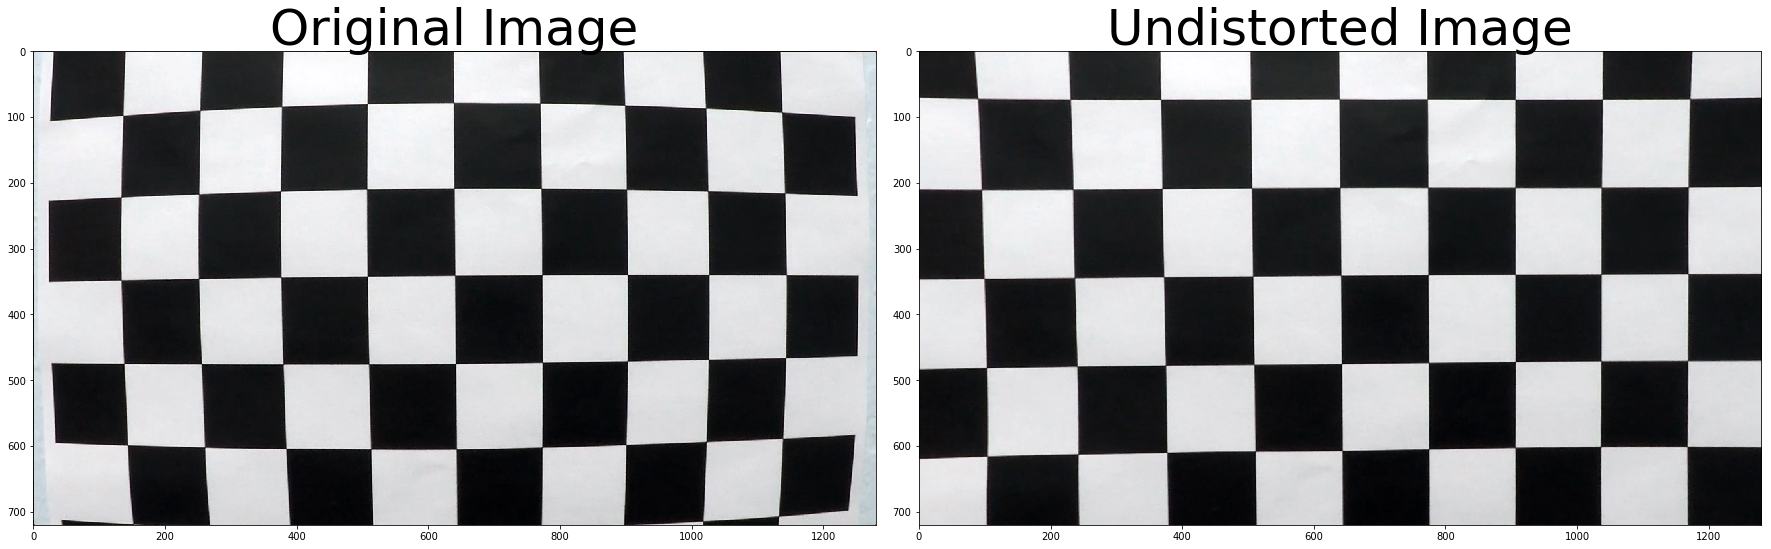

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


test_img_path = "camera_cal/calibration1.jpg"
img = cv2.imread(test_img_path)
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Use color transforms, gradients, etc., to create a thresholded binary image.

### First, apply Sobel operator 

In [3]:
import matplotlib.image as mpimg
import pickle

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) if orient=='x' else cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #plt.imshow(sxbinary, cmap='gray')
    # 6) Return this mask as your binary_output image
    return sxbinary


'''
# Read in an image and grayscale it
image = mpimg.imread('../test_images/test4.jpg')
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
'''

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

'''
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
'''

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

'''
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.8, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
'''

"\n# Run the function\ndir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.8, 1.3))\n# Plot the result\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(image)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(dir_binary, cmap='gray')\nax2.set_title('Thresholded Grad. Dir.', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

In [4]:
def get_combine_sober(image):
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.8, 1.3))

    combined_sober = np.zeros_like(dir_binary)
    combined_sober[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined_sober

### Second, apply Saturation color filter

In [5]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
def get_color_binary(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    return s_binary

### Combine color filter and sober gradient filter

In [6]:
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors

def get_binary(image):
    sober_binary = get_combine_sober(image)
    color_binary = get_color_binary(image)
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(sober_binary == 1) | (color_binary == 1)] = 1
    
    return combined_binary

### Third, apply a perspective transform to rectify binary image ("birds-eye view").

In [7]:
def get_perspective_transform(image):
    img_size = (image.shape[1], image.shape[0])
    '''
    src = np.float32(
         [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
         [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    
    print(src)
    print(dst)
    
    src = np.float32([[585,400],[203,680],[1080,680],[695,400]])
    dst = np.float32([[300,0],[300,700],[1000,700],[1000,0]])
    '''
    
    src = np.float32([[582,460],[201,720],[1127,720],[705,460]])
    dst = np.float32([[320,0],[320,720],[960,720],[960,0]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)
    return warped

def get_inv_perspective_transform(image):
    img_size = (image.shape[1], image.shape[0])

    src = np.float32([[582,460],[201,720],[1127,720],[705,460]])
    dst = np.float32([[320,0],[320,720],[960,720],[960,0]])
    
    # Given src and dst points, calculate the perspective transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    inv_warped = cv2.warpPerspective(image, Minv, img_size)
    return inv_warped

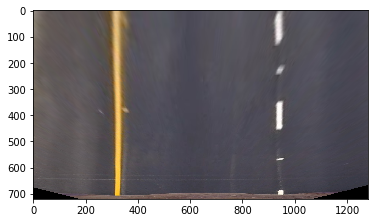

In [8]:
test_img_path = "test_images/straight_lines1.jpg"
image = mpimg.imread(test_img_path)
img2 = get_perspective_transform(image)
plt.imshow(img2)

## Detect lane pixels and fit to find the lane boundary.

In [9]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_polynomial(leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

In [10]:
def fit_poly(img_shape, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

## Determine the curvature of the lane and vehicle position with respect to center.

In [11]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [12]:
def measure_vehicle_position(left_fitx, right_fitx, center_pos=640):
    lane_center = left_fitx[-1] + (right_fitx[-1] - left_fitx[-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    off_meter = (lane_center - center_pos) * xm_per_pix
    return off_meter

## Warp the detected lane boundaries back onto the original image.

In [13]:
def draw_poly_on_binary_warped(binary_warped, left_fitx, right_fitx):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    left_curve = np.vstack((left_fitx,ploty)).astype(np.int32).T
    right_curve = np.vstack((right_fitx,ploty)).astype(np.int32).T
    
    pts = np.hstack(([np.array(left_curve)], [np.array(np.flipud(right_curve))]))
    
    cv2.polylines(window_img, [left_curve],  False,  (255, 0, 0),  20)
    cv2.polylines(window_img, [right_curve],  False,  (255, 0, 0),  20)
    
    cv2.fillPoly(window_img, np.int_([pts]), (0, 255, 0))
    
    '''
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([l_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped_binary blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    '''
    
    # Combine the result with the original image
    #result = cv2.addWeighted(window_img, 0.8, orig_warped, 1, 0)
    
    return window_img

In [59]:
def judge_contour_quality(drawed_warped):
    if not os.path.exists("prev_ctr.npy"):
        np.save("prev_ctr.npy", drawed_warped)
        return drawed_warped
    else:
        im_bw = cv2.cvtColor(drawed_warped, cv2.COLOR_RGB2GRAY)
        (thresh, im_bw) = cv2.threshold(im_bw, 127, 255, 0)
        image, contours, hierarchy = cv2.findContours(im_bw, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
        
        prev_drawed_warped = np.load('prev_ctr.npy')
        im_bw_2 = cv2.cvtColor(prev_drawed_warped, cv2.COLOR_RGB2GRAY)
        (thresh, im_bw_2) = cv2.threshold(im_bw_2, 127, 255, 0)
        image, contours_2, hierarchy = cv2.findContours(im_bw_2, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
        
        cnt1 = contours[0]
        cnt2 = contours_2[0]
        ret = cv2.matchShapes(cnt1,cnt2,1,0.0)
        
        print("diff: "  + str(ret))
        if ret <= 0.1:
            np.save("prev_ctr.npy", drawed_warped)
            return drawed_warped
        else:
            return prev_drawed_warped


In [51]:
import os
def reset_stored_file():
    if os.path.exists("prev_ctr.npy"):
        os.remove("prev_ctr.npy")
    if os.path.exists("memory.npy"):
        os.remove("memory.npy")
    print("Reset all stored npy files")

## Write estimation of position and curvature on image

In [14]:
def write_curvature_and_position(image, curvature, position):
    left_curvature = round(curvature[0], 2)
    right_curvature = round(curvature[1], 2)
    position = round(position, 2)
    my_text_1 = 'left Curvature: {}'.format(str(left_curvature))
    my_text_2 = 'right Curvature: {}'.format(str(right_curvature))
    my_text_3 = 'Position: {}'.format(str(position))
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText_1 = (200,100)
    bottomLeftCornerOfText_2 = (200,140)
    bottomLeftCornerOfText_3 = (200,180)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2

    cv2.putText(image, my_text_1,
        bottomLeftCornerOfText_1, 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    cv2.putText(image, my_text_2,
        bottomLeftCornerOfText_2, 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    cv2.putText(image, my_text_3,
        bottomLeftCornerOfText_3, 
        font, 
        fontScale,
        fontColor,
        lineType)
    return image

Text(0.5,1,'Drawed using fited polynomial')

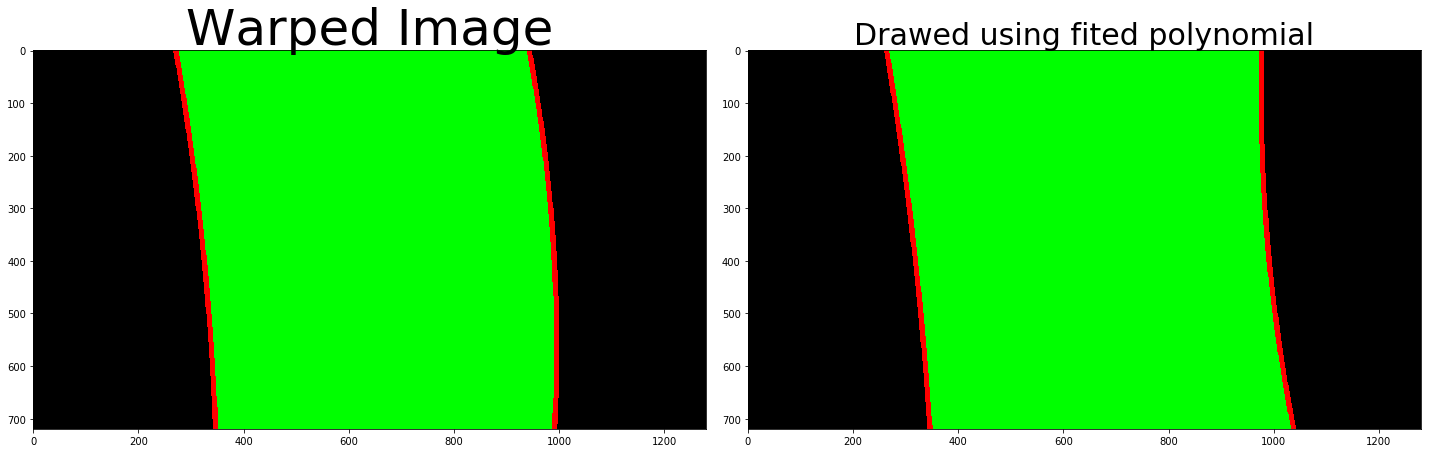

In [17]:
left_mean = [-9.36794063e-05,  1.72447835e-01,  2.77177250e+02]
left = [-7.00279882e-05 , 1.64873220e-01,  2.69175200e+02]

right_mean = [-1.64452835e-04,  1.85556797e-01,  9.38197907e+02]
right = [ 1.53738181e-04, -2.66665373e-02,  9.71902478e+02]

# find points on the polynomial
left_fitx_1, right_fitx_1, ploty_1 = fit_poly(warped_image.shape, left_mean, right_mean)
# draw fited pionts 
window_img_1 = np.zeros_like(warped_image)
drawed_warped_1 = draw_poly_on_binary_warped(window_img_1, left_fitx_1, right_fitx_1)

left_fitx_2, right_fitx_2, ploty_2 = fit_poly(warped_image.shape, left, right)
# draw fited pionts 
window_img_2 = np.zeros_like(warped_image)
drawed_warped_2 = draw_poly_on_binary_warped(window_img_2, left_fitx_2, right_fitx_2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(drawed_warped_1)
ax1.set_title('Warped Image', fontsize=50)
ax2.imshow(drawed_warped_2)
ax2.set_title('Drawed using fited polynomial', fontsize=30)

0.006929794186351257


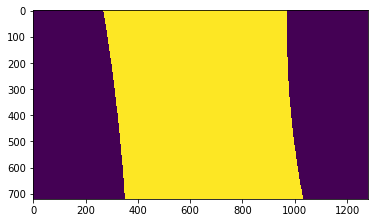

In [43]:
#left_ctr,_ = cv2.findContours(drawed_warped_1, cv2.CV_RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
#right_ctr,_ = cv2.findContours(drawed_warped_2, cv2.CV_RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
#test = cv2.matchShapes(drawnContours[0], originalContours[0], cv2.cv.CV_CONTOURS_MATCH_I1, 0.0)
#print(test)

im_bw_1 = cv2.cvtColor(drawed_warped_1, cv2.COLOR_RGB2GRAY)
(thresh, im_bw_1) = cv2.threshold(im_bw_1, 127, 255, 0)
image_1, contours_1, hierarchy = cv2.findContours(im_bw_1, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

im_bw_2 = cv2.cvtColor(drawed_warped_2, cv2.COLOR_RGB2GRAY)
(thresh, im_bw_2) = cv2.threshold(im_bw_2, 127, 255, 0)
image_2, contours_2, hierarchy = cv2.findContours(im_bw_2, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

#haha = np.zeros_like(drawed_warped_2)
#cv2.drawContours(haha, contours, -1, (0,255,0), 3)
plt.imshow(image_2)


cnt1 = contours_1[0]
cnt2 = contours_2[0]

ret = cv2.matchShapes(cnt1,cnt2,1,0.0)
print(ret)


Reset all stored npy files


Text(0.5,1,'With Curvature and position')

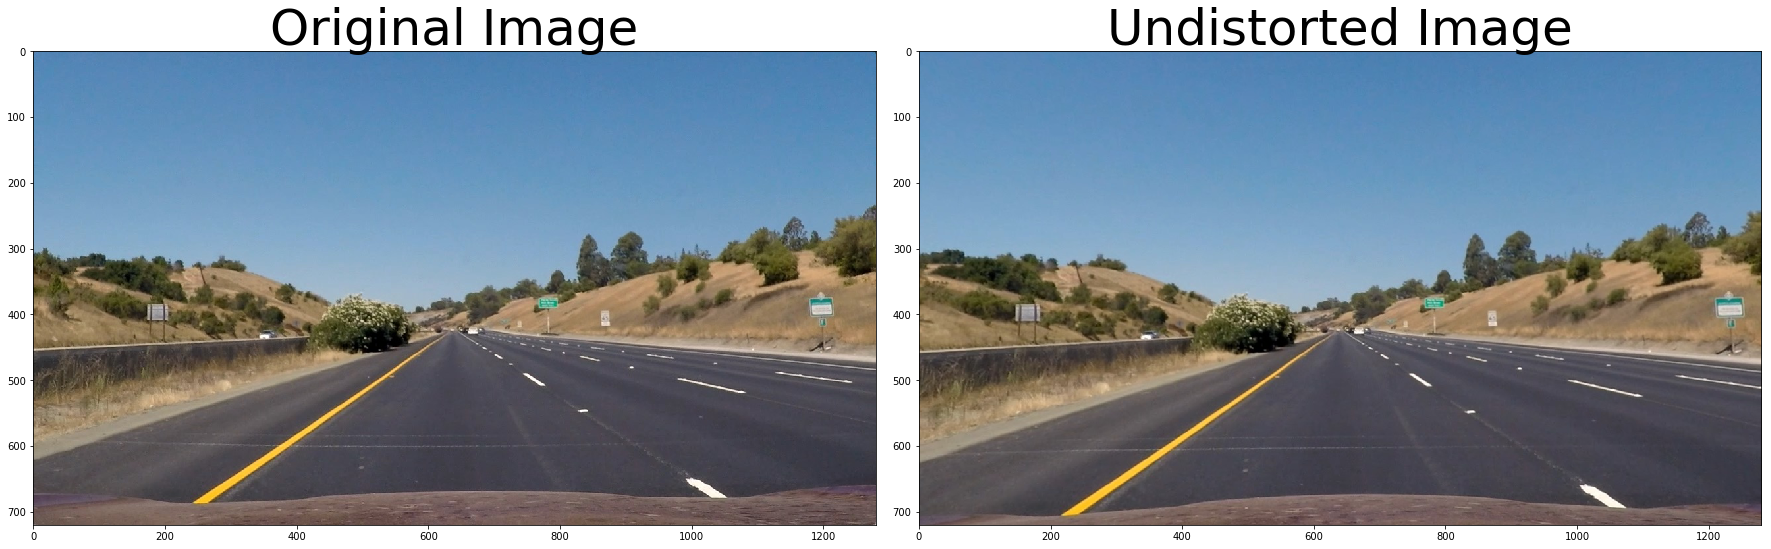

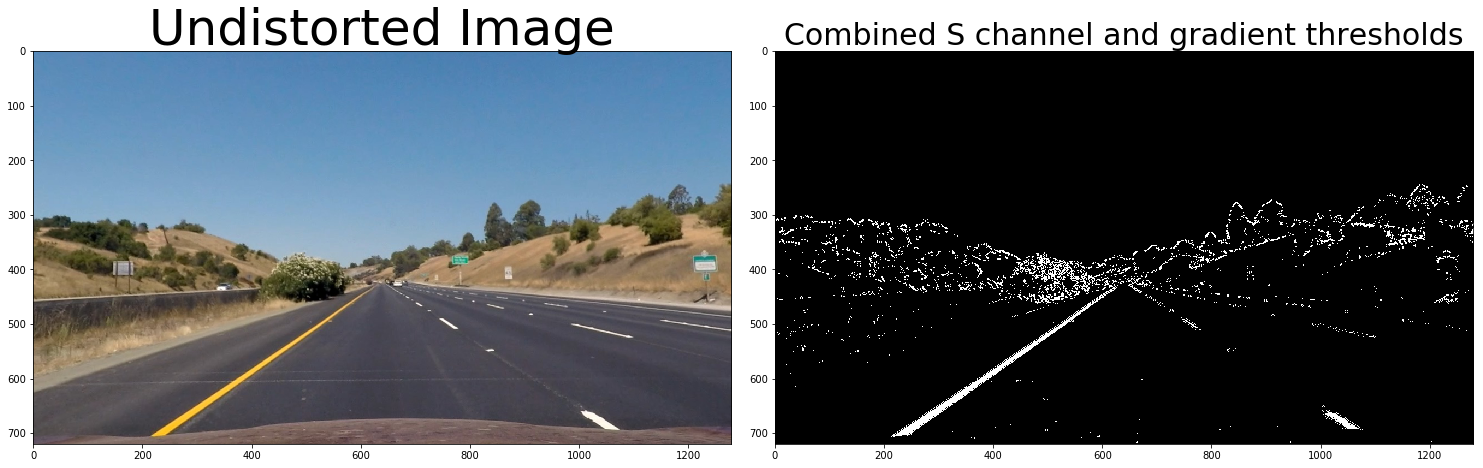

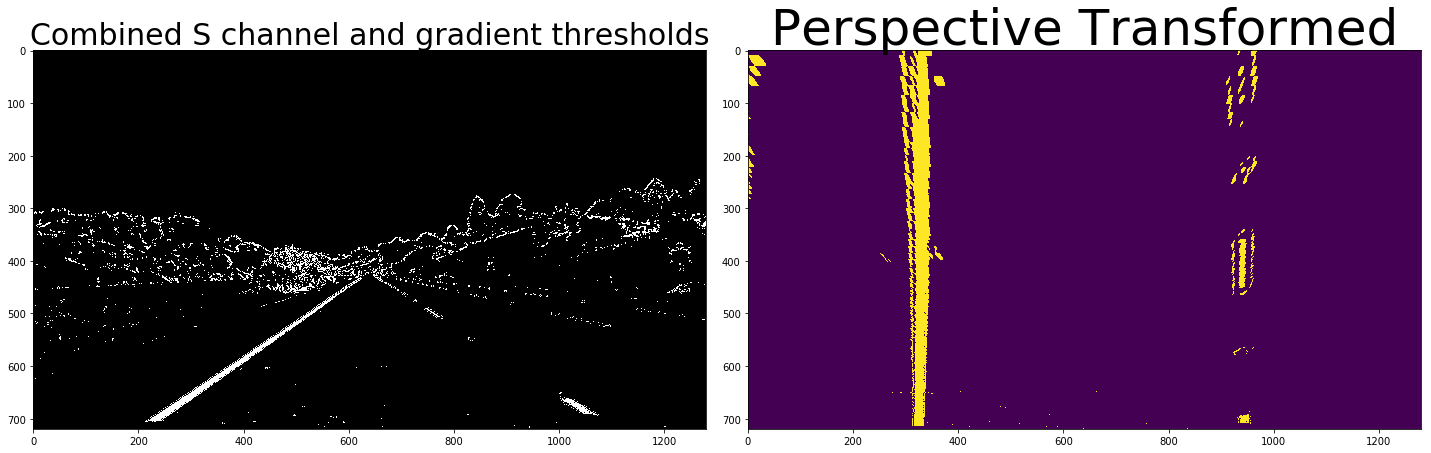

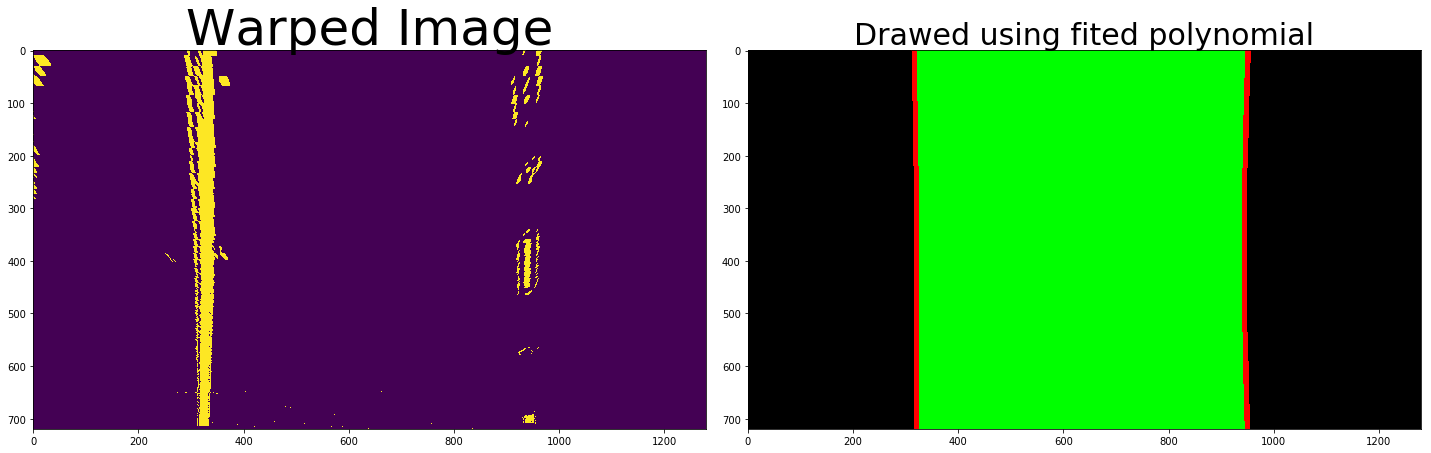

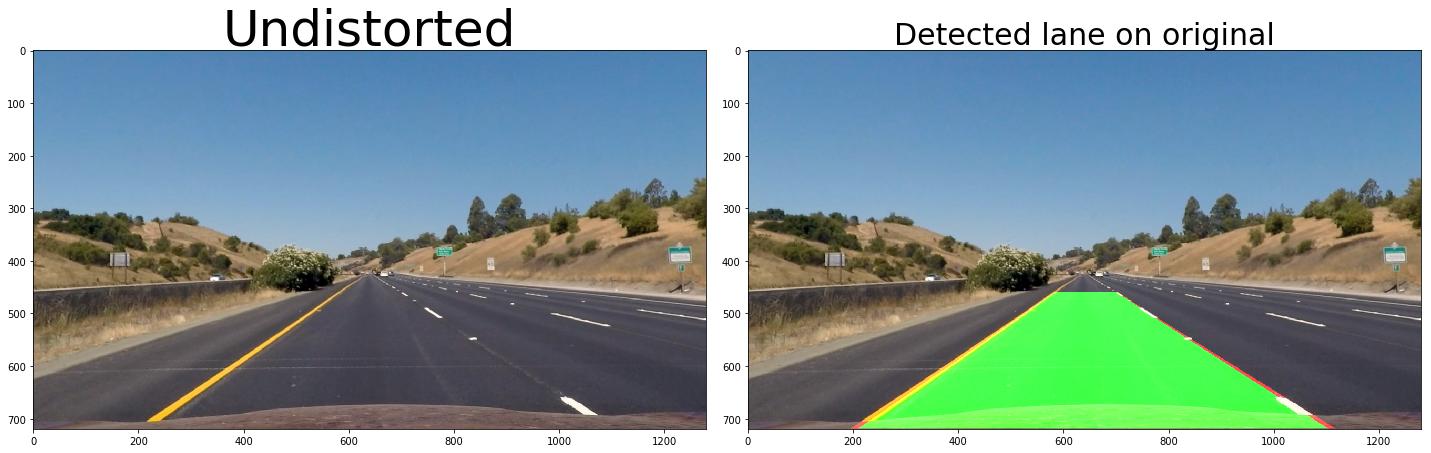

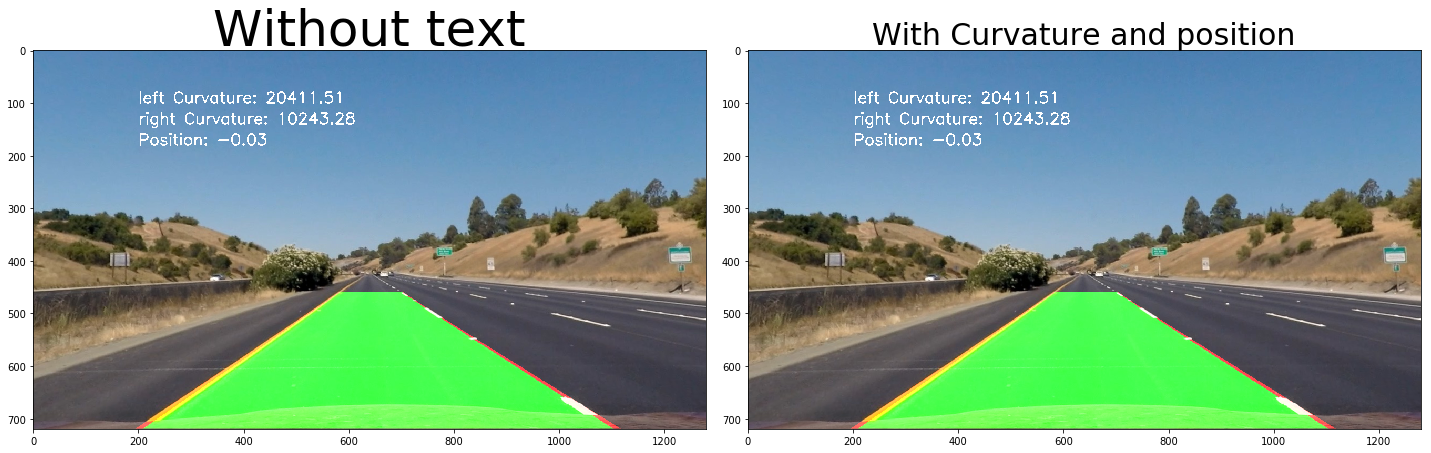

In [54]:
# Pipeline
reset_stored_file()

test_img_path = "test_images/straight_lines1.jpg"
image = mpimg.imread(test_img_path)
# apply carmera calibraton and distort
undistorted = cal_undistort(image, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# get both sober and color binary
masked_image = get_binary(undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(masked_image, cmap='gray')
ax2.set_title('Combined S channel and gradient thresholds', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# get perspective transform on binary
warped_image = get_perspective_transform(masked_image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(masked_image, cmap="gray")
ax1.set_title('Combined S channel and gradient thresholds', fontsize=30)
ax2.imshow(warped_image)
ax2.set_title('Perspective Transformed', fontsize=50)

# draw detected lane on original image
# find left right x y lane points
leftx, lefty, rightx, righty = find_lane_pixels(warped_image)
# fit in polynomial 
left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
# find points on the polynomial
left_fitx, right_fitx, ploty = fit_poly(warped_image.shape, left_fit, right_fit)
# draw fited pionts 
drawed_warped = draw_poly_on_binary_warped(warped_image, left_fitx, right_fitx)
# use matchShape to check quality
drawed_warped = judge_contour_quality(drawed_warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(warped_image)
ax1.set_title('Warped Image', fontsize=50)
ax2.imshow(drawed_warped)
ax2.set_title('Drawed using fited polynomial', fontsize=30)

# invert the drawing
inv_drawed_warped = get_inv_perspective_transform(drawed_warped)
result = cv2.addWeighted(inv_drawed_warped, 0.8, undistorted, 1, 0)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Undistorted', fontsize=50)
ax2.imshow(result)
ax2.set_title('Detected lane on original', fontsize=30)

# draw estimation of position and curvature
curvature = measure_curvature_real(ploty, left_fit, right_fit)
position = measure_vehicle_position(left_fitx, right_fitx)
out_img = write_curvature_and_position(result, curvature, position)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(result)
ax1.set_title('Without text', fontsize=50)
ax2.imshow(out_img)
ax2.set_title('With Curvature and position', fontsize=30)

In [55]:
import math

def get_ave_fit(left_memory, right_memory):
    left_mean = np.mean(np.array(left_memory), axis=0)
    right_mean = np.mean(np.array(right_memory), axis=0)
    return [left_mean, right_mean]

def comp_fit(fit, mean):
    judge = [0.3, 0.3, 0.9]
    abs_fit = np.array([math.fabs(f) for f in fit])
    abs_mean = np.array([math.fabs(m) for m in mean])
    #for each_diff in judge - abs_fit/abs_mean:
    #    if each_diff > 0:
    #        return False
    return (abs_fit/abs_mean)[2] > judge[2]


def qualified_frame(left_fit, right_fit, prev_left_mean, prev_right_mean):
    print("left")
    print(prev_left_mean)
    print(left_fit)
    print("right")
    print(prev_right_mean)
    print(right_fit)
    return comp_fit(left_fit, prev_left_mean) and comp_fit(right_fit, prev_right_mean)
    

def pipeline(image, useMemory, checkCtr):
    # Pipeline
    # apply carmera calibraton and distort
    undistorted = cal_undistort(image, objpoints, imgpoints)
    # get both sober and color binary
    masked_image = get_binary(undistorted)
    # get perspective transform on binary
    warped_image = get_perspective_transform(masked_image)
    # draw detected lane on original image
    # find left right x y lane points
    leftx, lefty, rightx, righty = find_lane_pixels(warped_image)
    # fit in polynomial 
    left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty)
    
    if useMemory:
        # if numpy file does not exist, create
        if not os.path.exists("memory.npy"):
            new_memory = np.array([[left_fit], [right_fit]])
            np.save('memory.npy', new_memory)
        else:
            memory = np.load('memory.npy')
            left_memory, right_memory = memory[0].tolist(), memory[1].tolist()

            print("Memory len: " + str(len(left_memory)))
            prev_left_mean, prev_right_mean = get_ave_fit(left_memory, right_memory)
            print("Current left mean {}, right mean {}".format(str(prev_left_mean[2]), str(prev_right_mean[2])))
            if qualified_frame(left_fit, right_fit, prev_left_mean, prev_right_mean):
                print("Qualified")
                # if memory length == 10, pop first one
                if len(left_memory) >= 10:
                    left_memory = left_memory[1:]
                    right_memory = right_memory[1:]
                left_memory.append(left_fit)
                right_memory.append(right_fit)
                np.save('memory.npy', np.array([left_memory, right_memory]))
                # calculate new average
                left_fit, right_fit = get_ave_fit(left_memory, right_memory)
            else:
                print("Not qualified")
                # if not qualified, use previous polynomial fit
                left_fit, right_fit = prev_left_mean, prev_right_mean

    
    # find points on the polynomial
    left_fitx, right_fitx, ploty = fit_poly(warped_image.shape, left_fit, right_fit)
    # draw fited pionts 
    drawed_warped = draw_poly_on_binary_warped(warped_image, left_fitx, right_fitx)  
    
    if checkCtr:
        drawed_warped = judge_contour_quality(drawed_warped)
        
    # invert the drawing
    inv_drawed_warped = get_inv_perspective_transform(drawed_warped)
    result = cv2.addWeighted(inv_drawed_warped, 0.8, undistorted, 1, 0)
    # draw estimation of position and curvature
    curvature = measure_curvature_real(ploty, left_fit, right_fit)
    position = measure_vehicle_position(left_fitx, right_fitx)
    out_img = write_curvature_and_position(result, curvature, position)
    return out_img

#test_img_path = "../test_images/test4.jpg"
#plt.figure(figsize = (20,10))
#plt.imshow(pipeline(test_img_path))

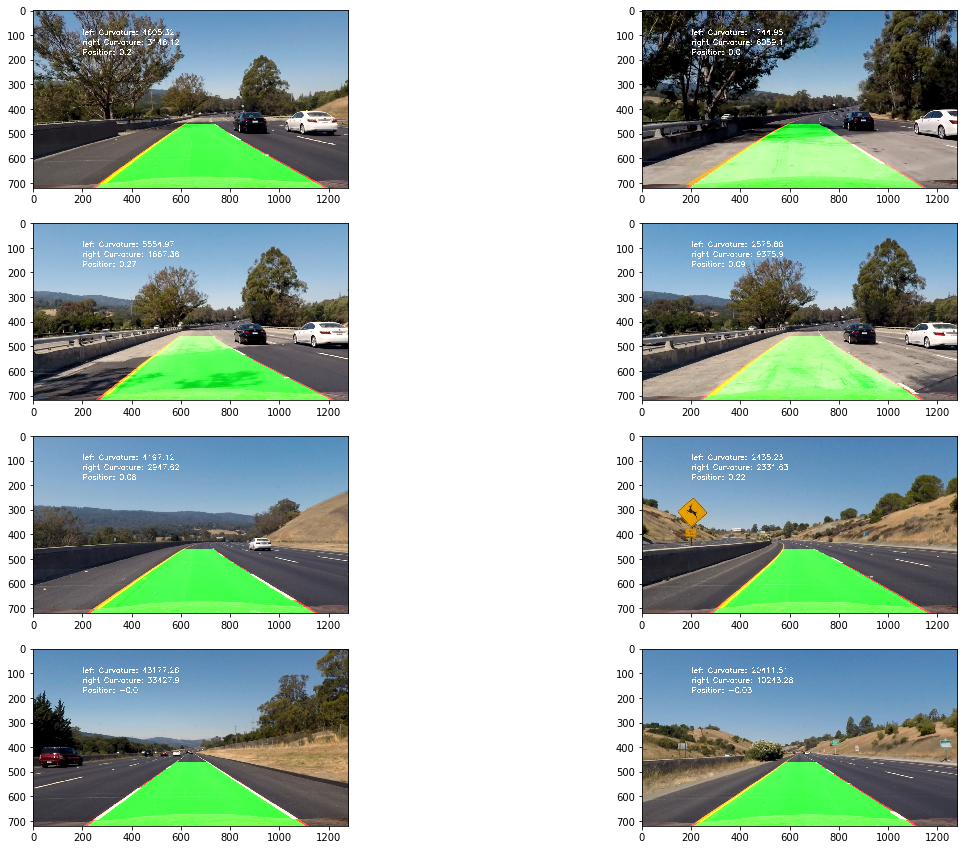

In [56]:
# test images

import os
test_imgs_folder = os.path.join(os.getcwd(), "test_images/")
output_imgs_folder = os.path.join(os.getcwd(), "output_images/")
test_imgs = os.listdir("test_images/")

w=10
h=5
fig=plt.figure(figsize=(20, 15))
columns = 2
rows = 4
for i in range(1, columns*rows+1):
    img = mpimg.imread(os.path.join(test_imgs_folder, test_imgs[i-1]))
    img = pipeline(img, False, False)
    cv2.imwrite(os.path.join(output_imgs_folder, test_imgs[i-1]), cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [61]:
# video
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

reset_stored_file()

def process_image(image):
    result = pipeline(image, True, True)
    return result

white_output = 'output_images/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Reset all stored npy files
[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


  0%|          | 1/1261 [00:01<21:44,  1.04s/it]

Memory len: 1
Current left mean 262.19540089856355, right mean 897.9406511387747
left
[-2.47155667e-04  3.32225974e-01  2.62195401e+02]
[-2.47155667e-04  3.32225974e-01  2.62195401e+02]
right
[-1.70340008e-04  2.78735783e-01  8.97940651e+02]
[-1.70340008e-04  2.78735783e-01  8.97940651e+02]
Qualified
diff: 0.0


  0%|          | 2/1261 [00:02<21:38,  1.03s/it]

Memory len: 2
Current left mean 262.19540089856355, right mean 897.9406511387747
left
[-2.47155667e-04  3.32225974e-01  2.62195401e+02]
[-2.55910267e-04  3.39459120e-01  2.62076121e+02]
right
[-1.70340008e-04  2.78735783e-01  8.97940651e+02]
[-8.47022835e-05  2.23770182e-01  8.98817898e+02]
Qualified
diff: 0.002980799560088676


  0%|          | 3/1261 [00:03<21:36,  1.03s/it]

Memory len: 3
Current left mean 262.1556408119036, right mean 898.2330666661046
left
[-2.50073867e-04  3.34637023e-01  2.62155641e+02]
[-2.56964851e-04  3.43485582e-01  2.60928176e+02]
right
[-1.41794100e-04  2.60413916e-01  8.98233067e+02]
[-1.86613511e-04  3.16175311e-01  8.78375153e+02]
Qualified
diff: 0.0030425040844069273


  0%|          | 4/1261 [00:04<21:34,  1.03s/it]

Memory len: 4
Current left mean 261.84877463811677, right mean 893.2685881732249
left
[-2.51796613e-04  3.36849163e-01  2.61848775e+02]
[-2.70590130e-04  3.57359817e-01  2.58931504e+02]
right
[-1.52998953e-04  2.74354265e-01  8.93268588e+02]
[-2.49483820e-04  3.83093898e-01  8.61174088e+02]
Qualified
diff: 0.0034858294424773284


  0%|          | 5/1261 [00:05<21:31,  1.03s/it]

Memory len: 5
Current left mean 261.26532049265563, right mean 886.849688188717
left
[-2.55555316e-04  3.40951293e-01  2.61265320e+02]
[-2.39523289e-04  3.37872558e-01  2.60567898e+02]
right
[-1.72295926e-04  2.96102191e-01  8.86849688e+02]
[-2.76099027e-04  4.02535670e-01  8.59943314e+02]
Qualified
diff: 0.003661701867506695


  0%|          | 6/1261 [00:06<21:31,  1.03s/it]

Memory len: 6
Current left mean 261.1490834492948, right mean 882.3652925296088
left
[-2.52883312e-04  3.40438171e-01  2.61149083e+02]
[-2.30251074e-04  3.37009338e-01  2.59080801e+02]
right
[-1.89596443e-04  3.13841104e-01  8.82365293e+02]
[-1.69186770e-04  3.21996320e-01  8.65850036e+02]
Qualified
diff: 0.002624284001219862


  1%|          | 7/1261 [00:07<21:30,  1.03s/it]

Memory len: 7
Current left mean 260.85361455431604, right mean 880.0059702036293
left
[-2.49650135e-04  3.39948338e-01  2.60853615e+02]
[-2.45902546e-04  3.54125410e-01  2.54479134e+02]
right
[-1.86680776e-04  3.15006135e-01  8.80005970e+02]
[-1.79941807e-04  3.25753302e-01  8.68791667e+02]
Qualified
diff: 0.001754158032193448


  1%|          | 8/1261 [00:08<21:27,  1.03s/it]

Memory len: 8
Current left mean 260.05680447971463, right mean 878.6041823462688
left
[-2.49181686e-04  3.41720472e-01  2.60056804e+02]
[-2.31074854e-04  3.45916229e-01  2.55748065e+02]
right
[-1.85838405e-04  3.16349531e-01  8.78604182e+02]
[3.29421819e-06 2.10106476e-01 8.79698756e+02]
Qualified
diff: 0.003774402777130398


  1%|          | 9/1261 [00:09<21:26,  1.03s/it]

Memory len: 9
Current left mean 259.57805567670624, right mean 878.72580167145
left
[-2.47169816e-04  3.42186667e-01  2.59578056e+02]
[-2.25121108e-04  3.46486500e-01  2.51922125e+02]
right
[-1.64823669e-04  3.04544747e-01  8.78725802e+02]
[1.21078958e-05 1.98702215e-01 8.83526514e+02]
Qualified
diff: 0.00170316561871392


  1%|          | 10/1261 [00:10<21:26,  1.03s/it]

Memory len: 10
Current left mean 258.8124625721024, right mean 879.2058728856816
left
[-2.44964945e-04  3.42616650e-01  2.58812463e+02]
[-2.10885711e-04  3.34862041e-01  2.52543655e+02]
right
[-1.47130512e-04  2.93960494e-01  8.79205873e+02]
[-3.99786083e-05  2.21949227e-01  8.84436106e+02]
Qualified
diff: 0.002776773020621015


  1%|          | 11/1261 [00:11<21:26,  1.03s/it]

Memory len: 10
Current left mean 257.84728802461575, right mean 877.85541841584
left
[-2.41337950e-04  3.42880257e-01  2.57847288e+02]
[-2.02730267e-04  3.32698974e-01  2.50606054e+02]
right
[-1.34094372e-04  2.88281838e-01  8.77855418e+02]
[-1.63871807e-04  3.32994290e-01  8.57671557e+02]
Qualified
diff: 0.0034841735385343076


  1%|          | 12/1261 [00:12<21:20,  1.02s/it]

Memory len: 10
Current left mean 256.68835335034186, right mean 873.8285090064173
left
[-2.36895410e-04  3.42927557e-01  2.56688353e+02]
[-2.03814777e-04  3.39153576e-01  2.43727616e+02]
right
[-1.33447552e-04  2.93707689e-01  8.73828509e+02]
[-1.55613181e-04  3.00536900e-01  8.77711783e+02]
Qualified
diff: 0.00109092530512922


  1%|          | 13/1261 [00:13<21:15,  1.02s/it]

Memory len: 10
Current left mean 254.8535029119213, right mean 871.7178975361236
left
[-2.31685861e-04  3.42897003e-01  2.54853503e+02]
[-1.92626057e-04  3.32612769e-01  2.43757732e+02]
right
[-1.40538642e-04  3.01384361e-01  8.71717898e+02]
[-6.18554965e-05  2.40978887e-01  8.79822714e+02]
Qualified
diff: 0.0011360738195259623


  1%|          | 14/1261 [00:14<21:13,  1.02s/it]

Memory len: 10
Current left mean 253.13645847925636, right mean 871.8626537042497
left
[-2.25251981e-04  3.41809721e-01  2.53136458e+02]
[-1.89142158e-04  3.31546960e-01  2.43175313e+02]
right
[-1.28062840e-04  2.93864718e-01  8.71862654e+02]
[-6.60550955e-05  2.35921574e-01  8.81916296e+02]
Qualified
diff: 0.0001247327105730056


  1%|          | 15/1261 [00:15<21:35,  1.04s/it]

Memory len: 10
Current left mean 251.56083939123982, right mean 873.9368745273745
left
[-2.17107184e-04  3.39228436e-01  2.51560839e+02]
[-1.82175909e-04  3.24088483e-01  2.45733618e+02]
right
[-1.09719968e-04  2.79147486e-01  8.73936875e+02]
[-1.21300073e-04  3.04150800e-01  8.54947507e+02]
Qualified
diff: 0.0017462116178692533


  1%|▏         | 16/1261 [00:16<21:23,  1.03s/it]

Memory len: 10
Current left mean 250.07741133590008, right mean 873.4372937994222
left
[-2.11372446e-04  3.37850028e-01  2.50077411e+02]
[-1.62693597e-04  3.06541478e-01  2.50041182e+02]
right
[-9.42400723e-05  2.69308999e-01  8.73437294e+02]
[-2.35247269e-04  4.13301436e-01  8.26394397e+02]
Qualified
diff: 0.001966817587987113


  1%|▏         | 17/1261 [00:17<21:19,  1.03s/it]

Memory len: 10
Current left mean 249.1734494373787, right mean 869.4917298952511
left
[-2.04616698e-04  3.34803242e-01  2.49173449e+02]
[-1.70012308e-04  3.13044353e-01  2.48072284e+02]
right
[-1.00846122e-04  2.78439511e-01  8.69491730e+02]
[-1.59919462e-04  3.51519119e-01  8.33698627e+02]
Qualified
diff: 0.002288580986790023


  1%|▏         | 18/1261 [00:18<21:18,  1.03s/it]

Memory len: 10
Current left mean 248.5327643956585, right mean 865.9824258962451
left
[-1.97027675e-04  3.30695136e-01  2.48532764e+02]
[-1.80358154e-04  3.22869643e-01  2.45546149e+02]
right
[-9.88438878e-05  2.81016092e-01  8.65982426e+02]
[-1.31720809e-04  3.25509512e-01  8.36802653e+02]
Qualified
diff: 0.0012977919770313373


  2%|▏         | 19/1261 [00:19<21:17,  1.03s/it]

Memory len: 10
Current left mean 247.51257275320978, right mean 861.6928155504465
left
[-1.91956005e-04  3.28390478e-01  2.47512573e+02]
[-1.56495475e-04  3.05998865e-01  2.45151381e+02]
right
[-1.12345390e-04  2.92556396e-01  8.61692816e+02]
[-1.09227507e-04  2.92810451e-01  8.49340896e+02]
Qualified
diff: 0.0007513364115814825


  2%|▏         | 20/1261 [00:20<21:11,  1.02s/it]

Memory len: 10
Current left mean 246.83549842639258, right mean 858.274253818033
left
[-1.85093441e-04  3.24341714e-01  2.46835498e+02]
[-1.34138658e-04  2.91047852e-01  2.44389036e+02]
right
[-1.24478931e-04  3.01967220e-01  8.58274254e+02]
[-1.59127794e-04  3.30419229e-01  8.45233613e+02]
Qualified
diff: 0.0009586621574821375


  2%|▏         | 21/1261 [00:21<21:14,  1.03s/it]

Memory len: 10
Current left mean 246.02003645817655, right mean 854.3540044425248
left
[-1.77418736e-04  3.19960295e-01  2.46020036e+02]
[-1.46644992e-04  3.03853891e-01  2.39381462e+02]
right
[-1.36393849e-04  3.12814220e-01  8.54354004e+02]
[-5.26503323e-05  2.53317341e-01  8.61844119e+02]
Qualified
diff: 7.209665816548805e-05


  2%|▏         | 22/1261 [00:22<21:19,  1.03s/it]

Memory len: 10
Current left mean 244.89757720753187, right mean 854.7712605966444
left
[-1.71810208e-04  3.17075787e-01  2.44897577e+02]
[-1.30174163e-04  2.90537402e-01  2.38635768e+02]
right
[-1.25271702e-04  3.04846525e-01  8.54771261e+02]
[-8.95179981e-05  2.53456803e-01  8.72787215e+02]
Qualified
diff: 0.00013677507927090105


  2%|▏         | 23/1261 [00:23<21:16,  1.03s/it]

Memory len: 10
Current left mean 244.38839234575212, right mean 854.2788037653265
left
[-1.64446147e-04  3.12214170e-01  2.44388392e+02]
[-1.19889721e-04  2.82407774e-01  2.37009781e+02]
right
[-1.18662184e-04  3.00138515e-01  8.54278804e+02]
[-1.22830029e-04  2.62623331e-01  8.79087710e+02]
Qualified
diff: 0.0016823715983761978


  2%|▏         | 24/1261 [00:24<21:09,  1.03s/it]

Memory len: 10
Current left mean 243.71359722088482, right mean 854.2053033002937
left
[-1.57172513e-04  3.07193670e-01  2.43713597e+02]
[-1.47610784e-04  2.94591986e-01  2.38411718e+02]
right
[-1.24759637e-04  3.02302960e-01  8.54205303e+02]
[-2.24861510e-04  3.42715802e-01  8.62953195e+02]
Qualified
diff: 0.0013462396212402528


  2%|▏         | 25/1261 [00:25<21:11,  1.03s/it]

Memory len: 10
Current left mean 243.23723776737546, right mean 852.3089931818151
left
[-1.53019376e-04  3.03498173e-01  2.43237238e+02]
[-1.44705565e-04  2.88867261e-01  2.40527601e+02]
right
[-1.40640278e-04  3.12982382e-01  8.52308993e+02]
[-2.03481373e-04  3.39152997e-01  8.58042307e+02]
Qualified
diff: 0.002252384120232931


  2%|▏         | 26/1261 [00:26<21:06,  1.03s/it]

Memory len: 10
Current left mean 242.71663609759662, right mean 852.6184731633809
left
[-1.49272342e-04  2.99976050e-01  2.42716636e+02]
[-1.52554392e-04  2.92341624e-01  2.38561909e+02]
right
[-1.48858408e-04  3.16482602e-01  8.52618473e+02]
[-1.63438739e-04  2.94784863e-01  8.73843634e+02]
Qualified
diff: 0.00410345913939153


  2%|▏         | 27/1261 [00:27<21:02,  1.02s/it]

Memory len: 10
Current left mean 241.56870873107692, right mean 857.3633968086355
left
[-1.48258421e-04  2.98556065e-01  2.41568709e+02]
[-1.68929522e-04  3.02053068e-01  2.37666594e+02]
right
[-1.41677555e-04  3.04630945e-01  8.57363397e+02]
[-5.76722402e-05  2.11928658e-01  8.86769067e+02]
Qualified
diff: 0.004220740026981473


  2%|▏         | 28/1261 [00:28<20:59,  1.02s/it]

Memory len: 10
Current left mean 240.52813972887247, right mean 862.6704407647196
left
[-1.48150143e-04  2.97456937e-01  2.40528140e+02]
[-1.77627673e-04  3.07388871e-01  2.35006677e+02]
right
[-1.31452833e-04  2.90671899e-01  8.62670441e+02]
[-1.86365019e-05  1.55548152e-01  9.08900467e+02]
Qualified
diff: 0.0055987026618590785


  2%|▏         | 29/1261 [00:29<20:57,  1.02s/it]

Memory len: 10
Current left mean 239.47419258940278, right mean 869.8802221777687
left
[-1.47877095e-04  2.95908859e-01  2.39474193e+02]
[-1.77110845e-04  3.00752364e-01  2.39455466e+02]
right
[-1.20144402e-04  2.73675763e-01  8.69880222e+02]
[-1.87735180e-04  3.03985165e-01  8.80613292e+02]
Qualified
diff: 0.004223648214560838


  2%|▏         | 30/1261 [00:30<20:54,  1.02s/it]

Memory len: 10
Current left mean 238.904601100928, right mean 873.0074617352175
left
[-1.49938632e-04  2.95384209e-01  2.38904601e+02]
[-1.84327207e-04  3.03663856e-01  2.41973431e+02]
right
[-1.27995170e-04  2.74793234e-01  8.73007462e+02]
[-2.38750485e-04  3.58377578e-01  8.64613348e+02]
Qualified
diff: 0.0030268702200939024


  2%|▏         | 31/1261 [00:31<20:54,  1.02s/it]

Memory len: 10
Current left mean 238.66304060484762, right mean 874.9454353098317
left
[-1.54957487e-04  2.96645810e-01  2.38663041e+02]
[-2.16768488e-04  3.27118700e-01  2.41277084e+02]
right
[-1.35957439e-04  2.77589069e-01  8.74945435e+02]
[-2.02580053e-04  3.38955668e-01  8.61525540e+02]
Qualified
diff: 0.002085384092843423


  3%|▎         | 32/1261 [00:32<20:50,  1.02s/it]

Memory len: 10
Current left mean 238.85260282833656, right mean 874.9135774777506
left
[-1.61969836e-04  2.98972291e-01  2.38852603e+02]
[-2.37216254e-04  3.39322044e-01  2.43178425e+02]
right
[-1.50950411e-04  2.86152902e-01  8.74913577e+02]
[-1.91729232e-04  3.48445414e-01  8.48884190e+02]
Qualified
diff: 0.0005593297852782286


  3%|▎         | 33/1261 [00:33<20:49,  1.02s/it]

Memory len: 10
Current left mean 239.30686858963617, right mean 872.5232749809771
left
[-1.72674045e-04  3.03850755e-01  2.39306869e+02]
[-2.24887379e-04  3.30030824e-01  2.43370115e+02]
right
[-1.61171534e-04  2.95651763e-01  8.72523275e+02]
[-9.77868491e-05  2.76813674e-01  8.64517062e+02]
Qualified
diff: 0.0012449871829128822


  3%|▎         | 34/1261 [00:34<20:52,  1.02s/it]

Memory len: 10
Current left mean 239.94290200566488, right mean 871.0662101884998
left
[-1.83173811e-04  3.08613060e-01  2.39942902e+02]
[-2.32692110e-04  3.34913682e-01  2.44623966e+02]
right
[-1.58667216e-04  2.97070797e-01  8.71066210e+02]
[-6.62313268e-05  2.65467077e-01  8.63986257e+02]
Qualified
diff: 0.0016103679850911212


  3%|▎         | 35/1261 [00:35<20:48,  1.02s/it]

Memory len: 10
Current left mean 240.56412670751442, right mean 871.1695163398708
left
[-1.91681944e-04  3.12645229e-01  2.40564127e+02]
[-2.43739134e-04  3.43179493e-01  2.44714155e+02]
right
[-1.42804198e-04  2.89345925e-01  8.71169516e+02]
[-1.28095931e-04  2.98274230e-01  8.60260972e+02]
Qualified
diff: 0.0009175540081645672


  3%|▎         | 36/1261 [00:36<20:46,  1.02s/it]

Memory len: 10
Current left mean 240.9827820636815, right mean 871.3913828442908
left
[-2.01585300e-04  3.18076453e-01  2.40982782e+02]
[-2.63529715e-04  3.60862910e-01  2.43403783e+02]
right
[-1.35265654e-04  2.85258048e-01  8.71391383e+02]
[-3.32782047e-04  4.50284878e-01  8.34360506e+02]
Qualified
diff: 0.0019807481153713558


  3%|▎         | 37/1261 [00:37<20:38,  1.01s/it]

Memory len: 10
Current left mean 241.4669695051617, right mean 867.4430700723454
left
[-2.12682833e-04  3.24928581e-01  2.41466970e+02]
[-2.83079640e-04  3.78976225e-01  2.40519848e+02]
right
[-1.52199985e-04  3.00808049e-01  8.67443070e+02]
[-2.10577982e-04  3.79475877e-01  8.36543145e+02]
Qualified
diff: 0.003206217067702466


  3%|▎         | 38/1261 [00:38<20:35,  1.01s/it]

Memory len: 10
Current left mean 241.75229499004172, right mean 862.4204778528037
left
[-2.24097844e-04  3.32620897e-01  2.41752295e+02]
[-2.84702618e-04  3.81628168e-01  2.40857782e+02]
right
[-1.67490559e-04  3.17562771e-01  8.62420478e+02]
[-1.30889247e-04  3.16661564e-01  8.45839329e+02]
Qualified
diff: 0.008712911405957868


  3%|▎         | 39/1261 [00:39<20:38,  1.01s/it]

Memory len: 10
Current left mean 242.33740547320403, right mean 856.1143640551297
left
[-2.34805339e-04  3.40044827e-01  2.42337405e+02]
[-3.00478748e-04  3.95947593e-01  2.39189885e+02]
right
[-1.78715833e-04  3.33674113e-01  8.56114364e+02]
[-2.55785451e-04  4.27819163e-01  8.19428828e+02]
Qualified
diff: 0.008971300010672173


  3%|▎         | 40/1261 [00:40<20:38,  1.01s/it]

Memory len: 10
Current left mean 242.3108472906325, right mean 849.9959176870203
left
[-2.47142129e-04  3.49564350e-01  2.42310847e+02]
[-2.99134991e-04  3.99411714e-01  2.36780446e+02]
right
[-1.85520860e-04  3.46057512e-01  8.49995918e+02]
[-3.21146163e-04  4.74885825e-01  8.15504053e+02]
Qualified
diff: 0.006899995324910785


  3%|▎         | 41/1261 [00:41<20:38,  1.01s/it]

Memory len: 10
Current left mean 241.79154886039814, right mean 845.0849881651966
left
[-2.58622908e-04  3.59139135e-01  2.41791549e+02]
[-3.10203432e-04  4.11991741e-01  2.33536311e+02]
right
[-1.93760428e-04  3.57708337e-01  8.45084988e+02]
[-2.43082290e-04  4.15484114e-01  8.23418241e+02]
Qualified
diff: 0.005628249170971017


  3%|▎         | 42/1261 [00:42<20:39,  1.02s/it]

Memory len: 10
Current left mean 241.01747161243202, right mean 841.2742582076132
left
[-2.67966402e-04  3.67626439e-01  2.41017472e+02]
[-3.06640428e-04  4.14780965e-01  2.31842074e+02]
right
[-1.97810652e-04  3.65361182e-01  8.41274258e+02]
[-3.40605951e-04  5.02166166e-01  8.09877978e+02]
Qualified
diff: 0.0047076992934018125


  3%|▎         | 43/1261 [00:44<20:40,  1.02s/it]

Memory len: 10
Current left mean 239.88383650073328, right mean 837.3736370572833
left
[-2.74908819e-04  3.75172332e-01  2.39883837e+02]
[-2.98059169e-04  4.14491782e-01  2.29692736e+02]
right
[-2.12698324e-04  3.80733257e-01  8.37373637e+02]
[-2.70127681e-04  4.35891831e-01  8.24663507e+02]
Qualified
diff: 0.004295981063542009


  3%|▎         | 44/1261 [00:45<20:39,  1.02s/it]

Memory len: 10
Current left mean 238.51609867140695, right mean 833.3882816208907
left
[-2.82225998e-04  3.83618427e-01  2.38516099e+02]
[-2.81435952e-04  4.05004595e-01  2.28334220e+02]
right
[-2.29932407e-04  3.96641073e-01  8.33388282e+02]
[-2.67941232e-04  4.25094565e-01  8.31941042e+02]
Qualified
diff: 0.0025510913852685446


  4%|▎         | 45/1261 [00:46<20:38,  1.02s/it]

Memory len: 10
Current left mean 236.88712412364345, right mean 830.1837601728873
left
[-2.87100383e-04  3.90627519e-01  2.36887124e+02]
[-2.76868699e-04  4.07024078e-01  2.25398716e+02]
right
[-2.50103398e-04  4.12603821e-01  8.30183760e+02]
[-2.37998573e-04  3.92999298e-01  8.41321883e+02]
Qualified
diff: 0.0016907463395756106


  4%|▎         | 46/1261 [00:47<20:38,  1.02s/it]

Memory len: 10
Current left mean 234.95558031295485, right mean 828.289851328412
left
[-2.90413339e-04  3.97011977e-01  2.34955580e+02]
[-2.62308718e-04  3.98839618e-01  2.24745241e+02]
right
[-2.61093662e-04  4.22076328e-01  8.28289851e+02]
[-2.37661238e-04  3.87694974e-01  8.43142901e+02]
Qualified
diff: 0.002513485653110381


  4%|▎         | 47/1261 [00:48<20:34,  1.02s/it]

Memory len: 10
Current left mean 233.08972615406842, right mean 829.168090855527
left
[-2.90291239e-04  4.00809648e-01  2.33089726e+02]
[-2.58730348e-04  3.95969359e-01  2.23793666e+02]
right
[-2.51581581e-04  4.15817338e-01  8.29168091e+02]
[-1.00928890e-04  2.89319191e-01  8.59307645e+02]
Qualified
diff: 0.0020455761232253122


  4%|▍         | 48/1261 [00:49<20:33,  1.02s/it]

Memory len: 10
Current left mean 231.41710794245986, right mean 831.4445409302189
left
[-2.87856310e-04  4.02508961e-01  2.31417108e+02]
[-2.65446351e-04  4.06183182e-01  2.20583365e+02]
right
[-2.40616671e-04  4.06801669e-01  8.31444541e+02]
[-2.00547357e-04  3.62149474e-01  8.45493727e+02]
Qualified
diff: 0.000685047957668633


  4%|▍         | 49/1261 [00:50<20:33,  1.02s/it]

Memory len: 10
Current left mean 229.38966623657979, right mean 831.4099807339777
left
[-2.85930684e-04  4.04964463e-01  2.29389666e+02]
[-2.49556599e-04  3.97110786e-01  2.18366123e+02]
right
[-2.47582483e-04  4.11350460e-01  8.31409981e+02]
[-2.52008292e-04  3.92558112e-01  8.46418903e+02]
Qualified
diff: 0.0035910479001080575


  4%|▍         | 50/1261 [00:51<20:31,  1.02s/it]

Memory len: 10
Current left mean 227.30729009493058, right mean 834.1089882071574
left
[-2.80838469e-04  4.05080782e-01  2.27307290e+02]
[-2.24455975e-04  3.79548065e-01  2.20002283e+02]
right
[-2.47204767e-04  4.07824355e-01  8.34108988e+02]
[-2.93417758e-04  4.25164430e-01  8.40516570e+02]
Qualified
diff: 0.003262635696820476


  4%|▍         | 51/1261 [00:52<20:40,  1.03s/it]

Memory len: 10
Current left mean 225.6294737101544, right mean 836.6102398634272
left
[-2.73370567e-04  4.03094417e-01  2.25629474e+02]
[-2.05437768e-04  3.67110156e-01  2.20427949e+02]
right
[-2.44431926e-04  4.02852216e-01  8.36610240e+02]
[-1.61885321e-04  3.33845814e-01  8.50473081e+02]
Qualified
diff: 0.003325955410411502


  4%|▍         | 52/1261 [00:53<20:36,  1.02s/it]

Memory len: 10
Current left mean 224.3186374461675, right mean 839.3157238985859
left
[-2.62894001e-04  3.98606259e-01  2.24318637e+02]
[-1.98369058e-04  3.61916445e-01  2.21527336e+02]
right
[-2.36312229e-04  3.94688386e-01  8.39315724e+02]
[-2.26589184e-04  3.86753970e-01  8.38855631e+02]
Qualified
diff: 0.0034945377913271625


  4%|▍         | 53/1261 [00:54<20:33,  1.02s/it]

Memory len: 10
Current left mean 223.2871636174832, right mean 842.2134891667067
left
[-2.52066864e-04  3.93319807e-01  2.23287164e+02]
[-1.85411006e-04  3.50229514e-01  2.23768231e+02]
right
[-2.24910553e-04  3.83147166e-01  8.42213489e+02]
[-3.27260975e-04  4.74239836e-01  8.20809501e+02]
Qualified
diff: 0.0013213606734081007


  4%|▍         | 54/1261 [00:55<20:32,  1.02s/it]

Memory len: 10
Current left mean 222.69471311122143, right mean 841.8280885324364
left
[-2.40802047e-04  3.86893580e-01  2.22694713e+02]
[-1.70788146e-04  3.38608383e-01  2.24618825e+02]
right
[-2.30623882e-04  3.86981966e-01  8.41828089e+02]
[-2.77270572e-04  4.50917072e-01  8.15758201e+02]
Qualified
diff: 0.0013073874272250818


  4%|▍         | 55/1261 [00:56<20:29,  1.02s/it]

Memory len: 10
Current left mean 222.32317361529803, right mean 840.2098044410817
left
[-2.29737267e-04  3.80253959e-01  2.22323174e+02]
[-1.62160440e-04  3.34838577e-01  2.23158602e+02]
right
[-2.31556816e-04  3.89564217e-01  8.40209804e+02]
[-2.70405714e-04  4.43104501e-01  8.18874307e+02]
Qualified
diff: 0.0012658935198235632


  4%|▍         | 56/1261 [00:57<20:29,  1.02s/it]

Memory len: 10
Current left mean 222.0991621533542, right mean 837.9650468499073
left
[-2.18266441e-04  3.73035408e-01  2.22099162e+02]
[-1.47649174e-04  3.21576892e-01  2.24625351e+02]
right
[-2.34797530e-04  3.94574737e-01  8.37965047e+02]
[-2.44639864e-04  4.14098083e-01  8.27371029e+02]
Qualified
diff: 0.0012175608071037236


  5%|▍         | 57/1261 [00:58<20:27,  1.02s/it]

Memory len: 10
Current left mean 222.08717309001645, right mean 836.3878596456007
left
[-2.06800487e-04  3.65309136e-01  2.22087173e+02]
[-1.36547617e-04  3.10351854e-01  2.26728705e+02]
right
[-2.35495393e-04  3.97215048e-01  8.36387860e+02]
[-1.77065843e-04  3.62072145e-01  8.31937012e+02]
Qualified
diff: 0.0008812597793541321


  5%|▍         | 58/1261 [00:59<20:25,  1.02s/it]

Memory len: 10
Current left mean 222.38067699557763, right mean 833.6507963259892
left
[-1.94582213e-04  3.56747385e-01  2.22380677e+02]
[-1.41428408e-04  3.11310303e-01  2.26648699e+02]
right
[-2.43109088e-04  4.04490344e-01  8.33650796e+02]
[-1.75882352e-04  3.58151387e-01  8.34724055e+02]
Qualified
diff: 0.0013363683332151821


  5%|▍         | 59/1261 [01:00<20:29,  1.02s/it]

Memory len: 10
Current left mean 222.98721042418862, right mean 832.573829116749
left
[-1.82180419e-04  3.47260097e-01  2.22987210e+02]
[-1.36847175e-04  2.99213898e-01  2.33198918e+02]
right
[-2.40642587e-04  4.04090535e-01  8.32573829e+02]
[-9.93662450e-05  3.30491621e-01  8.26024877e+02]
Qualified
diff: 0.0031664051388319847


  5%|▍         | 60/1261 [01:01<20:30,  1.02s/it]

Memory len: 10
Current left mean 224.4704898764067, right mean 830.5344264786469
left
[-1.70909477e-04  3.37470409e-01  2.24470490e+02]
[-1.48953519e-04  3.01214998e-01  2.36117915e+02]
right
[-2.25378383e-04  3.97883886e-01  8.30534426e+02]
[-2.18847235e-04  4.26278321e-01  8.01954197e+02]
Qualified
diff: 0.0032924840652861775


  5%|▍         | 61/1261 [01:02<20:31,  1.03s/it]

Memory len: 10
Current left mean 226.08205311596333, right mean 826.6781892086431
left
[-1.63359231e-04  3.29637102e-01  2.26082053e+02]
[-1.63830069e-04  3.06626325e-01  2.37360955e+02]
right
[-2.17921330e-04  3.97995275e-01  8.26678189e+02]
[-9.26333243e-05  3.38951025e-01  8.11086977e+02]
Qualified
diff: 0.004533966904033987


  5%|▍         | 62/1261 [01:03<20:21,  1.02s/it]

Memory len: 10
Current left mean 227.77535371782983, right mean 822.739578809333
left
[-1.59198461e-04  3.23588719e-01  2.27775354e+02]
[-1.82908474e-04  3.16753428e-01  2.37899253e+02]
right
[-2.10996131e-04  3.98505796e-01  8.22739579e+02]
[-1.65714070e-04  3.96639147e-01  7.97591074e+02]
Qualified
diff: 0.005590602781461285


  5%|▍         | 63/1261 [01:04<20:14,  1.01s/it]

Memory len: 10
Current left mean 229.41254544797454, right mean 818.6131230997438
left
[-1.57652403e-04  3.19072417e-01  2.29412545e+02]
[-1.80303518e-04  3.11533085e-01  2.38476846e+02]
right
[-2.04908619e-04  3.99494314e-01  8.18613123e+02]
[-1.54355776e-04  3.68040828e-01  8.09874961e+02]
Qualified
diff: 0.0027988397156679945


  5%|▌         | 64/1261 [01:05<20:12,  1.01s/it]

Memory len: 10
Current left mean 230.88340689045594, right mean 817.5196690863788
left
[-1.57141654e-04  3.15202774e-01  2.30883407e+02]
[-1.99352471e-04  3.19704338e-01  2.40267611e+02]
right
[-1.87618099e-04  3.88874413e-01  8.17519669e+02]
[-2.07041123e-04  4.09680774e-01  8.01155134e+02]
Qualified
diff: 0.0029165650669576715


  5%|▌         | 65/1261 [01:06<20:10,  1.01s/it]

Memory len: 10
Current left mean 232.44828543450564, right mean 816.0593623014718
left
[-1.59998086e-04  3.13312370e-01  2.32448285e+02]
[-2.14460935e-04  3.31581136e-01  2.36857488e+02]
right
[-1.80595154e-04  3.84750783e-01  8.16059362e+02]
[-1.84641558e-04  3.82462021e-01  8.09891826e+02]
Qualified
diff: 0.0024975812235993877


  5%|▌         | 66/1261 [01:07<20:13,  1.02s/it]

Memory len: 10
Current left mean 233.81817405356136, right mean 815.161114132361
left
[-1.65228136e-04  3.12986626e-01  2.33818174e+02]
[-2.21804327e-04  3.31119488e-01  2.39765040e+02]
right
[-1.72018739e-04  3.78686535e-01  8.15161114e+02]
[-1.59485394e-04  3.66043675e-01  8.09015941e+02]
Qualified
diff: 0.004242612636967541


  5%|▌         | 67/1261 [01:08<20:14,  1.02s/it]

Memory len: 10
Current left mean 235.33214301531885, right mean 813.3256052966333
left
[-1.72643651e-04  3.13940885e-01  2.35332143e+02]
[-2.24108065e-04  3.34838597e-01  2.37832582e+02]
right
[-1.63503292e-04  3.73881094e-01  8.13325605e+02]
[-1.58281633e-04  3.55117862e-01  8.13930364e+02]
Qualified
diff: 0.0035166915290718026


  5%|▌         | 68/1261 [01:09<20:16,  1.02s/it]

Memory len: 10
Current left mean 236.44253066401922, right mean 811.5249404710659
left
[-1.81399696e-04  3.16389560e-01  2.36442531e+02]
[-2.01947612e-04  3.19973555e-01  2.37390302e+02]
right
[-1.61624871e-04  3.73185666e-01  8.11524940e+02]
[-1.91965349e-04  3.78677841e-01  8.12755873e+02]
Qualified
diff: 0.0032083417139369685


  5%|▌         | 69/1261 [01:10<20:19,  1.02s/it]

Memory len: 10
Current left mean 237.5166909301055, right mean 809.328122250092
left
[-1.87451616e-04  3.17255885e-01  2.37516691e+02]
[-2.03620703e-04  3.17588670e-01  2.40070809e+02]
right
[-1.63233171e-04  3.75238311e-01  8.09328122e+02]
[-1.32739742e-04  3.32362784e-01  8.16084479e+02]
Qualified
diff: 0.0009577075711657002


  6%|▌         | 70/1261 [01:11<20:18,  1.02s/it]

Memory len: 10
Current left mean 238.20388008166606, right mean 808.334082463816
left
[-1.94128969e-04  3.19093362e-01  2.38203880e+02]
[-1.91211482e-04  3.11788572e-01  2.37480175e+02]
right
[-1.66570520e-04  3.75425428e-01  8.08334082e+02]
[-9.62473898e-05  2.88001626e-01  8.31074881e+02]
Qualified
diff: 0.0030106816194219177


  6%|▌         | 71/1261 [01:12<20:15,  1.02s/it]

Memory len: 10
Current left mean 238.3401060844647, right mean 811.2461508103114
left
[-1.98354766e-04  3.20150719e-01  2.38340106e+02]
[-1.83403853e-04  3.04598310e-01  2.39312918e+02]
right
[-1.54310536e-04  3.61597758e-01  8.11246151e+02]
[-2.72617895e-04  4.14487447e-01  8.10371079e+02]
Qualified
diff: 0.0032168062602518643


  6%|▌         | 72/1261 [01:13<20:15,  1.02s/it]

Memory len: 10
Current left mean 238.53530238459157, right mean 811.1745609638992
left
[-2.00312144e-04  3.19947918e-01  2.38535302e+02]
[-1.62448921e-04  2.90658917e-01  2.38881481e+02]
right
[-1.72308993e-04  3.69151400e-01  8.11174561e+02]
[-2.10800086e-04  3.63185671e-01  8.21316719e+02]
Qualified
diff: 0.005190797394564656


  6%|▌         | 73/1261 [01:14<20:16,  1.02s/it]

Memory len: 10
Current left mean 238.63352521732867, right mean 813.5471254711904
left
[-1.98266189e-04  3.17338467e-01  2.38633525e+02]
[-1.54320337e-04  2.83345414e-01  2.39063054e+02]
right
[-1.76817595e-04  3.65806053e-01  8.13547125e+02]
[-2.61589609e-04  3.94706786e-01  8.19473746e+02]
Qualified
diff: 0.003874369237558989


  6%|▌         | 74/1261 [01:15<20:17,  1.03s/it]

Memory len: 10
Current left mean 238.69214607196886, right mean 814.5070040047482
left
[-1.95667871e-04  3.14519700e-01  2.38692146e+02]
[-1.39122002e-04  2.71008941e-01  2.40287506e+02]
right
[-1.87540978e-04  3.68472649e-01  8.14507004e+02]
[-1.40751801e-04  3.13988459e-01  8.28486400e+02]
Qualified
diff: 0.004680468506436997


  6%|▌         | 75/1261 [01:16<20:15,  1.02s/it]

Memory len: 10
Current left mean 238.6941356147478, right mean 817.2401306262967
left
[-1.89644824e-04  3.09650160e-01  2.38694136e+02]
[-1.18437953e-04  2.58443235e-01  2.38553367e+02]
right
[-1.80912046e-04  3.58903417e-01  8.17240131e+02]
[-1.42396311e-04  2.98744079e-01  8.38967145e+02]
Qualified
diff: 0.005548262204352894


  6%|▌         | 76/1261 [01:17<20:16,  1.03s/it]

Memory len: 10
Current left mean 238.86372348709315, right mean 820.1476625191639
left
[-1.80042526e-04  3.02336370e-01  2.38863723e+02]
[-1.10758958e-04  2.50905336e-01  2.40133204e+02]
right
[-1.76687521e-04  3.50531623e-01  8.20147663e+02]
[-2.12525520e-04  3.55660491e-01  8.27795987e+02]
Qualified
diff: 0.005448356019361084


  6%|▌         | 77/1261 [01:18<20:16,  1.03s/it]

Memory len: 10
Current left mean 238.900539866898, right mean 822.0256671046631
left
[-1.68937989e-04  2.94314955e-01  2.38900540e+02]
[-9.34717745e-05  2.42063349e-01  2.36018651e+02]
right
[-1.81991534e-04  3.49493305e-01  8.22025667e+02]
[-1.30356276e-04  2.78614097e-01  8.48843728e+02]
Qualified
diff: 0.007088050790320821


  6%|▌         | 78/1261 [01:19<20:13,  1.03s/it]

Memory len: 10
Current left mean 238.71914680737163, right mean 825.5170034652352
left
[-1.55874360e-04  2.85037430e-01  2.38719147e+02]
[-7.78399819e-05  2.28394780e-01  2.36934642e+02]
right
[-1.79198998e-04  3.41842928e-01  8.25517003e+02]
[-1.15589303e-04  2.59209001e-01  8.55585530e+02]
Qualified
diff: 0.003939840080482593


  6%|▋         | 79/1261 [01:20<20:11,  1.03s/it]

Memory len: 10
Current left mean 238.67358076618515, right mean 829.7999691877521
left
[-1.43463597e-04  2.75879552e-01  2.38673581e+02]
[-8.67267730e-05  2.34374877e-01  2.34033438e+02]
right
[-1.71561393e-04  3.29896044e-01  8.29799969e+02]
[-1.54033832e-04  2.77431887e-01  8.59345373e+02]
Qualified
diff: 0.005071454433517086


  6%|▋         | 80/1261 [01:21<20:09,  1.02s/it]

Memory len: 10
Current left mean 238.06984365255317, right mean 834.1260585741959
left
[-1.31774204e-04  2.67558173e-01  2.38069844e+02]
[-8.85158889e-05  2.33070338e-01  2.34649490e+02]
right
[-1.73690802e-04  3.24402954e-01  8.34126059e+02]
[-2.78538388e-04  3.90083872e-01  8.38116946e+02]
Qualified
diff: 0.0038843412048633064


  6%|▋         | 81/1261 [01:22<20:14,  1.03s/it]

Memory len: 10
Current left mean 237.7867751360746, right mean 834.8302651538734
left
[-1.21504644e-04  2.59686350e-01  2.37786775e+02]
[-7.07045172e-05  2.12879063e-01  2.39706014e+02]
right
[-1.91919902e-04  3.34611179e-01  8.34830265e+02]
[-2.19030406e-04  3.50443521e-01  8.37590531e+02]
Qualified
diff: 0.003158782769655255


  7%|▋         | 82/1261 [01:23<20:09,  1.03s/it]

Memory len: 10
Current left mean 237.82608471458707, right mean 837.552210381468
left
[-1.10234711e-04  2.50514425e-01  2.37826085e+02]
[-7.23668070e-05  2.11662061e-01  2.39117831e+02]
right
[-1.86561153e-04  3.28206787e-01  8.37552210e+02]
[-2.16004659e-04  3.39178734e-01  8.43282551e+02]
Qualified
diff: 0.003313456523059699


  7%|▋         | 83/1261 [01:24<20:06,  1.02s/it]

Memory len: 10
Current left mean 237.84971971689157, right mean 839.7487936066561
left
[-1.01226499e-04  2.42614739e-01  2.37849720e+02]
[-8.72375362e-05  2.19489252e-01  2.37856705e+02]
right
[-1.87081610e-04  3.25806093e-01  8.39748794e+02]
[-1.56960717e-04  2.93104727e-01  8.50534468e+02]
Qualified
diff: 0.0028077946286369504


  7%|▋         | 84/1261 [01:25<20:05,  1.02s/it]

Memory len: 10
Current left mean 237.7290847919322, right mean 842.8548658063639
left
[-9.45182192e-05  2.36229123e-01  2.37729085e+02]
[-8.66114146e-05  2.22656904e-01  2.32217677e+02]
right
[-1.76618721e-04  3.15645887e-01  8.42854866e+02]
[-1.77935711e-04  3.03738813e-01  8.58832952e+02]
Qualified
diff: 0.004220870155989431


  7%|▋         | 85/1261 [01:26<20:04,  1.02s/it]

Memory len: 10
Current left mean 236.92210188675807, right mean 845.8895210189546
left
[-8.92671605e-05  2.31393920e-01  2.36922102e+02]
[-1.00095194e-04  2.26779686e-01  2.33322156e+02]
right
[-1.80337112e-04  3.14620922e-01  8.45889521e+02]
[-5.51572663e-05  2.14837449e-01  8.72765527e+02]
Qualified
diff: 0.0030435281943727577


  7%|▋         | 86/1261 [01:27<20:05,  1.03s/it]

Memory len: 10
Current left mean 236.39898078358888, right mean 849.2693592487758
left
[-8.74328846e-05  2.28227565e-01  2.36398981e+02]
[-1.15932665e-04  2.32519894e-01  2.35371102e+02]
right
[-1.71613208e-04  3.06230259e-01  8.49269359e+02]
[-8.58954738e-05  2.26683382e-01  8.72704008e+02]
Qualified
diff: 0.0034013005584236367


  7%|▋         | 87/1261 [01:29<20:28,  1.05s/it]

Memory len: 10
Current left mean 235.92277056796047, right mean 853.7601613762378
left
[-8.79502552e-05  2.26389020e-01  2.35922771e+02]
[-1.46024871e-04  2.41442759e-01  2.43452065e+02]
right
[-1.58950203e-04  2.93332548e-01  8.53760161e+02]
[-2.15763128e-04  3.39546063e-01  8.43455849e+02]
Qualified
diff: 0.0014603952703464151


  7%|▋         | 88/1261 [01:30<20:17,  1.04s/it]

Memory len: 10
Current left mean 236.66611197713513, right mean 853.221373533535
left
[-9.32055648e-05  2.26326961e-01  2.36666112e+02]
[-1.73830399e-04  2.56547310e-01  2.46169424e+02]
right
[-1.67490888e-04  2.99425745e-01  8.53221374e+02]
[-7.17815653e-05  2.50023550e-01  8.47375219e+02]
Qualified
diff: 0.000400046341051119


  7%|▋         | 89/1261 [01:31<20:17,  1.04s/it]

Memory len: 10
Current left mean 237.58959022818686, right mean 852.4003424308572
left
[-1.02804607e-04  2.29142214e-01  2.37589590e+02]
[-1.92655786e-04  2.64837003e-01  2.49816235e+02]
right
[-1.63110115e-04  2.98507200e-01  8.52400342e+02]
[-1.77423599e-04  3.35048433e-01  8.29685783e+02]
Qualified
diff: 0.0015743644112133914


  7%|▋         | 90/1261 [01:32<20:10,  1.03s/it]

Memory len: 10
Current left mean 239.16786990986375, right mean 849.4343834427309
left
[-1.13397508e-04  2.32188427e-01  2.39167870e+02]
[-2.16921027e-04  2.79408040e-01  2.53571600e+02]
right
[-1.65449091e-04  3.04268854e-01  8.49434383e+02]
[-2.60553108e-04  4.09014431e-01  8.11490232e+02]
Qualified
diff: 0.00221935130691453


  7%|▋         | 91/1261 [01:33<20:06,  1.03s/it]

Memory len: 10
Current left mean 241.06008087229148, right mean 846.771712016485
left
[-1.26238022e-04  2.36822197e-01  2.41060081e+02]
[-2.28639436e-04  2.91381728e-01  2.50038304e+02]
right
[-1.63650563e-04  3.06161910e-01  8.46771712e+02]
[-2.17860629e-04  3.63698261e-01  8.25373131e+02]
Qualified
diff: 0.0013174784870816914


  7%|▋         | 92/1261 [01:34<20:06,  1.03s/it]

Memory len: 10
Current left mean 242.09330992928912, right mean 845.5499720712787
left
[-1.42031514e-04  2.44672464e-01  2.42093310e+02]
[-2.23546023e-04  2.91281717e-01  2.48991240e+02]
right
[-1.63533586e-04  3.07487384e-01  8.45549972e+02]
[-2.18406956e-04  3.70084896e-01  8.22348568e+02]
Qualified
diff: 0.005565574753363195


  7%|▋         | 93/1261 [01:35<20:01,  1.03s/it]

Memory len: 10
Current left mean 243.08065082265693, right mean 843.4565737436596
left
[-1.57149435e-04  2.52634429e-01  2.43080651e+02]
[-2.23513704e-04  2.90576789e-01  2.51756494e+02]
right
[-1.63773815e-04  3.10578000e-01  8.43456574e+02]
[-1.92407141e-04  3.50551479e-01  8.22605289e+02]
Qualified
diff: 0.006156155891554077


  7%|▋         | 94/1261 [01:36<19:59,  1.03s/it]

Memory len: 10
Current left mean 244.47062974202163, right mean 840.6636558621791
left
[-1.70777052e-04  2.59743183e-01  2.44470630e+02]
[-2.22764896e-04  2.90778670e-01  2.52975052e+02]
right
[-1.67318458e-04  3.16322676e-01  8.40663656e+02]
[-1.58563278e-04  3.16250013e-01  8.29322062e+02]
Qualified
diff: 0.006880862343093569


  8%|▊         | 95/1261 [01:37<20:15,  1.04s/it]

Memory len: 10
Current left mean 246.54636722638324, right mean 837.7125668725936
left
[-1.84392400e-04  2.66555360e-01  2.46546367e+02]
[-2.19967837e-04  2.92398982e-01  2.50556745e+02]
right
[-1.65381214e-04  3.17573796e-01  8.37712567e+02]
[-1.47226577e-04  2.96095116e-01  8.38002727e+02]
Qualified
diff: 0.0056439443335290496


  8%|▊         | 96/1261 [01:38<20:25,  1.05s/it]

Memory len: 10
Current left mean 248.26982618688015, right mean 834.2362868454524
left
[-1.96379664e-04  2.73117289e-01  2.48269826e+02]
[-2.16748811e-04  2.90574716e-01  2.50981319e+02]
right
[-1.74588146e-04  3.25699562e-01  8.34236287e+02]
[-2.08334960e-04  3.26099053e-01  8.36596498e+02]
Qualified
diff: 0.005303575041412351


  8%|▊         | 97/1261 [01:39<21:01,  1.08s/it]

Memory len: 10
Current left mean 249.83084787255234, right mean 830.6255358861205
left
[-2.06461279e-04  2.78922771e-01  2.49830848e+02]
[-2.14867440e-04  2.91485160e-01  2.50491722e+02]
right
[-1.86832094e-04  3.35641129e-01  8.30625536e+02]
[-1.88648754e-04  3.25249487e-01  8.33100680e+02]
Qualified
diff: 0.0030776132066713258


  8%|▊         | 98/1261 [01:40<20:45,  1.07s/it]

Memory len: 10
Current left mean 250.53481352579416, right mean 829.5900190070957
left
[-2.13345536e-04  2.83927011e-01  2.50534814e+02]
[-2.10415127e-04  2.90812322e-01  2.48352383e+02]
right
[-1.84120657e-04  3.34211472e-01  8.29590019e+02]
[-2.36509961e-04  3.45040866e-01  8.38305897e+02]
Qualified
diff: 0.0008164674168708586


  8%|▊         | 99/1261 [01:41<20:32,  1.06s/it]

Memory len: 10
Current left mean 250.753109375633, right mean 828.6830868495545
left
[-2.17004009e-04  2.87353513e-01  2.50753109e+02]
[-2.06796857e-04  2.87535867e-01  2.50566171e+02]
right
[-2.00593496e-04  3.43713204e-01  8.28683087e+02]
[-2.17911208e-04  3.47013201e-01  8.31521005e+02]
Qualified
diff: 0.0012161576877711133


  8%|▊         | 100/1261 [01:42<20:25,  1.06s/it]

Memory len: 10
Current left mean 250.82810302350236, right mean 828.8666090882441
left
[-2.18418116e-04  2.89623399e-01  2.50828103e+02]
[-2.02232341e-04  2.85488809e-01  2.49759616e+02]
right
[-2.04642257e-04  3.44909680e-01  8.28866609e+02]
[-1.86475350e-04  3.09948971e-01  8.43616510e+02]
Qualified
diff: 0.0038887291103939514


  8%|▊         | 101/1261 [01:43<20:18,  1.05s/it]

Memory len: 10
Current left mean 250.44690472001554, right mean 832.0792368877956
left
[-2.16949247e-04  2.90231476e-01  2.50446905e+02]
[-2.04519480e-04  2.89276148e-01  2.49783546e+02]
right
[-1.97234481e-04  3.35003134e-01  8.32079237e+02]
[-1.15358104e-04  2.66397607e-01  8.46595083e+02]
Qualified
diff: 0.002059339093056972


  8%|▊         | 102/1261 [01:44<20:11,  1.05s/it]

Memory len: 10
Current left mean 250.42142888513044, right mean 834.2014320654367
left
[-2.14537252e-04  2.90020918e-01  2.50421429e+02]
[-2.00700732e-04  2.84199840e-01  2.52586106e+02]
right
[-1.86984229e-04  3.25273069e-01  8.34201432e+02]
[-1.60274455e-04  2.96121399e-01  8.41846315e+02]
Qualified
diff: 0.0021053718996747184


  8%|▊         | 103/1261 [01:45<20:09,  1.04s/it]

Memory len: 10
Current left mean 250.78091545520152, right mean 836.1512068122274
left
[-2.12252722e-04  2.89312730e-01  2.50780915e+02]
[-2.03116003e-04  2.86263283e-01  2.52583818e+02]
right
[-1.81170979e-04  3.17876719e-01  8.36151207e+02]
[-2.55697441e-04  3.64614094e-01  8.36662731e+02]
Qualified
diff: 0.002523733651316168


  8%|▊         | 104/1261 [01:46<20:12,  1.05s/it]

Memory len: 10
Current left mean 250.8636477996603, right mean 837.5569509462828
left
[-2.10212952e-04  2.88881379e-01  2.50863648e+02]
[-2.12473651e-04  2.94957048e-01  2.51960638e+02]
right
[-1.87500009e-04  3.19282981e-01  8.37556951e+02]
[-2.36630291e-04  3.52889297e-01  8.38390699e+02]
Qualified
diff: 0.001661169330210155


  8%|▊         | 105/1261 [01:47<20:01,  1.04s/it]

Memory len: 10
Current left mean 250.76220646397775, right mean 838.4638146036399
left
[-2.09183828e-04  2.89299217e-01  2.50762206e+02]
[-1.98790063e-04  2.87410766e-01  2.50545863e+02]
right
[-1.95306710e-04  3.22946909e-01  8.38463815e+02]
[-2.37078705e-04  3.42208654e-01  8.49262044e+02]
Qualified
diff: 0.0021644828576390385


  8%|▊         | 106/1261 [01:48<19:55,  1.03s/it]

Memory len: 10
Current left mean 250.76111823690977, right mean 839.5897463196867
left
[-2.07066050e-04  2.88800396e-01  2.50761118e+02]
[-1.94980404e-04  2.87851888e-01  2.48977610e+02]
right
[-2.04291923e-04  3.27558263e-01  8.39589746e+02]
[-2.25382069e-04  3.30226592e-01  8.54553230e+02]
Qualified
diff: 0.002120671133942875


  8%|▊         | 107/1261 [01:49<20:00,  1.04s/it]

Memory len: 10
Current left mean 250.56074736092881, right mean 841.3854194452427
left
[-2.04889210e-04  2.88528113e-01  2.50560747e+02]
[-1.95418634e-04  2.90904581e-01  2.47086608e+02]
right
[-2.05996634e-04  3.27971017e-01  8.41385419e+02]
[-2.15007287e-04  3.07901327e-01  8.67553980e+02]
Qualified
diff: 0.004186808549890508


  9%|▊         | 108/1261 [01:50<19:50,  1.03s/it]

Memory len: 10
Current left mean 250.22023595595456, right mean 844.8307493644795
left
[-2.02944329e-04  2.88470055e-01  2.50220236e+02]
[-2.02816784e-04  2.93267139e-01  2.51162669e+02]
right
[-2.08632487e-04  3.26236201e-01  8.44830749e+02]
[-1.76722481e-04  2.83871804e-01  8.66164688e+02]
Qualified
diff: 0.0022272641147318417


  9%|▊         | 109/1261 [01:52<20:01,  1.04s/it]

Memory len: 10
Current left mean 250.50126456163161, right mean 847.6166283935939
left
[-2.02184495e-04  2.88715537e-01  2.50501265e+02]
[-2.03996913e-04  2.93883925e-01  2.52022027e+02]
right
[-2.02653739e-04  3.20119295e-01  8.47616628e+02]
[-1.92726604e-04  2.91646634e-01  8.67389373e+02]
Qualified
diff: 0.0033973181251376605


  9%|▊         | 110/1261 [01:53<19:55,  1.04s/it]

Memory len: 10
Current left mean 250.64685007087934, right mean 851.2034651478971
left
[-2.01904500e-04  2.89350343e-01  2.50646850e+02]
[-2.08503311e-04  2.94875504e-01  2.53258591e+02]
right
[-2.00135279e-04  3.14582638e-01  8.51203465e+02]
[-2.97746094e-05  1.91266630e-01  8.80132950e+02]
Qualified
diff: 0.0021575905998969247


  9%|▉         | 111/1261 [01:54<19:50,  1.04s/it]

Memory len: 10
Current left mean 250.9967475037497, right mean 854.8551091668078
left
[-2.02531597e-04  2.90289012e-01  2.50996748e+02]
[-2.14255072e-04  3.00255324e-01  2.52640473e+02]
right
[-1.84465205e-04  3.02714404e-01  8.54855109e+02]
[-2.24301323e-04  3.22975228e-01  8.61356102e+02]
Qualified
diff: 0.0018801819946072384


  9%|▉         | 112/1261 [01:55<19:48,  1.03s/it]

Memory len: 10
Current left mean 251.2824402288856, right mean 856.3312110873205
left
[-2.03505157e-04  2.91386930e-01  2.51282440e+02]
[-2.08294575e-04  2.99542681e-01  2.49297041e+02]
right
[-1.95359527e-04  3.08372166e-01  8.56331211e+02]
[-2.12721197e-04  3.04636988e-01  8.73821703e+02]
Qualified
diff: 0.002970793473838662


  9%|▉         | 113/1261 [01:56<19:41,  1.03s/it]

Memory len: 10
Current left mean 250.95353367768539, right mean 859.5287498720993
left
[-2.04264541e-04  2.92921214e-01  2.50953534e+02]
[-2.20736759e-04  3.07544872e-01  2.51336437e+02]
right
[-2.00604201e-04  3.09223725e-01  8.59528750e+02]
[-2.27272447e-04  3.30606085e-01  8.62105518e+02]
Qualified
diff: 0.0017639072296954383


  9%|▉         | 114/1261 [01:57<19:37,  1.03s/it]

Memory len: 10
Current left mean 250.82879563452803, right mean 862.0730285550559
left
[-2.06026617e-04  2.95049373e-01  2.50828796e+02]
[-2.23618718e-04  3.08145008e-01  2.53211195e+02]
right
[-1.97761701e-04  3.05822924e-01  8.62073029e+02]
[-2.24696028e-04  3.32362250e-01  8.61485937e+02]
Qualified
diff: 0.0011594359179491476


  9%|▉         | 115/1261 [01:58<19:36,  1.03s/it]

Memory len: 10
Current left mean 250.9538512626088, right mean 864.3825523464277
left
[-2.07141123e-04  2.96368169e-01  2.50953851e+02]
[-2.46924200e-04  3.25697497e-01  2.53242024e+02]
right
[-1.96568275e-04  3.03770219e-01  8.64382552e+02]
[-2.44378736e-04  3.65627362e-01  8.47169541e+02]
Qualified
diff: 0.0009906888008509585


  9%|▉         | 116/1261 [01:59<19:34,  1.03s/it]

Memory len: 10
Current left mean 251.2234673605658, right mean 864.173302024149
left
[-2.11954537e-04  3.00196842e-01  2.51223467e+02]
[-2.43880105e-04  3.22834969e-01  2.54883915e+02]
right
[-1.97298278e-04  3.06112090e-01  8.64173302e+02]
[-2.5976751e-04  3.8823783e-01  8.3850327e+02]
Qualified
diff: 0.0029742584223904633


  9%|▉         | 117/1261 [02:00<19:32,  1.02s/it]

Memory len: 10
Current left mean 251.81409787842517, right mean 862.5683060624384
left
[-2.16844507e-04  3.03695150e-01  2.51814098e+02]
[-2.64889159e-04  3.43382464e-01  2.50216720e+02]
right
[-2.00736822e-04  3.11913214e-01  8.62568306e+02]
[-2.41883022e-04  3.64591662e-01  8.47460517e+02]
Qualified
diff: 0.0038168422848870454


  9%|▉         | 118/1261 [02:01<19:30,  1.02s/it]

Memory len: 10
Current left mean 252.12710914572955, right mean 860.5589597554903
left
[-2.23791560e-04  3.08942938e-01  2.52127109e+02]
[-2.49149778e-04  3.34544986e-01  2.51395465e+02]
right
[-2.03424396e-04  3.17582247e-01  8.60558960e+02]
[-2.53612034e-04  3.80177689e-01  8.42758937e+02]
Qualified
diff: 0.0033928362667082768


  9%|▉         | 119/1261 [02:02<19:28,  1.02s/it]

Memory len: 10
Current left mean 252.15038878667127, right mean 858.218384644267
left
[-2.28424859e-04  3.13070723e-01  2.52150389e+02]
[-2.44265420e-04  3.33680582e-01  2.51036100e+02]
right
[-2.11113351e-04  3.27212836e-01  8.58218385e+02]
[-2.29636955e-04  3.62769827e-01  8.44440248e+02]
Qualified
diff: 0.0035836569321939515


 10%|▉         | 120/1261 [02:03<19:28,  1.02s/it]

Memory len: 10
Current left mean 252.05179612588003, right mean 855.9234721519603
left
[-2.32451710e-04  3.17050389e-01  2.52051796e+02]
[-2.48300699e-04  3.36310365e-01  2.53016057e+02]
right
[-2.14804386e-04  3.34325155e-01  8.55923472e+02]
[-2.04925892e-04  3.53389484e-01  8.40110784e+02]
Qualified
diff: 0.004461875007464616


 10%|▉         | 121/1261 [02:04<19:28,  1.03s/it]

Memory len: 10
Current left mean 252.02754279134516, right mean 851.9212555658589
left
[-2.36431448e-04  3.21193875e-01  2.52027543e+02]
[-2.42804351e-04  3.34985152e-01  2.52116185e+02]
right
[-2.32319514e-04  3.50537440e-01  8.51921256e+02]
[-2.36658580e-04  3.80509840e-01  8.39115834e+02]
Qualified
diff: 0.0036716456067089343


 10%|▉         | 122/1261 [02:05<19:26,  1.02s/it]

Memory len: 10
Current left mean 251.97511393975543, right mean 849.6972287279223
left
[-2.39286376e-04  3.24666858e-01  2.51975114e+02]
[-2.47440487e-04  3.40629222e-01  2.51464298e+02]
right
[-2.33555240e-04  3.56290902e-01  8.49697229e+02]
[-2.80326204e-04  4.17623028e-01  8.30573640e+02]
Qualified
diff: 0.005878180969335595


 10%|▉         | 123/1261 [02:06<19:27,  1.03s/it]

Memory len: 10
Current left mean 252.19183965341927, right mean 845.372422389775
left
[-2.43200968e-04  3.28775512e-01  2.52191840e+02]
[-2.55827571e-04  3.47130969e-01  2.52549173e+02]
right
[-2.40315741e-04  3.67589506e-01  8.45372422e+02]
[-2.84459438e-04  4.28133035e-01  8.23593071e+02]
Qualified
diff: 0.00532121077481304


 10%|▉         | 124/1261 [02:07<19:26,  1.03s/it]

Memory len: 10
Current left mean 252.31311327234516, right mean 841.5211777646773
left
[-2.46710049e-04  3.32734121e-01  2.52313113e+02]
[-2.61636616e-04  3.52651532e-01  2.51752949e+02]
right
[-2.46034440e-04  3.77342201e-01  8.41521178e+02]
[-1.78110873e-04  3.60924871e-01  8.30332956e+02]
Qualified
diff: 0.005395702421292892


 10%|▉         | 125/1261 [02:08<19:23,  1.02s/it]

Memory len: 10
Current left mean 252.16728866326002, right mean 838.4058797556879
left
[-2.50511839e-04  3.37184774e-01  2.52167289e+02]
[-2.50152486e-04  3.45323163e-01  2.53199262e+02]
right
[-2.41375924e-04  3.80198463e-01  8.38405880e+02]
[-1.88029285e-04  3.70054096e-01  8.27291228e+02]
Qualified
diff: 0.003750179437674722


 10%|▉         | 126/1261 [02:09<19:24,  1.03s/it]

Memory len: 10
Current left mean 252.16301245235277, right mean 836.4180484611521
left
[-2.50834667e-04  3.39147340e-01  2.52163012e+02]
[-2.48335493e-04  3.48810498e-01  2.49202377e+02]
right
[-2.35740979e-04  3.80641136e-01  8.36418048e+02]
[-2.02602602e-04  3.65553332e-01  8.38621802e+02]
Qualified
diff: 0.0018503956911048725


 10%|█         | 127/1261 [02:10<19:20,  1.02s/it]

Memory len: 10
Current left mean 251.59485865521668, right mean 836.4299016415329
left
[-2.51280206e-04  3.41744893e-01  2.51594859e+02]
[-2.54992855e-04  3.54198882e-01  2.49305213e+02]
right
[-2.30024488e-04  3.78372686e-01  8.36429902e+02]
[-2.57538601e-04  4.18045929e-01  8.25814359e+02]
Qualified
diff: 0.0031314843389469438


 10%|█         | 128/1261 [02:11<19:21,  1.02s/it]

Memory len: 10
Current left mean 251.5037078657143, right mean 834.2652858684726
left
[-2.50290576e-04  3.42826535e-01  2.51503708e+02]
[-2.52785669e-04  3.55920215e-01  2.47621306e+02]
right
[-2.31590046e-04  3.83718113e-01  8.34265286e+02]
[-3.00466853e-04  4.45706487e-01  8.25469431e+02]
Qualified
diff: 0.0022399768098002593


 10%|█         | 129/1261 [02:12<19:18,  1.02s/it]

Memory len: 10
Current left mean 251.12629196281068, right mean 832.5363353083127
left
[-2.50654165e-04  3.44964058e-01  2.51126292e+02]
[-2.64187662e-04  3.66647497e-01  2.47821708e+02]
right
[-2.36275528e-04  3.90270993e-01  8.32536335e+02]
[-3.29359473e-04  4.89566334e-01  8.07773604e+02]
Qualified
diff: 0.004483712784057542


 10%|█         | 130/1261 [02:13<19:16,  1.02s/it]

Memory len: 10
Current left mean 250.80485273695894, right mean 828.8696709560933
left
[-2.52646389e-04  3.48260750e-01  2.50804853e+02]
[-2.52120369e-04  3.59943497e-01  2.47188218e+02]
right
[-2.46247780e-04  4.02950644e-01  8.28869671e+02]
[-2.63904372e-04  4.34198773e-01  8.17038567e+02]
Qualified
diff: 0.0027410062499853005


 10%|█         | 131/1261 [02:14<19:14,  1.02s/it]

Memory len: 10
Current left mean 250.2220688176679, right mean 826.5624492188575
left
[-2.53028356e-04  3.50624063e-01  2.50222069e+02]
[-2.40441081e-04  3.53516686e-01  2.47927419e+02]
right
[-2.52145628e-04  4.11031572e-01  8.26562449e+02]
[-2.53596725e-04  4.26262556e-01  8.18495201e+02]
Qualified
diff: 0.0027229309813770752


 10%|█         | 132/1261 [02:15<19:14,  1.02s/it]

Memory len: 10
Current left mean 249.80319224817873, right mean 824.5003859600896
left
[-2.52792029e-04  3.52477216e-01  2.49803192e+02]
[-2.36430504e-04  3.50041910e-01  2.50009032e+02]
right
[-2.53839443e-04  4.15606844e-01  8.24500386e+02]
[-2.59136939e-04  4.34869658e-01  8.14138935e+02]
Qualified
diff: 0.00262067556236803


 11%|█         | 133/1261 [02:16<19:13,  1.02s/it]

Memory len: 10
Current left mean 249.65766567971428, right mean 822.8569154391938
left
[-2.51691031e-04  3.53418485e-01  2.49657666e+02]
[-2.32185297e-04  3.48507009e-01  2.49865844e+02]
right
[-2.51720516e-04  4.17331507e-01  8.22856915e+02]
[-2.33755844e-04  4.01338816e-01  8.24766151e+02]
Qualified
diff: 0.0016195282546704048


 11%|█         | 134/1261 [02:17<19:17,  1.03s/it]

Memory len: 10
Current left mean 249.3893327370601, right mean 822.9742234322737
left
[-2.49326803e-04  3.53556089e-01  2.49389333e+02]
[-2.28617619e-04  3.46127414e-01  2.50868934e+02]
right
[-2.46650157e-04  4.14652085e-01  8.22974223e+02]
[-3.19965199e-04  4.70466916e-01  8.11952372e+02]
Qualified
diff: 0.0008648182548047223


 11%|█         | 135/1261 [02:18<19:09,  1.02s/it]

Memory len: 10
Current left mean 249.30093130170553, right mean 821.1361649573676
left
[-2.46024904e-04  3.52903677e-01  2.49300931e+02]
[-2.19837881e-04  3.39706376e-01  2.52100800e+02]
right
[-2.60835589e-04  4.25606290e-01  8.21136165e+02]
[-2.88024711e-04  4.40427548e-01  8.21644815e+02]
Qualified
diff: 0.0005065643010458976


 11%|█         | 136/1261 [02:19<19:02,  1.02s/it]

Memory len: 10
Current left mean 249.19108512537414, right mean 820.5715237080288
left
[-2.42993443e-04  3.52341998e-01  2.49191085e+02]
[-2.18989846e-04  3.39940803e-01  2.51423808e+02]
right
[-2.70835132e-04  4.32643635e-01  8.20571524e+02]
[-2.28537747e-04  3.97434617e-01  8.31285430e+02]
Qualified
diff: 0.0008754575936690545


 11%|█         | 137/1261 [02:20<19:03,  1.02s/it]

Memory len: 10
Current left mean 249.41322823032857, right mean 819.8378864795841
left
[-2.40058878e-04  3.51455029e-01  2.49413228e+02]
[-2.03075099e-04  3.27606808e-01  2.52369461e+02]
right
[-2.73428646e-04  4.35831763e-01  8.19837886e+02]
[-1.88042148e-04  3.61208353e-01  8.41059928e+02]
Qualified
diff: 0.0012979696405188146


 11%|█         | 138/1261 [02:21<19:03,  1.02s/it]

Memory len: 10
Current left mean 249.71965305127998, right mean 821.3624433502895
left
[-2.34867103e-04  3.48795821e-01  2.49719653e+02]
[-1.99671277e-04  3.24824855e-01  2.50873701e+02]
right
[-2.66479001e-04  4.30148006e-01  8.21362443e+02]
[-1.18700108e-04  2.96609846e-01  8.58877100e+02]
Qualified
diff: 0.002644735500165002


 11%|█         | 139/1261 [02:22<19:15,  1.03s/it]

Memory len: 10
Current left mean 250.04489251163764, right mean 824.7032102169467
left
[-2.29555664e-04  3.45686285e-01  2.50044893e+02]
[-1.99396689e-04  3.21511274e-01  2.51508374e+02]
right
[-2.48302327e-04  4.15238342e-01  8.24703210e+02]
[-4.63307603e-05  2.36351637e-01  8.70001669e+02]
Qualified
diff: 0.005707355957517285


 11%|█         | 140/1261 [02:23<19:11,  1.03s/it]

Memory len: 10
Current left mean 250.41355912721173, right mean 830.9260167301948
left
[-2.23076566e-04  3.41172663e-01  2.50413559e+02]
[-1.89556951e-04  3.16220471e-01  2.49311118e+02]
right
[-2.19999455e-04  3.89916872e-01  8.30926017e+02]
[-8.11898033e-05  2.44446367e-01  8.77568304e+02]
Qualified
diff: 0.006634393437716518


 11%|█         | 141/1261 [02:24<19:10,  1.03s/it]

Memory len: 10
Current left mean 250.62584914173914, right mean 836.9789903807011
left
[-2.16820224e-04  3.36800361e-01  2.50625849e+02]
[-1.86006754e-04  3.11149255e-01  2.50574158e+02]
right
[-2.01727998e-04  3.70941631e-01  8.36978990e+02]
[-1.86424100e-04  3.33569958e-01  8.60566162e+02]
Qualified
diff: 0.005240722874843146


 11%|█▏        | 142/1261 [02:25<19:05,  1.02s/it]

Memory len: 10
Current left mean 250.89052303130507, right mean 841.1860864553653
left
[-2.11376792e-04  3.32563617e-01  2.50890523e+02]
[-1.85176562e-04  3.09020417e-01  2.51078036e+02]
right
[-1.95010736e-04  3.61672372e-01  8.41186086e+02]
[-1.97742320e-04  3.38192630e-01  8.61444416e+02]
Qualified
diff: 0.006089879583381447


 11%|█▏        | 143/1261 [02:26<19:02,  1.02s/it]

Memory len: 10
Current left mean 250.99742341807283, right mean 845.9166345947767
left
[-2.06251398e-04  3.28461468e-01  2.50997423e+02]
[-1.93516748e-04  3.12108489e-01  2.53287844e+02]
right
[-1.88871274e-04  3.52004669e-01  8.45916635e+02]
[-1.79859326e-04  3.34347809e-01  8.54026083e+02]
Qualified
diff: 0.0036247902682680078


 11%|█▏        | 144/1261 [02:27<19:18,  1.04s/it]

Memory len: 10
Current left mean 251.33962340781233, right mean 848.8426277314481
left
[-2.02384543e-04  3.24821616e-01  2.51339623e+02]
[-1.88945464e-04  3.07162723e-01  2.54023714e+02]
right
[-1.83481622e-04  3.45305568e-01  8.48842628e+02]
[-1.50781281e-04  3.08436573e-01  8.57146062e+02]
Qualified
diff: 0.004927682860875415


 11%|█▏        | 145/1261 [02:29<19:53,  1.07s/it]

Memory len: 10
Current left mean 251.6551014271713, right mean 853.3619967395416
left
[-1.98417327e-04  3.20925147e-01  2.51655101e+02]
[-1.64277344e-04  2.84030691e-01  2.58194402e+02]
right
[-1.66563230e-04  3.29102534e-01  8.53361997e+02]
[-1.30137948e-04  2.83219580e-01  8.64938415e+02]
Qualified
diff: 0.002665806631240608


 12%|█▏        | 146/1261 [02:30<19:49,  1.07s/it]

Memory len: 10
Current left mean 252.26446156724924, right mean 857.6913567066755
left
[-1.92861273e-04  3.15357579e-01  2.52264462e+02]
[-1.65077805e-04  2.81964061e-01  2.60559746e+02]
right
[-1.50774554e-04  3.13381737e-01  8.57691357e+02]
[-1.12997310e-04  2.77671740e-01  8.62421635e+02]
Qualified
diff: 0.0020931210184741977


 12%|█▏        | 147/1261 [02:31<20:28,  1.10s/it]

Memory len: 10
Current left mean 253.17805529110063, right mean 860.804977261388
left
[-1.87470069e-04  3.09559904e-01  2.53178055e+02]
[-1.66409917e-04  2.82273726e-01  2.60439352e+02]
right
[-1.39220510e-04  3.01405449e-01  8.60804977e+02]
[-1.27924448e-04  2.83009187e-01  8.64522612e+02]
Qualified
diff: 0.0019571394848207357


 12%|█▏        | 148/1261 [02:32<20:06,  1.08s/it]

Memory len: 10
Current left mean 253.98504438297064, right mean 863.1512457142377
left
[-1.83803551e-04  3.05026596e-01  2.53985044e+02]
[-1.76473704e-04  2.81925425e-01  2.67449080e+02]
right
[-1.33208740e-04  2.93585533e-01  8.63151246e+02]
[-1.93153377e-04  3.55541662e-01  8.39005666e+02]
Qualified
diff: 0.0003562845543558235


 12%|█▏        | 149/1261 [02:33<19:57,  1.08s/it]

Memory len: 10
Current left mean 255.64258230907134, right mean 861.1641023755062
left
[-1.81483794e-04  3.00736653e-01  2.55642582e+02]
[-1.77035232e-04  2.80039645e-01  2.68709347e+02]
right
[-1.40654067e-04  2.99478714e-01  8.61164102e+02]
[-1.49989094e-04  3.26322345e-01  8.44327695e+02]
Qualified
diff: 0.0005472936657638927


 12%|█▏        | 150/1261 [02:34<19:33,  1.06s/it]

Memory len: 10
Current left mean 257.3626796133206, right mean 858.5967048855488
left
[-1.79247648e-04  2.96589490e-01  2.57362680e+02]
[-1.61242136e-04  2.68174326e-01  2.68789311e+02]
right
[-1.51019901e-04  3.08475785e-01  8.58596705e+02]
[-1.29203191e-04  3.01338038e-01  8.53908129e+02]
Qualified
diff: 0.0009565209189986712


 12%|█▏        | 151/1261 [02:35<19:25,  1.05s/it]

Memory len: 10
Current left mean 259.3104989177784, right mean 856.230687442347
left
[-1.76416167e-04  2.91784876e-01  2.59310499e+02]
[-1.65141645e-04  2.72404363e-01  2.66328533e+02]
right
[-1.55821239e-04  3.14164952e-01  8.56230687e+02]
[-2.10626394e-04  3.56816096e-01  8.48171242e+02]
Qualified
diff: 0.0016034254694794747


 12%|█▏        | 152/1261 [02:36<19:17,  1.04s/it]

Memory len: 10
Current left mean 260.8859364344015, right mean 854.9911953974643
left
[-1.74329656e-04  2.87910387e-01  2.60885936e+02]
[-1.57041069e-04  2.67915634e-01  2.64334286e+02]
right
[-1.58241469e-04  3.16489566e-01  8.54991195e+02]
[-1.72579054e-04  3.22160228e-01  8.56232901e+02]
Qualified
diff: 0.0009381576403833525


 12%|█▏        | 153/1261 [02:37<19:09,  1.04s/it]

Memory len: 10
Current left mean 262.2115614810858, right mean 854.4700438837942
left
[-1.71516106e-04  2.83799908e-01  2.62211561e+02]
[-1.70424575e-04  2.76897986e-01  2.64536465e+02]
right
[-1.55725142e-04  3.14886326e-01  8.54470044e+02]
[-2.50352433e-04  3.88264237e-01  8.41710519e+02]
Qualified
diff: 0.001353678945493486


 12%|█▏        | 154/1261 [02:38<19:04,  1.03s/it]

Memory len: 10
Current left mean 263.3364235666153, right mean 853.238487541257
left
[-1.69206889e-04  2.80278858e-01  2.63336424e+02]
[-1.71112139e-04  2.80667197e-01  2.60336731e+02]
right
[-1.62774453e-04  3.20277969e-01  8.53238488e+02]
[-2.11576713e-04  3.54106100e-01  8.51428460e+02]
Qualified
diff: 0.0015181175209919295


 12%|█▏        | 155/1261 [02:39<19:03,  1.03s/it]

Memory len: 10
Current left mean 263.9677252606763, right mean 852.6667273981842
left
[-1.67423557e-04  2.77629305e-01  2.63967725e+02]
[-1.65089951e-04  2.81559231e-01  2.56420460e+02]
right
[-1.68853996e-04  3.24844921e-01  8.52666727e+02]
[-1.91496679e-04  3.27878924e-01  8.61346892e+02]
Qualified
diff: 0.0010481338645366156


 12%|█▏        | 156/1261 [02:40<18:59,  1.03s/it]

Memory len: 10
Current left mean 263.7903311399035, right mean 852.3075751439007
left
[-1.67504817e-04  2.77382159e-01  2.63790331e+02]
[-1.65041859e-04  2.80722591e-01  2.55847036e+02]
right
[-1.74989869e-04  3.29310856e-01  8.52307575e+02]
[-2.23866417e-04  3.63575479e-01  8.50770906e+02]
Qualified
diff: 0.001550013616198831


 12%|█▏        | 157/1261 [02:41<18:57,  1.03s/it]

Memory len: 10
Current left mean 263.3190601871263, right mean 851.1425022632278
left
[-1.67501223e-04  2.77258012e-01  2.63319060e+02]
[-1.66560880e-04  2.84709811e-01  2.53083309e+02]
right
[-1.86076780e-04  3.37901230e-01  8.51142502e+02]
[-2.10801640e-04  3.50252843e-01  8.53559062e+02]
Qualified
diff: 0.0010116786629867092


 13%|█▎        | 158/1261 [02:42<18:55,  1.03s/it]

Memory len: 10
Current left mean 262.5834558979577, right mean 850.046147308716
left
[-1.67516319e-04  2.77501621e-01  2.62583456e+02]
[-1.80567748e-04  2.91171456e-01  2.54411705e+02]
right
[-1.94364499e-04  3.44625595e-01  8.50046147e+02]
[-1.49453047e-04  3.19489599e-01  8.44428384e+02]
Qualified
diff: 0.001211078027116952


 13%|█▎        | 159/1261 [02:43<18:53,  1.03s/it]

Memory len: 10
Current left mean 261.2797183629998, right mean 850.588419115584
left
[-1.67925723e-04  2.78426224e-01  2.61279718e+02]
[-1.69091235e-04  2.82209208e-01  2.53401224e+02]
right
[-1.89994466e-04  3.41020389e-01  8.50588419e+02]
[-9.73666035e-05  2.93979917e-01  8.49726163e+02]
Qualified
diff: 0.001325113581119669


 13%|█▎        | 160/1261 [02:44<18:50,  1.03s/it]

Memory len: 10
Current left mean 259.7489061193247, right mean 851.1282660082472
left
[-1.67131324e-04  2.78643180e-01  2.59748906e+02]
[-1.90511073e-04  2.99582811e-01  2.50056090e+02]
right
[-1.84732217e-04  3.37786146e-01  8.51128266e+02]
[-1.75748517e-04  3.44253231e-01  8.38676594e+02]
Qualified
diff: 0.0004790259980824718


 13%|█▎        | 161/1261 [02:45<18:48,  1.03s/it]

Memory len: 10
Current left mean 257.8755839585546, right mean 849.6051124846675
left
[-1.70058217e-04  2.81784029e-01  2.57875584e+02]
[-1.89598748e-04  3.04667262e-01  2.44561868e+02]
right
[-1.89386750e-04  3.42077665e-01  8.49605112e+02]
[-1.63560412e-04  3.28669465e-01  8.47750488e+02]
Qualified
diff: 0.0007205567725708795


 13%|█▎        | 162/1261 [02:46<18:45,  1.02s/it]

Memory len: 10
Current left mean 255.69891751801106, right mean 849.5630370855542
left
[-1.72503928e-04  2.85010319e-01  2.55698918e+02]
[-1.94725364e-04  3.10889589e-01  2.41521160e+02]
right
[-1.84680152e-04  3.39263002e-01  8.49563037e+02]
[-1.23528076e-04  3.02419071e-01  8.50693469e+02]
Qualified
diff: 0.0006369696638025557


 13%|█▎        | 163/1261 [02:47<18:42,  1.02s/it]

Memory len: 10
Current left mean 253.4176048414916, right mean 849.0090939267951
left
[-1.76272357e-04  2.89307714e-01  2.53417605e+02]
[-1.89775466e-04  3.09953214e-01  2.38581814e+02]
right
[-1.79775054e-04  3.37288886e-01  8.49009094e+02]
[-6.24400019e-05  2.43780588e-01  8.65878829e+02]
Qualified
diff: 0.002874352552157705


 13%|█▎        | 164/1261 [02:48<18:42,  1.02s/it]

Memory len: 10
Current left mean 250.82213972844934, right mean 851.4259249433793
left
[-1.78207446e-04  2.92613237e-01  2.50822140e+02]
[-2.07904072e-04  3.23366407e-01  2.37713175e+02]
right
[-1.60983811e-04  3.22840522e-01  8.51425925e+02]
[-3.94515250e-05  2.42956511e-01  8.55647783e+02]
Qualified
diff: 0.0019384428726412495


 13%|█▎        | 165/1261 [02:49<18:42,  1.02s/it]

Memory len: 10
Current left mean 248.5597841273397, right mean 851.8478571852158
left
[-1.81886640e-04  2.96883158e-01  2.48559784e+02]
[-2.03840490e-04  3.17284676e-01  2.40979018e+02]
right
[-1.43771292e-04  3.11725563e-01  8.51847857e+02]
[-2.36848672e-04  4.00014301e-01  8.24623242e+02]
Qualified
diff: 0.0037102213388292005


 13%|█▎        | 166/1261 [02:50<18:40,  1.02s/it]

Memory len: 10
Current left mean 247.01563990080345, right mean 848.1754921306067
left
[-1.85761694e-04  3.00455703e-01  2.47015640e+02]
[-2.12797331e-04  3.29176977e-01  2.36130493e+02]
right
[-1.48306491e-04  3.18939100e-01  8.48175492e+02]
[-2.65518077e-04  4.23752949e-01  8.21430108e+02]
Qualified
diff: 0.002742628061833091


 13%|█▎        | 167/1261 [02:51<18:39,  1.02s/it]

Memory len: 10
Current left mean 245.04398555096768, right mean 845.2414123373155
left
[-1.90537241e-04  3.05301141e-01  2.45043986e+02]
[-2.12789654e-04  3.27218840e-01  2.38352679e+02]
right
[-1.52471657e-04  3.24956847e-01  8.45241412e+02]
[-2.22419698e-04  3.99945797e-01  8.18323298e+02]
Qualified
diff: 0.004046430616162805


 13%|█▎        | 168/1261 [02:52<18:48,  1.03s/it]

Memory len: 10
Current left mean 243.5709225562551, right mean 841.7178358902378
left
[-1.95160118e-04  3.09552044e-01  2.43570923e+02]
[-1.96213417e-04  3.24955035e-01  2.32759887e+02]
right
[-1.53633463e-04  3.29926143e-01  8.41717836e+02]
[-2.05711259e-04  3.74185356e-01  8.30210986e+02]
Qualified
diff: 0.00034596077487844545


 13%|█▎        | 169/1261 [02:53<18:44,  1.03s/it]

Memory len: 10
Current left mean 241.40574076816, right mean 840.2960960512175
left
[-1.96724685e-04  3.12930402e-01  2.41405741e+02]
[-1.90679103e-04  3.25983279e-01  2.28672769e+02]
right
[-1.59259284e-04  3.35395719e-01  8.40296096e+02]
[-2.14720619e-04  3.67646591e-01  8.38177102e+02]
Qualified
diff: 0.0011888967969639619


 13%|█▎        | 170/1261 [02:54<18:41,  1.03s/it]

Memory len: 10
Current left mean 238.9328952756419, right mean 839.141189937988
left
[-1.98883472e-04  3.17307809e-01  2.38932895e+02]
[-1.72399809e-04  3.13664631e-01  2.26342381e+02]
right
[-1.70994686e-04  3.42762386e-01  8.39141190e+02]
[-1.62200841e-04  3.14504319e-01  8.50487908e+02]
Qualified
diff: 0.003192600300841286


 14%|█▎        | 171/1261 [02:55<18:36,  1.02s/it]

Memory len: 10
Current left mean 236.56152438727582, right mean 840.3223213673876
left
[-1.97072345e-04  3.18715991e-01  2.36561524e+02]
[-1.52290444e-04  3.00955599e-01  2.26216071e+02]
right
[-1.69639918e-04  3.39787495e-01  8.40322321e+02]
[-1.85521640e-04  3.15353568e-01  8.55753390e+02]
Qualified
diff: 0.00323159441171586


 14%|█▎        | 172/1261 [02:56<18:36,  1.03s/it]

Memory len: 10
Current left mean 234.7269446738481, right mean 841.1226115464904
left
[-1.93341515e-04  3.18344825e-01  2.34726945e+02]
[-1.50783829e-04  2.98545423e-01  2.25937650e+02]
right
[-1.71836041e-04  3.38455905e-01  8.41122612e+02]
[-2.03772706e-04  3.26262101e-01  8.53732339e+02]
Qualified
diff: 0.0029972814701796358


 14%|█▎        | 173/1261 [02:57<18:33,  1.02s/it]

Memory len: 10
Current left mean 233.1685936799297, right mean 841.4264985542106
left
[-1.88947362e-04  3.17110408e-01  2.33168594e+02]
[-1.55351628e-04  2.98142820e-01  2.26952649e+02]
right
[-1.79860504e-04  3.40840208e-01  8.41426499e+02]
[-4.37996122e-04  5.12999522e-01  8.16504140e+02]
Qualified
diff: 0.0029568731747619814


 14%|█▍        | 174/1261 [02:59<18:31,  1.02s/it]

Memory len: 10
Current left mean 232.0056771986708, right mean 836.4890296505567
left
[-1.85504978e-04  3.15929369e-01  2.32005677e+02]
[-1.69753610e-04  3.04193834e-01  2.28820000e+02]
right
[-2.17416116e-04  3.67762102e-01  8.36489030e+02]
[-3.22396880e-04  4.47044688e-01  8.16523976e+02]
Qualified
diff: 0.0022171264390521417


 14%|█▍        | 175/1261 [03:00<18:32,  1.02s/it]

Memory len: 10
Current left mean 231.11635966402773, right mean 832.5766489428845
left
[-1.81689931e-04  3.14012111e-01  2.31116360e+02]
[-1.69813751e-04  3.01446867e-01  2.30631508e+02]
right
[-2.45710651e-04  3.88170919e-01  8.32576649e+02]
[-3.32698585e-04  4.77517808e-01  8.01953967e+02]
Qualified
diff: 0.0008552998457281025


 14%|█▍        | 176/1261 [03:01<18:30,  1.02s/it]

Memory len: 10
Current left mean 230.08160869879697, right mean 830.3097215124714
left
[-1.78287258e-04  3.12428331e-01  2.30081609e+02]
[-1.75873660e-04  3.02280648e-01  2.31247030e+02]
right
[-2.55295643e-04  3.95921270e-01  8.30309722e+02]
[-4.45793216e-04  5.70314434e-01  7.86081292e+02]
Qualified
diff: 0.001941044857891705


 14%|█▍        | 177/1261 [03:02<18:33,  1.03s/it]

Memory len: 10
Current left mean 229.59326244513665, right mean 826.7748398670167
left
[-1.74594890e-04  3.09738698e-01  2.29593262e+02]
[-1.75718846e-04  3.08318877e-01  2.25173971e+02]
right
[-2.73323157e-04  4.10577418e-01  8.26774840e+02]
[-4.03524623e-04  5.24887045e-01  8.02741813e+02]
Qualified
diff: 0.002156346366399664


 14%|█▍        | 178/1261 [03:03<19:18,  1.07s/it]

Memory len: 10
Current left mean 228.27539164018157, right mean 825.2166913279091
left
[-1.70887810e-04  3.07848701e-01  2.28275392e+02]
[-1.75327294e-04  3.06166782e-01  2.25384860e+02]
right
[-2.91433649e-04  4.23071543e-01  8.25216691e+02]
[-3.64810913e-04  4.94220118e-01  8.11160833e+02]
Qualified
diff: 0.0020648437835530387


 14%|█▍        | 179/1261 [03:04<19:27,  1.08s/it]

Memory len: 10
Current left mean 227.53788897811177, right mean 823.3116760309109
left
[-1.68799197e-04  3.05969876e-01  2.27537889e+02]
[-1.84080183e-04  3.11264605e-01  2.25137561e+02]
right
[-3.07343614e-04  4.35075019e-01  8.23311676e+02]
[-3.48700754e-04  4.87947357e-01  8.12118188e+02]
Qualified
diff: 0.001699559305287368


 14%|█▍        | 180/1261 [03:05<19:19,  1.07s/it]

Memory len: 10
Current left mean 227.1843680924053, right mean 820.7057846320888
left
[-1.68139305e-04  3.04498009e-01  2.27184368e+02]
[-1.90532678e-04  3.16832613e-01  2.23574185e+02]
right
[-3.20741628e-04  4.47105096e-01  8.20705785e+02]
[-3.62544401e-04  4.99133983e-01  8.15217389e+02]
Qualified
diff: 0.002742979293411829


 14%|█▍        | 181/1261 [03:06<19:12,  1.07s/it]

Memory len: 10
Current left mean 226.90754845879974, right mean 817.1787326749165
left
[-1.69952592e-04  3.04814807e-01  2.26907548e+02]
[-2.13562296e-04  3.28319027e-01  2.25912343e+02]
right
[-3.40775984e-04  4.65568063e-01  8.17178733e+02]
[-3.53807364e-04  5.05239293e-01  8.07973900e+02]
Qualified
diff: 0.004833879728796814


 14%|█▍        | 182/1261 [03:07<18:55,  1.05s/it]

Memory len: 10
Current left mean 226.87717565040384, right mean 812.4007837395473
left
[-1.76079777e-04  3.07551150e-01  2.26877176e+02]
[-2.12462822e-04  3.25940376e-01  2.25318451e+02]
right
[-3.57604556e-04  4.84556635e-01  8.12400784e+02]
[-3.01893601e-04  4.50350109e-01  8.23792191e+02]
Qualified
diff: 0.0034512089163409587


 15%|█▍        | 183/1261 [03:08<18:45,  1.04s/it]

Memory len: 10
Current left mean 226.81525582384342, right mean 809.4067689160909
left
[-1.82247677e-04  3.10290645e-01  2.26815256e+02]
[-2.38839118e-04  3.40843965e-01  2.27089729e+02]
right
[-3.67416646e-04  4.96965436e-01  8.09406769e+02]
[-2.84433019e-04  4.60210263e-01  8.13053804e+02]
Qualified
diff: 0.0031427565901690213


 15%|█▍        | 184/1261 [03:09<18:38,  1.04s/it]

Memory len: 10
Current left mean 226.82896379568268, right mean 809.0617352345932
left
[-1.90596426e-04  3.14560760e-01  2.26828964e+02]
[-2.57058293e-04  3.49990681e-01  2.29517566e+02]
right
[-3.52060335e-04  4.91686510e-01  8.09061735e+02]
[-3.91219694e-04  5.44674213e-01  7.94464095e+02]
Qualified
diff: 0.003392809957602827


 15%|█▍        | 185/1261 [03:10<18:34,  1.04s/it]

Memory len: 10
Current left mean 226.89872040423523, right mean 806.8557471598277
left
[-1.99326894e-04  3.19140444e-01  2.26898720e+02]
[-2.69032049e-04  3.54125899e-01  2.32278447e+02]
right
[-3.58942617e-04  5.01449462e-01  8.06855747e+02]
[-2.70613438e-04  4.85229049e-01  7.93097164e+02]
Qualified
diff: 0.0035623422196292276


 15%|█▍        | 186/1261 [03:11<18:28,  1.03s/it]

Memory len: 10
Current left mean 227.06341429053018, right mean 805.9700667837235
left
[-2.09248724e-04  3.24408348e-01  2.27063414e+02]
[-3.06397259e-04  3.78796741e-01  2.35147643e+02]
right
[-3.52734102e-04  5.02220586e-01  8.05970067e+02]
[-3.21962014e-04  5.46454401e-01  7.67733813e+02]
Qualified
diff: 0.005645877192074378


 15%|█▍        | 187/1261 [03:12<18:26,  1.03s/it]

Memory len: 10
Current left mean 227.4534755603018, right mean 804.1353188938841
left
[-2.22301084e-04  3.32059957e-01  2.27453476e+02]
[-3.03529949e-04  3.78175679e-01  2.35580048e+02]
right
[-3.40350982e-04  4.99834583e-01  8.04135319e+02]
[-3.67863527e-04  5.82569352e-01  7.61409010e+02]
Qualified
diff: 0.007838989952878794


 15%|█▍        | 188/1261 [03:13<18:26,  1.03s/it]

Memory len: 10
Current left mean 228.49408325448, right mean 800.0020386332493
left
[-2.35082194e-04  3.39045637e-01  2.28494083e+02]
[-3.22299777e-04  3.93865006e-01  2.35175383e+02]
right
[-3.36784872e-04  5.05602814e-01  8.00002039e+02]
[-3.39414147e-04  5.75110254e-01  7.55224530e+02]
Qualified
diff: 0.009667374889560904


 15%|█▍        | 189/1261 [03:14<18:30,  1.04s/it]

Memory len: 10
Current left mean 229.47313554693727, right mean 794.4084083565147
left
[-2.49779442e-04  3.47815459e-01  2.29473136e+02]
[-3.28606315e-04  4.02659879e-01  2.33546433e+02]
right
[-3.34245196e-04  5.13691827e-01  7.94408408e+02]
[-2.96460272e-04  5.38673899e-01  7.61772291e+02]
Qualified
diff: 0.009275721699954609


 15%|█▌        | 190/1261 [03:15<18:26,  1.03s/it]

Memory len: 10
Current left mean 230.3140228306856, right mean 789.3738186464644
left
[-2.64232056e-04  3.56954987e-01  2.30314023e+02]
[-3.21579339e-04  4.02460895e-01  2.33390783e+02]
right
[-3.29021147e-04  5.18764482e-01  7.89373819e+02]
[-2.34417857e-04  4.82602626e-01  7.72552654e+02]
Qualified
diff: 0.009051749415993127


 15%|█▌        | 191/1261 [03:16<18:22,  1.03s/it]

Memory len: 10
Current left mean 231.29568264817857, right mean 785.1073452038767
left
[-2.77336722e-04  3.65517815e-01  2.31295683e+02]
[-3.22445648e-04  4.05326642e-01  2.34752787e+02]
right
[-3.16208493e-04  5.17111346e-01  7.85107345e+02]
[-2.36865670e-04  4.85589479e-01  7.69005916e+02]
Qualified
diff: 0.008387749481180262


 15%|█▌        | 192/1261 [03:17<18:19,  1.03s/it]

Memory len: 10
Current left mean 232.17972703688423, right mean 781.2105467708006
left
[-2.88225057e-04  3.73218576e-01  2.32179727e+02]
[-2.94831875e-04  3.90229977e-01  2.35206338e+02]
right
[-3.04514324e-04  5.15146364e-01  7.81210547e+02]
[-2.34771843e-04  4.75538832e-01  7.75898311e+02]
Qualified
diff: 0.008846464194532278


 15%|█▌        | 193/1261 [03:18<18:13,  1.02s/it]

Memory len: 10
Current left mean 233.16851570383278, right mean 776.4211587696389
left
[-2.96461962e-04  3.79647537e-01  2.33168516e+02]
[-2.97845872e-04  3.97292896e-01  2.34977717e+02]
right
[-2.97802148e-04  5.17665237e-01  7.76421159e+02]
[-2.42083709e-04  4.90974620e-01  7.67897796e+02]
Qualified
diff: 0.008042251587036309


 15%|█▌        | 194/1261 [03:19<18:13,  1.03s/it]

Memory len: 10
Current left mean 233.9573145468524, right mean 771.905558026394
left
[-3.02362638e-04  3.85292430e-01  2.33957315e+02]
[-2.82759696e-04  3.88152010e-01  2.35921488e+02]
right
[-2.93567217e-04  5.20741673e-01  7.71905558e+02]
[-3.02822604e-04  5.35307220e-01  7.64399852e+02]
Qualified
diff: 0.006621229112469429


 15%|█▌        | 195/1261 [03:20<18:11,  1.02s/it]

Memory len: 10
Current left mean 234.5977067390517, right mean 768.8991336868285
left
[-3.04932778e-04  3.89108563e-01  2.34597707e+02]
[-2.74256471e-04  3.83619345e-01  2.35687135e+02]
right
[-2.84727508e-04  5.19804973e-01  7.68899134e+02]
[-3.32374834e-04  5.43527911e-01  7.66637718e+02]
Qualified
diff: 0.0034538357206865267


 16%|█▌        | 196/1261 [03:21<18:09,  1.02s/it]

Memory len: 10
Current left mean 234.93857547874967, right mean 766.2531891430214
left
[-3.05455220e-04  3.92057907e-01  2.34938575e+02]
[-2.40484080e-04  3.64448568e-01  2.31098996e+02]
right
[-2.90903648e-04  5.25634859e-01  7.66253189e+02]
[-3.30835065e-04  4.83568395e-01  8.00294723e+02]
Qualified
diff: 0.004951438472403674


 16%|█▌        | 197/1261 [03:22<18:10,  1.03s/it]

Memory len: 10
Current left mean 234.5337107636813, right mean 769.509280107611
left
[-2.98863902e-04  3.90623090e-01  2.34533711e+02]
[-2.23856593e-04  3.58561153e-01  2.24085666e+02]
right
[-2.91790953e-04  5.19346259e-01  7.69509280e+02]
[-1.13019921e-04  3.20476866e-01  8.39374180e+02]
Qualified
diff: 0.00752725097404261


 16%|█▌        | 198/1261 [03:23<18:11,  1.03s/it]

Memory len: 10
Current left mean 233.38427256300696, right mean 777.3057971396977
left
[-2.90896567e-04  3.88661637e-01  2.33384273e+02]
[-2.00846486e-04  3.45211191e-01  2.18900917e+02]
right
[-2.66306592e-04  4.93137010e-01  7.77305797e+02]
[-1.17943223e-04  2.84583721e-01  8.64559356e+02]
Qualified
diff: 0.013285865531702523


 16%|█▌        | 199/1261 [03:24<18:09,  1.03s/it]

Memory len: 10
Current left mean 231.7568259214675, right mean 788.2392797666505
left
[-2.78751238e-04  3.83796256e-01  2.31756826e+02]
[-1.82422033e-04  3.37499166e-01  2.12927130e+02]
right
[-2.44159500e-04  4.64084357e-01  7.88239280e+02]
[-1.00167558e-04  2.54686156e-01  8.81175819e+02]
Qualified
diff: 0.01573530531598713


 16%|█▌        | 200/1261 [03:25<18:09,  1.03s/it]

Memory len: 10
Current left mean 229.69489560397923, right mean 800.1796325158873
left
[-2.64132809e-04  3.77280184e-01  2.29694896e+02]
[-1.82508717e-04  3.36367894e-01  2.12958009e+02]
right
[-2.24530228e-04  4.35685583e-01  8.00179633e+02]
[-2.30241167e-04  3.45286831e-01  8.66918655e+02]
Qualified
diff: 0.015000301869996513


 16%|█▌        | 201/1261 [03:26<18:06,  1.03s/it]

Memory len: 10
Current left mean 227.65161817856105, right mean 809.6162325596054
left
[-2.50225747e-04  3.70670884e-01  2.27651618e+02]
[-1.66767669e-04  3.24337442e-01  2.12087776e+02]
right
[-2.24112559e-04  4.21954003e-01  8.09616233e+02]
[-2.60802447e-04  3.71460528e-01  8.62995614e+02]
Qualified
diff: 0.015191881298275561


 16%|█▌        | 202/1261 [03:28<18:08,  1.03s/it]

Memory len: 10
Current left mean 225.38511702371608, right mean 819.0152023820787
left
[-2.34657949e-04  3.62571964e-01  2.25385117e+02]
[-1.75549719e-04  3.23784718e-01  2.15569057e+02]
right
[-2.26506237e-04  4.10541108e-01  8.19015202e+02]
[-1.19469411e-04  2.74515912e-01  8.68289822e+02]
Qualified
diff: 0.01303448325968845


 16%|█▌        | 203/1261 [03:29<18:14,  1.03s/it]

Memory len: 10
Current left mean 223.42138891961676, right mean 828.2543534390419
left
[-2.22729734e-04  3.55927438e-01  2.23421389e+02]
[-1.81598168e-04  3.23907541e-01  2.17507589e+02]
right
[-2.14975994e-04  3.90438816e-01  8.28254353e+02]
[-1.98839975e-04  3.52533868e-01  8.46656228e+02]
Qualified
diff: 0.01148396520596709


 16%|█▌        | 204/1261 [03:30<18:06,  1.03s/it]

Memory len: 10
Current left mean 221.6743761194528, right mean 836.130196620823
left
[-2.11104963e-04  3.48588903e-01  2.21674376e+02]
[-1.83955956e-04  3.27471189e-01  2.16073510e+02]
right
[-2.10651620e-04  3.76594741e-01  8.36130197e+02]
[-2.51026035e-04  4.00811741e-01  8.36806248e+02]
Qualified
diff: 0.006389297601928412


 16%|█▋        | 205/1261 [03:31<18:08,  1.03s/it]

Memory len: 10
Current left mean 219.68957836710962, right mean 843.3708362440926
left
[-2.01224589e-04  3.42520821e-01  2.19689578e+02]
[-1.96024566e-04  3.32354167e-01  2.19032298e+02]
right
[-2.05471964e-04  3.63145193e-01  8.43370836e+02]
[-2.11126021e-04  3.81655540e-01  8.30307140e+02]
Qualified
diff: 0.004822755810459878


 16%|█▋        | 206/1261 [03:32<18:03,  1.03s/it]

Memory len: 10
Current left mean 218.02409467032857, right mean 849.7377784117907
left
[-1.93401399e-04  3.37394303e-01  2.18024095e+02]
[-2.00657226e-04  3.35436524e-01  2.19697427e+02]
right
[-1.93347082e-04  3.46957956e-01  8.49737778e+02]
[-2.65544997e-04  4.30543660e-01  8.20207973e+02]
Qualified
diff: 0.0017175237870767357


 16%|█▋        | 207/1261 [03:33<17:59,  1.02s/it]

Memory len: 10
Current left mean 216.88393784085423, right mean 851.7291034968754
left
[-1.89418713e-04  3.34493098e-01  2.16883938e+02]
[-2.10843332e-04  3.35545101e-01  2.26369742e+02]
right
[-1.86818075e-04  3.41655482e-01  8.51729103e+02]
[-2.35689340e-04  4.39434536e-01  8.00364502e+02]
Qualified
diff: 0.0008361589833158489


 16%|█▋        | 208/1261 [03:34<17:56,  1.02s/it]

Memory len: 10
Current left mean 217.1123454343292, right mean 847.8281356922241
left
[-1.88117387e-04  3.32191493e-01  2.17112345e+02]
[-2.26353079e-04  3.45317646e-01  2.27554312e+02]
right
[-1.99085017e-04  3.53551249e-01  8.47828136e+02]
[-2.75092500e-04  4.75521847e-01  7.89190487e+02]
Qualified
diff: 0.003614139937840266


 17%|█▋        | 209/1261 [03:35<17:55,  1.02s/it]

Memory len: 10
Current left mean 217.97768501032488, right mean 840.2912487474741
left
[-1.90668046e-04  3.32202139e-01  2.17977685e+02]
[-2.1884815e-04  3.4269465e-01  2.2526517e+02]
right
[-2.14799945e-04  3.72645062e-01  8.40291249e+02]
[-3.28183487e-04  4.87322224e-01  7.99165555e+02]
Qualified
diff: 0.007730285774610046


 17%|█▋        | 210/1261 [03:36<17:53,  1.02s/it]

Memory len: 10
Current left mean 219.21148901802957, right mean 832.090222365105
left
[-1.94310658e-04  3.32721687e-01  2.19211489e+02]
[-2.20335651e-04  3.45674441e-01  2.23008038e+02]
right
[-2.37601538e-04  3.95908669e-01  8.32090222e+02]
[-3.42886788e-04  4.91059009e-01  8.03810778e+02]
Qualified
diff: 0.006712589379762518


 17%|█▋        | 211/1261 [03:37<17:53,  1.02s/it]

Memory len: 10
Current left mean 220.21649193499383, right mean 825.7794347250176
left
[-1.98093352e-04  3.33652342e-01  2.20216492e+02]
[-2.11669120e-04  3.43720131e-01  2.18452950e+02]
right
[-2.48866100e-04  4.10485886e-01  8.25779435e+02]
[-2.64830939e-04  4.10489948e-01  8.30524213e+02]
Qualified
diff: 0.004232489299908132


 17%|█▋        | 212/1261 [03:38<17:55,  1.02s/it]

Memory len: 10
Current left mean 220.85300934637218, right mean 822.5322945983513
left
[-2.02583497e-04  3.35590611e-01  2.20853009e+02]
[-2.20670053e-04  3.50262904e-01  2.18486165e+02]
right
[-2.49268949e-04  4.14388828e-01  8.22532295e+02]
[-2.11481055e-04  3.85187893e-01  8.27182082e+02]
Qualified
diff: 0.004783790412483724


 17%|█▋        | 213/1261 [03:39<17:51,  1.02s/it]

Memory len: 10
Current left mean 221.14472015954, right mean 818.4215206094678
left
[-2.07095530e-04  3.38238429e-01  2.21144720e+02]
[-2.30887769e-04  3.57792268e-01  2.16888566e+02]
right
[-2.58470114e-04  4.25456027e-01  8.18421521e+02]
[-1.23394205e-04  3.20738958e-01  8.36262488e+02]
Qualified
diff: 0.0025005330108296975


 17%|█▋        | 214/1261 [03:40<17:50,  1.02s/it]

Memory len: 10
Current left mean 221.08281789533694, right mean 817.3821466353409
left
[-2.12024490e-04  3.41626902e-01  2.21082818e+02]
[-2.39994813e-04  3.65535978e-01  2.15760469e+02]
right
[-2.50925537e-04  4.22276536e-01  8.17382147e+02]
[-1.47094108e-04  3.41738321e-01  8.28938439e+02]
Qualified
diff: 0.0023595874622640567


 17%|█▋        | 215/1261 [03:41<17:50,  1.02s/it]

Memory len: 10
Current left mean 221.05151378014665, right mean 816.5953657756229
left
[-2.17628376e-04  3.45433381e-01  2.21051514e+02]
[-2.61498620e-04  3.83691991e-01  2.12131899e+02]
right
[-2.40532344e-04  4.16369194e-01  8.16595366e+02]
[-2.59296971e-04  4.34351514e-01  8.10646822e+02]
Qualified
diff: 0.0024298457719139077


 17%|█▋        | 216/1261 [03:42<17:46,  1.02s/it]

Memory len: 10
Current left mean 220.36147386368992, right mean 814.6293339957192
left
[-2.24175781e-04  3.50567163e-01  2.20361474e+02]
[-2.55405201e-04  3.82220115e-01  2.10225678e+02]
right
[-2.45349439e-04  4.21638791e-01  8.14629334e+02]
[-2.28575856e-04  4.14580561e-01  8.09829563e+02]
Qualified
diff: 0.001670537795449567


 17%|█▋        | 217/1261 [03:43<17:47,  1.02s/it]

Memory len: 10
Current left mean 219.4142989652004, right mean 813.5914929590319
left
[-2.29650579e-04  3.55245522e-01  2.19414299e+02]
[-2.51651682e-04  3.81779377e-01  2.09520213e+02]
right
[-2.41652525e-04  4.20042481e-01  8.13591493e+02]
[-2.14913172e-04  4.07515015e-01  8.06238397e+02]
Qualified
diff: 0.0011594798042421361


 17%|█▋        | 218/1261 [03:44<17:47,  1.02s/it]

Memory len: 10
Current left mean 217.72934607460653, right mean 814.178882389041
left
[-2.33731414e-04  3.59868950e-01  2.17729346e+02]
[-2.34812492e-04  3.74641672e-01  2.06151172e+02]
right
[-2.39574908e-04  4.16850529e-01  8.14178882e+02]
[-1.92151166e-04  3.73324063e-01  8.18676268e+02]
Qualified
diff: 0.0038689944070018356


 17%|█▋        | 219/1261 [03:45<17:50,  1.03s/it]

Memory len: 10
Current left mean 215.58903200458576, right mean 817.1274604910622
left
[-2.34577355e-04  3.62801353e-01  2.15589032e+02]
[-2.35836359e-04  3.75017575e-01  2.07487399e+02]
right
[-2.31280775e-04  4.06630751e-01  8.17127460e+02]
[-1.76882568e-04  3.77371067e-01  8.06331911e+02]
Qualified
diff: 0.00238090997561205


 17%|█▋        | 220/1261 [03:46<17:50,  1.03s/it]

Memory len: 10
Current left mean 213.81125482797938, right mean 817.8440961079921
left
[-2.36276176e-04  3.66033645e-01  2.13811255e+02]
[-2.10912055e-04  3.61017784e-01  2.04650107e+02]
right
[-2.16150683e-04  3.95635635e-01  8.17844096e+02]
[-1.13675466e-04  3.03126655e-01  8.28991948e+02]
Qualified
diff: 0.0031507275699002024


 18%|█▊        | 221/1261 [03:47<17:46,  1.03s/it]

Memory len: 10
Current left mean 211.97546174819087, right mean 820.3622131141707
left
[-2.35333816e-04  3.67567979e-01  2.11975462e+02]
[-2.08512468e-04  3.63437316e-01  2.02399785e+02]
right
[-1.93229551e-04  3.76842400e-01  8.20362213e+02]
[2.86304746e-05 2.31530019e-01 8.32448516e+02]
Qualified
diff: 0.004266337171935919


 18%|█▊        | 222/1261 [03:48<17:42,  1.02s/it]

Memory len: 10
Current left mean 210.37014524700322, right mean 820.5546434584272
left
[-2.35018151e-04  3.69539698e-01  2.10370145e+02]
[-2.00616388e-04  3.56278073e-01  2.03218431e+02]
right
[-1.63883409e-04  3.58946407e-01  8.20554643e+02]
[-5.57351144e-05  2.64206773e-01  8.34141588e+02]
Qualified
diff: 0.0028878839524300315


 18%|█▊        | 223/1261 [03:49<17:43,  1.02s/it]

Memory len: 10
Current left mean 208.8433718241471, right mean 821.2505940733442
left
[-2.33012785e-04  3.70141215e-01  2.08843372e+02]
[-1.90203878e-04  3.50544553e-01  2.02284719e+02]
right
[-1.48308815e-04  3.46848295e-01  8.21250594e+02]
[-1.63042153e-04  3.40027578e-01  8.22559786e+02]
Qualified
diff: 0.0012630617398128041


 18%|█▊        | 224/1261 [03:50<17:46,  1.03s/it]

Memory len: 10
Current left mean 207.38298708453425, right mean 819.8803238296498
left
[-2.28944395e-04  3.69416443e-01  2.07382987e+02]
[-2.03217192e-04  3.55988364e-01  2.05475903e+02]
right
[-1.52273610e-04  3.48777157e-01  8.19880324e+02]
[-6.88823309e-05  2.98209437e-01  8.14548391e+02]
Qualified
diff: 0.0024510285570761847


 18%|█▊        | 225/1261 [03:51<17:44,  1.03s/it]

Memory len: 10
Current left mean 206.3545304325468, right mean 818.4413190404447
left
[-2.25266633e-04  3.68461682e-01  2.06354530e+02]
[-2.05352943e-04  3.56862091e-01  2.04059478e+02]
right
[-1.44452432e-04  3.44424268e-01  8.18441319e+02]
[-3.47733730e-05  2.57097917e-01  8.26424743e+02]
Qualified
diff: 0.0005686337189073076


 18%|█▊        | 226/1261 [03:52<17:47,  1.03s/it]

Memory len: 10
Current left mean 205.5472884062442, right mean 820.019111146368
left
[-2.19652066e-04  3.65778692e-01  2.05547288e+02]
[-2.09590054e-04  3.55398037e-01  2.06723873e+02]
right
[-1.22000072e-04  3.26698908e-01  8.20019111e+02]
[-2.14918422e-04  3.97796105e-01  8.00403611e+02]
Qualified
diff: 0.0004591902193119557


 18%|█▊        | 227/1261 [03:53<17:43,  1.03s/it]

Memory len: 10
Current left mean 205.1971078382026, right mean 819.0765159299174
left
[-2.15070551e-04  3.63096484e-01  2.05197108e+02]
[-2.05660233e-04  3.55214331e-01  2.04165015e+02]
right
[-1.20634329e-04  3.25020463e-01  8.19076516e+02]
[-2.40221388e-04  4.16597849e-01  7.98213362e+02]
Qualified
diff: 0.0002114081853886174


 18%|█▊        | 228/1261 [03:54<17:42,  1.03s/it]

Memory len: 10
Current left mean 204.661588093428, right mean 818.2740125180055
left
[-2.10471406e-04  3.60439980e-01  2.04661588e+02]
[-1.98992956e-04  3.50618703e-01  2.02420542e+02]
right
[-1.23165151e-04  3.25928746e-01  8.18274013e+02]
[-2.04003497e-04  3.79175255e-01  8.08167528e+02]
Qualified
diff: 0.00017615826183198235


 18%|█▊        | 229/1261 [03:55<17:41,  1.03s/it]

Memory len: 10
Current left mean 204.2885251173219, right mean 817.2231385366907
left
[-2.06889453e-04  3.58037683e-01  2.04288525e+02]
[-1.90752186e-04  3.47335282e-01  2.01171295e+02]
right
[-1.24350384e-04  3.26513865e-01  8.17223139e+02]
[-2.19030310e-04  3.92946266e-01  8.04355982e+02]
Qualified
diff: 0.0009524546286966973


 18%|█▊        | 230/1261 [03:56<17:41,  1.03s/it]

Memory len: 10
Current left mean 203.6569147353485, right mean 817.025545594899
left
[-2.02381035e-04  3.55269453e-01  2.03656915e+02]
[-1.74131050e-04  3.38502405e-01  1.97652944e+02]
right
[-1.28565158e-04  3.28071385e-01  8.17025546e+02]
[-2.08542037e-04  3.71327799e-01  8.13854109e+02]
Qualified
diff: 0.0005176723790208393


 18%|█▊        | 231/1261 [03:57<17:40,  1.03s/it]

Memory len: 10
Current left mean 202.957198480989, right mean 815.5117616955985
left
[-1.98702935e-04  3.53017916e-01  2.02957198e+02]
[-1.59352314e-04  3.23170403e-01  2.00876739e+02]
right
[-1.38051815e-04  3.34891500e-01  8.15511762e+02]
[-1.85151394e-04  3.48527281e-01  8.15634604e+02]
Qualified
diff: 0.0018529003954400047


 18%|█▊        | 232/1261 [03:58<17:48,  1.04s/it]

Memory len: 10
Current left mean 202.80489391125388, right mean 813.8303704770727
left
[-1.93786919e-04  3.48991224e-01  2.02804894e+02]
[-1.48507731e-04  3.17138828e-01  1.97572018e+02]
right
[-1.59430002e-04  3.46591226e-01  8.13830370e+02]
[-1.56890203e-04  3.08324891e-01  8.29385600e+02]
Qualified
diff: 0.0017494350955069016


 18%|█▊        | 233/1261 [03:59<18:06,  1.06s/it]

Memory len: 10
Current left mean 202.24025262635766, right mean 813.3547716527195
left
[-1.88576054e-04  3.45077300e-01  2.02240253e+02]
[-1.40752415e-04  3.10233349e-01  1.97529365e+02]
right
[-1.69545511e-04  3.51003038e-01  8.13354772e+02]
[-1.99779027e-04  3.40544863e-01  8.21611604e+02]
Qualified
diff: 0.0014211678611014134


 19%|█▊        | 234/1261 [04:01<18:28,  1.08s/it]

Memory len: 10
Current left mean 201.76471726525466, right mean 813.2599534684616
left
[-1.83630907e-04  3.41046179e-01  2.01764717e+02]
[-1.35272617e-04  3.03728408e-01  1.97642195e+02]
right
[-1.73219198e-04  3.51054766e-01  8.13259953e+02]
[-2.16833784e-04  3.50580807e-01  8.20365304e+02]
Qualified
diff: 0.0033794843507865546


 19%|█▊        | 235/1261 [04:02<18:15,  1.07s/it]

Memory len: 10
Current left mean 200.98134645178695, right mean 813.8416447555458
left
[-1.76836450e-04  3.35820184e-01  2.00981346e+02]
[-1.42962625e-04  3.04535618e-01  1.97524902e+02]
right
[-1.88014343e-04  3.56291903e-01  8.13841645e+02]
[-3.14172306e-04  4.29433148e-01  8.05454487e+02]
Qualified
diff: 0.0027063093626950585


 19%|█▊        | 236/1261 [04:03<18:21,  1.07s/it]

Memory len: 10
Current left mean 200.32788879116637, right mean 811.7446191766378
left
[-1.70597418e-04  3.30587536e-01  2.00327889e+02]
[-1.50980661e-04  3.04519544e-01  2.01808584e+02]
right
[-2.15954237e-04  3.73525427e-01  8.11744619e+02]
[-1.24851384e-04  3.29747434e-01  8.02953155e+02]
Qualified
diff: 0.0007487075083570383


 19%|█▉        | 237/1261 [04:04<18:06,  1.06s/it]

Memory len: 10
Current left mean 199.83635995968478, right mean 811.9995736176775
left
[-1.64736479e-04  3.25499687e-01  1.99836360e+02]
[-1.61553309e-04  3.10634751e-01  2.00226407e+02]
right
[-2.06947533e-04  3.66720559e-01  8.11999574e+02]
[-2.36573700e-04  4.01815414e-01  7.95719851e+02]
Qualified
diff: 0.0012288759153325501


 19%|█▉        | 238/1261 [04:05<17:56,  1.05s/it]

Memory len: 10
Current left mean 199.4424991202369, right mean 811.7502225135449
left
[-1.60325786e-04  3.21041729e-01  1.99442499e+02]
[-1.79471682e-04  3.21588020e-01  2.00083605e+02]
right
[-2.06582764e-04  3.65242316e-01  8.11750223e+02]
[-3.49790571e-04  4.98067818e-01  7.76755575e+02]
Qualified
diff: 0.0003211961821496523


 19%|█▉        | 239/1261 [04:06<17:43,  1.04s/it]

Memory len: 10
Current left mean 199.2088053827868, right mean 808.6090271534312
left
[-1.58373659e-04  3.18138661e-01  1.99208805e+02]
[-1.92921806e-04  3.26991014e-01  2.01209717e+02]
right
[-2.21161472e-04  3.77131572e-01  8.08609027e+02]
[-3.36016239e-04  5.02524997e-01  7.69145379e+02]
Qualified
diff: 0.0003440980985416342


 19%|█▉        | 240/1261 [04:07<17:35,  1.03s/it]

Memory len: 10
Current left mean 199.21264758106585, right mean 805.0879669106129
left
[-1.58590621e-04  3.16104234e-01  1.99212648e+02]
[-1.91333839e-04  3.24517143e-01  2.00984047e+02]
right
[-2.32860064e-04  3.88089445e-01  8.05087967e+02]
[-3.17460404e-04  4.88013052e-01  7.73078586e+02]
Qualified
diff: 0.0008734343383540177


 19%|█▉        | 241/1261 [04:08<17:30,  1.03s/it]

Memory len: 10
Current left mean 199.54575780827716, right mean 801.0104145838737
left
[-1.60310900e-04  3.14705708e-01  1.99545758e+02]
[-1.89320812e-04  3.24317104e-01  2.00508995e+02]
right
[-2.43751901e-04  3.99757970e-01  8.01010415e+02]
[-2.59931669e-04  4.38305186e-01  7.81235867e+02]
Qualified
diff: 0.0029778930815985427


 19%|█▉        | 242/1261 [04:09<17:30,  1.03s/it]

Memory len: 10
Current left mean 199.50898337925497, right mean 797.5705408403871
left
[-1.63307750e-04  3.14820378e-01  1.99508983e+02]
[-1.75957246e-04  3.15048394e-01  1.98145520e+02]
right
[-2.51229929e-04  4.08735761e-01  7.97570541e+02]
[-2.82252327e-04  4.43407036e-01  7.90148079e+02]
Qualified
diff: 0.00353302038605674


 19%|█▉        | 243/1261 [04:10<17:29,  1.03s/it]

Memory len: 10
Current left mean 199.56633355121178, right mean 793.6467887584929
left
[-1.66052701e-04  3.14611334e-01  1.99566334e+02]
[-1.94640192e-04  3.23546017e-01  2.01255443e+02]
right
[-2.63766141e-04  4.22243975e-01  7.93646789e+02]
[-2.76659235e-04  4.54350285e-01  7.78305851e+02]
Qualified
diff: 0.00505445596083226


 19%|█▉        | 244/1261 [04:11<17:32,  1.04s/it]

Memory len: 10
Current left mean 199.93894134576925, right mean 789.3162134674582
left
[-1.71441479e-04  3.15942601e-01  1.99938941e+02]
[-1.93959602e-04  3.23440147e-01  2.00127314e+02]
right
[-2.71454162e-04  4.33624518e-01  7.89316213e+02]
[-2.69256455e-04  4.34715529e-01  7.86871009e+02]
Qualified
diff: 0.004191645842326147


 19%|█▉        | 245/1261 [04:12<17:41,  1.04s/it]

Memory len: 10
Current left mean 200.18745326146203, right mean 785.9667839180952
left
[-1.77310177e-04  3.17913775e-01  2.00187453e+02]
[-1.97541952e-04  3.19284408e-01  2.03674811e+02]
right
[-2.76696429e-04  4.42037990e-01  7.85966784e+02]
[-3.43142768e-04  4.94276908e-01  7.70313109e+02]
Qualified
diff: 0.004603948125571078


 20%|█▉        | 246/1261 [04:13<18:00,  1.06s/it]

Memory len: 10
Current left mean 200.80244419284887, right mean 782.4526460756925
left
[-1.82768110e-04  3.19388654e-01  2.00802444e+02]
[-2.07617398e-04  3.25082884e-01  2.03752708e+02]
right
[-2.79593475e-04  4.48522366e-01  7.82452646e+02]
[-2.81305026e-04  4.56368690e-01  7.73166860e+02]
Qualified
diff: 0.0023340908135513483


 20%|█▉        | 247/1261 [04:14<17:45,  1.05s/it]

Memory len: 10
Current left mean 200.99685660843073, right mean 779.4740164978659
left
[-1.88431784e-04  3.21444988e-01  2.00996857e+02]
[-2.01609424e-04  3.19968824e-01  2.03433438e+02]
right
[-2.95238839e-04  4.61184491e-01  7.79474016e+02]
[-2.42592515e-04  4.21523277e-01  7.81768548e+02]
Qualified
diff: 0.001807390012904475


 20%|█▉        | 248/1261 [04:15<17:36,  1.04s/it]

Memory len: 10
Current left mean 201.31755973465505, right mean 778.078886127514
left
[-1.92437395e-04  3.22378395e-01  2.01317560e+02]
[-2.10516124e-04  3.22099544e-01  2.07317943e+02]
right
[-2.95840721e-04  4.63155278e-01  7.78078886e+02]
[-3.74052792e-04  5.32203446e-01  7.55815156e+02]
Qualified
diff: 0.0024137220766255185


 20%|█▉        | 249/1261 [04:16<17:27,  1.03s/it]

Memory len: 10
Current left mean 202.04099358213927, right mean 775.9848442380137
left
[-1.95541840e-04  3.22429548e-01  2.02040994e+02]
[-2.15504252e-04  3.28866554e-01  2.03450891e+02]
right
[-2.98266943e-04  4.66568841e-01  7.75984844e+02]
[-3.50316452e-04  5.08484408e-01  7.65840876e+02]
Qualified
diff: 0.0007833717369258586


 20%|█▉        | 250/1261 [04:17<17:24,  1.03s/it]

Memory len: 10
Current left mean 202.2651109884962, right mean 775.6543938850135
left
[-1.97800084e-04  3.22617102e-01  2.02265111e+02]
[-2.19721702e-04  3.31009774e-01  2.04530038e+02]
right
[-2.99696964e-04  4.67164782e-01  7.75654394e+02]
[-3.52209469e-04  5.16938663e-01  7.61960153e+02]
Qualified
diff: 0.0011195062571986991


 20%|█▉        | 251/1261 [04:18<17:18,  1.03s/it]

Memory len: 10
Current left mean 202.61971008933355, right mean 774.5425506288061
left
[-2.00638871e-04  3.23266365e-01  2.02619710e+02]
[-2.19879649e-04  3.31870789e-01  2.02779732e+02]
right
[-3.03171871e-04  4.70057343e-01  7.74542551e+02]
[-3.40740319e-04  5.02477019e-01  7.68658044e+02]
Qualified
diff: 0.0013048335240431197


 20%|█▉        | 252/1261 [04:19<17:15,  1.03s/it]

Memory len: 10
Current left mean 202.84678377688223, right mean 773.284768320763
left
[-2.03694754e-04  3.24021734e-01  2.02846784e+02]
[-2.07153747e-04  3.21128663e-01  2.04149908e+02]
right
[-3.11252736e-04  4.76474526e-01  7.73284768e+02]
[-2.50825747e-04  4.23250506e-01  7.84980541e+02]
Qualified
diff: 0.0011795876136199701


 20%|██        | 253/1261 [04:20<17:16,  1.03s/it]

Memory len: 10
Current left mean 203.44722260041272, right mean 772.7680145057632
left
[-2.06814404e-04  3.24629760e-01  2.03447223e+02]
[-1.89043994e-04  3.06714232e-01  2.07315577e+02]
right
[-3.08110078e-04  4.74458873e-01  7.72768015e+02]
[-2.37768414e-04  4.13197456e-01  7.85373954e+02]
Qualified
diff: 0.0006489783039332064


 20%|██        | 254/1261 [04:21<17:16,  1.03s/it]

Memory len: 10
Current left mean 204.05323597274807, right mean 773.4748248264304
left
[-2.06254785e-04  3.22946582e-01  2.04053236e+02]
[-1.83654584e-04  3.04553859e-01  2.05780373e+02]
right
[-3.04220996e-04  4.70343590e-01  7.73474825e+02]
[-2.60377305e-04  4.24581314e-01  7.89568188e+02]
Qualified
diff: 0.0005852600366303418


 20%|██        | 255/1261 [04:22<17:24,  1.04s/it]

Memory len: 10
Current left mean 204.61854193771612, right mean 773.744542761382
left
[-2.05224283e-04  3.21057953e-01  2.04618542e+02]
[-1.80437606e-04  2.95882119e-01  2.11894331e+02]
right
[-3.03333081e-04  4.69330169e-01  7.73744543e+02]
[-1.77465022e-04  3.54665049e-01  7.99337056e+02]
Qualified
diff: 0.0017135490910093198


 20%|██        | 256/1261 [04:23<17:20,  1.04s/it]

Memory len: 10
Current left mean 205.4404939663071, right mean 776.6469374307561
left
[-2.03513848e-04  3.18717724e-01  2.05440494e+02]
[-1.77247766e-04  2.90118050e-01  2.13977864e+02]
right
[-2.86765306e-04  4.55368983e-01  7.76646937e+02]
[-1.67977607e-04  3.35267655e-01  8.06221004e+02]
Qualified
diff: 0.003074658425546384


 20%|██        | 257/1261 [04:24<17:15,  1.03s/it]

Memory len: 10
Current left mean 206.46300951662457, right mean 779.952351922227
left
[-2.00476885e-04  3.15221241e-01  2.06463010e+02]
[-1.78571848e-04  2.84497791e-01  2.18637751e+02]
right
[-2.75432564e-04  4.43258880e-01  7.79952352e+02]
[-3.68841486e-04  4.76027748e-01  7.84083923e+02]
Qualified
diff: 0.0017547596996170256


 20%|██        | 258/1261 [04:25<17:11,  1.03s/it]

Memory len: 10
Current left mean 207.98344078465644, right mean 780.1838894813603
left
[-1.98173127e-04  3.11674138e-01  2.07983441e+02]
[-1.75088358e-04  2.76241092e-01  2.23281746e+02]
right
[-2.88057461e-04  4.48709327e-01  7.80183889e+02]
[-3.40179726e-04  4.58798748e-01  7.85207434e+02]
Qualified
diff: 0.0033652638465583307


 21%|██        | 259/1261 [04:26<17:08,  1.03s/it]

Memory len: 10
Current left mean 209.57982105633965, right mean 783.1231173199252
left
[-1.94630351e-04  3.07088292e-01  2.09579821e+02]
[-1.66415533e-04  2.66336349e-01  2.25807233e+02]
right
[-2.84670155e-04  4.41368857e-01  7.83123117e+02]
[-2.23833368e-04  3.74077949e-01  8.02375364e+02]
Qualified
diff: 0.0030678963310518392


 21%|██        | 260/1261 [04:27<17:09,  1.03s/it]

Memory len: 10
Current left mean 211.8154552555834, right mean 786.7765660975012
left
[-1.89721479e-04  3.00835272e-01  2.11815455e+02]
[-1.67791815e-04  2.61784450e-01  2.31101219e+02]
right
[-2.72021846e-04  4.27928211e-01  7.86776566e+02]
[-3.72783146e-04  4.85241192e-01  7.84509390e+02]
Qualified
diff: 0.002781569348846741


 21%|██        | 261/1261 [04:29<17:10,  1.03s/it]

Memory len: 10
Current left mean 214.47257335161217, right mean 789.0314897883987
left
[-1.84528490e-04  2.93912739e-01  2.14472573e+02]
[-1.69144854e-04  2.66620272e-01  2.27640191e+02]
right
[-2.74079214e-04  4.24758464e-01  7.89031490e+02]
[-2.55707012e-04  3.84851455e-01  8.11343402e+02]
Qualified
diff: 0.004128110318931177


 21%|██        | 262/1261 [04:30<17:04,  1.03s/it]

Memory len: 10
Current left mean 216.95861926241474, right mean 793.3000256328946
left
[-1.79455010e-04  2.87387688e-01  2.16958619e+02]
[-1.72706049e-04  2.64437205e-01  2.31566942e+02]
right
[-2.65575883e-04  4.12995907e-01  7.93300026e+02]
[-2.92985323e-04  4.13146762e-01  8.08297096e+02]
Qualified
diff: 0.002462027287824853


 21%|██        | 263/1261 [04:31<16:58,  1.02s/it]

Memory len: 10
Current left mean 219.70032265113292, right mean 795.6316811201035
left
[-1.76010241e-04  2.81718542e-01  2.19700323e+02]
[-1.75281967e-04  2.64873306e-01  2.32415954e+02]
right
[-2.69791841e-04  4.11985533e-01  7.95631681e+02]
[-3.08869237e-04  4.27716381e-01  8.07824829e+02]
Qualified
diff: 0.002481270656639001


 21%|██        | 264/1261 [04:32<16:55,  1.02s/it]

Memory len: 10
Current left mean 222.21036030199602, right mean 797.8767686371864
left
[-1.74634038e-04  2.77534449e-01  2.22210360e+02]
[-1.75118243e-04  2.62436647e-01  2.33328060e+02]
right
[-2.76901923e-04  4.13437425e-01  7.97876769e+02]
[-2.45695062e-04  3.75387717e-01  8.19085068e+02]
Qualified
diff: 0.002187150320109882


 21%|██        | 265/1261 [04:33<16:52,  1.02s/it]

Memory len: 10
Current left mean 224.96512894528064, right mean 800.8284566313387
left
[-1.73780404e-04  2.73322728e-01  2.24965129e+02]
[-1.64343655e-04  2.54179220e-01  2.34996792e+02]
right
[-2.75433699e-04  4.08518066e-01  8.00828457e+02]
[-2.84919776e-04  4.03677787e-01  8.17680663e+02]
Qualified
diff: 0.0029924732288613975


 21%|██        | 266/1261 [04:34<16:49,  1.01s/it]

Memory len: 10
Current left mean 227.27537500200523, right mean 802.6628173938246
left
[-1.72171009e-04  2.69152438e-01  2.27275375e+02]
[-1.60980122e-04  2.53010809e-01  2.32619114e+02]
right
[-2.86179174e-04  4.13419339e-01  8.02662817e+02]
[-2.25922440e-04  3.39000008e-01  8.38290732e+02]
Qualified
diff: 0.003405919048414363


 21%|██        | 267/1261 [04:35<16:46,  1.01s/it]

Memory len: 10
Current left mean 229.1394999844445, right mean 805.8697901338348
left
[-1.70544244e-04  2.65441714e-01  2.29139500e+02]
[-1.69887317e-04  2.55818226e-01  2.35736924e+02]
right
[-2.91973658e-04  4.13792575e-01  8.05869790e+02]
[-2.34115810e-04  3.58837875e-01  8.29387089e+02]
Qualified
diff: 0.0027346409188124254


 21%|██▏       | 268/1261 [04:36<16:47,  1.01s/it]

Memory len: 10
Current left mean 230.84941725795142, right mean 810.4001066802936
left
[-1.69675791e-04  2.62573758e-01  2.30849417e+02]
[-1.64593838e-04  2.51326152e-01  2.35880090e+02]
right
[-2.78501090e-04  4.02073587e-01  8.10400107e+02]
[-2.14822029e-04  3.32638008e-01  8.38913478e+02]
Qualified
diff: 0.0042807464954532914


 21%|██▏       | 269/1261 [04:37<16:47,  1.02s/it]

Memory len: 10
Current left mean 232.1092516576724, right mean 815.7707111130217
left
[-1.68626339e-04  2.60082264e-01  2.32109252e+02]
[-1.69862410e-04  2.55921943e-01  2.33253237e+02]
right
[-2.65965320e-04  3.89457513e-01  8.15770711e+02]
[-1.64859121e-04  2.87116184e-01  8.52671901e+02]
Qualified
diff: 0.004712587916096717


 21%|██▏       | 270/1261 [04:38<16:45,  1.01s/it]

Memory len: 10
Current left mean 232.85385205647222, right mean 820.8003648135704
left
[-1.68971027e-04  2.59040823e-01  2.32853852e+02]
[-1.65886475e-04  2.48504798e-01  2.36376008e+02]
right
[-2.60067896e-04  3.80761337e-01  8.20800365e+02]
[-4.77213198e-05  2.13993638e-01  8.61284861e+02]
Qualified
diff: 0.005385364450440577


 21%|██▏       | 271/1261 [04:39<16:47,  1.02s/it]

Memory len: 10
Current left mean 233.381330950245, right mean 828.4779118600654
left
[-1.68780493e-04  2.57712858e-01  2.33381331e+02]
[-1.77455729e-04  2.52980682e-01  2.39217079e+02]
right
[-2.27561713e-04  3.53636582e-01  8.28477912e+02]
[-1.80977921e-04  3.19033177e-01  8.39463239e+02]
Qualified
diff: 0.0015786156984073652


 22%|██▏       | 272/1261 [04:40<16:51,  1.02s/it]

Memory len: 10
Current left mean 234.53901978747518, right mean 831.2898955247596
left
[-1.69611580e-04  2.56348899e-01  2.34539020e+02]
[-1.86643837e-04  2.53665805e-01  2.45618282e+02]
right
[-2.20088804e-04  3.47054754e-01  8.31289896e+02]
[-1.29782671e-04  2.94944827e-01  8.34586816e+02]
Qualified
diff: 0.0006823942650556192


 22%|██▏       | 273/1261 [04:41<16:49,  1.02s/it]

Memory len: 10
Current left mean 235.944153771347, right mean 833.9188675170337
left
[-1.71005359e-04  2.55271759e-01  2.35944154e+02]
[-1.89827518e-04  2.54947449e-01  2.46922865e+02]
right
[-2.03768539e-04  3.35234560e-01  8.33918868e+02]
[-1.17542999e-04  2.83942740e-01  8.35455784e+02]
Qualified
diff: 0.0007208717649783147


 22%|██▏       | 274/1261 [04:42<16:48,  1.02s/it]

Memory len: 10
Current left mean 237.39484488081962, right mean 836.6819629825068
left
[-1.72459914e-04  2.54279173e-01  2.37394845e+02]
[-1.96710900e-04  2.53886136e-01  2.53055107e+02]
right
[-1.84635915e-04  3.20857196e-01  8.36681963e+02]
[-2.10648408e-04  3.67798634e-01  8.15152932e+02]
Qualified
diff: 0.0026840325001081244


 22%|██▏       | 275/1261 [04:43<16:46,  1.02s/it]

Memory len: 10
Current left mean 239.36754957389377, right mean 836.2887493831806
left
[-1.74619180e-04  2.53424122e-01  2.39367550e+02]
[-1.89851320e-04  2.50386375e-01  2.53107286e+02]
right
[-1.81131249e-04  3.20098288e-01  8.36288749e+02]
[-1.80459750e-04  3.32461646e-01  8.27460004e+02]
Qualified
diff: 0.001627282039033423


 22%|██▏       | 276/1261 [04:44<16:45,  1.02s/it]

Memory len: 10
Current left mean 241.1785989842943, right mean 837.2666834432235
left
[-1.77169947e-04  2.53044838e-01  2.41178599e+02]
[-1.80881654e-04  2.48000463e-01  2.51235042e+02]
right
[-1.70685247e-04  3.12976674e-01  8.37266683e+02]
[-1.61869322e-04  3.08476703e-01  8.37698019e+02]
Qualified
diff: 0.002623691792410787


 22%|██▏       | 277/1261 [04:45<16:43,  1.02s/it]

Memory len: 10
Current left mean 243.04019176190255, right mean 837.207412182448
left
[-1.79160100e-04  2.52543803e-01  2.43040192e+02]
[-1.68052424e-04  2.39395604e-01  2.52337874e+02]
right
[-1.64279935e-04  3.09924343e-01  8.37207412e+02]
[-1.69963895e-04  3.10623534e-01  8.38881397e+02]
Qualified
diff: 0.0008364190089082402


 22%|██▏       | 278/1261 [04:46<16:43,  1.02s/it]

Memory len: 10
Current left mean 244.70028681220174, right mean 838.1568429884379
left
[-1.78976610e-04  2.50901541e-01  2.44700287e+02]
[-1.57454652e-04  2.32485662e-01  2.52280156e+02]
right
[-1.57864743e-04  3.05102909e-01  8.38156843e+02]
[-1.48570481e-04  2.70847055e-01  8.56877514e+02]
Qualified
diff: 0.0004910076348988157


 22%|██▏       | 279/1261 [04:47<16:43,  1.02s/it]

Memory len: 10
Current left mean 246.3402934381325, right mean 839.9532465885466
left
[-1.78262692e-04  2.49017492e-01  2.46340293e+02]
[-1.56100015e-04  2.26612734e-01  2.58128024e+02]
right
[-1.51239589e-04  2.98923814e-01  8.39953247e+02]
[-1.19379556e-04  2.50471652e-01  8.56280124e+02]
Qualified
diff: 0.0015691901103905281


 22%|██▏       | 280/1261 [04:48<16:52,  1.03s/it]

Memory len: 10
Current left mean 248.827772108661, right mean 840.3140689769001
left
[-1.76886452e-04  2.46086571e-01  2.48827772e+02]
[-1.44483470e-04  2.13679924e-01  2.62395426e+02]
right
[-1.46691632e-04  2.95259361e-01  8.40314069e+02]
[-1.51546994e-04  2.71135742e-01  8.54663722e+02]
Qualified
diff: 0.0009586246633385975


 22%|██▏       | 281/1261 [04:49<17:13,  1.05s/it]

Memory len: 10
Current left mean 251.42971399065996, right mean 839.6519551089663
left
[-1.74746152e-04  2.42604083e-01  2.51429714e+02]
[-1.45072019e-04  2.13183630e-01  2.63832458e+02]
right
[-1.57074199e-04  3.00973571e-01  8.39651955e+02]
[-1.31930061e-04  2.55610837e-01  8.59945590e+02]
Qualified
diff: 0.0008149148346634771


 22%|██▏       | 282/1261 [04:50<17:28,  1.07s/it]

Memory len: 10
Current left mean 253.8912518399133, right mean 841.7001902224904
left
[-1.71507781e-04  2.38624378e-01  2.53891252e+02]
[-1.43644693e-04  2.06588855e-01  2.69022424e+02]
right
[-1.52169413e-04  2.94631337e-01  8.41700190e+02]
[-1.65669601e-04  2.98051852e-01  8.47216732e+02]
Qualified
diff: 0.0011415891476774243


 22%|██▏       | 283/1261 [04:51<18:13,  1.12s/it]

Memory len: 10
Current left mean 256.2316660288538, right mean 842.9631819036828
left
[-1.67207866e-04  2.33916683e-01  2.56231666e+02]
[-1.36575354e-04  2.01319188e-01  2.69387425e+02]
right
[-1.55758107e-04  2.94942040e-01  8.42963182e+02]
[-1.26388471e-04  2.62475603e-01  8.58901354e+02]
Qualified
diff: 0.0021583978754075583


 23%|██▎       | 284/1261 [04:52<18:06,  1.11s/it]

Memory len: 10
Current left mean 258.4781220689125, right mean 845.307738899532
left
[-1.61882650e-04  2.28553857e-01  2.58478122e+02]
[-1.25028496e-04  1.88836724e-01  2.74639520e+02]
right
[-1.56642654e-04  2.92795326e-01  8.45307739e+02]
[-7.75850364e-05  2.17786569e-01  8.69328368e+02]
Qualified
diff: 0.004962565470455066


 23%|██▎       | 285/1261 [04:54<18:29,  1.14s/it]

Memory len: 10
Current left mean 260.6365634174489, right mean 850.7252825092124
left
[-1.54714410e-04  2.22048916e-01  2.60636563e+02]
[-1.25126783e-04  1.89693581e-01  2.74393315e+02]
right
[-1.43336317e-04  2.77794119e-01  8.50725283e+02]
[-6.36603371e-05  1.90591526e-01  8.81815234e+02]
Qualified
diff: 0.005194486528865477


 23%|██▎       | 286/1261 [04:55<18:06,  1.11s/it]

Memory len: 10
Current left mean 262.76516634906915, right mean 856.1608055245786
left
[-1.48241956e-04  2.15979637e-01  2.62765166e+02]
[-1.22729067e-04  1.88127726e-01  2.73757080e+02]
right
[-1.31656375e-04  2.63607107e-01  8.56160806e+02]
[-1.57467978e-05  1.44594192e-01  8.96735782e+02]
Qualified
diff: 0.00542343929850031


 23%|██▎       | 287/1261 [04:56<18:01,  1.11s/it]

Memory len: 10
Current left mean 265.01737018125704, right mean 862.0645817848557
left
[-1.42426697e-04  2.09992363e-01  2.65017370e+02]
[-1.09335616e-04  1.72149111e-01  2.79446720e+02]
right
[-1.17044123e-04  2.47218856e-01  8.62064582e+02]
[-1.53500803e-04  2.41263341e-01  8.86310417e+02]
Qualified
diff: 0.005038935082836177


 23%|██▎       | 288/1261 [04:57<17:41,  1.09s/it]

Memory len: 10
Current left mean 267.7282548204201, right mean 866.8074837929735
left
[-1.36555016e-04  2.03267713e-01  2.67728255e+02]
[-1.08068198e-04  1.72695914e-01  2.78974750e+02]
right
[-1.15397814e-04  2.40282837e-01  8.66807484e+02]
[-1.17463896e-04  2.03344534e-01  8.99309404e+02]
Qualified
diff: 0.003896099683900478


 23%|██▎       | 289/1261 [04:58<17:23,  1.07s/it]

Memory len: 10
Current left mean 270.3977142377858, right mean 871.050672772341
left
[-1.31616371e-04  1.97288739e-01  2.70397714e+02]
[-1.01718580e-04  1.59403012e-01  2.88371790e+02]
right
[-1.12287155e-04  2.33532585e-01  8.71050673e+02]
[-1.84072438e-04  2.68746418e-01  8.82425673e+02]
Qualified
diff: 0.0023084310627505267


 23%|██▎       | 290/1261 [04:59<17:25,  1.08s/it]

Memory len: 10
Current left mean 273.4220909324687, right mean 873.6652275933897
left
[-1.26178228e-04  1.90567767e-01  2.73422091e+02]
[-1.00139253e-04  1.57631699e-01  2.88874941e+02]
right
[-1.18756444e-04  2.35360061e-01  8.73665228e+02]
[-1.74678478e-04  2.58662559e-01  8.87268077e+02]
Qualified
diff: 0.0027158812189332082


 23%|██▎       | 291/1261 [05:00<17:17,  1.07s/it]

Memory len: 10
Current left mean 276.0700423477682, right mean 876.9256631255018
left
[-1.21743806e-04  1.84962944e-01  2.76070042e+02]
[-9.89908373e-05  1.48655279e-01  2.96425543e+02]
right
[-1.21069592e-04  2.34112743e-01  8.76925663e+02]
[-1.40377330e-04  2.38910878e-01  8.84692117e+02]
Qualified
diff: 0.0017542185989644077


 23%|██▎       | 292/1261 [05:01<17:06,  1.06s/it]

Memory len: 10
Current left mean 279.3293508813658, right mean 879.4003158089105
left
[-1.17135688e-04  1.78510109e-01  2.79329351e+02]
[-9.69918244e-05  1.41568719e-01  3.01633574e+02]
right
[-1.21914319e-04  2.32442747e-01  8.79400316e+02]
[-7.00645743e-05  1.79842117e-01  8.93430573e+02]
Qualified
diff: 0.0033362737248928687


 23%|██▎       | 293/1261 [05:02<16:57,  1.05s/it]

Memory len: 10
Current left mean 282.590465920768, right mean 884.0216998463584
left
[-1.12470401e-04  1.72008095e-01  2.82590466e+02]
[-9.41001703e-05  1.40940532e-01  3.00911039e+02]
right
[-1.12353816e-04  2.20621774e-01  8.84021700e+02]
[-6.86179404e-05  1.86847744e-01  8.93208486e+02]
Qualified
diff: 0.0013849594643117191


 23%|██▎       | 294/1261 [05:03<16:43,  1.04s/it]

Memory len: 10
Current left mean 285.7428273385186, right mean 887.4524130110743
left
[-1.08222882e-04  1.65970230e-01  2.85742827e+02]
[-9.82937287e-05  1.42942758e-01  3.02973179e+02]
right
[-1.06576763e-04  2.13058988e-01  8.87452413e+02]
[-1.78450140e-04  2.56712091e-01  8.83881241e+02]
Qualified
diff: 0.0013419844607977516


 23%|██▎       | 295/1261 [05:04<16:34,  1.03s/it]

Memory len: 10
Current left mean 288.57619320379035, right mean 888.9077002661313
left
[-1.05549406e-04  1.61380833e-01  2.88576193e+02]
[-9.58164985e-05  1.41444993e-01  3.02371943e+02]
right
[-1.16663273e-04  2.16951540e-01  8.88907700e+02]
[-1.75369140e-04  2.59827054e-01  8.83639049e+02]
Qualified
diff: 0.0006505658572982798


 23%|██▎       | 296/1261 [05:05<16:28,  1.02s/it]

Memory len: 10
Current left mean 291.3740559441822, right mean 889.090081737846
left
[-1.02618377e-04  1.56555974e-01  2.91374056e+02]
[-9.98808649e-05  1.41835222e-01  3.04431537e+02]
right
[-1.27834154e-04  2.23875093e-01  8.89090082e+02]
[-1.28396805e-04  2.29518499e-01  8.86806554e+02]
Qualified
diff: 0.0026753979409319117


 24%|██▎       | 297/1261 [05:06<16:22,  1.02s/it]

Memory len: 10
Current left mean 294.44150166594375, right mean 888.0971589458901
left
[-1.00333557e-04  1.51926724e-01  2.94441502e+02]
[-9.55753704e-05  1.41132757e-01  3.02553231e+02]
right
[-1.39099154e-04  2.32367524e-01  8.88097159e+02]
[-1.28827411e-04  2.34472620e-01  8.85288930e+02]
Qualified
diff: 0.002528634686354919


 24%|██▎       | 298/1261 [05:07<16:20,  1.02s/it]

Memory len: 10
Current left mean 296.7521527467138, right mean 887.9950102238829
left
[-9.89575326e-05  1.48825088e-01  2.96752153e+02]
[-1.00644352e-04  1.46631557e-01  3.00270211e+02]
right
[-1.36631815e-04  2.31688451e-01  8.87995010e+02]
[-1.68888504e-04  2.63614544e-01  8.82269774e+02]
Qualified
diff: 0.0037951960253242434


 24%|██▎       | 299/1261 [05:08<16:22,  1.02s/it]

Memory len: 10
Current left mean 298.8816988122678, right mean 886.2910471814441
left
[-9.82151480e-05  1.46218653e-01  2.98881699e+02]
[-9.07264280e-05  1.40948251e-01  2.99679446e+02]
right
[-1.41774276e-04  2.37715452e-01  8.86291047e+02]
[-1.92756603e-04  2.77437261e-01  8.82740937e+02]
Qualified
diff: 0.0007913403742499381


 24%|██▍       | 300/1261 [05:09<16:24,  1.02s/it]

Memory len: 10
Current left mean 300.0124643817338, right mean 886.3225735930246
left
[-9.71159328e-05  1.44373177e-01  3.00012464e+02]
[-8.35656005e-05  1.38833107e-01  2.97111071e+02]
right
[-1.42642693e-04  2.38584537e-01  8.86322574e+02]
[-1.94439475e-04  2.70974410e-01  8.89415202e+02]
Qualified
diff: 0.0005561714019356179


 24%|██▍       | 301/1261 [05:10<16:25,  1.03s/it]

Memory len: 10
Current left mean 300.8360773927043, right mean 886.5372860728057
left
[-9.54585675e-05  1.42493318e-01  3.00836077e+02]
[-9.35364680e-05  1.49292433e-01  2.95094760e+02]
right
[-1.44618792e-04  2.39815722e-01  8.86537286e+02]
[-1.65039221e-04  2.58850449e-01  8.85372943e+02]
Qualified
diff: 0.0004504698206369562


 24%|██▍       | 302/1261 [05:11<16:27,  1.03s/it]

Memory len: 10
Current left mean 300.70299913755497, right mean 886.6053687293231
left
[-9.49131306e-05  1.42557033e-01  3.00702999e+02]
[-7.94571110e-05  1.45856522e-01  2.89825955e+02]
right
[-1.47084981e-04  2.41809679e-01  8.86605369e+02]
[-1.24398701e-04  2.08097971e-01  9.03234798e+02]
Qualified
diff: 0.0031058594208115686


 24%|██▍       | 303/1261 [05:12<16:25,  1.03s/it]

Memory len: 10
Current left mean 299.5222372387577, right mean 887.5857912552503
left
[-9.31596593e-05  1.42985813e-01  2.99522237e+02]
[-7.60080637e-05  1.40574105e-01  2.91486852e+02]
right
[-1.52518394e-04  2.44635264e-01  8.87585791e+02]
[-1.63979395e-04  2.50902278e-01  8.92426792e+02]
Qualified
diff: 0.0019846713486965095


 24%|██▍       | 304/1261 [05:13<16:23,  1.03s/it]

Memory len: 10
Current left mean 298.57981855257265, right mean 887.5076218710726
left
[-9.13504486e-05  1.42949171e-01  2.98579819e+02]
[-7.86724726e-05  1.40847036e-01  2.92140053e+02]
right
[-1.62054539e-04  2.51040718e-01  8.87507622e+02]
[-1.04548135e-04  2.01234041e-01  8.99128979e+02]
Qualified
diff: 0.0021182947410428588


 24%|██▍       | 305/1261 [05:14<16:21,  1.03s/it]

Memory len: 10
Current left mean 297.49650597747905, right mean 889.0323957310117
left
[-8.93883230e-05  1.42739598e-01  2.97496506e+02]
[-6.84274412e-05  1.36141415e-01  2.90147863e+02]
right
[-1.54664339e-04  2.45492913e-01  8.89032396e+02]
[1.09303682e-04 7.25015942e-02 9.17020318e+02]
Qualified
diff: 0.001957591979093426


 24%|██▍       | 306/1261 [05:15<16:19,  1.03s/it]

Memory len: 10
Current left mean 296.27409801150037, right mean 892.3705226722016
left
[-8.66494173e-05  1.42209240e-01  2.96274098e+02]
[-6.33810133e-05  1.19398241e-01  3.00509977e+02]
right
[-1.26197057e-04  2.26760367e-01  8.92370523e+02]
[6.02618592e-06 1.43637184e-01 9.00514902e+02]
Qualified
diff: 0.0006725535692122531


 24%|██▍       | 307/1261 [05:16<16:17,  1.02s/it]

Memory len: 10
Current left mean 295.881941967895, right mean 893.7413574648754
left
[-8.29994321e-05  1.39965542e-01  2.95881942e+02]
[-6.18737834e-05  1.24629880e-01  2.95813195e+02]
right
[-1.12754758e-04  2.18172235e-01  8.93741357e+02]
[-3.01656379e-05  1.42280978e-01  9.12678691e+02]
Qualified
diff: 0.0036035666415010492


 24%|██▍       | 308/1261 [05:17<16:17,  1.03s/it]

Memory len: 10
Current left mean 295.2079383281004, right mean 896.4803336430556
left
[-7.96292734e-05  1.38315255e-01  2.95207938e+02]
[-6.25007764e-05  1.08508219e-01  3.09691152e+02]
right
[-1.02888580e-04  2.08953071e-01  8.96480334e+02]
[6.25904739e-05 1.00327026e-01 9.04463428e+02]
Qualified
diff: 0.0006012662186308249


 25%|██▍       | 309/1261 [05:18<16:17,  1.03s/it]

Memory len: 10
Current left mean 296.1500324646327, right mean 898.6996991046963
left
[-7.58149158e-05  1.34502921e-01  2.96150032e+02]
[-5.51544700e-05  1.00219026e-01  3.12311232e+02]
right
[-7.97406826e-05  1.92624319e-01  8.98699699e+02]
[7.42811801e-06 1.21950072e-01 9.09059524e+02]
Qualified
diff: 0.0007328024767275787


 25%|██▍       | 310/1261 [05:19<16:15,  1.03s/it]

Memory len: 10
Current left mean 297.4132110393426, right mean 901.3315578815389
left
[-7.22577200e-05  1.30429998e-01  2.97413211e+02]
[-5.70606556e-05  9.46165204e-02  3.17730623e+02]
right
[-5.97222105e-05  1.77075600e-01  9.01331558e+02]
[1.24880373e-05 1.18414365e-01 9.08119725e+02]
Qualified
diff: 0.0019141313351521416


 25%|██▍       | 311/1261 [05:21<16:20,  1.03s/it]

Memory len: 10
Current left mean 299.4751663178948, right mean 903.2020101729482
left
[-6.96072255e-05  1.26008340e-01  2.99475166e+02]
[-6.10628817e-05  9.03627910e-02  3.24231798e+02]
right
[-3.90294593e-05  1.61819596e-01  9.03202010e+02]
[-7.74024232e-05  1.88266360e-01  8.93835101e+02]
Qualified
diff: 0.0022024557496898856


 25%|██▍       | 312/1261 [05:22<16:31,  1.04s/it]

Memory len: 10
Current left mean 302.3888700930835, right mean 904.0482259885445
left
[-6.63598669e-05  1.20115375e-01  3.02388870e+02]
[-3.61757787e-05  6.72983707e-02  3.29651077e+02]
right
[-3.02657796e-05  1.54761187e-01  9.04048226e+02]
[-3.21729063e-05  1.46140192e-01  9.03013949e+02]
Qualified
diff: 0.004556595336257685


 25%|██▍       | 313/1261 [05:23<16:41,  1.06s/it]

Memory len: 10
Current left mean 306.37138231930203, right mean 904.0261410761192
left
[-6.20317336e-05  1.12259560e-01  3.06371382e+02]
[-3.48155320e-05  5.49693600e-02  3.40521227e+02]
right
[-2.10432001e-05  1.48565409e-01  9.04026141e+02]
[1.05219959e-06 1.23894822e-01 9.00063957e+02]
Qualified
diff: 0.005082639602181971


 25%|██▍       | 314/1261 [05:24<16:44,  1.06s/it]

Memory len: 10
Current left mean 311.2748197644296, right mean 904.7898576226665
left
[-5.79124805e-05  1.03699086e-01  3.11274820e+02]
[-1.55519129e-05  4.07851245e-02  3.42188633e+02]
right
[-4.54004063e-06  1.35864663e-01  9.04789858e+02]
[-1.21121902e-05  1.26042903e-01  9.04181721e+02]
Qualified
diff: 0.00435206553947351


 25%|██▍       | 315/1261 [05:25<16:41,  1.06s/it]

Memory len: 10
Current left mean 316.2796777306585, right mean 905.2951317943691
left
[-5.16004245e-05  9.36928947e-02  3.16279678e+02]
[-1.15158630e-05  3.70150885e-02  3.43286290e+02]
right
[4.70355390e-06 1.28345550e-01 9.05295132e+02]
[5.53767816e-06 9.87705744e-02 9.14191392e+02]
Qualified
diff: 0.0017287292686161138


 25%|██▌       | 316/1261 [05:26<16:34,  1.05s/it]

Memory len: 10
Current left mean 321.59352044011507, right mean 905.0122391223986
left
[-4.59092667e-05  8.37802620e-02  3.21593520e+02]
[-3.77692325e-06  3.13862799e-02  3.43190841e+02]
right
[-5.67304648e-06  1.30972448e-01  9.05012239e+02]
[5.07546217e-06 8.61263330e-02 9.22882498e+02]
Qualified
diff: 0.0007597383725924667


 25%|██▌       | 317/1261 [05:27<16:33,  1.05s/it]

Memory len: 10
Current left mean 325.8616068694704, right mean 907.2489987444358
left
[-3.99488577e-05  7.49790660e-02  3.25861607e+02]
[-6.36682133e-06  3.49231763e-02  3.41937968e+02]
right
[-5.76811885e-06  1.25221362e-01  9.07248999e+02]
[-8.85308519e-05  1.42407715e-01  9.21433213e+02]
Qualified
diff: 0.0010730387015890075


 25%|██▌       | 318/1261 [05:28<16:45,  1.07s/it]

Memory len: 10
Current left mean 330.47408415712414, right mean 908.1244508716236
left
[-3.43981615e-05  6.60083956e-02  3.30474084e+02]
[4.35618931e-06 1.31480369e-02 3.53453924e+02]
right
[-1.16046403e-05  1.25234036e-01  9.08124451e+02]
[-4.10981653e-05  1.14999803e-01  9.18353210e+02]
Qualified
diff: 0.0009754904413600551


 25%|██▌       | 319/1261 [05:29<16:49,  1.07s/it]

Memory len: 10
Current left mean 334.85036130737234, right mean 909.513429062308
left
[-2.77124649e-05  5.64723774e-02  3.34850361e+02]
[7.81285681e-06 1.13999914e-02 3.52764817e+02]
right
[-2.19735042e-05  1.26701314e-01  9.09513429e+02]
[-6.73762346e-05  1.20533998e-01  9.24591909e+02]
Qualified
diff: 0.0008932237120588549


 25%|██▌       | 320/1261 [05:30<16:41,  1.06s/it]

Memory len: 10
Current left mean 338.895719826353, right mean 911.0666675395648
left
[-2.14157322e-05  4.75904739e-02  3.38895720e+02]
[5.82080515e-06 4.07282024e-03 3.59400903e+02]
right
[-2.94539394e-05  1.26559706e-01  9.11066668e+02]
[-9.72825748e-05  1.54779649e-01  9.13740837e+02]
Qualified
diff: 0.0008201654094348587


 25%|██▌       | 321/1261 [05:31<17:00,  1.09s/it]

Memory len: 10
Current left mean 343.06274776611315, right mean 911.6287787520429
left
[-1.51275862e-05  3.85361039e-02  3.43062748e+02]
[7.28595958e-06 5.99783599e-03 3.57391818e+02]
right
[-4.04310006e-05  1.30196235e-01  9.11628779e+02]
[-1.00459353e-04  1.52522102e-01  9.19782617e+02]
Qualified
diff: 0.0018576937179634878


 26%|██▌       | 322/1261 [05:32<17:46,  1.14s/it]

Memory len: 10
Current left mean 346.37874975952934, right mean 914.2235303428615
left
[-8.29270203e-06  3.00996084e-02  3.46378750e+02]
[ 2.17341485e-05 -7.61987073e-03  3.60266289e+02]
right
[-4.27366936e-05  1.26621809e-01  9.14223530e+02]
[-1.35239867e-04  1.79704650e-01  9.16850807e+02]
Qualified
diff: 0.001409653160599822


 26%|██▌       | 323/1261 [05:34<17:22,  1.11s/it]

Memory len: 10
Current left mean 349.4402708927347, right mean 915.607216169886
left
[-2.50170932e-06  2.26077843e-02  3.49440271e+02]
[ 1.68362103e-05 -5.21424698e-03  3.61149160e+02]
right
[-5.30433897e-05  1.29978255e-01  9.15607216e+02]
[-1.32408935e-04  1.74233841e-01  9.19519228e+02]
Qualified
diff: 0.0035217991330862286


 26%|██▌       | 324/1261 [05:35<16:58,  1.09s/it]

Memory len: 10
Current left mean 351.5030642617247, right mean 917.5527431992916
left
[2.66346491e-06 1.65894236e-02 3.51503064e+02]
[1.48935388e-05 3.12764637e-03 3.54801519e+02]
right
[-6.63895031e-05  1.35012157e-01  9.17552743e+02]
[-1.25777665e-04  1.55192874e-01  9.32712971e+02]
Qualified
diff: 0.004988329800762109


 26%|██▌       | 325/1261 [05:36<16:41,  1.07s/it]

Memory len: 10
Current left mean 352.76435286146005, right mean 920.4058682244349
left
[5.70801008e-06 1.28236758e-02 3.52764353e+02]
[ 1.73940412e-05 -4.03037728e-03  3.58759541e+02]
right
[-7.77560505e-05  1.37927154e-01  9.20405868e+02]
[-9.74723584e-05  1.39571425e-01  9.31999582e+02]
Qualified
diff: 0.002795874275500626


 26%|██▌       | 326/1261 [05:37<16:38,  1.07s/it]

Memory len: 10
Current left mean 354.31167798140524, right mean 922.1866873157048
left
[8.59900050e-06 8.71912921e-03 3.54311678e+02]
[ 2.19562297e-05 -9.05865530e-03  3.60143107e+02]
right
[-8.80570542e-05  1.42007239e-01  9.22186687e+02]
[-1.14026214e-04  1.54222814e-01  9.30075005e+02]
Qualified
diff: 0.0018131487682751246


 26%|██▌       | 327/1261 [05:38<16:27,  1.06s/it]

Memory len: 10
Current left mean 356.0069045405277, right mean 922.9059380090894
left
[1.11723158e-05 4.67463569e-03 3.56006905e+02]
[ 1.81954273e-05 -3.47836426e-03  3.56262693e+02]
right
[-9.99672218e-05  1.48816887e-01  9.22905938e+02]
[-4.34392540e-05  8.94254628e-02  9.44535240e+02]
Qualified
diff: 0.0012616614072970822


 26%|██▌       | 328/1261 [05:39<16:19,  1.05s/it]

Memory len: 10
Current left mean 357.43937705611506, right mean 925.2161407054471
left
[1.36285407e-05 8.34481633e-04 3.57439377e+02]
[ 1.69675856e-05 -3.90327278e-03  3.56289552e+02]
right
[-9.54580620e-05  1.43518662e-01  9.25216141e+02]
[-7.11885600e-05  1.15473764e-01  9.40671992e+02]
Qualified
diff: 0.003271360544186419


 26%|██▌       | 329/1261 [05:40<16:24,  1.06s/it]

Memory len: 10
Current left mean 357.72293986646685, right mean 927.4480188617499
left
[ 1.48896803e-05 -8.70649337e-04  3.57722940e+02]
[1.17365217e-05 8.74723391e-03 3.47410393e+02]
right
[-9.84671014e-05  1.43566058e-01  9.27448019e+02]
[-9.32084451e-05  1.11670803e-01  9.54412567e+02]
Qualified
diff: 0.0048387104601412545


 26%|██▌       | 330/1261 [05:41<16:20,  1.05s/it]

Memory len: 10
Current left mean 357.1874974075412, right mean 930.4300846818873
left
[ 1.52820468e-05 -1.13592508e-03  3.57187497e+02]
[ 1.52764450e-05 -3.22070522e-03  3.54929114e+02]
right
[-1.01050322e-04  1.42679739e-01  9.30430085e+02]
[-9.62723522e-05  1.23775188e-01  9.45454775e+02]
Qualified
diff: 0.005240105120560418


 26%|██▌       | 331/1261 [05:42<16:18,  1.05s/it]

Memory len: 10
Current left mean 356.74031853700967, right mean 933.6014784633153
left
[ 1.62276108e-05 -1.86527763e-03  3.56740319e+02]
[ 9.40105968e-06 -4.98071637e-03  3.58576949e+02]
right
[-1.00949300e-04  1.39579292e-01  9.33601478e+02]
[-4.13942551e-05  9.69171752e-02  9.43686902e+02]
Qualified
diff: 0.0018984900903547541


 26%|██▋       | 332/1261 [05:43<16:11,  1.05s/it]

Memory len: 10
Current left mean 356.85883167777536, right mean 935.9919069775897
left
[ 1.64391208e-05 -2.96313286e-03  3.56858832e+02]
[-1.63199804e-06 -9.84915959e-03  3.68414380e+02]
right
[-9.50427905e-05  1.34018800e-01  9.35991907e+02]
[5.91489764e-06 8.47393985e-02 9.31647501e+02]
Qualified
diff: 0.0018103059085776696


 26%|██▋       | 333/1261 [05:44<16:11,  1.05s/it]

Memory len: 10
Current left mean 357.6736408478931, right mean 937.4715763449054
left
[ 1.41025061e-05 -3.18606175e-03  3.57673641e+02]
[-2.78554083e-06 -1.50474597e-02  3.72636547e+02]
right
[-8.09273140e-05  1.24522275e-01  9.37471576e+02]
[-1.49828994e-05  1.01305092e-01  9.25346805e+02]
Qualified
diff: 0.003059471193248231


 26%|██▋       | 334/1261 [05:45<16:07,  1.04s/it]

Memory len: 10
Current left mean 358.82237945920735, right mean 938.0543341236468
left
[ 1.21403310e-05 -4.16938303e-03  3.58822379e+02]
[-6.07727800e-06 -1.05451500e-02  3.71045957e+02]
right
[-6.91847105e-05  1.17229400e-01  9.38054334e+02]
[-6.02312959e-05  1.26750279e-01  9.25756401e+02]
Qualified
diff: 0.004200729199986958


 27%|██▋       | 335/1261 [05:46<16:34,  1.07s/it]

Memory len: 10
Current left mean 360.44682322584663, right mean 937.3586771509201
left
[ 1.00432493e-05 -5.53666266e-03  3.60446823e+02]
[-9.60283420e-06 -7.23649688e-03  3.70754494e+02]
right
[-6.26300736e-05  1.14385140e-01  9.37358677e+02]
[-8.35178207e-05  1.44550696e-01  9.23580379e+02]
Qualified
diff: 0.0035435602666286925


 27%|██▋       | 336/1261 [05:47<16:24,  1.06s/it]

Memory len: 10
Current left mean 361.6463185025608, right mean 936.5167568187342
left
[ 7.34356179e-06 -5.85727462e-03  3.61646319e+02]
[-1.49381815e-06  1.38403684e-03  3.60459073e+02]
right
[-6.12346198e-05  1.14883067e-01  9.36516757e+02]
[-3.43005257e-05  8.15085970e-02  9.49070724e+02]
Qualified
diff: 0.0010001918244833263


 27%|██▋       | 337/1261 [05:48<16:18,  1.06s/it]

Memory len: 10
Current left mean 361.67791518151637, right mean 938.4163286916524
left
[ 4.99855701e-06 -4.81300541e-03  3.61677915e+02]
[-1.31492844e-05  9.17684459e-03  3.59835457e+02]
right
[-5.32620510e-05  1.07611646e-01  9.38416329e+02]
[-5.87257857e-05  1.07842507e-01  9.43281271e+02]
Qualified
diff: 0.0009905748277105608


 27%|██▋       | 338/1261 [05:49<16:13,  1.06s/it]

Memory len: 10
Current left mean 362.0351916211789, right mean 938.2909318675705
left
[ 1.86408584e-06 -3.54748452e-03  3.62035192e+02]
[ 5.81298012e-06 -2.13353682e-03  3.60745380e+02]
right
[-5.47907042e-05  1.09453350e-01  9.38290932e+02]
[-2.28790850e-05  6.97522793e-02  9.52947516e+02]
Qualified
diff: 0.00029901796185857754


 27%|██▋       | 339/1261 [05:50<16:10,  1.05s/it]

Memory len: 10
Current left mean 362.4807743865391, right mean 939.5184842610579
left
[ 7.48625302e-07 -3.37051092e-03  3.62480774e+02]
[ 1.21288038e-05 -9.88807145e-03  3.63560874e+02]
right
[-4.99597567e-05  1.04881201e-01  9.39518484e+02]
[-1.01228346e-05  5.82809005e-02  9.54743201e+02]
Qualified
diff: 0.0030574280785551633


 27%|██▋       | 340/1261 [05:51<16:25,  1.07s/it]

Memory len: 10
Current left mean 364.09582252875026, right mean 939.5515476372154
left
[ 7.87853503e-07 -5.23404146e-03  3.64095823e+02]
[ 1.42820924e-05 -1.81232799e-02  3.69621315e+02]
right
[-4.16511957e-05  9.95422112e-02  9.39551548e+02]
[8.81096390e-06 4.90974515e-02 9.50944336e+02]
Qualified
diff: 0.0025394363361556094


 27%|██▋       | 341/1261 [05:52<16:13,  1.06s/it]

Memory len: 10
Current left mean 365.5650426057514, right mean 940.1005037530919
left
[ 6.88418237e-07 -6.72429893e-03  3.65565043e+02]
[ 2.30121252e-05 -2.62762726e-02  3.72020898e+02]
right
[-3.11428641e-05  9.20744376e-02  9.40100504e+02]
[-1.51999277e-05  6.08735835e-02  9.51484003e+02]
Qualified
diff: 0.001075743713846472


 27%|██▋       | 342/1261 [05:54<16:10,  1.06s/it]

Memory len: 10
Current left mean 366.90943741665694, right mean 940.8802138470768
left
[ 2.04952479e-06 -8.85385455e-03  3.66909437e+02]
[ 2.67832451e-05 -3.99750110e-02  3.81514473e+02]
right
[-2.85234313e-05  8.84700785e-02  9.40880214e+02]
[-2.60222389e-05  8.81393106e-02  9.37120402e+02]
Qualified
diff: 0.0008754457149997841


 27%|██▋       | 343/1261 [05:55<16:17,  1.07s/it]

Memory len: 10
Current left mean 368.21944669964387, right mean 941.427503941173
left
[ 4.89104910e-06 -1.18664397e-02  3.68219447e+02]
[ 2.83416832e-05 -3.42363801e-02  3.76371094e+02]
right
[-3.17171450e-05  8.88100697e-02  9.41427504e+02]
[1.54063508e-05 5.27582991e-02 9.46731466e+02]
Qualified
diff: 0.0024471504527198984


 27%|██▋       | 344/1261 [05:56<16:44,  1.09s/it]

Memory len: 10
Current left mean 368.5929013951704, right mean 943.5659699985779
left
[ 8.00377151e-06 -1.37853317e-02  3.68592901e+02]
[ 3.61141770e-05 -3.42887268e-02  3.72493945e+02]
right
[-2.86782200e-05  8.39553904e-02  9.43565970e+02]
[1.19566939e-05 4.00660555e-02 9.55026052e+02]
Qualified
diff: 0.003536477536732474


 27%|██▋       | 345/1261 [05:57<17:25,  1.14s/it]

Memory len: 10
Current left mean 368.73770025971595, right mean 946.4929350970981
left
[ 1.22229170e-05 -1.61596894e-02  3.68737700e+02]
[ 3.33556286e-05 -2.89385864e-02  3.69752238e+02]
right
[-2.14594210e-05  7.52869680e-02  9.46492935e+02]
[-1.79637679e-05  5.43078787e-02  9.56993794e+02]
Qualified
diff: 0.004340175004942548


 27%|██▋       | 346/1261 [05:58<17:16,  1.13s/it]

Memory len: 10
Current left mean 368.63747464286996, right mean 949.8342765752337
left
[ 1.65187633e-05 -1.83298984e-02  3.68637475e+02]
[ 3.98152151e-05 -2.88410073e-02  3.65906501e+02]
right
[-1.49040157e-05  6.62626863e-02  9.49834277e+02]
[2.45788554e-06 3.66173888e-02 9.63470493e+02]
Qualified
diff: 0.0016621172668162265


 28%|██▊       | 347/1261 [05:59<16:56,  1.11s/it]

Memory len: 10
Current left mean 369.1822174509105, right mean 951.2742535174581
left
[ 2.06496666e-05 -2.13524028e-02  3.69182217e+02]
[ 2.13231342e-05 -1.93944006e-02  3.68301502e+02]
right
[-1.12281746e-05  6.17735654e-02  9.51274254e+02]
[-4.83389096e-05  7.94383663e-02  9.53570328e+02]
Qualified
diff: 0.0013051912790005005


 28%|██▊       | 348/1261 [06:00<16:59,  1.12s/it]

Memory len: 10
Current left mean 370.0288219045643, right mean 952.3031591687743
left
[ 2.40969085e-05 -2.42095273e-02  3.70028822e+02]
[ 2.54024635e-05 -1.54379962e-02  3.62991696e+02]
right
[-1.01894870e-05  5.89331514e-02  9.52303159e+02]
[-4.09662490e-05  6.86874917e-02  9.60385212e+02]
Qualified
diff: 0.0015695448939613277


 28%|██▊       | 349/1261 [06:01<16:59,  1.12s/it]

Memory len: 10
Current left mean 370.25345351242265, right mean 953.0469287847949
left
[ 2.60558568e-05 -2.55399732e-02  3.70253454e+02]
[ 1.20462549e-05 -1.19677550e-02  3.66403648e+02]
right
[-1.19982034e-05  5.88266726e-02  9.53046929e+02]
[-5.73914593e-05  9.11977199e-02  9.52152106e+02]
Qualified
diff: 0.0002461504884008203


 28%|██▊       | 350/1261 [06:03<16:45,  1.10s/it]

Memory len: 10
Current left mean 370.5377309594709, right mean 952.7878192336615
left
[ 2.60476019e-05 -2.57479416e-02  3.70537731e+02]
[ 1.45114152e-05 -7.48420919e-03  3.62010910e+02]
right
[-1.67250658e-05  6.21183546e-02  9.52787819e+02]
[-6.86870157e-05  8.89076732e-02  9.59320877e+02]
Qualified
diff: 0.0018403940105681804


 28%|██▊       | 351/1261 [06:04<16:23,  1.08s/it]

Memory len: 10
Current left mean 369.776690480263, right mean 953.6254733045835
left
[ 2.60705342e-05 -2.46840345e-02  3.69776690e+02]
[-5.22603744e-07  1.26143660e-03  3.62123118e+02]
right
[-2.44748638e-05  6.60993767e-02  9.53625473e+02]
[-1.94336633e-05  4.75600798e-02  9.65481823e+02]
Qualified
diff: 0.001395347211440967


 28%|██▊       | 352/1261 [06:05<16:09,  1.07s/it]

Memory len: 10
Current left mean 368.78691251928336, right mean 955.0252552815925
left
[ 2.37170613e-05 -2.19302636e-02  3.68786913e+02]
[-1.52313432e-05  1.25342945e-02  3.60035961e+02]
right
[-2.48982373e-05  6.47680263e-02  9.55025255e+02]
[-2.09729367e-05  4.99364593e-02  9.63825120e+02]
Qualified
diff: 0.002059550441876279


 28%|██▊       | 353/1261 [06:06<16:02,  1.06s/it]

Memory len: 10
Current left mean 366.63906128625575, right mean 957.6957270832243
left
[ 1.95156025e-05 -1.66793331e-02  3.66639061e+02]
[-3.54739459e-05  3.41999284e-02  3.52346978e+02]
right
[-2.43933071e-05  6.09477412e-02  9.57695727e+02]
[-5.50615280e-05  5.56084172e-02  9.71875833e+02]
Qualified
diff: 0.002997213004164778


 28%|██▊       | 354/1261 [06:07<16:00,  1.06s/it]

Memory len: 10
Current left mean 364.23664976090026, right mean 960.2101637466642
left
[ 1.31340396e-05 -9.83570222e-03  3.64236650e+02]
[-5.25315580e-05  4.43625937e-02  3.53213912e+02]
right
[-3.14400950e-05  6.12327530e-02  9.60210164e+02]
[-3.98761172e-05  4.69762487e-02  9.71418984e+02]
Qualified
diff: 0.001340715295369943


 28%|██▊       | 355/1261 [06:08<15:58,  1.06s/it]

Memory len: 10
Current left mean 362.30864639401824, right mean 961.8494569000226
left
[ 4.26946607e-06 -1.97057017e-03  3.62308646e+02]
[-4.96276297e-05  4.33131408e-02  3.51492056e+02]
right
[-3.66233761e-05  6.19237723e-02  9.61849457e+02]
[-6.43138324e-06  2.54710960e-02  9.76341278e+02]
Qualified
diff: 0.0017827736027517527


 28%|██▊       | 356/1261 [06:09<15:55,  1.06s/it]

Memory len: 10
Current left mean 360.48262818035323, right mean 963.7842053287152
left
[-4.02885976e-06  5.25460255e-03  3.60482628e+02]
[-6.20162603e-05  5.36243907e-02  3.50429846e+02]
right
[-3.54701376e-05  5.90400941e-02  9.63784205e+02]
[-4.03109830e-05  5.51767827e-02  9.69277001e+02]
Qualified
diff: 0.0007174585762887431


 28%|██▊       | 357/1261 [06:10<15:47,  1.05s/it]

Memory len: 10
Current left mean 358.9349625954007, right mean 964.3648561347169
left
[-1.42120073e-05  1.35011424e-02  3.58934963e+02]
[-5.18090270e-05  3.96049633e-02  3.57855025e+02]
right
[-3.97470245e-05  6.08960335e-02  9.64364856e+02]
[1.80641870e-05 2.14838669e-02 9.67749872e+02]
Qualified
diff: 0.0005473877973460883


 28%|██▊       | 358/1261 [06:11<15:46,  1.05s/it]

Memory len: 10
Current left mean 357.8903149426374, right mean 965.7828105233924
left
[-2.15252234e-05  1.94010787e-02  3.57890315e+02]
[-5.42074661e-05  4.77364794e-02  3.53553816e+02]
right
[-3.31067148e-05  5.51005835e-02  9.65782811e+02]
[-1.44209698e-05  3.94268527e-02  9.69006634e+02]
Qualified
diff: 0.00030398012751109427


 28%|██▊       | 359/1261 [06:12<15:47,  1.05s/it]

Memory len: 10
Current left mean 356.9465269435349, right mean 966.6449527565592
left
[-2.94862164e-05  2.57185263e-02  3.56946527e+02]
[-3.22852703e-05  2.65664599e-02  3.60888691e+02]
right
[-3.04521869e-05  5.21745196e-02  9.66644953e+02]
[-9.60469793e-05  1.08987562e-01  9.53919416e+02]
Qualified
diff: 0.00024553849586678167


 29%|██▊       | 360/1261 [06:13<15:54,  1.06s/it]

Memory len: 10
Current left mean 356.3950311561654, right mean 966.8216837843571
left
[-3.39193689e-05  2.95719478e-02  3.56395031e+02]
[-2.03595830e-05  2.17317252e-02  3.59555472e+02]
right
[-3.43177389e-05  5.39535038e-02  9.66821684e+02]
[-6.47651747e-05  8.25758083e-02  9.60603958e+02]
Qualified
diff: 0.0006189749881974071


 29%|██▊       | 361/1261 [06:14<15:52,  1.06s/it]

Memory len: 10
Current left mean 356.1494873139046, right mean 966.9499919275783
left
[-3.74064687e-05  3.24935412e-02  3.56149487e+02]
[-1.06618594e-05  1.70052421e-02  3.59643270e+02]
right
[-3.39255548e-05  5.33203174e-02  9.66949992e+02]
[-6.42025017e-05  8.62219152e-02  9.58700517e+02]
Qualified
diff: 0.00019979840702794016


 29%|██▊       | 362/1261 [06:15<15:49,  1.06s/it]

Memory len: 10
Current left mean 355.9015025229197, right mean 966.2718613040597
left
[-3.84203943e-05  3.40679218e-02  3.55901503e+02]
[ 3.89090526e-05 -2.60940034e-02  3.69761511e+02]
right
[-3.84024387e-05  5.71865009e-02  9.66271861e+02]
[-8.20468576e-05  1.06808502e-01  9.51242627e+02]
Qualified
diff: 0.0006091165109788355


 29%|██▉       | 363/1261 [06:16<15:51,  1.06s/it]

Memory len: 10
Current left mean 356.8740575058755, right mean 965.0136119871689
left
[-3.30063547e-05  3.02050920e-02  3.56874058e+02]
[ 5.06662853e-05 -3.06265047e-02  3.68575227e+02]
right
[-4.45098308e-05  6.28737052e-02  9.65013612e+02]
[1.48690793e-06 2.75193969e-02 9.68334881e+02]
Qualified
diff: 0.0013160323814894181


 29%|██▉       | 364/1261 [06:17<15:44,  1.05s/it]

Memory len: 10
Current left mean 358.4968823658314, right mean 964.6595168582186
left
[-2.43923316e-05  2.37224487e-02  3.58496882e+02]
[ 7.74087996e-05 -6.39155941e-02  3.81552851e+02]
right
[-3.88549872e-05  6.00648032e-02  9.64659517e+02]
[-3.87980997e-05  7.52319325e-02  9.51792947e+02]
Qualified
diff: 0.0015103196593391766


 29%|██▉       | 365/1261 [06:18<15:47,  1.06s/it]

Memory len: 10
Current left mean 361.33077630321634, right mean 962.6969131393855
left
[-1.13982958e-05  1.28946299e-02  3.61330776e+02]
[ 9.59808455e-05 -7.37931341e-02  3.80293862e+02]
right
[-3.87471854e-05  6.28903715e-02  9.62696913e+02]
[-1.12933817e-04  1.18505341e-01  9.49344474e+02]
Qualified
diff: 0.001959106927214016


 29%|██▉       | 366/1261 [06:19<15:45,  1.06s/it]

Memory len: 10
Current left mean 364.21095687727075, right mean 959.9972327076433
left
[3.16255169e-06 1.18400243e-03 3.64210957e+02]
[ 1.08490811e-04 -8.83289207e-02  3.84397596e+02]
right
[-4.93974288e-05  7.21937960e-02  9.59997233e+02]
[-8.17653046e-05  9.80124961e-02  9.52681648e+02]
Qualified
diff: 0.0014947018360432218


 29%|██▉       | 367/1261 [06:20<15:41,  1.05s/it]

Memory len: 10
Current left mean 367.60773192568286, right mean 958.3376973571734
left
[ 2.02132588e-05 -1.30113287e-02  3.67607732e+02]
[ 1.23531046e-04 -9.95852877e-02  3.84191686e+02]
right
[-5.35428609e-05  7.64773674e-02  9.58337697e+02]
[-1.12646510e-06  4.25698022e-02  9.62397027e+02]
Qualified
diff: 0.000597168745298915


 29%|██▉       | 368/1261 [06:21<15:39,  1.05s/it]

Memory len: 10
Current left mean 370.2413980132444, right mean 957.8024128873358
left
[ 3.77472661e-05 -2.69303538e-02  3.70241398e+02]
[ 1.31504251e-04 -1.03541093e-01  3.81782694e+02]
right
[-5.54619261e-05  7.85859609e-02  9.57802413e+02]
[1.88168880e-05 2.39893724e-02 9.68203805e+02]
Qualified
diff: 0.0004793132967778613


 29%|██▉       | 369/1261 [06:23<15:38,  1.05s/it]

Memory len: 10
Current left mean 373.0642858538878, right mean 957.7221299333862
left
[ 5.63184378e-05 -4.20581110e-02  3.73064286e+02]
[ 1.30332922e-04 -1.15043342e-01  3.89372805e+02]
right
[-5.21381403e-05  7.70422129e-02  9.57722130e+02]
[-1.99306249e-06  4.82478833e-02  9.57312820e+02]
Qualified
diff: 0.000511256378895153


 29%|██▉       | 370/1261 [06:24<15:32,  1.05s/it]

Memory len: 10
Current left mean 375.91269725818694, right mean 958.0614703502703
left
[ 7.25802571e-05 -5.62190912e-02  3.75912697e+02]
[ 1.27209503e-04 -1.13035089e-01  3.86938095e+02]
right
[-4.27327487e-05  7.09682450e-02  9.58061470e+02]
[3.36421954e-05 1.20950983e-02 9.68202467e+02]
Qualified
diff: 0.00019316038922440049


 29%|██▉       | 371/1261 [06:25<15:31,  1.05s/it]

Memory len: 10
Current left mean 378.65095958248094, right mean 958.8213212549272
left
[ 8.73371657e-05 -6.96957727e-02  3.78650960e+02]
[ 1.22570022e-04 -1.15680966e-01  3.88457152e+02]
right
[-3.28920117e-05  6.39201740e-02  9.58821321e+02]
[-6.07860429e-05  8.79853359e-02  9.55066147e+02]
Qualified
diff: 0.0003610576429475265


 30%|██▉       | 372/1261 [06:26<15:28,  1.04s/it]

Memory len: 10
Current left mean 381.53234780230287, right mean 958.4578842262775
left
[ 1.00660354e-04 -8.29643935e-02  3.81532348e+02]
[ 1.06596111e-04 -1.00702249e-01  3.83115530e+02]
right
[-3.25503658e-05  6.40965161e-02  9.58457884e+02]
[-3.12910688e-05  5.66063264e-02  9.64347875e+02]
Qualified
diff: 0.0008379336613550947


 30%|██▉       | 373/1261 [06:27<15:24,  1.04s/it]

Memory len: 10
Current left mean 382.86774969686223, right mean 959.7684090477949
left
[ 1.07429060e-04 -9.04252181e-02  3.82867750e+02]
[ 9.48786378e-05 -8.98294362e-02  3.78645950e+02]
right
[-2.74747869e-05  5.90762985e-02  9.59768409e+02]
[-5.07071016e-05  7.25945329e-02  9.62721681e+02]
Qualified
diff: 0.0009466216744856704


 30%|██▉       | 374/1261 [06:28<15:18,  1.04s/it]

Memory len: 10
Current left mean 383.87482198322675, right mean 959.2070890140342
left
[ 1.11850295e-04 -9.63455113e-02  3.83874822e+02]
[ 8.03560437e-05 -8.73827395e-02  3.82517121e+02]
right
[-3.26941878e-05  6.35838121e-02  9.59207089e+02]
[1.88748136e-05 1.78700473e-02 9.66238177e+02]
Qualified
diff: 0.0015442486436048897


 30%|██▉       | 375/1261 [06:29<15:18,  1.04s/it]

Memory len: 10
Current left mean 383.9712490151602, right mean 960.6516120398865
left
[ 1.12145019e-04 -9.86922258e-02  3.83971249e+02]
[ 6.47681470e-05 -8.18677883e-02  3.84268437e+02]
right
[-2.69268965e-05  5.78476236e-02  9.60651612e+02]
[1.14919267e-05 2.70610706e-02 9.62343462e+02]
Qualified
diff: 0.00256051268909116


 30%|██▉       | 376/1261 [06:30<15:26,  1.05s/it]

Memory len: 10
Current left mean 384.3687065624487, right mean 961.9515108100264
left
[ 1.09023750e-04 -9.94996913e-02  3.84368707e+02]
[ 2.55876953e-05 -6.40201646e-02  3.89438442e+02]
right
[-1.44843222e-05  4.87031965e-02  9.61951511e+02]
[9.23489307e-06 4.31925579e-02 9.49341330e+02]
Qualified
diff: 0.004106867529443253


 30%|██▉       | 377/1261 [06:31<15:57,  1.08s/it]

Memory len: 10
Current left mean 384.8727911156071, right mean 961.6174790582218
left
[ 1.00733438e-04 -9.70688156e-02  3.84872791e+02]
[ 1.35546813e-05 -5.47958179e-02  3.86991383e+02]
right
[-5.38430241e-06  4.32212027e-02  9.61617479e+02]
[-2.80277869e-05  6.81243474e-02  9.47486045e+02]
Qualified
diff: 0.003520051990193035


 30%|██▉       | 378/1261 [06:32<15:46,  1.07s/it]

Memory len: 10
Current left mean 385.15276079573414, right mean 960.1263808276424
left
[ 8.97358015e-05 -9.25898687e-02  3.85152761e+02]
[-4.94481190e-06 -4.31030129e-02  3.87464590e+02]
right
[-8.07443459e-06  4.57766572e-02  9.60126381e+02]
[-3.31079527e-05  6.91533569e-02  9.46823417e+02]
Qualified
diff: 0.004523471973057802


 30%|███       | 379/1261 [06:33<15:39,  1.07s/it]

Memory len: 10
Current left mean 385.7209504032652, right mean 957.9883420867733
left
[ 7.60908952e-05 -8.65460607e-02  3.85720950e+02]
[-1.24468076e-05 -3.32909978e-02  3.82984397e+02]
right
[-1.32669187e-05  5.02930557e-02  9.57988342e+02]
[5.43232457e-05 8.96685526e-03 9.58696063e+02]
Qualified
diff: 0.002163444739205933


 30%|███       | 380/1261 [06:34<15:35,  1.06s/it]

Memory len: 10
Current left mean 385.0821096644705, right mean 958.1266663994386
left
[ 6.18129222e-05 -7.83708262e-02  3.85082110e+02]
[-2.31922296e-05 -1.87524331e-02  3.78492554e+02]
right
[-7.63528785e-06  4.63649529e-02  9.58126666e+02]
[1.00202912e-05 2.25188776e-02 9.65019106e+02]
Qualified
diff: 0.0013258085277308984


 30%|███       | 381/1261 [06:35<15:28,  1.06s/it]

Memory len: 10
Current left mean 384.2375555557002, right mean 957.8083302533466
left
[ 4.67727489e-05 -6.89425606e-02  3.84237556e+02]
[-2.17055513e-05 -1.50903548e-02  3.75695404e+02]
right
[-9.99747827e-06  4.74073308e-02  9.57808330e+02]
[ 6.61377688e-05 -1.79259256e-02  9.72530120e+02]
Qualified
diff: 0.0013093551756682698


 30%|███       | 382/1261 [06:36<15:22,  1.05s/it]

Memory len: 10
Current left mean 382.96138072113513, right mean 959.5547275489578
left
[ 3.23451916e-05 -5.88834995e-02  3.82961381e+02]
[-3.12461928e-05 -4.88588791e-03  3.72793712e+02]
right
[2.69490290e-06 3.68162047e-02 9.59554728e+02]
[-4.38786313e-06  2.19144425e-02  9.71429226e+02]
Qualified
diff: 0.0014147145329651833


 30%|███       | 383/1261 [06:37<15:15,  1.04s/it]

Memory len: 10
Current left mean 381.92919896844705, right mean 960.262862704321
left
[ 1.85609612e-05 -4.93018633e-02  3.81929199e+02]
[-3.65104096e-05 -2.79794162e-03  3.75015261e+02]
right
[5.38522347e-06 3.33470163e-02 9.60262863e+02]
[-4.12458833e-05  6.12371308e-02  9.59924810e+02]
Qualified
diff: 0.0020227597453814916


 30%|███       | 384/1261 [06:38<15:05,  1.03s/it]

Memory len: 10
Current left mean 381.5661301336196, right mean 959.9831755724666
left
[ 5.42205644e-06 -4.05987138e-02  3.81566130e+02]
[-3.82282569e-05  2.24305620e-04  3.74623763e+02]
right
[6.33134530e-06 3.22112761e-02 9.59983176e+02]
[-6.34848130e-05  8.35806256e-02  9.55042251e+02]
Qualified
diff: 0.0009680301613962106


 31%|███       | 385/1261 [06:39<15:00,  1.03s/it]

Memory len: 10
Current left mean 380.7767943281162, right mean 958.8635829924922
left
[-6.43637361e-06 -3.18380093e-02  3.80776794e+02]
[-3.12806294e-05 -3.40646600e-05  3.73083991e+02]
right
[-1.90461736e-06  3.87823339e-02  9.58863583e+02]
[-3.92506953e-05  6.78491828e-02  9.57153512e+02]
Qualified
diff: 0.0006870786688158992


 31%|███       | 386/1261 [06:40<15:00,  1.03s/it]

Memory len: 10
Current left mean 379.6583496992249, right mean 958.3445880791387
left
[-1.60412513e-05 -2.36546370e-02  3.79658350e+02]
[-1.75410676e-05 -3.45472886e-03  3.69955458e+02]
right
[-6.97887956e-06  4.28611451e-02  9.58344588e+02]
[-1.13148928e-05  3.99216369e-02  9.64410124e+02]
Qualified
diff: 0.004176584772472902


 31%|███       | 387/1261 [06:41<15:09,  1.04s/it]

Memory len: 10
Current left mean 377.7100513259626, right mean 959.8514674326805
left
[-2.03541275e-05 -1.75980934e-02  3.77710051e+02]
[-2.00698587e-05  8.88352741e-03  3.62246588e+02]
right
[-9.03385815e-06  4.25340530e-02  9.59851467e+02]
[-1.65886955e-05  3.39758140e-02  9.71900373e+02]
Qualified
diff: 0.005937327342036697


 31%|███       | 388/1261 [06:42<15:02,  1.03s/it]

Memory len: 10
Current left mean 375.23557182052156, right mean 962.2929002851012
left
[-2.37165815e-05 -1.12301589e-02  3.75235572e+02]
[-1.25135177e-05  4.97654736e-03  3.63110847e+02]
right
[-7.88994901e-06  3.91191997e-02  9.62292900e+02]
[2.35307959e-05 4.46218355e-03 9.73175953e+02]
Qualified
diff: 0.006139936697049625


 31%|███       | 389/1261 [06:43<14:59,  1.03s/it]

Memory len: 10
Current left mean 372.80019753881413, right mean 964.9281538297566
left
[-2.44734521e-05 -6.42220284e-03  3.72800198e+02]
[-1.62777164e-05  1.50997770e-02  3.56972753e+02]
right
[-2.22607414e-06  3.26500823e-02  9.64928154e+02]
[ 5.15123182e-05 -1.79368768e-02  9.77721128e+02]
Qualified
diff: 0.0019523244062248368


 31%|███       | 390/1261 [06:44<14:53,  1.03s/it]

Memory len: 10
Current left mean 370.1990330939226, right mean 966.8306603196961
left
[-2.48565430e-05 -1.58312535e-03  3.70199033e+02]
[-1.21137230e-05  1.97874700e-02  3.51806849e+02]
right
[-2.50716689e-06  2.99597091e-02  9.66830660e+02]
[ 1.39416033e-05 -1.38846615e-03  9.80319392e+02]
Qualified
diff: 0.0019316208731914308


 31%|███       | 391/1261 [06:45<14:52,  1.03s/it]

Memory len: 10
Current left mean 367.5304625831811, right mean 968.3606889700192
left
[-2.37486923e-05  2.27086496e-03  3.67530463e+02]
[-7.96188653e-06  1.71361212e-02  3.51209926e+02]
right
[-2.11503567e-06  2.75689747e-02  9.68360689e+02]
[-5.49549638e-06  2.43216623e-02  9.72616013e+02]
Qualified
diff: 0.00174962735491907


 31%|███       | 392/1261 [06:46<14:52,  1.03s/it]

Memory len: 10
Current left mean 365.0819148266516, right mean 968.3692783565251
left
[-2.23743259e-05  5.49351256e-03  3.65081915e+02]
[-8.54701380e-06  2.41411728e-02  3.45668961e+02]
right
[-9.27836219e-06  3.17937335e-02  9.68369278e+02]
[-4.03761982e-05  4.69871243e-02  9.70090789e+02]
Qualified
diff: 0.0015999672822322175


 31%|███       | 393/1261 [06:48<14:58,  1.04s/it]

Memory len: 10
Current left mean 362.3694397533444, right mean 968.2354346491375
left
[-2.01044080e-05  8.39621863e-03  3.62369440e+02]
[-1.90670411e-05  2.93579334e-02  3.47646088e+02]
right
[-1.28771957e-05  3.43010017e-02  9.68235435e+02]
[1.20530431e-05 1.90839384e-02 9.66410226e+02]
Qualified
diff: 0.0011654919296488209


 31%|███       | 394/1261 [06:49<14:57,  1.04s/it]

Memory len: 10
Current left mean 359.6325223921835, right mean 968.883976294316
left
[-1.83600711e-05  1.16118061e-02  3.59632522e+02]
[-2.31334096e-05  3.85305657e-02  3.42357115e+02]
right
[-7.54730306e-06  3.00856825e-02  9.68883976e+02]
[ 6.97842885e-05 -2.38547682e-02  9.73196681e+02]
Qualified
diff: 0.0017185708803446609


 31%|███▏      | 395/1261 [06:50<14:52,  1.03s/it]

Memory len: 10
Current left mean 356.40585759728293, right mean 970.6994192387167
left
[-1.68505864e-05  1.54424321e-02  3.56405858e+02]
[-2.57885781e-05  4.11414094e-02  3.41416578e+02]
right
[5.77960708e-06 1.93421431e-02 9.70699419e+02]
[ 4.98282055e-05 -7.38758224e-03  9.68385518e+02]
Qualified
diff: 0.0009544125955374128


 31%|███▏      | 396/1261 [06:51<14:48,  1.03s/it]

Memory len: 10
Current left mean 353.2391163213686, right mean 971.8226198306509
left
[-1.63013813e-05  1.95599795e-02  3.53239116e+02]
[-4.08262350e-05  5.35956833e-02  3.38025013e+02]
right
[1.46874972e-05 1.18184666e-02 9.71822620e+02]
[3.43179348e-05 3.93190930e-03 9.65344856e+02]
Qualified
diff: 0.0007971940129636867


 31%|███▏      | 397/1261 [06:52<14:51,  1.03s/it]

Memory len: 10
Current left mean 350.0460718337177, right mean 971.9160931044814
left
[-1.86298980e-05  2.52650208e-02  3.50046072e+02]
[-3.41363075e-05  5.49148423e-02  3.33805027e+02]
right
[1.92507799e-05 8.21949385e-03 9.71916093e+02]
[-3.25990785e-05  5.17821680e-02  9.62092416e+02]
Qualified
diff: 0.0007207482501341844


 32%|███▏      | 398/1261 [06:53<14:53,  1.04s/it]

Memory len: 10
Current left mean 347.20191576376385, right mean 970.9352973209731
left
[-2.00365429e-05  2.98681522e-02  3.47201916e+02]
[-3.13287234e-05  5.47330860e-02  3.32574943e+02]
right
[1.76497416e-05 1.00001293e-02 9.70935297e+02]
[-8.73528512e-06  3.72428480e-02  9.61408761e+02]
Qualified
diff: 0.0009047821925240451


 32%|███▏      | 399/1261 [06:54<14:51,  1.03s/it]

Memory len: 10
Current left mean 344.148325353484, right mean 969.7585780977081
left
[-2.19180634e-05  3.48438061e-02  3.44148325e+02]
[-4.59982804e-05  7.11465443e-02  3.27127719e+02]
right
[1.44231335e-05 1.32781957e-02 9.69758578e+02]
[ 2.82916416e-05 -4.52527048e-03  9.72975811e+02]
Qualified
diff: 0.0009868682267235585


 32%|███▏      | 400/1261 [06:55<14:58,  1.04s/it]

Memory len: 10
Current left mean 341.16382199462305, right mean 969.2840463591838
left
[-2.48901198e-05  4.04484828e-02  3.41163822e+02]
[-2.67679894e-05  5.12735191e-02  3.31907730e+02]
right
[1.21010659e-05 1.46193563e-02 9.69284046e+02]
[-1.04287240e-05  3.20158555e-02  9.64819961e+02]
Qualified
diff: 0.00014005743507827795


 32%|███▏      | 401/1261 [06:56<14:56,  1.04s/it]

Memory len: 10
Current left mean 339.1739101599461, right mean 967.734103239604
left
[-2.63555465e-05  4.35970878e-02  3.39173910e+02]
[-3.14030824e-05  5.99096689e-02  3.27168977e+02]
right
[9.66403312e-06 1.79597885e-02 9.67734103e+02]
[2.58595683e-05 1.09459273e-03 9.71262548e+02]
Qualified
diff: 0.000528742567664775


 32%|███▏      | 402/1261 [06:57<15:01,  1.05s/it]

Memory len: 10
Current left mean 336.76981524875566, right mean 967.5987567381568
left
[-2.86996661e-05  4.78744425e-02  3.36769815e+02]
[-3.70243792e-05  6.44158067e-02  3.25765474e+02]
right
[1.27995396e-05 1.56370815e-02 9.67598757e+02]
[ 6.10203934e-05 -2.32279565e-02  9.74580450e+02]
Qualified
diff: 0.0005106613100153701


 32%|███▏      | 403/1261 [06:58<15:01,  1.05s/it]

Memory len: 10
Current left mean 334.7794665537458, right mean 968.0477227798099
left
[-3.15474026e-05  5.19019059e-02  3.34779467e+02]
[-2.54266336e-05  5.20175093e-02  3.29544372e+02]
right
[2.29391987e-05 8.61557345e-03 9.68047723e+02]
[ 1.61504649e-04 -8.87003283e-02  9.78896310e+02]
Qualified
diff: 0.0007939755582054842


 32%|███▏      | 404/1261 [06:59<14:59,  1.05s/it]

Memory len: 10
Current left mean 332.96929501699253, right mean 969.2963311457988
left
[-3.21833619e-05  5.41678635e-02  3.32969295e+02]
[-2.66761354e-05  5.71806685e-02  3.25565942e+02]
right
[ 3.78843593e-05 -2.16285322e-03  9.69296331e+02]
[ 1.29972783e-04 -7.91594325e-02  9.82955297e+02]
Qualified
diff: 0.0008885213362141986


 32%|███▏      | 405/1261 [07:00<14:59,  1.05s/it]

Memory len: 10
Current left mean 331.29017772986697, right mean 970.2721927323042
left
[-3.25376345e-05  5.60328738e-02  3.31290178e+02]
[-5.33523303e-06  3.69591925e-02  3.29981344e+02]
right
[ 4.39032088e-05 -7.69331965e-03  9.70272193e+02]
[-4.76392764e-05  5.33895990e-02  9.59537511e+02]
Qualified
diff: 0.0010812681940302604


 32%|███▏      | 406/1261 [07:01<14:54,  1.05s/it]

Memory len: 10
Current left mean 330.14665429608175, right mean 969.3873920349964
left
[-3.04922999e-05  5.56146521e-02  3.30146654e+02]
[1.67069920e-06 3.72365231e-02 3.25598040e+02]
right
[ 3.41564606e-05 -1.61560153e-03  9.69387392e+02]
[-1.80169085e-05  2.65694759e-02  9.66458788e+02]
Qualified
diff: 0.001603805244805967


 32%|███▏      | 407/1261 [07:02<14:59,  1.05s/it]

Memory len: 10
Current left mean 328.90395700339604, right mean 969.4987851806267
left
[-2.62426065e-05  5.39787361e-02  3.28903957e+02]
[1.28038530e-05 2.91729756e-02 3.24834506e+02]
right
[2.89229762e-05 6.48155132e-04 9.69498785e+02]
[ 3.52441413e-05 -1.74877100e-02  9.74315725e+02]
Qualified
diff: 0.001011188271744845


 32%|███▏      | 408/1261 [07:03<14:58,  1.05s/it]

Memory len: 10
Current left mean 328.0069049215639, right mean 970.7211161397363
left
[-2.15485905e-05  5.14045494e-02  3.28006905e+02]
[1.85798017e-05 2.39989720e-02 3.25483906e+02]
right
[ 3.57072982e-05 -6.27883267e-03  9.70721116e+02]
[ 4.37564739e-05 -2.30128045e-02  9.73387160e+02]
Qualified
diff: 0.0011981155034163082


 32%|███▏      | 409/1261 [07:04<14:55,  1.05s/it]

Memory len: 10
Current left mean 327.2978011556781, right mean 971.9189560637718
left
[-1.65577380e-05  4.83311380e-02  3.27297801e+02]
[2.62018565e-05 1.71711829e-02 3.26214832e+02]
right
[ 4.09564741e-05 -1.23043979e-02  9.71918956e+02]
[ 2.45909761e-05 -1.01773242e-02  9.71856733e+02]
Qualified
diff: 0.0006875872924779203


 33%|███▎      | 410/1261 [07:05<14:48,  1.04s/it]

Memory len: 10
Current left mean 327.2065124246582, right mean 971.8070482352534
left
[-9.33772426e-06  4.29336019e-02  3.27206512e+02]
[2.02602214e-05 1.86655370e-02 3.27660201e+02]
right
[ 4.05864076e-05 -1.28696033e-02  9.71807048e+02]
[-6.74028220e-05  7.84136729e-02  9.51405056e+02]
Qualified
diff: 0.000594179960717367


 33%|███▎      | 411/1261 [07:06<14:46,  1.04s/it]

Memory len: 10
Current left mean 326.7817594465461, right mean 970.4655576604704
left
[-4.63490318e-06  3.96728037e-02  3.26781759e+02]
[2.08425425e-05 1.85018149e-02 3.25912236e+02]
right
[ 3.48889978e-05 -8.22982155e-03  9.70465558e+02]
[-4.34351029e-05  5.75105919e-02  9.54482624e+02]
Qualified
diff: 0.00030010390029311385


 33%|███▎      | 412/1261 [07:07<14:41,  1.04s/it]

Memory len: 10
Current left mean 326.65608531922163, right mean 968.7875652524326
left
[5.89659314e-07 3.55320183e-02 3.26656085e+02]
[9.66825853e-06 2.43648994e-02 3.26298632e+02]
right
[ 2.79595307e-05 -2.58822163e-03  9.68787565e+02]
[-2.36396423e-05  4.31465974e-02  9.54573761e+02]
Qualified
diff: 0.00039610122207578424


 33%|███▎      | 413/1261 [07:08<14:35,  1.03s/it]

Memory len: 10
Current left mean 326.7094011133984, right mean 966.786896411918
left
[5.25892309e-06 3.15269275e-02 3.26709401e+02]
[8.92823705e-06 2.01870266e-02 3.28177206e+02]
right
[1.94935271e-05 4.04923375e-03 9.66786896e+02]
[-2.03943856e-05  3.79341316e-02  9.56210775e+02]
Qualified
diff: 0.0007827485341349583


 33%|███▎      | 414/1261 [07:09<14:31,  1.03s/it]

Memory len: 10
Current left mean 326.5726844584028, right mean 964.5183429262227
left
[8.69441016e-06 2.83438793e-02 3.26572684e+02]
[6.18369524e-06 2.08693333e-02 3.27945767e+02]
right
[1.30362366e-06 1.67126797e-02 9.64518343e+02]
[ 9.07130598e-05 -3.32687657e-02  9.64324996e+02]
Qualified
diff: 0.00037885762038514237


 33%|███▎      | 415/1261 [07:10<14:30,  1.03s/it]

Memory len: 10
Current left mean 326.81066693238915, right mean 962.6553128821919
left
[1.19803932e-05 2.47127457e-02 3.26810667e+02]
[-6.22562725e-06  2.01896428e-02  3.33520188e+02]
right
[-2.62234865e-06  2.13017464e-02  9.62655313e+02]
[ 9.54282207e-05 -4.17280459e-02  9.61817843e+02]
Qualified
diff: 0.0010093848498976543


 33%|███▎      | 416/1261 [07:11<14:30,  1.03s/it]

Memory len: 10
Current left mean 327.1645513656307, right mean 962.8833460381513
left
[1.18913538e-05 2.30357908e-02 3.27164551e+02]
[-1.97249514e-05  3.95123925e-02  3.24038539e+02]
right
[1.16844011e-05 1.17899819e-02 9.62883346e+02]
[ 7.36711374e-05 -3.25577896e-02  9.65440095e+02]
Qualified
diff: 0.0006221441224461


 33%|███▎      | 417/1261 [07:12<14:26,  1.03s/it]

Memory len: 10
Current left mean 327.0086012575306, right mean 962.7814767273983
left
[9.75178874e-06 2.32633777e-02 3.27008601e+02]
[-3.15918636e-05  4.21229928e-02  3.27156715e+02]
right
[2.08532057e-05 5.87725538e-03 9.62781477e+02]
[-4.35936763e-05  5.76729451e-02  9.48253834e+02]
Qualified
diff: 0.0011727068353808434


 33%|███▎      | 418/1261 [07:13<14:26,  1.03s/it]

Memory len: 10
Current left mean 327.24082209009987, right mean 960.1752875879611
left
[5.31221708e-06 2.45583794e-02 3.27240822e+02]
[-3.22706464e-05  4.67077558e-02  3.23315115e+02]
right
[1.29694239e-05 1.33933209e-02 9.60175288e+02]
[1.87050393e-05 9.86427824e-03 9.56286393e+02]
Qualified
diff: 0.0008393324280219217


 33%|███▎      | 419/1261 [07:14<14:25,  1.03s/it]

Memory len: 10
Current left mean 327.0239430365382, right mean 958.4652109131235
left
[2.27172269e-07 2.68292578e-02 3.27023943e+02]
[-4.82911136e-05  6.22925763e-02  3.19463753e+02]
right
[1.04642804e-05 1.66810292e-02 9.58465211e+02]
[ 7.68294650e-05 -3.39152273e-02  9.62825656e+02]
Qualified
diff: 0.001124310537834794


 33%|███▎      | 420/1261 [07:16<14:21,  1.02s/it]

Memory len: 10
Current left mean 326.34883510620693, right mean 957.5621032724155
left
[-7.22212475e-06  3.13413971e-02  3.26348835e+02]
[-5.32317818e-05  6.07896422e-02  3.23755290e+02]
right
[1.56881293e-05 1.43072389e-02 9.57562103e+02]
[1.02506602e-05 1.82961492e-02 9.52306633e+02]
Qualified
diff: 0.00114486098442651


 33%|███▎      | 421/1261 [07:17<14:20,  1.02s/it]

Memory len: 10
Current left mean 325.9583440303036, right mean 957.6522610394953
left
[-1.45713251e-05  3.55538076e-02  3.25958344e+02]
[-4.95950761e-05  5.87219516e-02  3.23475464e+02]
right
[2.34534775e-05 8.29548650e-03 9.57652261e+02]
[-8.84731379e-06  3.34860655e-02  9.49761694e+02]
Qualified
diff: 0.0011701491774960826


 33%|███▎      | 422/1261 [07:18<14:17,  1.02s/it]

Memory len: 10
Current left mean 325.71466679825727, right mean 957.1801679740267
left
[-2.16150869e-05  3.95758213e-02  3.25714667e+02]
[-5.16841951e-05  5.85515939e-02  3.26505932e+02]
right
[2.69122564e-05 5.89303385e-03 9.57180168e+02]
[-5.74817628e-06  4.58514694e-02  9.38164651e+02]
Qualified
diff: 0.0018808793212735098


 34%|███▎      | 423/1261 [07:19<14:17,  1.02s/it]

Memory len: 10
Current left mean 325.7353967409358, right mean 955.5392569700987
left
[-2.77503323e-05  4.29944908e-02  3.25735397e+02]
[-4.51023582e-05  5.82171564e-02  3.22112760e+02]
right
[2.87014030e-05 6.16352106e-03 9.55539257e+02]
[ 3.40255451e-05 -3.93515818e-03  9.53483287e+02]
Qualified
diff: 0.001164604041616446


 34%|███▎      | 424/1261 [07:20<14:16,  1.02s/it]

Memory len: 10
Current left mean 325.12895216112463, right mean 955.2665082098281
left
[-3.31533918e-05  4.67975037e-02  3.25128952e+02]
[-3.32012169e-05  4.98310684e-02  3.21912470e+02]
right
[3.41433961e-05 1.97659208e-03 9.55266508e+02]
[3.47489056e-06 2.42192887e-02 9.47533745e+02]
Qualified
diff: 0.0007369069209972046


 34%|███▎      | 425/1261 [07:21<14:10,  1.02s/it]

Memory len: 10
Current left mean 324.525622402659, right mean 953.5873831492823
left
[-3.70918830e-05  4.96936773e-02  3.24525622e+02]
[-3.44221357e-05  5.20978480e-02  3.20362146e+02]
right
[2.54195792e-05 7.72539752e-03 9.53587383e+02]
[-4.85828963e-06  2.42710780e-02  9.47752373e+02]
Qualified
diff: 0.00011599875940221382


 34%|███▍      | 426/1261 [07:22<14:14,  1.02s/it]

Memory len: 10
Current left mean 323.20981819832616, right mean 952.1808361257305
left
[-3.99115339e-05  5.28844978e-02  3.23209818e+02]
[-2.52303953e-05  5.57742188e-02  3.11949572e+02]
right
[1.53909282e-05 1.43253099e-02 9.52180836e+02]
[8.66307300e-07 7.84343928e-03 9.57591971e+02]
Qualified
diff: 0.00043506710955582006


 34%|███▍      | 427/1261 [07:23<14:14,  1.02s/it]

Memory len: 10
Current left mean 322.00092154596575, right mean 951.396023737431
left
[-4.04620783e-05  5.45106804e-02  3.22000922e+02]
[-2.77451431e-05  5.60744436e-02  3.12954916e+02]
right
[8.11044515e-06 1.83654328e-02 9.51396024e+02]
[ 4.48120473e-05 -1.64922346e-02  9.57513167e+02]
Qualified
diff: 0.0005088515103716662


 34%|███▍      | 428/1261 [07:24<14:12,  1.02s/it]

Memory len: 10
Current left mean 320.58074162684534, right mean 952.3219570479408
left
[-4.00774062e-05  5.59058255e-02  3.20580742e+02]
[-1.63046708e-05  4.95905002e-02  3.11822039e+02]
right
[1.69510175e-05 1.09489148e-02 9.52321957e+02]
[ 6.85470414e-05 -2.42674777e-02  9.53603563e+02]
Qualified
diff: 0.00015763132490759224


 34%|███▍      | 429/1261 [07:25<14:12,  1.02s/it]

Memory len: 10
Current left mean 319.43143400906786, right mean 952.053674083503
left
[-3.84808087e-05  5.61940999e-02  3.19431434e+02]
[-3.05036945e-05  5.75404761e-02  3.12551703e+02]
right
[2.19352177e-05 7.53573922e-03 9.52053674e+02]
[-1.71264069e-05  3.54095387e-02  9.43362216e+02]
Qualified
diff: 0.0005415815020619608


 34%|███▍      | 430/1261 [07:26<14:13,  1.03s/it]

Memory len: 10
Current left mean 318.74022902092196, right mean 950.1073300685857
left
[-3.67020668e-05  5.57188899e-02  3.18740229e+02]
[-2.15252957e-05  5.05762648e-02  3.12374977e+02]
right
[1.25396305e-05 1.44682158e-02 9.50107330e+02]
[ 7.19752408e-05 -3.15632098e-02  9.52592637e+02]
Qualified
diff: 0.0001629823598024993


 34%|███▍      | 431/1261 [07:27<14:14,  1.03s/it]

Memory len: 10
Current left mean 317.6021977511539, right mean 950.135930454431
left
[-3.35314181e-05  5.46975522e-02  3.17602198e+02]
[-1.72244970e-05  5.45407986e-02  3.05619194e+02]
right
[1.87120886e-05 9.48227993e-03 9.50135930e+02]
[ 6.82241143e-05 -4.02744040e-02  9.60195062e+02]
Qualified
diff: 0.0009905381321224649


 34%|███▍      | 432/1261 [07:28<14:19,  1.04s/it]

Memory len: 10
Current left mean 315.8165707862678, right mean 951.1792672630223
left
[-3.02943602e-05  5.42794369e-02  3.15816571e+02]
[-1.31363154e-05  4.87898697e-02  3.07575873e+02]
right
[2.64192314e-05 2.10623299e-03 9.51179267e+02]
[ 7.17593722e-05 -4.36486916e-02  9.59189954e+02]
Qualified
diff: 0.0019375845257614266


 34%|███▍      | 433/1261 [07:29<14:25,  1.05s/it]

Memory len: 10
Current left mean 313.92356486032133, right mean 953.2817975765796
left
[-2.64395723e-05  5.33032645e-02  3.13923565e+02]
[-9.70086026e-06  5.65743485e-02  2.98585980e+02]
right
[ 3.41699862e-05 -6.84378312e-03  9.53281798e+02]
[ 4.33240724e-05 -4.04205765e-02  9.69431103e+02]
Qualified
diff: 0.0026724772310487976


 34%|███▍      | 434/1261 [07:30<14:25,  1.05s/it]

Memory len: 10
Current left mean 311.5708868398363, right mean 954.8765791319216
left
[-2.28994225e-05  5.31389837e-02  3.11570887e+02]
[-2.07693544e-06  4.67216799e-02  3.02500983e+02]
right
[ 3.50998390e-05 -1.04923249e-02  9.54876579e+02]
[-4.31612489e-05  4.52974675e-02  9.49438926e+02]
Qualified
diff: 0.001958615877707237


 34%|███▍      | 435/1261 [07:31<14:28,  1.05s/it]

Memory len: 10
Current left mean 309.62973816016085, right mean 955.0670972297154
left
[-1.97869943e-05  5.28280448e-02  3.09629738e+02]
[1.86329140e-05 2.87623005e-02 3.05114357e+02]
right
[ 3.04362250e-05 -8.38450706e-03  9.55067097e+02]
[-4.90412873e-05  5.04494256e-02  9.48153258e+02]
Qualified
diff: 0.0021153452029601394


 35%|███▍      | 436/1261 [07:32<14:23,  1.05s/it]

Memory len: 10
Current left mean 308.10495927269596, right mean 955.1071857187551
left
[-1.44814893e-05  5.04944901e-02  3.08104959e+02]
[1.79654760e-05 2.38008425e-02 3.08258352e+02]
right
[ 2.60179253e-05 -5.76667231e-03  9.55107186e+02]
[-2.67022158e-05  3.53622657e-02  9.48215098e+02]
Qualified
diff: 0.000714456629178184


 35%|███▍      | 437/1261 [07:33<14:18,  1.04s/it]

Memory len: 10
Current left mean 307.7358371991352, right mean 954.1694984451278
left
[-1.01619022e-05  4.72971524e-02  3.07735837e+02]
[ 3.27410563e-05 -2.12064137e-04  3.19333738e+02]
right
[ 2.32610729e-05 -3.01478967e-03  9.54169498e+02]
[4.79258717e-05 1.52282339e-03 9.43463160e+02]
Qualified
diff: 0.0005465704333104671


 35%|███▍      | 438/1261 [07:34<14:14,  1.04s/it]

Memory len: 10
Current left mean 308.37371946172436, right mean 952.7644977255684
left
[-4.11328227e-06  4.16685017e-02  3.08373719e+02]
[3.11683422e-05 5.19551446e-03 3.14384043e+02]
right
[ 2.35724554e-05 -1.21328386e-03  9.52764498e+02]
[-1.70035240e-05  1.85547682e-02  9.50922244e+02]
Qualified
diff: 0.0011121824816293646


 35%|███▍      | 439/1261 [07:35<14:14,  1.04s/it]

Memory len: 10
Current left mean 308.62991985295724, right mean 952.4963657692779
left
[6.34019020e-07 3.72290031e-02 3.08629920e+02]
[ 6.00815513e-05 -3.16810386e-02  3.27616706e+02]
right
[1.50173988e-05 3.06894073e-03 9.52496366e+02]
[-8.50247232e-05  7.86717106e-02  9.34201271e+02]
Qualified
diff: 0.00046252534152135816


 35%|███▍      | 440/1261 [07:36<14:21,  1.05s/it]

Memory len: 10
Current left mean 310.1364201987261, right mean 951.5802712554696
left
[9.69254360e-06 2.83068516e-02 3.10136420e+02]
[ 6.46259402e-05 -4.86539721e-02  3.37820414e+02]
right
[8.22756722e-06 7.39515791e-03 9.51580271e+02]
[-1.23560289e-05  5.41039769e-02  9.26089234e+02]
Qualified
diff: 0.0012041102678593818


 35%|███▍      | 441/1261 [07:37<14:20,  1.05s/it]

Memory len: 10
Current left mean 312.6809638493416, right mean 948.9299309785214
left
[1.83076672e-05 1.83838279e-02 3.12680964e+02]
[ 6.23256220e-05 -4.06443617e-02  3.32242822e+02]
right
[-2.05559751e-07  1.59618766e-02  9.48929931e+02]
[-1.24277084e-05  4.02592754e-02  9.34511827e+02]
Qualified
diff: 0.0013437015819565135


 35%|███▌      | 442/1261 [07:38<14:18,  1.05s/it]

Memory len: 10
Current left mean 315.3433266654758, right mean 946.3616075156369
left
[2.62626791e-05 8.86531191e-03 3.15343327e+02]
[ 5.43388565e-05 -3.65683309e-02  3.31497023e+02]
right
[-8.27074202e-06  2.40152445e-02  9.46361608e+02]
[1.86194150e-05 1.58048578e-02 9.38638925e+02]
Qualified
diff: 0.0010113827731069724


 35%|███▌      | 443/1261 [07:39<14:15,  1.05s/it]

Memory len: 10
Current left mean 317.73544175583953, right mean 944.3065045351361
left
[3.30101963e-05 3.29491847e-04 3.17735442e+02]
[ 5.17675064e-05 -2.00784288e-02  3.17895646e+02]
right
[-1.35847377e-05  2.99605995e-02  9.44306505e+02]
[ 5.44640376e-05 -2.84951099e-02  9.56532756e+02]
Qualified
diff: 0.0006865404282061505


 35%|███▌      | 444/1261 [07:40<14:09,  1.04s/it]

Memory len: 10
Current left mean 319.66640833274903, right mean 943.0166698130597
left
[ 3.91570329e-05 -7.33578588e-03  3.19666408e+02]
[ 5.16823723e-05 -2.75220472e-02  3.21776279e+02]
right
[-1.24707412e-05  3.11531461e-02  9.43016670e+02]
[-3.04367490e-05  3.62293879e-02  9.46759697e+02]
Qualified
diff: 0.000284817704429674


 35%|███▌      | 445/1261 [07:41<14:04,  1.04s/it]

Memory len: 10
Current left mean 321.5939379755879, right mean 942.7487468924019
left
[ 4.45329637e-05 -1.47601586e-02  3.21593938e+02]
[ 3.93003587e-05 -1.33629536e-02  3.15281157e+02]
right
[-1.11982912e-05  3.02463382e-02  9.42748747e+02]
[-6.65325299e-05  6.97526514e-02  9.40809890e+02]
Qualified
diff: 9.374966995895351e-05


 35%|███▌      | 446/1261 [07:42<14:05,  1.04s/it]

Memory len: 10
Current left mean 322.610617984807, right mean 942.0144101625126
left
[ 4.65997082e-05 -1.89726840e-02  3.22610618e+02]
[ 5.67411814e-05 -3.37990529e-02  3.21913722e+02]
right
[-1.29474155e-05  3.21766607e-02  9.42014410e+02]
[-7.28292735e-05  8.32584368e-02  9.34498273e+02]
Qualified
diff: 0.00030747378687107085


 35%|███▌      | 447/1261 [07:43<14:01,  1.03s/it]

Memory len: 10
Current left mean 323.9761550132633, right mean 940.6427276499564
left
[ 5.04772787e-05 -2.47326735e-02  3.23976155e+02]
[ 6.47397167e-05 -5.34684999e-02  3.32204516e+02]
right
[-1.75601213e-05  3.69662778e-02  9.40642728e+02]
[-1.73153419e-05  4.03518203e-02  9.36294538e+02]
Qualified
diff: 0.00021262797392684885


 36%|███▌      | 448/1261 [07:45<13:59,  1.03s/it]

Memory len: 10
Current left mean 325.2632328133374, right mean 939.9258655082916
left
[ 5.36771448e-05 -3.00583171e-02  3.25263233e+02]
[ 4.86882456e-05 -3.81627721e-02  3.27070027e+02]
right
[-2.40842426e-05  4.08491775e-02  9.39925866e+02]
[-3.48149283e-05  5.34017503e-02  9.35619083e+02]
Qualified
diff: 0.0004041723825488064


 36%|███▌      | 449/1261 [07:46<14:00,  1.04s/it]

Memory len: 10
Current left mean 326.53183121833877, right mean 938.39554945616
left
[ 5.54291351e-05 -3.43941458e-02  3.26531831e+02]
[ 5.61624266e-05 -5.63703430e-02  3.36147844e+02]
right
[-2.58653830e-05  4.43338758e-02  9.38395549e+02]
[-5.49475377e-05  7.00342966e-02  9.28905392e+02]
Qualified
diff: 0.00032699846926226295


 36%|███▌      | 450/1261 [07:47<13:59,  1.04s/it]

Memory len: 10
Current left mean 327.3849450011818, right mean 937.865961531862
left
[ 5.50372226e-05 -3.68630762e-02  3.27384945e+02]
[ 4.43269509e-05 -4.87424972e-02  3.34838656e+02]
right
[-2.28576645e-05  4.34701344e-02  9.37865962e+02]
[-7.91604806e-05  7.57921769e-02  9.32641933e+02]
Qualified
diff: 0.0015271513237102297


 36%|███▌      | 451/1261 [07:48<14:03,  1.04s/it]

Memory len: 10
Current left mean 327.08676924631555, right mean 938.5212314386757
left
[ 5.30073237e-05 -3.68719287e-02  3.27086769e+02]
[ 3.44189454e-05 -4.34617633e-02  3.34580101e+02]
right
[-2.95381097e-05  4.56389544e-02  9.38521231e+02]
[-1.27104630e-04  1.19535405e-01  9.23749846e+02]
Qualified
diff: 0.0005934390815809931


 36%|███▌      | 452/1261 [07:49<13:59,  1.04s/it]

Memory len: 10
Current left mean 327.3204971674182, right mean 937.4450333733736
left
[ 5.02166561e-05 -3.71536689e-02  3.27320497e+02]
[ 3.23219167e-05 -4.27975212e-02  3.34831359e+02]
right
[-4.10058018e-05  5.35665673e-02  9.37445033e+02]
[-7.99665068e-05  8.64662301e-02  9.30055569e+02]
Qualified
diff: 0.0005440986286978089


 36%|███▌      | 453/1261 [07:50<13:58,  1.04s/it]

Memory len: 10
Current left mean 327.65393073338083, right mean 936.586697811306
left
[ 4.80149621e-05 -3.77765879e-02  3.27653931e+02]
[ 2.54552770e-05 -3.77896619e-02  3.33550702e+02]
right
[-5.08643940e-05  6.06327046e-02  9.36586698e+02]
[-5.95106679e-05  6.64878472e-02  9.37753815e+02]
Qualified
diff: 0.0005692796174199821


 36%|███▌      | 454/1261 [07:51<13:53,  1.03s/it]

Memory len: 10
Current left mean 329.2194363621652, right mean 934.7088037751006
left
[ 4.53837391e-05 -3.95477112e-02  3.29219436e+02]
[ 2.21141155e-05 -4.45773171e-02  3.41121419e+02]
right
[-6.22618646e-05  7.01310003e-02  9.34708804e+02]
[-3.55565322e-05  6.35888763e-02  9.30690813e+02]
Qualified
diff: 0.0018757998499601691


 36%|███▌      | 455/1261 [07:52<13:55,  1.04s/it]

Memory len: 10
Current left mean 331.15395035462836, right mean 933.1019153176924
left
[ 4.24269135e-05 -4.12532382e-02  3.31153950e+02]
[ 1.68456370e-05 -4.29779737e-02  3.42934653e+02]
right
[-6.27738429e-05  7.28669491e-02  9.33101915e+02]
[-3.43384889e-05  5.88193323e-02  9.33251190e+02]
Qualified
diff: 0.0021213096320107927


 36%|███▌      | 456/1261 [07:53<13:54,  1.04s/it]

Memory len: 10
Current left mean 333.9192999232752, right mean 932.3460452506191
left
[ 4.01814413e-05 -4.42147402e-02  3.33919300e+02]
[ 9.13646499e-06 -4.14554999e-02  3.45706280e+02]
right
[-5.95544388e-05  7.17736172e-02  9.32346045e+02]
[-6.48581998e-05  8.32553027e-02  9.30494096e+02]
Qualified
diff: 0.0018858758479324278


 36%|███▌      | 457/1261 [07:54<13:56,  1.04s/it]

Memory len: 10
Current left mean 336.2985557416024, right mean 931.9456275539796
left
[ 3.54209696e-05 -4.49803849e-02  3.36298556e+02]
[ 1.40762554e-06 -3.41473871e-02  3.45909448e+02]
right
[-5.87573314e-05  7.17733038e-02  9.31945628e+02]
[-3.65843970e-05  5.78199821e-02  9.35472618e+02]
Qualified
diff: 0.0009287306187684696


 36%|███▋      | 458/1261 [07:55<13:58,  1.04s/it]

Memory len: 10
Current left mean 337.6690489308119, right mean 931.8634355515303
left
[ 2.90877605e-05 -4.30482736e-02  3.37669049e+02]
[ 1.17063352e-05 -4.10491502e-02  3.47241569e+02]
right
[-6.06842369e-05  7.35201200e-02  9.31863436e+02]
[-3.58783115e-06  2.99688874e-02  9.40616280e+02]
Qualified
diff: 0.0014065881858653095


 36%|███▋      | 459/1261 [07:56<13:56,  1.04s/it]

Memory len: 10
Current left mean 339.6862031961624, right mean 932.3631552078507
left
[ 2.53895695e-05 -4.33369115e-02  3.39686203e+02]
[-1.21611768e-05 -3.06014925e-02  3.52822492e+02]
right
[-5.75615272e-05  7.11768337e-02  9.32363155e+02]
[-7.78554090e-06  3.82848170e-02  9.35308572e+02]
Qualified
diff: 0.0016691328376837733


 36%|███▋      | 460/1261 [07:57<13:58,  1.05s/it]

Memory len: 10
Current left mean 341.3536679746274, right mean 933.003473227149
left
[ 1.85572091e-05 -4.07600264e-02  3.41353668e+02]
[-8.29820286e-06 -3.06728382e-02  3.50790155e+02]
right
[-5.28453275e-05  6.80018858e-02  9.33003473e+02]
[-2.23333315e-05  5.02054345e-02  9.34815546e+02]
Qualified
diff: 0.0037846412796467


 37%|███▋      | 461/1261 [07:58<14:04,  1.06s/it]

Memory len: 10
Current left mean 342.9488178420489, right mean 933.2208344634575
left
[ 1.32946938e-05 -3.89530605e-02  3.42948818e+02]
[-1.76267911e-05 -2.14452130e-02  3.49147193e+02]
right
[-4.71626126e-05  6.54432115e-02  9.33220834e+02]
[5.04133383e-05 2.56135601e-03 9.42632074e+02]
Qualified
diff: 0.003445962342422282


 37%|███▋      | 462/1261 [07:59<15:21,  1.15s/it]

Memory len: 10
Current left mean 344.4055269675783, right mean 935.1090572081209
left
[ 8.09012011e-06 -3.67514055e-02  3.44405527e+02]
[-2.35944715e-05 -1.14797031e-02  3.43753082e+02]
right
[-2.94108158e-05  5.37458066e-02  9.35109057e+02]
[ 1.07244511e-04 -5.42655176e-02  9.59186677e+02]
Qualified
diff: 0.0012175888283965375


 37%|███▋      | 463/1261 [08:01<15:08,  1.14s/it]

Memory len: 10
Current left mean 345.29769929131015, right mean 938.0221679833528
left
[ 2.49848129e-06 -3.36196237e-02  3.45297699e+02]
[-3.15056283e-05  3.13591336e-03  3.36445698e+02]
right
[-1.06897140e-05  3.96726318e-02  9.38022168e+02]
[ 1.12438881e-04 -7.38600357e-02  9.69819842e+02]
Qualified
diff: 0.0014468016536298145


 37%|███▋      | 464/1261 [08:02<14:38,  1.10s/it]

Memory len: 10
Current left mean 345.5871988662323, right mean 941.2287706712692
left
[-3.19760924e-06 -2.95270661e-02  3.45587199e+02]
[-4.85996646e-05  9.11745194e-03  3.41959700e+02]
right
[6.50524088e-06 2.56378435e-02 9.41228771e+02]
[-2.00967773e-05  3.34107143e-02  9.45963625e+02]
Qualified
diff: 0.0016917996329605112


 37%|███▋      | 465/1261 [08:03<14:21,  1.08s/it]

Memory len: 10
Current left mean 345.67102698305365, right mean 942.7560519399392
left
[-1.02689872e-05 -2.41575892e-02  3.45671027e+02]
[-5.31113225e-05  1.37355221e-02  3.40654264e+02]
right
[8.05121638e-06 2.26200273e-02 9.42756052e+02]
[1.06863330e-05 4.37984338e-03 9.52827232e+02]
Qualified
diff: 0.0019670904648023957


 37%|███▋      | 466/1261 [08:04<14:13,  1.07s/it]

Memory len: 10
Current left mean 345.4429880633022, right mean 944.7136562149017
left
[-1.72646832e-05 -1.84862397e-02  3.45442988e+02]
[-6.81052460e-05  2.17060124e-02  3.43431057e+02]
right
[1.25536986e-05 1.71760784e-02 9.44713656e+02]
[ 7.29515150e-05 -3.09167317e-02  9.51411368e+02]
Qualified
diff: 0.0025729672220394517


 37%|███▋      | 467/1261 [08:05<14:16,  1.08s/it]

Memory len: 10
Current left mean 345.2154657478818, right mean 946.8053834104501
left
[-2.49888543e-05 -1.21700884e-02  3.45215466e+02]
[-7.31386377e-05  3.02522032e-02  3.40022602e+02]
right
[2.63346701e-05 5.75887497e-03 9.46805383e+02]
[ 8.57821181e-05 -5.12610448e-02  9.57921598e+02]
Qualified
diff: 0.0008406744434147351


 37%|███▋      | 468/1261 [08:06<14:07,  1.07s/it]

Memory len: 10
Current left mean 344.62678116016764, right mean 949.0502814236052
left
[-3.24434806e-05 -5.73012940e-03  3.44626781e+02]
[-7.07716948e-05  3.14741812e-02  3.39308200e+02]
right
[ 3.85713216e-05 -5.14922772e-03  9.49050281e+02]
[ 5.38263648e-05 -2.91364321e-02  9.55288733e+02]
Qualified
diff: 0.00075155652297626


 37%|███▋      | 469/1261 [08:07<14:01,  1.06s/it]

Memory len: 10
Current left mean 343.8334441795595, right mean 950.517526750298
left
[-4.06912836e-05  1.52220375e-03  3.43833444e+02]
[-5.63184678e-05  2.52494920e-02  3.39552614e+02]
right
[ 4.43127412e-05 -1.10597597e-02  9.50517527e+02]
[ 5.20445879e-05 -2.91515158e-02  9.54568340e+02]
Qualified
diff: 0.000442158939802928


 37%|███▋      | 470/1261 [08:08<13:57,  1.06s/it]

Memory len: 10
Current left mean 342.50645639529165, right mean 952.4435036057099
left
[-4.51070127e-05  7.10730221e-03  3.42506456e+02]
[-6.28916323e-05  4.51232303e-02  3.27695229e+02]
right
[ 5.02957540e-05 -1.78033929e-02  9.52443504e+02]
[ 2.57857745e-05 -1.66512969e-02  9.58833386e+02]
Qualified
diff: 0.001114779374521202


 37%|███▋      | 471/1261 [08:09<13:54,  1.06s/it]

Memory len: 10
Current left mean 340.19696385810516, right mean 954.8452875869136
left
[-5.05663556e-05  1.46869091e-02  3.40196964e+02]
[-4.13913084e-05  2.28314384e-02  3.35075363e+02]
right
[ 5.51076646e-05 -2.44890661e-02  9.54845288e+02]
[ 6.16316886e-05 -4.30089278e-02  9.58939724e+02]
Qualified
diff: 0.00021000591014086467


 37%|███▋      | 472/1261 [08:10<13:49,  1.05s/it]

Memory len: 10
Current left mean 338.78978091656484, right mean 956.4760526393214
left
[-5.29428074e-05  1.91145742e-02  3.38789781e+02]
[-3.44889545e-05  2.28462225e-02  3.32657119e+02]
right
[ 5.62294997e-05 -2.90460945e-02  9.56476053e+02]
[ 5.48250491e-05 -3.96463804e-02  9.59809429e+02]
Qualified
diff: 0.0002290997678306428


 38%|███▊      | 473/1261 [08:11<14:11,  1.08s/it]

Memory len: 10
Current left mean 337.6801846247001, right mean 956.5383278987556
left
[-5.40322557e-05  2.25471668e-02  3.37680185e+02]
[-2.54159816e-05  1.89150515e-02  3.32303931e+02]
right
[ 5.09875535e-05 -2.75841807e-02  9.56538328e+02]
[ 7.62576594e-05 -6.05558302e-02  9.66570971e+02]
Qualified
diff: 0.0005562445718551023


 38%|███▊      | 474/1261 [08:12<14:08,  1.08s/it]

Memory len: 10
Current left mean 337.26600800447466, right mean 956.2134408339547
left
[-5.34232910e-05  2.41250806e-02  3.37266008e+02]
[-1.37774402e-05  8.12220264e-03  3.36223797e+02]
right
[ 4.73694313e-05 -2.62537602e-02  9.56213441e+02]
[ 1.54486065e-04 -1.06490461e-01  9.68507914e+02]
Qualified
diff: 0.0003590392237707296


 38%|███▊      | 475/1261 [08:13<14:05,  1.08s/it]

Memory len: 10
Current left mean 336.69241765580927, right mean 958.4678696578076
left
[-4.99410686e-05  2.40255556e-02  3.36692418e+02]
[-1.16063801e-05  1.84884596e-02  3.26278532e+02]
right
[ 6.48277156e-05 -4.02438778e-02  9.58467870e+02]
[ 9.31572227e-05 -8.79760380e-02  9.77521194e+02]
Qualified
diff: 0.0009253462779199029


 38%|███▊      | 476/1261 [08:14<14:00,  1.07s/it]

Memory len: 10
Current left mean 335.25484452308694, right mean 960.9372658353437
left
[-4.57905743e-05  2.45008494e-02  3.35254845e+02]
[-1.05967831e-05  1.67382745e-02  3.28110358e+02]
right
[ 7.30748046e-05 -4.94794659e-02  9.60937266e+02]
[-6.36725270e-06 -1.67648173e-02  9.67023291e+02]
Qualified
diff: 0.002051774017822472


 38%|███▊      | 477/1261 [08:15<13:52,  1.06s/it]

Memory len: 10
Current left mean 333.72277463921836, right mean 962.4984580919215
left
[-4.00397280e-05  2.40040756e-02  3.33722775e+02]
[1.52566766e-05 2.59597597e-03 3.25737708e+02]
right
[ 6.51429278e-05 -4.80642745e-02  9.62498458e+02]
[-6.64764252e-05  1.72334993e-02  9.69850942e+02]
Qualified
diff: 0.0035179743453754297


 38%|███▊      | 478/1261 [08:16<13:49,  1.06s/it]

Memory len: 10
Current left mean 332.29428525515107, right mean 963.6913925006356
left
[-3.12001966e-05  2.12384529e-02  3.32294285e+02]
[1.42324479e-05 7.56419947e-03 3.22248989e+02]
right
[ 4.99170735e-05 -4.12148201e-02  9.63691393e+02]
[-5.11952328e-06 -2.58112276e-02  9.77297568e+02]
Qualified
diff: 0.002913532567105248


 38%|███▊      | 479/1261 [08:18<13:49,  1.06s/it]

Memory len: 10
Current left mean 330.58836422459854, right mean 965.8922759879606
left
[-2.26997824e-05  1.88474547e-02  3.30588364e+02]
[2.08743678e-05 3.33974952e-03 3.22205411e+02]
right
[ 4.40224846e-05 -4.08822996e-02  9.65892276e+02]
[-1.60517215e-05 -2.25797063e-02  9.80658154e+02]
Qualified
diff: 0.0037836455442839534


 38%|███▊      | 480/1261 [08:19<14:15,  1.10s/it]

Memory len: 10
Current left mean 328.85364394205783, right mean 968.5012573347849
left
[-1.49804988e-05  1.66564804e-02  3.28853644e+02]
[2.21765020e-05 7.84076954e-03 3.17065779e+02]
right
[ 3.72128537e-05 -4.02251187e-02  9.68501257e+02]
[ 3.95157403e-05 -7.52837142e-02  9.95120633e+02]
Qualified
diff: 0.003349923046201686


 38%|███▊      | 481/1261 [08:20<14:01,  1.08s/it]

Memory len: 10
Current left mean 327.79069893840995, right mean 972.1299820730641
left
[-6.47368537e-06  1.29282344e-02  3.27790699e+02]
[ 2.51286912e-05 -7.18993413e-04  3.22082444e+02]
right
[ 3.85858503e-05 -4.60883604e-02  9.72129982e+02]
[-1.29307964e-05 -2.45840758e-02  9.83550192e+02]
Qualified
diff: 0.0037653076405745334


 38%|███▊      | 482/1261 [08:21<13:56,  1.07s/it]

Memory len: 10
Current left mean 326.4914070058229, right mean 974.5910288550449
left
[1.78314592e-07 1.05731912e-02 3.26491407e+02]
[ 3.45017428e-05 -9.30692977e-04  3.16565052e+02]
right
[ 3.11296018e-05 -4.42458752e-02  9.74591029e+02]
[-3.55092114e-05 -1.40230215e-02  9.87911573e+02]
Qualified
diff: 0.004489055625805871


 38%|███▊      | 483/1261 [08:22<13:53,  1.07s/it]

Memory len: 10
Current left mean 324.88220026595997, right mean 977.4012432544203
left
[7.07738432e-06 8.19549963e-03 3.24882200e+02]
[2.48948850e-05 7.34331838e-03 3.13413315e+02]
right
[ 2.20961757e-05 -4.16835393e-02  9.77401243e+02]
[-3.98947404e-05 -1.17578059e-02  9.89348058e+02]
Qualified
diff: 0.004616631755236744


 38%|███▊      | 484/1261 [08:23<13:46,  1.06s/it]

Memory len: 10
Current left mean 322.99313857902956, right mean 979.6789519104352
left
[1.21084710e-05 7.03832632e-03 3.22993139e+02]
[2.06981751e-05 2.65324459e-03 3.18864322e+02]
right
[ 1.04809358e-05 -3.68037369e-02  9.79678952e+02]
[-5.00749384e-05  9.48678495e-03  9.79360534e+02]
Qualified
diff: 0.004448831201693815


 38%|███▊      | 485/1261 [08:24<13:47,  1.07s/it]

Memory len: 10
Current left mean 321.25719111147566, right mean 980.7642139274492
left
[1.55560325e-05 6.49143052e-03 3.21257191e+02]
[ 2.11529874e-05 -7.41911663e-04  3.19851398e+02]
right
[-9.97516463e-06 -2.52060122e-02  9.80764214e+02]
[-7.37444567e-06 -1.95779394e-02  9.84191219e+02]
Qualified
diff: 0.0030183280838236293


 39%|███▊      | 486/1261 [08:25<13:43,  1.06s/it]

Memory len: 10
Current left mean 320.6144777118297, right mean 981.4312164492142
left
[1.88319693e-05 4.56839339e-03 3.20614478e+02]
[ 2.18004862e-05 -1.25739768e-02  3.28599766e+02]
right
[-2.00283315e-05 -1.83662024e-02  9.81431216e+02]
[ 8.80289367e-05 -8.23436576e-02  9.88003623e+02]
Qualified
diff: 0.0018077805719292073


 39%|███▊      | 487/1261 [08:26<13:37,  1.06s/it]

Memory len: 10
Current left mean 320.6634184450918, right mean 983.5292496822676
left
[2.20716962e-05 1.63716826e-03 3.20663418e+02]
[ 1.04269579e-05 -9.28530693e-03  3.30901603e+02]
right
[-1.05887125e-05 -2.49240864e-02  9.83529250e+02]
[ 1.49292840e-04 -1.22614019e-01  9.93197848e+02]
Qualified
diff: 0.0008595873908940899


 39%|███▊      | 488/1261 [08:27<13:41,  1.06s/it]

Memory len: 10
Current left mean 321.1798078695807, right mean 985.8639402048278
left
[2.15887243e-05 4.49039968e-04 3.21179808e+02]
[ 8.71995896e-06 -1.88190951e-02  3.39508940e+02]
right
[ 1.09882140e-05 -3.89088382e-02  9.85863940e+02]
[-3.01154270e-05  6.97699985e-03  9.69907685e+02]
Qualified
diff: 0.0008180358853406844


 39%|███▉      | 489/1261 [08:28<13:40,  1.06s/it]

Memory len: 10
Current left mean 322.90580293594815, right mean 985.1249519425071
left
[ 2.10374754e-05 -2.18928949e-03  3.22905803e+02]
[ 5.67458821e-06 -2.25603825e-02  3.44883406e+02]
right
[ 8.48862366e-06 -3.56300155e-02  9.85124952e+02]
[ 2.73950673e-05 -2.36485619e-02  9.68837756e+02]
Qualified
diff: 0.0020298506873726585


 39%|███▉      | 490/1261 [08:29<13:35,  1.06s/it]

Memory len: 10
Current left mean 325.1736024305399, right mean 983.9429122098284
left
[ 1.95174975e-05 -4.77930269e-03  3.25173602e+02]
[-4.58825594e-06 -1.32429195e-02  3.42598776e+02]
right
[ 1.28333025e-05 -3.57369011e-02  9.83942912e+02]
[ 1.03245991e-04 -8.17565715e-02  9.78087373e+02]
Qualified
diff: 0.003161765698452501


 39%|███▉      | 491/1261 [08:30<13:36,  1.06s/it]

Memory len: 10
Current left mean 327.7269021098361, right mean 982.2395861854363
left
[ 1.68410217e-05 -6.88767159e-03  3.27726902e+02]
[-4.95392391e-06 -1.75796957e-02  3.46985575e+02]
right
[ 1.92063276e-05 -3.63841868e-02  9.82239586e+02]
[ 7.01798136e-06 -7.02811499e-03  9.65416643e+02]
Qualified
diff: 0.0024300458517687584


 39%|███▉      | 492/1261 [08:31<13:35,  1.06s/it]

Memory len: 10
Current left mean 330.2172152734173, right mean 980.426231305091
left
[ 1.38327602e-05 -8.57374181e-03  3.30217215e+02]
[-8.53361165e-06 -3.84875760e-03  3.38652493e+02]
right
[ 2.12012054e-05 -3.46285907e-02  9.80426231e+02]
[-2.30340979e-05  6.20409127e-03  9.70489053e+02]
Qualified
diff: 0.0027980496881682693


 39%|███▉      | 493/1261 [08:32<13:39,  1.07s/it]

Memory len: 10
Current left mean 332.42595931985835, right mean 978.6839792641858
left
[ 9.52922473e-06 -8.86554827e-03  3.32425959e+02]
[-6.91487587e-06 -2.22986878e-03  3.37521919e+02]
right
[ 2.24487168e-05 -3.26058794e-02  9.78683979e+02]
[-4.25617299e-05  2.63273520e-02  9.65896638e+02]
Qualified
diff: 0.0029040076423869077


 39%|███▉      | 494/1261 [08:34<13:34,  1.06s/it]

Memory len: 10
Current left mean 334.8368197878193, right mean 976.3388372702109
left
[ 6.34824865e-06 -9.82286699e-03  3.34836820e+02]
[7.58737458e-08 1.84879959e-03 3.30833712e+02]
right
[ 2.21820178e-05 -2.87973636e-02  9.76338837e+02]
[-6.64667569e-05  3.87182838e-02  9.69436849e+02]
Qualified
diff: 0.0012036423497217008


 39%|███▉      | 495/1261 [08:35<13:31,  1.06s/it]

Memory len: 10
Current left mean 336.03375878177815, right mean 975.3464688275104
left
[ 4.28601851e-06 -9.90331149e-03  3.36033759e+02]
[ 9.65885991e-06 -3.02135757e-03  3.29312183e+02]
right
[ 2.05428360e-05 -2.58742138e-02  9.75346469e+02]
[-7.00031851e-05  4.05524181e-02  9.70236626e+02]
Qualified
diff: 0.0009025925865141504


 39%|███▉      | 496/1261 [08:36<13:25,  1.05s/it]

Memory len: 10
Current left mean 336.9798372610004, right mean 973.951009467414
left
[ 3.13660576e-06 -1.01312561e-02  3.36979837e+02]
[ 4.28743925e-06 -2.29685251e-04  3.29843345e+02]
right
[ 1.42799620e-05 -1.98611780e-02  9.73951009e+02]
[-5.85411340e-05  3.24459324e-02  9.68638319e+02]
Qualified
diff: 0.0006254577301213482


 39%|███▉      | 497/1261 [08:37<13:23,  1.05s/it]

Memory len: 10
Current left mean 337.1041952131835, right mean 972.0144790777749
left
[ 1.38530106e-06 -8.89682692e-03  3.37104195e+02]
[ 5.81064605e-06 -6.64718182e-04  3.29718627e+02]
right
[-3.77045040e-07 -8.38221900e-03  9.72014479e+02]
[-1.27869056e-05  1.27512849e-03  9.71989559e+02]
Qualified
diff: 0.00044083251314791516


 39%|███▉      | 498/1261 [08:38<13:27,  1.06s/it]

Memory len: 10
Current left mean 336.9858976807261, right mean 969.8936501884702
left
[ 9.23669874e-07 -8.03476805e-03  3.36985898e+02]
[ 1.06742919e-05 -9.39474691e-03  3.34136350e+02]
right
[-1.65850196e-05  4.00669576e-03  9.69893650e+02]
[ 3.89323683e-05 -2.56323832e-02  9.71887942e+02]
Qualified
diff: 0.0003313435836234113


 40%|███▉      | 499/1261 [08:39<15:11,  1.20s/it]

Memory len: 10
Current left mean 336.4486386816364, right mean 970.0916758939375
left
[ 1.11910317e-06 -7.09233323e-03  3.36448639e+02]
[ 5.50493457e-06 -9.89257241e-04  3.28783378e+02]
right
[-9.68024011e-06  7.45757458e-04  9.70091676e+02]
[ 7.42732932e-05 -5.42522800e-02  9.77975451e+02]
Qualified
diff: 0.001546944595645916


 40%|███▉      | 500/1261 [08:40<14:57,  1.18s/it]

Memory len: 10
Current left mean 334.83863591339025, right mean 971.0054453260924
left
[ 1.10213781e-06 -4.93522071e-03  3.34838636e+02]
[1.43066491e-06 1.11665549e-02 3.20782321e+02]
right
[-4.99241753e-06 -2.31461435e-03  9.71005445e+02]
[ 4.84326115e-05 -4.18133817e-02  9.81714568e+02]
Qualified
diff: 0.0026353118467187797


 40%|███▉      | 501/1261 [08:42<15:16,  1.21s/it]

Memory len: 10
Current left mean 332.6569904005426, right mean 971.3681648739587
left
[ 1.70402989e-06 -2.49427327e-03  3.32656990e+02]
[-3.53896051e-06  2.25359410e-02  3.14349264e+02]
right
[-1.04737555e-05  1.67970463e-03  9.71368165e+02]
[ 3.08968202e-06 -1.59043399e-02  9.83838845e+02]
Qualified
diff: 0.00369521586907956


 40%|███▉      | 502/1261 [08:43<14:46,  1.17s/it]

Memory len: 10
Current left mean 329.3933592443586, right mean 973.2103850616829
left
[1.84552623e-06 1.51729039e-03 3.29393359e+02]
[5.30301359e-06 2.65529741e-02 3.07634880e+02]
right
[-1.08665855e-05  7.92082141e-04  9.73210385e+02]
[-8.49555483e-05  3.44038375e-02  9.87125522e+02]
Qualified
diff: 0.004171853183376151


 40%|███▉      | 503/1261 [08:44<14:17,  1.13s/it]

Memory len: 10
Current left mean 326.2915979802195, right mean 974.8740320221253
left
[3.22918876e-06 4.55746356e-03 3.26291598e+02]
[-2.20868052e-06  2.24181834e-02  3.15481996e+02]
right
[-1.70587305e-05  3.61205677e-03  9.74874032e+02]
[ 3.75039920e-05 -4.14018179e-02  9.88337027e+02]
Qualified
diff: 0.0024831477535529056


 40%|███▉      | 504/1261 [08:45<13:54,  1.10s/it]

Memory len: 10
Current left mean 324.0876056989662, right mean 977.1180709306045
left
[3.69980829e-06 7.02226878e-03 3.24087606e+02]
[-1.88916996e-05  3.55501478e-02  3.13614135e+02]
right
[-9.05215829e-06 -3.16086023e-03  9.77118071e+02]
[ 6.21317500e-05 -7.05236821e-02  9.96425046e+02]
Qualified
diff: 0.0017520310415439777


 40%|████      | 505/1261 [08:46<13:39,  1.08s/it]

Memory len: 10
Current left mean 322.3656479651248, right mean 979.8168906040031
left
[1.80305096e-06 1.03924036e-02 3.22365648e+02]
[-2.12232562e-05  3.95209545e-02  3.12577148e+02]
right
[ 3.80769240e-06 -1.40850568e-02  9.79816891e+02]
[ 1.14342190e-04 -1.18754312e-01  1.00490317e+03]
Qualified
diff: 0.0016254869325803556


 40%|████      | 506/1261 [08:47<13:28,  1.07s/it]

Memory len: 10
Current left mean 320.69214450341826, right mean 983.2835451894738
left
[-1.28516065e-06  1.46466348e-02  3.20692145e+02]
[-2.55138486e-05  4.32985179e-02  3.12426827e+02]
right
[ 2.22422300e-05 -3.00157298e-02  9.83283545e+02]
[ 3.48096404e-05 -4.55316895e-02  9.90099714e+02]
Qualified
diff: 0.0016280361490662032


 40%|████      | 507/1261 [08:48<13:24,  1.07s/it]

Memory len: 10
Current left mean 318.9504926909866, right mean 985.4296847194137
left
[-4.26528944e-06  1.89994551e-02  3.18950493e+02]
[-3.07324992e-05  5.26164165e-02  3.07405715e+02]
right
[ 3.15773074e-05 -3.78134920e-02  9.85429685e+02]
[-1.58802908e-05 -5.30761264e-03  9.86388488e+02]
Qualified
diff: 0.0023332124464709447


 40%|████      | 508/1261 [08:49<13:17,  1.06s/it]

Memory len: 10
Current left mean 316.71920146682845, right mean 986.8695776329074
left
[-7.91960396e-06  2.43275686e-02  3.16719201e+02]
[-3.69428588e-05  5.72761466e-02  3.07190730e+02]
right
[ 3.12679689e-05 -3.84717661e-02  9.86869578e+02]
[-5.72000746e-05  2.97522397e-02  9.77328929e+02]
Qualified
diff: 0.002573864442166063


 40%|████      | 509/1261 [08:50<13:13,  1.06s/it]

Memory len: 10
Current left mean 314.0246394939733, right mean 987.4136763107581
left
[-1.26813190e-05  3.09946579e-02  3.14024639e+02]
[-2.50638545e-05  5.19405188e-02  3.04539882e+02]
right
[ 2.16547246e-05 -3.29333038e-02  9.87413676e+02]
[-7.35160737e-05  2.61667387e-02  9.80429796e+02]
Qualified
diff: 0.0024876898609207387


 40%|████      | 510/1261 [08:51<13:11,  1.05s/it]

Memory len: 10
Current left mean 311.6002898732262, right mean 987.6591108558717
left
[-1.57381979e-05  3.62876355e-02  3.11600290e+02]
[-1.38357162e-05  4.08721165e-02  3.07503683e+02]
right
[ 6.87578790e-06 -2.48914019e-02  9.87659111e+02]
[ 2.23167081e-05 -2.71757650e-02  9.82618817e+02]
Qualified
diff: 0.00086932271566309


 41%|████      | 511/1261 [08:52<13:19,  1.07s/it]

Memory len: 10
Current left mean 310.2724260879464, right mean 987.7495357419633
left
[-1.72648361e-05  3.92581917e-02  3.10272426e+02]
[-8.13127210e-06  3.38243246e-02  3.09437303e+02]
right
[ 4.26419756e-06 -2.34276403e-02  9.87749536e+02]
[ 1.06055435e-05 -1.78721438e-02  9.80155951e+02]
Qualified
diff: 0.000251212663127498


 41%|████      | 512/1261 [08:53<13:21,  1.07s/it]

Memory len: 10
Current left mean 309.7812299474527, right mean 987.3812463556449
left
[-1.77240672e-05  4.03870301e-02  3.09781230e+02]
[-1.82614388e-05  4.20138092e-02  3.08428593e+02]
right
[ 5.01578371e-06 -2.36244207e-02  9.87381246e+02]
[ 6.04632870e-05 -4.73532684e-02  9.80023293e+02]
Qualified
diff: 0.00241159326095719


 41%|████      | 513/1261 [08:54<13:15,  1.06s/it]

Memory len: 10
Current left mean 309.8606013029108, right mean 986.6710233922616
left
[-2.00805125e-05  4.19331136e-02  3.09860601e+02]
[-1.56449020e-05  3.21374906e-02  3.15799459e+02]
right
[ 1.95576672e-05 -3.18001313e-02  9.86671023e+02]
[-9.11222499e-05  6.07371632e-02  9.60609653e+02]
Qualified
diff: 0.0015095380747695564


 41%|████      | 514/1261 [08:55<13:14,  1.06s/it]

Memory len: 10
Current left mean 309.89234754009124, right mean 983.8982859929665
left
[-2.14241346e-05  4.29050443e-02  3.09892348e+02]
[-1.07178436e-05  3.35745729e-02  3.12303169e+02]
right
[ 6.69504304e-06 -2.15862331e-02  9.83898286e+02]
[-9.27516296e-06  1.09166489e-02  9.64590248e+02]
Qualified
diff: 0.001517372919278892


 41%|████      | 515/1261 [08:56<13:11,  1.06s/it]

Memory len: 10
Current left mean 309.76125100344353, right mean 980.7148062220509
left
[-2.06067490e-05  4.27074868e-02  3.09761251e+02]
[1.14860848e-05 1.34209197e-02 3.16989652e+02]
right
[-4.45648259e-07 -1.34422001e-02  9.80714806e+02]
[ 3.10346747e-05 -1.95055038e-02  9.67851291e+02]
Qualified
diff: 0.0018009568366875728


 41%|████      | 516/1261 [08:57<13:06,  1.06s/it]

Memory len: 10
Current left mean 310.20250139523876, right mean 977.0096181403472
left
[-1.73358149e-05  4.00974833e-02  3.10202501e+02]
[ 5.06499502e-05 -1.52766058e-02  3.19005078e+02]
right
[-8.77639983e-06 -3.51731928e-03  9.77009618e+02]
[ 2.10198373e-05 -2.18645087e-02  9.73774266e+02]
Qualified
diff: 0.0008468892108862702


 41%|████      | 517/1261 [08:59<13:03,  1.05s/it]

Memory len: 10
Current left mean 310.860326463686, right mean 975.3770732545427
left
[-9.71943502e-06  3.42399710e-02  3.10860326e+02]
[ 1.08469333e-04 -5.73557121e-02  3.22634105e+02]
right
[-1.01553801e-05 -1.15060119e-03  9.75377073e+02]
[-5.16970077e-06 -1.05759269e-02  9.78135798e+02]
Qualified
diff: 0.0007736323901985642


 41%|████      | 518/1261 [09:00<12:59,  1.05s/it]

Memory len: 10
Current left mean 312.38316547968725, right mean 974.5518043024834
left
[4.20074824e-06 2.32427581e-02 3.12383165e+02]
[ 7.09803229e-05 -2.89533607e-02  3.20173370e+02]
right
[-9.08432114e-06 -1.67743262e-03  9.74551804e+02]
[-3.78845990e-05  1.80529026e-02  9.71934971e+02]
Qualified
diff: 0.0007134232694872567


 41%|████      | 519/1261 [09:01<12:55,  1.04s/it]

Memory len: 10
Current left mean 313.68142950078965, right mean 974.012408518534
left
[1.49930664e-05 1.46198074e-02 3.13681430e+02]
[ 6.46182591e-05 -2.09108657e-02  3.16725746e+02]
right
[-7.15277358e-06 -2.84736632e-03  9.74012409e+02]
[-4.44958847e-05  1.90848667e-02  9.75866383e+02]
Qualified
diff: 0.00032332383491523453


 41%|████      | 520/1261 [09:02<12:52,  1.04s/it]

Memory len: 10
Current left mean 314.90001589032556, right mean 973.5560671598994
left
[2.39612778e-05 7.33466893e-03 3.14900016e+02]
[ 4.23236956e-05 -8.66682589e-03  3.19635650e+02]
right
[-4.25075467e-06 -3.55555352e-03  9.73556067e+02]
[-5.07090588e-05  3.25915385e-02  9.69350474e+02]
Qualified
diff: 0.0007561923660197589


 41%|████▏     | 521/1261 [09:03<13:12,  1.07s/it]

Memory len: 10
Current left mean 316.113212539969, right mean 972.2292328280761
left
[2.95772189e-05 2.38077469e-03 3.16113213e+02]
[ 3.72216777e-05 -1.05863914e-02  3.22905341e+02]
right
[-1.15533314e-05  2.42117683e-03  9.72229233e+02]
[-1.33641799e-04  6.25001809e-02  9.73170650e+02]
Qualified
diff: 0.0007341117354624505


 41%|████▏     | 522/1261 [09:04<13:09,  1.07s/it]

Memory len: 10
Current left mean 317.46001643097566, right mean 971.5307026846103
left
[ 3.41125139e-05 -2.06029691e-03  3.17460016e+02]
[ 2.67919917e-05 -5.22771575e-03  3.23597357e+02]
right
[-2.59780657e-05  1.04584093e-02  9.71530703e+02]
[-8.01467740e-05  4.40975699e-02  9.72266712e+02]
Qualified
diff: 0.0003631683938338792


 41%|████▏     | 523/1261 [09:05<13:02,  1.06s/it]

Memory len: 10
Current left mean 318.976892751122, right mean 970.755044602307
left
[ 3.86178570e-05 -6.78444940e-03  3.18976893e+02]
[ 2.12968247e-05 -5.02179810e-03  3.26340769e+02]
right
[-4.00390718e-05  1.96034931e-02  9.70755045e+02]
[-6.38134111e-05  3.78000751e-02  9.70720861e+02]
Qualified
diff: 0.0003018272875158212


 42%|████▏     | 524/1261 [09:06<12:57,  1.05s/it]

Memory len: 10
Current left mean 320.0310237944708, right mean 971.7661654258654
left
[ 4.23120296e-05 -1.05003783e-02  3.20031024e+02]
[ 1.24075361e-05 -6.40406247e-03  3.31208555e+02]
right
[-3.73081879e-05  1.73097843e-02  9.71766165e+02]
[ 1.97555251e-05 -2.12863255e-02  9.77753351e+02]
Qualified
diff: 6.62135795423402e-05


 42%|████▏     | 525/1261 [09:07<12:50,  1.05s/it]

Memory len: 10
Current left mean 321.92156236977985, right mean 973.0824756448899
left
[ 4.46245676e-05 -1.44982418e-02  3.21921562e+02]
[-1.47624817e-06 -3.55907871e-03  3.35422108e+02]
right
[-3.44051191e-05  1.40894869e-02  9.73082476e+02]
[-5.26195923e-05  3.44478983e-02  9.66148324e+02]
Qualified
diff: 0.0006942454666728493


 42%|████▏     | 526/1261 [09:08<12:43,  1.04s/it]

Memory len: 10
Current left mean 323.7648079517759, right mean 972.9121789443723
left
[ 4.33283343e-05 -1.61962417e-02  3.23764808e+02]
[-1.19567249e-05  1.37101067e-02  3.25708862e+02]
right
[-4.27705458e-05  1.94848271e-02  9.72912179e+02]
[-2.45086758e-05 -8.04997660e-04  9.81309056e+02]
Qualified
diff: 8.30551449291228e-05


 42%|████▏     | 527/1261 [09:09<12:38,  1.03s/it]

Memory len: 10
Current left mean 324.4351864114327, right mean 973.6656579429949
left
[ 3.70676668e-05 -1.32975704e-02  3.24435186e+02]
[-7.08416786e-06  1.25429706e-02  3.23254372e+02]
right
[-4.73233971e-05  2.15907782e-02  9.73665658e+02]
[-7.78128763e-05  3.79743326e-02  9.77998404e+02]
Qualified
diff: 0.00044921244365553337


 42%|████▏     | 528/1261 [09:10<12:37,  1.03s/it]

Memory len: 10
Current left mean 324.4972130971893, right mean 973.6519185025875
left
[ 2.55123167e-05 -6.30770214e-03  3.24497213e+02]
[-1.54187978e-05  3.02913084e-02  3.13453494e+02]
right
[-5.45877146e-05  2.64458042e-02  9.73651919e+02]
[-7.86573432e-05  2.77756368e-02  9.87348751e+02]
Qualified
diff: 0.0013828964141738842


 42%|████▏     | 529/1261 [09:11<12:34,  1.03s/it]

Memory len: 10
Current left mean 323.82522544652306, right mean 975.1932964330148
left
[ 1.68724046e-05 -3.83235229e-04  3.23825225e+02]
[-3.30176893e-05  4.01952418e-02  3.15394375e+02]
right
[-5.86649890e-05  2.74180776e-02  9.75193296e+02]
[ 9.24191449e-07 -2.66070236e-02  9.89595153e+02]
Qualified
diff: 0.0006054424244268386


 42%|████▏     | 530/1261 [09:12<12:28,  1.02s/it]

Memory len: 10
Current left mean 323.6920883883793, right mean 976.5661735141945
left
[7.10880977e-06 5.72737552e-03 3.23692088e+02]
[ 1.25008892e-05 -8.95953861e-03  3.32656832e+02]
right
[-5.41229814e-05  2.28488885e-02  9.76566174e+02]
[ 1.26270441e-05 -2.79946533e-02  9.82310184e+02]
Qualified
diff: 0.0009076481378727519


 42%|████▏     | 531/1261 [09:13<12:25,  1.02s/it]

Memory len: 10
Current left mean 324.99420662938644, right mean 977.8621445499081
left
[4.12652913e-06 5.69810424e-03 3.24994207e+02]
[-4.33185857e-05  2.96311447e-02  3.32102969e+02]
right
[-4.77893712e-05  1.67902694e-02  9.77862145e+02]
[ 8.19338094e-06 -1.89571330e-02  9.76215848e+02]
Qualified
diff: 0.00235873434986833


 42%|████▏     | 532/1261 [09:14<12:24,  1.02s/it]

Memory len: 10
Current left mean 325.9139694049727, right mean 978.1666643207939
left
[-3.92749721e-06  9.71985785e-03  3.25913969e+02]
[-1.09474664e-04  7.66424517e-02  3.32166861e+02]
right
[-3.36058531e-05  8.64453797e-03  9.78166664e+02]
[-1.78073529e-04  1.62737052e-01  9.30710145e+02]
Qualified
diff: 0.0036300202505815116


 42%|████▏     | 533/1261 [09:15<12:20,  1.02s/it]

Memory len: 10
Current left mean 326.7709198687472, right mean 974.0110076068271
left
[-1.75541627e-05  1.79068746e-02  3.26770920e+02]
[-1.25323103e-04  9.45227020e-02  3.27865924e+02]
right
[-4.33985286e-05  2.05084862e-02  9.74011008e+02]
[-1.34574629e-04  9.58673696e-02  9.46962902e+02]
Qualified
diff: 0.0031640515239809153


 42%|████▏     | 534/1261 [09:16<12:20,  1.02s/it]

Memory len: 10
Current left mean 326.92343536396464, right mean 971.6352116844353
left
[-3.22161555e-05  2.78613246e-02  3.26923435e+02]
[-1.63339094e-04  1.32648857e-01  3.19320636e+02]
right
[-5.04746504e-05  2.63152157e-02  9.71635212e+02]
[-1.28280049e-04  9.49545321e-02  9.47846137e+02]
Qualified
diff: 0.002705737011964804


 42%|████▏     | 535/1261 [09:17<12:19,  1.02s/it]

Memory len: 10
Current left mean 325.7346434333025, right mean 968.6444902812748
left
[-4.97908185e-05  4.17666165e-02  3.25734643e+02]
[-1.45126930e-04  1.27108223e-01  3.14970038e+02]
right
[-6.52782078e-05  3.79393014e-02  9.68644490e+02]
[-1.58930077e-05  1.06271019e-02  9.65958830e+02]
Qualified
diff: 0.0012966314371362087


 43%|████▎     | 536/1261 [09:18<12:20,  1.02s/it]

Memory len: 10
Current left mean 323.68943639311203, right mean 968.62554088931
left
[-6.41558866e-05  5.48333467e-02  3.23689436e+02]
[-1.70082041e-04  1.60474809e-01  3.02893355e+02]
right
[-6.16055494e-05  3.55572218e-02  9.68625541e+02]
[-3.37276947e-04  2.26997611e-01  9.44600252e+02]
Qualified
diff: 0.0008750526980246254


 43%|████▎     | 537/1261 [09:19<12:22,  1.03s/it]

Memory len: 10
Current left mean 321.4078856996658, right mean 964.9546605773751
left
[-7.99684182e-05  6.95098169e-02  3.21407886e+02]
[-3.04054146e-04  2.84703201e-01  2.76245418e+02]
right
[-9.28823765e-05  5.83374826e-02  9.64954661e+02]
[-1.41461547e-04  7.98691808e-02  9.70541147e+02]
Not qualified
diff: 0.0


 43%|████▎     | 538/1261 [09:20<12:27,  1.03s/it]

Memory len: 10
Current left mean 321.4078856996658, right mean 964.9546605773751
left
[-7.99684182e-05  6.95098169e-02  3.21407886e+02]
[-2.50032508e-04  2.44141999e-01  2.79674887e+02]
right
[-9.28823765e-05  5.83374826e-02  9.64954661e+02]
[-1.46084009e-04  7.38191932e-02  9.78916964e+02]
Not qualified
diff: 0.0


 43%|████▎     | 539/1261 [09:21<12:33,  1.04s/it]

Memory len: 10
Current left mean 321.4078856996658, right mean 964.9546605773751
left
[-7.99684182e-05  6.95098169e-02  3.21407886e+02]
[ 1.90247455e-04 -1.52636067e-01  3.61758014e+02]
right
[-9.28823765e-05  5.83374826e-02  9.64954661e+02]
[-5.02968551e-05  1.33199042e-02  9.82601870e+02]
Qualified
diff: 0.00112876371315479


 43%|████▎     | 540/1261 [09:22<12:33,  1.05s/it]

Memory len: 10
Current left mean 325.2582499154079, right mean 965.4150072007654
left
[-6.02352559e-05  5.29919131e-02  3.25258250e+02]
[ 4.03957550e-05 -3.30567460e-02  3.42433657e+02]
right
[-9.01307744e-05  5.58720398e-02  9.65415007e+02]
[-2.42203923e-05 -5.69941093e-03  9.85544745e+02]
Qualified
diff: 0.002361409175159146


 43%|████▎     | 541/1261 [09:23<12:28,  1.04s/it]

Memory len: 10
Current left mean 328.1562662502256, right mean 965.2346066018287
left
[-5.46538006e-05  4.66571077e-02  3.28156266e+02]
[ 1.75290667e-04 -1.57893797e-01  3.69731844e+02]
right
[-8.46870793e-05  5.25245350e-02  9.65234607e+02]
[-4.43042218e-05  1.11045975e-02  9.83270321e+02]
Qualified
diff: 0.001700356618921206


 43%|████▎     | 542/1261 [09:24<12:25,  1.04s/it]

Memory len: 10
Current left mean 333.59001305867434, right mean 964.6021233250361
left
[-3.38229650e-05  2.68482037e-02  3.33590013e+02]
[ 1.79608333e-04 -1.73896383e-01  3.78700853e+02]
right
[-8.92099206e-05  5.62956971e-02  9.64602123e+02]
[ 1.22301545e-05 -2.67665412e-02  9.83598511e+02]
Qualified
diff: 0.0013081163764653847


 43%|████▎     | 543/1261 [09:25<12:28,  1.04s/it]

Memory len: 10
Current left mean 338.19441513566096, right mean 964.7309559987922
left
[-1.71122207e-05  1.03545193e-02  3.38194415e+02]
[ 3.24038781e-04 -3.01964543e-01  4.04913605e+02]
right
[-8.92496096e-05  5.64185083e-02  9.64730956e+02]
[-6.21930584e-07 -2.11866815e-02  9.86372054e+02]
Qualified
diff: 0.0009830434060546511


 43%|████▎     | 544/1261 [09:27<12:23,  1.04s/it]

Memory len: 10
Current left mean 345.47547875054477, right mean 965.7465765841483
left
[ 1.96235159e-05 -2.28050494e-02  3.45475479e+02]
[ 2.25481805e-04 -2.41535308e-01  4.03133965e+02]
right
[-9.01311407e-05  5.61955535e-02  9.65746577e+02]
[ 3.19207937e-06 -1.51826877e-02  9.79182753e+02]
Qualified
diff: 0.000301475861915923


 43%|████▎     | 545/1261 [09:28<12:17,  1.03s/it]

Memory len: 10
Current left mean 352.5721891550426, right mean 970.5938373816955
left
[ 5.31191628e-05 -5.46228253e-02  3.52572189e+02]
[ 1.30683730e-04 -1.40707567e-01  3.76015276e+02]
right
[-7.20045799e-05  3.84035795e-02  9.70593837e+02]
[ 1.51871663e-04 -1.15916815e-01  9.95583630e+02]
Qualified
diff: 0.0011044688942264957


 43%|████▎     | 546/1261 [09:29<12:21,  1.04s/it]

Memory len: 10
Current left mean 357.38712437149167, right mean 975.4559101825492
left
[ 7.87198461e-05 -7.81458522e-02  3.57387124e+02]
[ 1.07932793e-04 -1.18851451e-01  3.71754199e+02]
right
[-4.33599508e-05  1.72251610e-02  9.75455910e+02]
[ 1.91387523e-04 -1.48884099e-01  1.00169305e+03]
Qualified
diff: 0.0007887211407356931


 43%|████▎     | 547/1261 [09:30<12:15,  1.03s/it]

Memory len: 10
Current left mean 362.63048072662366, right mean 980.840601802495
left
[ 1.05847035e-04 -1.03295883e-01  3.62630481e+02]
[-1.37795298e-06  2.85039295e-03  3.37564888e+02]
right
[-1.13931936e-05 -7.15870208e-03  9.80840602e+02]
[ 8.01509150e-04 -6.13002385e-01  1.07331579e+03]
Qualified
diff: 0.001735680951743701


 43%|████▎     | 548/1261 [09:31<12:15,  1.03s/it]

Memory len: 10
Current left mean 364.88996575739554, right mean 991.5762975323748
left
[ 1.20221932e-04 -1.15721666e-01  3.64889966e+02]
[ 6.64093098e-05 -5.03307299e-02  3.44311753e+02]
right
[ 7.03470222e-05 -6.95216508e-02  9.91576298e+02]
[ 6.57997630e-04 -5.61823409e-01  1.08143047e+03]
Qualified
diff: 0.0020035763653079575


 44%|████▎     | 549/1261 [09:32<12:10,  1.03s/it]

Memory len: 10
Current left mean 369.03180552326836, right mean 1005.259318822886
left
[ 1.43871068e-04 -1.36802220e-01  3.69031806e+02]
[-3.58719633e-05  4.68617986e-02  3.21706681e+02]
right
[ 1.69874480e-04 -1.48403753e-01  1.00525932e+03]
[ 2.42184966e-04 -2.17552291e-01  1.01769044e+03]
Not qualified
diff: 0.0


 44%|████▎     | 550/1261 [09:33<12:06,  1.02s/it]

Memory len: 10
Current left mean 369.03180552326836, right mean 1005.259318822886
left
[ 1.43871068e-04 -1.36802220e-01  3.69031806e+02]
[-8.36952066e-05  1.02488907e-01  3.02166093e+02]
right
[ 1.69874480e-04 -1.48403753e-01  1.00525932e+03]
[ 5.01259017e-04 -4.73375367e-01  1.08039908e+03]
Not qualified
diff: 0.0


 44%|████▎     | 551/1261 [09:34<12:07,  1.02s/it]

Memory len: 10
Current left mean 369.03180552326836, right mean 1005.259318822886
left
[ 1.43871068e-04 -1.36802220e-01  3.69031806e+02]
[-1.68142584e-04  1.62055777e-01  2.93726427e+02]
right
[ 1.69874480e-04 -1.48403753e-01  1.00525932e+03]
[ 4.39941496e-05 -7.71108799e-02  1.00890963e+03]
Not qualified
diff: 0.0


 44%|████▍     | 552/1261 [09:35<12:09,  1.03s/it]

Memory len: 10
Current left mean 369.03180552326836, right mean 1005.259318822886
left
[ 1.43871068e-04 -1.36802220e-01  3.69031806e+02]
[-9.88458610e-05  1.21558061e-01  2.94849511e+02]
right
[ 1.69874480e-04 -1.48403753e-01  1.00525932e+03]
[ 6.00886828e-05 -1.03267649e-01  1.02018820e+03]
Not qualified
diff: 0.0


 44%|████▍     | 553/1261 [09:36<12:42,  1.08s/it]

Memory len: 10
Current left mean 369.03180552326836, right mean 1005.259318822886
left
[ 1.43871068e-04 -1.36802220e-01  3.69031806e+02]
[-8.50454100e-05  1.06941299e-01  2.99425801e+02]
right
[ 1.69874480e-04 -1.48403753e-01  1.00525932e+03]
[ 5.05197304e-05 -1.07175875e-01  1.02350381e+03]
Not qualified
diff: 0.0


 44%|████▍     | 554/1261 [09:37<13:06,  1.11s/it]

Memory len: 10
Current left mean 369.03180552326836, right mean 1005.259318822886
left
[ 1.43871068e-04 -1.36802220e-01  3.69031806e+02]
[-1.01477372e-04  1.36784439e-01  2.87201436e+02]
right
[ 1.69874480e-04 -1.48403753e-01  1.00525932e+03]
[-2.07658166e-05 -8.60335752e-02  1.02617644e+03]
Not qualified
diff: 0.0


 44%|████▍     | 555/1261 [09:38<13:01,  1.11s/it]

Memory len: 10
Current left mean 369.03180552326836, right mean 1005.259318822886
left
[ 1.43871068e-04 -1.36802220e-01  3.69031806e+02]
[-1.59763456e-04  2.01586783e-01  2.71020573e+02]
right
[ 1.69874480e-04 -1.48403753e-01  1.00525932e+03]
[-4.06698547e-05 -6.33131926e-02  1.02145231e+03]
Not qualified
diff: 0.0


 44%|████▍     | 556/1261 [09:39<12:51,  1.09s/it]

Memory len: 10
Current left mean 369.03180552326836, right mean 1005.259318822886
left
[ 1.43871068e-04 -1.36802220e-01  3.69031806e+02]
[-2.27579714e-04  2.81537877e-01  2.51231568e+02]
right
[ 1.69874480e-04 -1.48403753e-01  1.00525932e+03]
[ 3.80238020e-06 -8.32718333e-02  1.01720905e+03]
Not qualified
diff: 0.0


 44%|████▍     | 557/1261 [09:40<12:34,  1.07s/it]

Memory len: 10
Current left mean 369.03180552326836, right mean 1005.259318822886
left
[ 1.43871068e-04 -1.36802220e-01  3.69031806e+02]
[-3.85224271e-05  7.57487973e-02  3.05528290e+02]
right
[ 1.69874480e-04 -1.48403753e-01  1.00525932e+03]
[-1.02895437e-04 -9.82192803e-03  1.00679160e+03]
Not qualified
diff: 0.0


 44%|████▍     | 558/1261 [09:41<12:23,  1.06s/it]

Memory len: 10
Current left mean 369.03180552326836, right mean 1005.259318822886
left
[ 1.43871068e-04 -1.36802220e-01  3.69031806e+02]
[ 1.11295601e-04 -8.05828107e-02  3.41626599e+02]
right
[ 1.69874480e-04 -1.48403753e-01  1.00525932e+03]
[-1.72932476e-04  4.72570835e-02  1.00002631e+03]
Qualified
diff: 0.0014671124094573496


 44%|████▍     | 559/1261 [09:42<12:34,  1.07s/it]

Memory len: 10
Current left mean 367.0186639954563, right mean 1007.0017623084179
left
[ 1.35975882e-04 -1.29596894e-01  3.67018664e+02]
[ 1.05221302e-04 -5.47152518e-02  3.19829224e+02]
right
[ 1.57610918e-04 -1.45010035e-01  1.00700176e+03]
[-5.35945271e-05 -6.69389263e-02  1.04081374e+03]
Not qualified
diff: 0.0


 44%|████▍     | 560/1261 [09:44<12:39,  1.08s/it]

Memory len: 10
Current left mean 367.0186639954563, right mean 1007.0017623084179
left
[ 1.35975882e-04 -1.29596894e-01  3.67018664e+02]
[6.76487947e-05 3.17967779e-02 2.69644360e+02]
right
[ 1.57610918e-04 -1.45010035e-01  1.00700176e+03]
[ 3.20618985e-05 -1.67911669e-01  1.09419957e+03]
Not qualified
diff: 0.0


 44%|████▍     | 561/1261 [09:45<12:31,  1.07s/it]

Memory len: 10
Current left mean 367.0186639954563, right mean 1007.0017623084179
left
[ 1.35975882e-04 -1.29596894e-01  3.67018664e+02]
[2.05368626e-05 8.49658009e-02 2.49205259e+02]
right
[ 1.57610918e-04 -1.45010035e-01  1.00700176e+03]
[ 7.46775146e-05 -2.16975983e-01  1.11338998e+03]
Not qualified
diff: 0.0


 45%|████▍     | 562/1261 [09:46<12:39,  1.09s/it]

Memory len: 10
Current left mean 367.0186639954563, right mean 1007.0017623084179
left
[ 1.35975882e-04 -1.29596894e-01  3.67018664e+02]
[-1.78115638e-05  1.31662148e-01  2.30372459e+02]
right
[ 1.57610918e-04 -1.45010035e-01  1.00700176e+03]
[ 1.01256386e-04 -2.57975862e-01  1.13373706e+03]
Not qualified
diff: 0.0


 45%|████▍     | 563/1261 [09:47<12:31,  1.08s/it]

Memory len: 10
Current left mean 367.0186639954563, right mean 1007.0017623084179
left
[ 1.35975882e-04 -1.29596894e-01  3.67018664e+02]
[-3.13780727e-05  9.54890307e-02  2.64454542e+02]
right
[ 1.57610918e-04 -1.45010035e-01  1.00700176e+03]
[ 1.55782411e-04 -2.52540041e-01  1.10093314e+03]
Not qualified
diff: 0.0


 45%|████▍     | 564/1261 [09:48<12:17,  1.06s/it]

Memory len: 10
Current left mean 367.0186639954563, right mean 1007.0017623084179
left
[ 1.35975882e-04 -1.29596894e-01  3.67018664e+02]
[-1.25145562e-05  4.09242457e-02  2.98280437e+02]
right
[ 1.57610918e-04 -1.45010035e-01  1.00700176e+03]
[ 1.31479411e-04 -1.69724991e-01  1.05336077e+03]
Not qualified
diff: 0.0


 45%|████▍     | 565/1261 [09:49<12:05,  1.04s/it]

Memory len: 10
Current left mean 367.0186639954563, right mean 1007.0017623084179
left
[ 1.35975882e-04 -1.29596894e-01  3.67018664e+02]
[-8.78181485e-05  1.05852051e-01  2.92128675e+02]
right
[ 1.57610918e-04 -1.45010035e-01  1.00700176e+03]
[ 9.57475943e-05 -9.48402721e-02  1.01719880e+03]
Not qualified
diff: 0.0


 45%|████▍     | 566/1261 [09:50<12:02,  1.04s/it]

Memory len: 10
Current left mean 367.0186639954563, right mean 1007.0017623084179
left
[ 1.35975882e-04 -1.29596894e-01  3.67018664e+02]
[-1.40347691e-04  1.45864978e-01  2.93100302e+02]
right
[ 1.57610918e-04 -1.45010035e-01  1.00700176e+03]
[ 8.27394740e-05 -7.61492272e-02  9.98397473e+02]
Not qualified
diff: 0.0


 45%|████▍     | 567/1261 [09:51<11:54,  1.03s/it]

Memory len: 10
Current left mean 367.0186639954563, right mean 1007.0017623084179
left
[ 1.35975882e-04 -1.29596894e-01  3.67018664e+02]
[-5.14404278e-07 -1.21511324e-02  3.40047538e+02]
right
[ 1.57610918e-04 -1.45010035e-01  1.00700176e+03]
[ 3.51113736e-05 -4.08755568e-02  9.85528151e+02]
Qualified
diff: 0.00036331128140976165


 45%|████▌     | 568/1261 [09:52<11:59,  1.04s/it]

Memory len: 10
Current left mean 366.78005202016504, right mean 1007.0001029235285
left
[ 1.31884866e-04 -1.27506333e-01  3.66780052e+02]
[ 3.60570441e-05 -5.10893233e-02  3.51492986e+02]
right
[ 1.63544094e-04 -1.48527649e-01  1.00700010e+03]
[-3.60574117e-05  1.22011668e-02  9.78152992e+02]
Qualified
diff: 0.0004328936469308875


 45%|████▌     | 569/1261 [09:53<11:56,  1.04s/it]

Memory len: 10
Current left mean 364.9561662678381, right mean 1006.4883700843677
left
[ 1.17961504e-04 -1.16825885e-01  3.64956166e+02]
[ 1.40312913e-05 -3.47446333e-03  3.28537361e+02]
right
[ 1.64368775e-04 -1.48417993e-01  1.00648837e+03]
[-4.23804413e-05  2.76171901e-03  9.93050466e+02]
Qualified
diff: 0.0031032805909626537


 45%|████▌     | 570/1261 [09:54<11:52,  1.03s/it]

Memory len: 10
Current left mean 359.9398170736984, right mean 1007.4335655606297
left
[ 1.01403800e-04 -9.97836934e-02  3.59939817e+02]
[ 4.86671207e-05 -3.74765080e-02  3.35669202e+02]
right
[ 1.58907716e-04 -1.45465166e-01  1.00743357e+03]
[-1.32683916e-04  6.69198406e-02  9.90038453e+02]
Qualified
diff: 0.003688775530950539


 45%|████▌     | 571/1261 [09:55<11:49,  1.03s/it]

Memory len: 10
Current left mean 353.0153767289361, right mean 1007.8002054657372
left
[ 7.38666338e-05 -7.33348900e-02  3.53015377e+02]
[ 6.72452835e-05 -4.90511593e-02  3.32872591e+02]
right
[ 1.45701517e-04 -1.36654514e-01  1.00780021e+03]
[-2.27703420e-05 -4.10324818e-02  1.02094502e+03]
Qualified
diff: 0.0061651679446907415


 45%|████▌     | 572/1261 [09:56<11:48,  1.03s/it]

Memory len: 10
Current left mean 345.98923931132833, right mean 1011.9764326112214
left
[ 5.80429816e-05 -5.40864752e-02  3.45989239e+02]
[ 6.48258969e-05 -5.63793261e-02  3.38807280e+02]
right
[ 1.43105275e-04 -1.39239494e-01  1.01197643e+03]
[ 2.22153479e-05 -8.10273376e-02  1.02928621e+03]
Qualified
diff: 0.004671911956614816


 45%|████▌     | 573/1261 [09:57<11:44,  1.02s/it]

Memory len: 10
Current left mean 342.26843968353063, right mean 1015.3466907094796
left
[ 5.14571983e-05 -4.56536511e-02  3.42268440e+02]
[ 4.12604587e-05 -2.61603865e-02  3.27240432e+02]
right
[ 1.30139644e-04 -1.35750546e-01  1.01534669e+03]
[-5.63964404e-05 -1.40787207e-02  1.02091084e+03]
Qualified
diff: 0.006307147198660323


 46%|████▌     | 574/1261 [09:58<11:42,  1.02s/it]

Memory len: 10
Current left mean 337.8170629268802, right mean 1017.2684694637326
left
[ 4.47899648e-05 -3.63845446e-02  3.37817063e+02]
[-5.79420424e-05  8.47734999e-02  2.99480879e+02]
right
[ 1.05361247e-04 -1.22270008e-01  1.01726847e+03]
[-1.78161079e-04  1.15756044e-01  9.91763142e+02]
Not qualified
diff: 0.0


 46%|████▌     | 575/1261 [09:59<11:39,  1.02s/it]

Memory len: 10
Current left mean 337.8170629268802, right mean 1017.2684694637326
left
[ 4.47899648e-05 -3.63845446e-02  3.37817063e+02]
[-1.77372626e-04  2.29936089e-01  2.56994825e+02]
right
[ 1.05361247e-04 -1.22270008e-01  1.01726847e+03]
[-1.44686520e-04  9.61332466e-02  9.92856027e+02]
Not qualified
diff: 0.0


 46%|████▌     | 576/1261 [10:00<11:37,  1.02s/it]

Memory len: 10
Current left mean 337.8170629268802, right mean 1017.2684694637326
left
[ 4.47899648e-05 -3.63845446e-02  3.37817063e+02]
[-1.89595692e-05 -2.04299236e-02  3.77114726e+01]
right
[ 1.05361247e-04 -1.22270008e-01  1.01726847e+03]
[-6.42457409e-05  4.87084131e-02  9.92713911e+02]
Not qualified
diff: 0.0


 46%|████▌     | 577/1261 [10:01<11:36,  1.02s/it]

Memory len: 10
Current left mean 337.8170629268802, right mean 1017.2684694637326
left
[ 4.47899648e-05 -3.63845446e-02  3.37817063e+02]
[ 5.38671562e-05 -4.53259236e-02  3.40773131e+02]
right
[ 1.05361247e-04 -1.22270008e-01  1.01726847e+03]
[ 4.91521619e-05 -7.15091877e-03  9.90199803e+02]
Qualified
diff: 0.005108305354216747


 46%|████▌     | 578/1261 [10:02<11:32,  1.01s/it]

Memory len: 10
Current left mean 338.1378872381498, right mean 1008.9568710424348
left
[ 5.03144757e-05 -4.12021763e-02  3.38137887e+02]
[ 1.44862309e-04 -1.58209192e-01  3.76771792e+02]
right
[ 3.01255486e-05 -6.16848615e-02  1.00895687e+03]
[ 6.56046331e-05 -1.12395731e-02  9.82355321e+02]
Qualified
diff: 0.0022098595884559313


 46%|████▌     | 579/1261 [10:03<11:32,  1.02s/it]

Memory len: 10
Current left mean 341.38389115898127, right mean 999.0493565904499
left
[ 5.81597756e-05 -5.19900225e-02  3.41383891e+02]
[ 5.75873574e-05 -7.03277448e-02  3.56367890e+02]
right
[-2.91137511e-05 -6.62647789e-03  9.99049357e+02]
[1.80168341e-05 2.18170242e-02 9.71996490e+02]
Qualified
diff: 0.0019650163648379237


 46%|████▌     | 580/1261 [10:04<11:33,  1.02s/it]

Memory len: 10
Current left mean 342.85802028923547, right mean 996.2463750367599
left
[ 5.27889513e-05 -5.09645159e-02  3.42858020e+02]
[ 9.31164966e-05 -1.08636845e-01  3.66720136e+02]
right
[-1.00188201e-05 -9.17048382e-03  9.96246375e+02]
[-4.67861749e-06  3.78407819e-02  9.70637636e+02]
Qualified
diff: 0.0005390626423811828


 46%|████▌     | 581/1261 [10:05<11:34,  1.02s/it]

Memory len: 10
Current left mean 345.5252800869649, right mean 994.7573236032206
left
[ 6.21520414e-05 -6.06130872e-02  3.45525280e+02]
[ 1.07370508e-04 -1.29712181e-01  3.74144875e+02]
right
[-1.39978192e-05 -1.29884996e-03  9.94757324e+02]
[ 5.92602054e-05 -8.14869617e-03  9.77639325e+02]
Qualified
diff: 0.00036228331240723


 46%|████▌     | 582/1261 [10:06<11:36,  1.03s/it]

Memory len: 10
Current left mean 347.7904689793148, right mean 994.7059568242219
left
[ 6.92833878e-05 -6.84753730e-02  3.47790469e+02]
[ 7.55368710e-05 -8.58016694e-02  3.58491441e+02]
right
[-4.46605749e-06 -3.33383626e-03  9.94705957e+02]
[-5.08141320e-05  7.72583878e-02  9.64345868e+02]
Qualified
diff: 0.001309023926038988


 46%|████▌     | 583/1261 [10:07<11:37,  1.03s/it]

Memory len: 10
Current left mean 350.78587700712603, right mean 991.8354970789793
left
[ 7.54339457e-05 -7.67080936e-02  3.50785877e+02]
[ 8.36970248e-05 -1.03914395e-01  3.66193402e+02]
right
[-5.30942656e-06  4.11583063e-03  9.91835497e+02]
[3.98645831e-05 1.28620460e-03 9.72820960e+02]
Qualified
diff: 0.0031372679789148927


 46%|████▋     | 584/1261 [10:08<11:37,  1.03s/it]

Memory len: 10
Current left mean 353.83829697536333, right mean 990.1137478103001
left
[ 7.89369361e-05 -8.33518823e-02  3.53838297e+02]
[ 3.95031245e-08 -1.45780655e-02  3.45185518e+02]
right
[ 1.19454233e-05 -2.44753297e-03  9.90113748e+02]
[2.73529652e-05 3.19137459e-02 9.56059271e+02]
Qualified
diff: 0.005215858772540438


 46%|████▋     | 585/1261 [10:09<11:37,  1.03s/it]

Memory len: 10
Current left mean 355.0695896559589, right mean 983.6251724413945
left
[ 7.22163581e-05 -7.99045729e-02  3.55069590e+02]
[-1.18387861e-04  7.02520413e-02  2.39079898e+01]
right
[1.69577541e-05 4.84708980e-03 9.83625172e+02]
[3.17872433e-05 1.23313479e-02 9.66939131e+02]
Not qualified
diff: 0.0


 46%|████▋     | 586/1261 [10:10<11:36,  1.03s/it]

Memory len: 10
Current left mean 355.0695896559589, right mean 983.6251724413945
left
[ 7.22163581e-05 -7.99045729e-02  3.55069590e+02]
[-1.76173521e-04  1.02370315e-01  3.30881508e+01]
right
[1.69577541e-05 4.84708980e-03 9.83625172e+02]
[ 1.04825508e-04 -3.99550561e-02  9.70959032e+02]
Not qualified
diff: 0.0


 47%|████▋     | 587/1261 [10:11<11:39,  1.04s/it]

Memory len: 10
Current left mean 355.0695896559589, right mean 983.6251724413945
left
[ 7.22163581e-05 -7.99045729e-02  3.55069590e+02]
[-1.75007263e-04  1.18187186e-01  1.91768305e+01]
right
[1.69577541e-05 4.84708980e-03 9.83625172e+02]
[ 1.23976158e-04 -6.50435918e-02  9.79748477e+02]
Not qualified
diff: 0.0


 47%|████▋     | 588/1261 [10:12<11:44,  1.05s/it]

Memory len: 10
Current left mean 355.0695896559589, right mean 983.6251724413945
left
[ 7.22163581e-05 -7.99045729e-02  3.55069590e+02]
[-1.40778236e-04  1.01808145e-01  2.66541974e+01]
right
[1.69577541e-05 4.84708980e-03 9.83625172e+02]
[ 2.17428246e-04 -1.26180481e-01  9.84916865e+02]
Not qualified
diff: 0.0


 47%|████▋     | 589/1261 [10:13<11:38,  1.04s/it]

Memory len: 10
Current left mean 355.0695896559589, right mean 983.6251724413945
left
[ 7.22163581e-05 -7.99045729e-02  3.55069590e+02]
[-1.43595652e-04  1.16089072e-01  1.74485802e+01]
right
[1.69577541e-05 4.84708980e-03 9.83625172e+02]
[ 3.68421304e-04 -2.16060036e-01  9.95165152e+02]
Not qualified
diff: 0.0


 47%|████▋     | 590/1261 [10:14<11:30,  1.03s/it]

Memory len: 10
Current left mean 355.0695896559589, right mean 983.6251724413945
left
[ 7.22163581e-05 -7.99045729e-02  3.55069590e+02]
[-8.86397186e-05  1.00538749e-01  2.73153987e+00]
right
[1.69577541e-05 4.84708980e-03 9.83625172e+02]
[ 2.80086138e-04 -1.85749285e-01  1.00526446e+03]
Not qualified
diff: 0.0


 47%|████▋     | 591/1261 [10:15<11:22,  1.02s/it]

Memory len: 10
Current left mean 355.0695896559589, right mean 983.6251724413945
left
[ 7.22163581e-05 -7.99045729e-02  3.55069590e+02]
[ 3.62989906e-05 -1.29796005e-02  3.19871582e+02]
right
[1.69577541e-05 4.84708980e-03 9.83625172e+02]
[ 2.75377228e-04 -2.04564939e-01  1.01551032e+03]
Qualified
diff: 0.0017187760092863824


 47%|████▋     | 592/1261 [10:16<11:17,  1.01s/it]

Memory len: 10
Current left mean 353.17601981070254, right mean 982.2475831065033
left
[ 6.93636675e-05 -7.55646004e-02  3.53176020e+02]
[ 2.78108899e-05 -1.80092316e-02  3.26332359e+02]
right
[ 4.22739421e-05 -7.50667038e-03  9.82247583e+02]
[ 2.36452163e-04 -1.96360782e-01  1.01707716e+03]
Qualified
diff: 0.0034264490171508344


 47%|████▋     | 593/1261 [10:17<11:19,  1.02s/it]

Memory len: 10
Current left mean 353.0852124875789, right mean 981.8642153236594
left
[ 6.80187106e-05 -7.47494849e-02  3.53085212e+02]
[-3.11218692e-06  2.66201025e-02  3.08400871e+02]
right
[ 7.15588024e-05 -2.57348765e-02  9.81864215e+02]
[ 3.49533152e-04 -2.96985354e-01  1.03408750e+03]
Not qualified
diff: 0.0


 47%|████▋     | 594/1261 [10:18<11:22,  1.02s/it]

Memory len: 10
Current left mean 353.0852124875789, right mean 981.8642153236594
left
[ 6.80187106e-05 -7.47494849e-02  3.53085212e+02]
[-6.68100192e-06  2.22069022e-02  3.10783726e+02]
right
[ 7.15588024e-05 -2.57348765e-02  9.81864215e+02]
[ 1.78926025e-04 -1.94533371e-01  1.02703861e+03]
Not qualified
diff: 0.0


 47%|████▋     | 595/1261 [10:20<11:39,  1.05s/it]

Memory len: 10
Current left mean 353.0852124875789, right mean 981.8642153236594
left
[ 6.80187106e-05 -7.47494849e-02  3.53085212e+02]
[-1.52418090e-05  4.03061967e-02  3.03391948e+02]
right
[ 7.15588024e-05 -2.57348765e-02  9.81864215e+02]
[ 9.34961064e-05 -1.23452854e-01  1.01273285e+03]
Not qualified
diff: 0.0


 47%|████▋     | 596/1261 [10:21<11:40,  1.05s/it]

Memory len: 10
Current left mean 353.0852124875789, right mean 981.8642153236594
left
[ 6.80187106e-05 -7.47494849e-02  3.53085212e+02]
[-9.62213099e-05  1.70343446e-01  2.51780689e+02]
right
[ 7.15588024e-05 -2.57348765e-02  9.81864215e+02]
[ 1.77627558e-04 -1.97653568e-01  1.03317555e+03]
Not qualified
diff: 0.0


 47%|████▋     | 597/1261 [10:22<11:42,  1.06s/it]

Memory len: 10
Current left mean 353.0852124875789, right mean 981.8642153236594
left
[ 6.80187106e-05 -7.47494849e-02  3.53085212e+02]
[1.40204544e-05 3.47468701e-02 2.92330964e+02]
right
[ 7.15588024e-05 -2.57348765e-02  9.81864215e+02]
[ 1.54272126e-04 -1.89360923e-01  1.03710617e+03]
Not qualified
diff: 0.0


 47%|████▋     | 598/1261 [10:23<11:36,  1.05s/it]

Memory len: 10
Current left mean 353.0852124875789, right mean 981.8642153236594
left
[ 6.80187106e-05 -7.47494849e-02  3.53085212e+02]
[ 7.52151797e-05 -2.64113336e-02  3.03834761e+02]
right
[ 7.15588024e-05 -2.57348765e-02  9.81864215e+02]
[ 1.84525890e-04 -2.20045658e-01  1.04588951e+03]
Not qualified
diff: 0.0


 48%|████▊     | 599/1261 [10:24<11:31,  1.05s/it]

Memory len: 10
Current left mean 353.0852124875789, right mean 981.8642153236594
left
[ 6.80187106e-05 -7.47494849e-02  3.53085212e+02]
[ 1.58459807e-04 -1.29377044e-01  3.32720175e+02]
right
[ 7.15588024e-05 -2.57348765e-02  9.81864215e+02]
[ 9.45499494e-06 -7.90331225e-02  1.02347450e+03]
Qualified
diff: 0.0028657251019156282


 48%|████▊     | 600/1261 [10:25<11:32,  1.05s/it]

Memory len: 10
Current left mean 352.2799168528201, right mean 985.1916850947633
left
[ 7.84779757e-05 -8.31545970e-02  3.52279917e+02]
[ 7.19766327e-05 -5.17191127e-02  3.17957798e+02]
right
[ 6.75890857e-05 -3.29230969e-02  9.85191685e+02]
[ 4.74915818e-05 -9.10341185e-02  1.02186891e+03]
Qualified
diff: 0.00425740970504751


 48%|████▊     | 601/1261 [10:26<11:25,  1.04s/it]

Memory len: 10
Current left mean 346.3985174041083, right mean 989.1430438686302
left
[ 7.11894081e-05 -7.25055890e-02  3.46398517e+02]
[ 9.30579355e-05 -2.48091971e-02  2.89338777e+02]
right
[ 6.57777806e-05 -4.09025514e-02  9.89143044e+02]
[-4.26216837e-05 -7.10730115e-02  1.03748888e+03]
Not qualified
diff: 0.0


 48%|████▊     | 602/1261 [10:27<11:19,  1.03s/it]

Memory len: 10
Current left mean 346.3985174041083, right mean 989.1430438686302
left
[ 7.11894081e-05 -7.25055890e-02  3.46398517e+02]
[-1.37841793e-04  1.13276796e-01  2.92442500e+02]
right
[ 6.57777806e-05 -4.09025514e-02  9.89143044e+02]
[-4.73327962e-05 -7.50749979e-02  1.04651846e+03]
Not qualified
diff: 0.0


 48%|████▊     | 603/1261 [10:28<11:18,  1.03s/it]

Memory len: 10
Current left mean 346.3985174041083, right mean 989.1430438686302
left
[ 7.11894081e-05 -7.25055890e-02  3.46398517e+02]
[-1.96575260e-04  1.73248224e-01  2.76159924e+02]
right
[ 6.57777806e-05 -4.09025514e-02  9.89143044e+02]
[-8.39449068e-05 -4.34259285e-02  1.04110815e+03]
Not qualified
diff: 0.0


 48%|████▊     | 604/1261 [10:29<11:18,  1.03s/it]

Memory len: 10
Current left mean 346.3985174041083, right mean 989.1430438686302
left
[ 7.11894081e-05 -7.25055890e-02  3.46398517e+02]
[-2.56938905e-05  6.00349261e-02  2.79007623e+02]
right
[ 6.57777806e-05 -4.09025514e-02  9.89143044e+02]
[-7.03307035e-05 -3.38048277e-02  1.03315429e+03]
Not qualified
diff: 0.0


 48%|████▊     | 605/1261 [10:30<11:16,  1.03s/it]

Memory len: 10
Current left mean 346.3985174041083, right mean 989.1430438686302
left
[ 7.11894081e-05 -7.25055890e-02  3.46398517e+02]
[ 8.49162717e-05 -4.61703443e-02  3.03743763e+02]
right
[ 6.57777806e-05 -4.09025514e-02  9.89143044e+02]
[ 2.46313627e-05 -9.12365973e-02  1.03140433e+03]
Not qualified
diff: 0.0


 48%|████▊     | 606/1261 [10:31<11:19,  1.04s/it]

Memory len: 10
Current left mean 346.3985174041083, right mean 989.1430438686302
left
[ 7.11894081e-05 -7.25055890e-02  3.46398517e+02]
[ 4.24413400e-04 -3.35671239e-01  3.49907138e+02]
right
[ 6.57777806e-05 -4.09025514e-02  9.89143044e+02]
[ 1.57776016e-04 -1.56165927e-01  1.02012933e+03]
Qualified
diff: 0.006199912639201444


 48%|████▊     | 607/1261 [10:32<11:17,  1.04s/it]

Memory len: 10
Current left mean 345.7524422023437, right mean 993.9563278402527
left
[ 1.07872012e-04 -9.90399384e-02  3.45752442e+02]
[ 2.32457911e-04 -2.12182081e-01  5.75802597e+01]
right
[ 7.97536988e-05 -5.87008465e-02  9.93956328e+02]
[ 1.09702283e-04 -1.19219867e-01  1.00936546e+03]
Not qualified
diff: 0.0


 48%|████▊     | 608/1261 [10:33<11:17,  1.04s/it]

Memory len: 10
Current left mean 345.7524422023437, right mean 993.9563278402527
left
[ 1.07872012e-04 -9.90399384e-02  3.45752442e+02]
[ 3.25066877e-04 -2.89682120e-01  3.54574250e+02]
right
[ 7.97536988e-05 -5.87008465e-02  9.93956328e+02]
[ 1.68552829e-04 -1.73923274e-01  1.02079012e+03]
Qualified
diff: 0.004419106736170297


 48%|████▊     | 609/1261 [10:34<11:20,  1.04s/it]

Memory len: 10
Current left mean 344.53785368425616, right mean 998.9715761979626
left
[ 1.31067050e-04 -1.17144466e-01  3.44537854e+02]
[ 3.02350583e-04 -2.68576923e-01  3.47569887e+02]
right
[ 9.70768435e-05 -7.98772521e-02  9.98971576e+02]
[ 2.02973498e-04 -2.05087896e-01  1.02526659e+03]
Qualified
diff: 0.004639000742040045


 48%|████▊     | 610/1261 [10:35<11:22,  1.05s/it]

Memory len: 10
Current left mean 341.8803549356046, right mean 1003.7343022623211
left
[ 1.50565058e-04 -1.31030940e-01  3.41880355e+02]
[ 2.44642809e-04 -2.23785089e-01  3.40608690e+02]
right
[ 1.11448173e-04 -9.95711721e-02  1.00373430e+03]
[ 2.22254382e-04 -2.37185224e-01  1.03271528e+03]
Qualified
diff: 0.0026777366383219925


 48%|████▊     | 611/1261 [10:36<11:19,  1.05s/it]

Memory len: 10
Current left mean 340.0920798242489, right mean 1010.5712436954034
left
[ 1.67475652e-04 -1.44829282e-01  3.40092080e+02]
[ 2.66650493e-04 -2.41983725e-01  3.39776300e+02]
right
[ 1.38755024e-04 -1.31015533e-01  1.01057124e+03]
[ 2.98441417e-04 -2.99739907e-01  1.04286340e+03]
Qualified
diff: 0.0033463928729339787


 49%|████▊     | 612/1261 [10:37<11:14,  1.04s/it]

Memory len: 10
Current left mean 337.45036968819625, right mean 1017.5754872961986
left
[ 1.85770999e-04 -1.58636215e-01  3.37450370e+02]
[ 2.44836214e-04 -2.39807264e-01  3.51482713e+02]
right
[ 1.64612708e-04 -1.61118144e-01  1.01757549e+03]
[ 3.26419243e-04 -3.15498041e-01  1.03967875e+03]
Qualified
diff: 0.0004523741934842618


 49%|████▊     | 613/1261 [10:38<11:10,  1.04s/it]

Memory len: 10
Current left mean 338.0800891606656, right mean 1025.9374348698302
left
[ 2.10250670e-04 -1.81159135e-01  3.38080089e+02]
[ 2.49715440e-04 -2.58172130e-01  3.57705292e+02]
right
[ 1.94519335e-04 -1.95859323e-01  1.02593743e+03]
[ 3.38656504e-04 -3.04203857e-01  1.03629089e+03]
Qualified
diff: 0.00289227853549906


 49%|████▊     | 614/1261 [10:39<11:09,  1.03s/it]

Memory len: 10
Current left mean 341.8634602402175, right mean 1028.0154924563517
left
[ 2.31592315e-04 -2.05678388e-01  3.41863460e+02]
[ 2.42011253e-04 -2.66003826e-01  3.66902670e+02]
right
[ 2.00847263e-04 -2.05823215e-01  1.02801549e+03]
[ 2.57612251e-04 -2.82794872e-01  1.03568485e+03]
Qualified
diff: 0.004311790677567484


 49%|████▉     | 615/1261 [10:40<11:09,  1.04s/it]

Memory len: 10
Current left mean 345.9204913571447, right mean 1029.8762609821729
left
[ 2.53012351e-04 -2.30477847e-01  3.45920491e+02]
[ 2.37989722e-04 -2.69391663e-01  3.67328149e+02]
right
[ 2.02963272e-04 -2.14466624e-01  1.02987626e+03]
[ 2.67457315e-04 -2.85025704e-01  1.03772616e+03]
Qualified
diff: 0.0063780074390108465


 49%|████▉     | 616/1261 [10:41<11:10,  1.04s/it]

Memory len: 10
Current left mean 349.381288785078, right mean 1031.3014266637676
left
[ 2.60965342e-04 -2.44479309e-01  3.49381289e+02]
[ 2.65330006e-04 -3.15272937e-01  3.86490441e+02]
right
[ 2.28763504e-04 -2.35065882e-01  1.03130143e+03]
[ 2.32279972e-04 -2.97893036e-01  1.04319469e+03]
Qualified
diff: 0.010675610611233066


 49%|████▉     | 617/1261 [10:42<11:11,  1.04s/it]

Memory len: 10
Current left mean 356.2345531179084, right mean 1033.4340048851948
left
[ 2.80300680e-04 -2.70834691e-01  3.56234553e+02]
[ 2.64649747e-04 -3.36232135e-01  4.01485343e+02]
right
[ 2.47242343e-04 -2.55751774e-01  1.03343400e+03]
[ 7.26342533e-05 -2.20471956e-01  1.03644734e+03]
Qualified
diff: 0.012043909335572534


 49%|████▉     | 618/1261 [10:44<11:09,  1.04s/it]

Memory len: 10
Current left mean 361.3923736340711, right mean 1035.0658056000552
left
[ 2.64324314e-04 -2.70890781e-01  3.61392374e+02]
[ 2.73157613e-04 -3.49482084e-01  4.06769768e+02]
right
[ 2.38728166e-04 -2.62182377e-01  1.03506581e+03]
[ 9.11635243e-05 -2.23759707e-01  1.03831785e+03]
Qualified
diff: 0.008866075611886182


 49%|████▉     | 619/1261 [10:45<11:08,  1.04s/it]

Memory len: 10
Current left mean 366.61192542065044, right mean 1036.8185784383431
left
[ 2.59133388e-04 -2.76870777e-01  3.66611925e+02]
[ 2.88310784e-04 -3.97096333e-01  4.34188554e+02]
right
[ 2.30989236e-04 -2.67166020e-01  1.03681858e+03]
[ 1.03830996e-04 -2.18646299e-01  1.03014829e+03]
Qualified
diff: 0.010748083268849212


 49%|████▉     | 620/1261 [10:46<11:09,  1.04s/it]

Memory len: 10
Current left mean 375.2737920960756, right mean 1037.3067492903451
left
[ 2.57729408e-04 -2.89722718e-01  3.75273792e+02]
[ 2.70185611e-04 -3.86088950e-01  4.33077171e+02]
right
[ 2.21074986e-04 -2.68521860e-01  1.03730675e+03]
[ 1.29498601e-04 -2.41986039e-01  1.04052634e+03]
Qualified
diff: 0.009377422825761816


 49%|████▉     | 621/1261 [10:47<11:06,  1.04s/it]

Memory len: 10
Current left mean 384.52064020296706, right mean 1038.0878552211796
left
[ 2.60283688e-04 -3.05953104e-01  3.84520640e+02]
[ 2.68254875e-04 -3.99730884e-01  4.44859937e+02]
right
[ 2.11799408e-04 -2.69001942e-01  1.03808786e+03]
[ 1.12152723e-04 -2.28506762e-01  1.03911053e+03]
Qualified
diff: 0.00985843499927791


 49%|████▉     | 622/1261 [10:48<11:07,  1.04s/it]

Memory len: 10
Current left mean 395.0290038627768, right mean 1037.7125690115522
left
[ 2.60444126e-04 -3.21727820e-01  3.95029004e+02]
[ 2.66691257e-04 -3.85196800e-01  4.37720584e+02]
right
[ 1.93170538e-04 -2.61878627e-01  1.03771257e+03]
[ 1.24150391e-04 -2.51176814e-01  1.05415801e+03]
Qualified
diff: 0.007822750987781846


 49%|████▉     | 623/1261 [10:49<11:00,  1.04s/it]

Memory len: 10
Current left mean 403.6527909805436, right mean 1039.1604949193304
left
[ 2.62629631e-04 -3.36266774e-01  4.03652791e+02]
[ 2.58345390e-04 -3.83444452e-01  4.42943390e+02]
right
[ 1.72943653e-04 -2.55446505e-01  1.03916049e+03]
[ 5.79905855e-05 -2.08647297e-01  1.05476130e+03]
Qualified
diff: 0.007864469436037524


 49%|████▉     | 624/1261 [10:50<10:57,  1.03s/it]

Memory len: 10
Current left mean 412.17660069161394, right mean 1041.0075358131076
left
[ 2.63492626e-04 -3.48794006e-01  4.12176601e+02]
[ 2.66844933e-04 -3.96598876e-01  4.50606131e+02]
right
[ 1.44877061e-04 -2.45890849e-01  1.04100754e+03]
[ 6.69617084e-05 -2.15180770e-01  1.05958213e+03]
Qualified
diff: 0.00604569270675076


 50%|████▉     | 625/1261 [10:51<10:58,  1.04s/it]

Memory len: 10
Current left mean 420.54694687166284, right mean 1043.3972637618956
left
[ 2.65975994e-04 -3.61853511e-01  4.20546947e+02]
[ 3.19478812e-04 -4.95436851e-01  5.02048921e+02]
right
[ 1.25812007e-04 -2.39129438e-01  1.04339726e+03]
[ 2.03474645e-04 -3.04400580e-01  1.05963937e+03]
Qualified
diff: 0.009968865884970757


 50%|████▉     | 626/1261 [10:52<11:00,  1.04s/it]

Memory len: 10
Current left mean 434.01902402428306, right mean 1045.5885847962732
left
[ 2.74124903e-04 -3.84458030e-01  4.34019024e+02]
[ 3.16562701e-04 -4.99701527e-01  5.10003884e+02]
right
[ 1.19413740e-04 -2.41066926e-01  1.04558858e+03]
[ 1.73785649e-04 -2.89714215e-01  1.06443014e+03]
Qualified
diff: 0.011736960962022175


 50%|████▉     | 627/1261 [10:53<10:56,  1.04s/it]

Memory len: 10
Current left mean 446.37036829318123, right mean 1047.7121292856136
left
[ 2.79248172e-04 -4.02900889e-01  4.46370368e+02]
[ 3.02290729e-04 -4.93416379e-01  5.13053678e+02]
right
[ 1.13564308e-04 -2.40249044e-01  1.04771213e+03]
[ 1.75161749e-04 -2.93118997e-01  1.06948770e+03]
Qualified
diff: 0.011598150153835612


 50%|████▉     | 628/1261 [10:54<10:56,  1.04s/it]

Memory len: 10
Current left mean 457.52720173616643, right mean 1051.0161655947968
left
[ 2.83012271e-04 -4.18619314e-01  4.57527202e+02]
[ 2.96055245e-04 -5.18422498e-01  5.37487135e+02]
right
[ 1.23817057e-04 -2.47513748e-01  1.05101617e+03]
[ 1.60651125e-04 -2.76378421e-01  1.06353650e+03]
Qualified
diff: 0.014105510704169155


 50%|████▉     | 629/1261 [10:55<11:00,  1.05s/it]

Memory len: 10
Current left mean 470.5989383903408, right mean 1053.5380307208757
left
[ 2.85302034e-04 -4.35513355e-01  4.70598938e+02]
[ 2.69506284e-04 -4.86574550e-01  5.26885492e+02]
right
[ 1.30765817e-04 -2.52775619e-01  1.05353803e+03]
[ 1.63721377e-04 -2.85035118e-01  1.07244226e+03]
Qualified
diff: 0.00892815595714111


 50%|████▉     | 630/1261 [10:56<11:01,  1.05s/it]

Memory len: 10
Current left mean 479.8686321726799, right mean 1057.767427607905
left
[ 2.83421584e-04 -4.44461177e-01  4.79868632e+02]
[ 2.16988564e-04 -3.97794237e-01  4.85683393e+02]
right
[ 1.36754855e-04 -2.59414501e-01  1.05776743e+03]
[ 3.41697965e-04 -4.10462242e-01  1.10743596e+03]
Qualified
diff: 0.004350643075348243


 50%|█████     | 631/1261 [10:57<11:00,  1.05s/it]

Memory len: 10
Current left mean 485.1292543350195, right mean 1064.4583892023418
left
[ 2.78101879e-04 -4.45631705e-01  4.85129254e+02]
[ 1.77061316e-04 -3.32908626e-01  4.54210516e+02]
right
[ 1.57974792e-04 -2.76262122e-01  1.06445839e+03]
[ 2.45361765e-04 -3.64562511e-01  1.11548935e+03]
Qualified
diff: 0.0020951295936188774


 50%|█████     | 632/1261 [10:58<10:58,  1.05s/it]

Memory len: 10
Current left mean 486.0643122116056, right mean 1072.0962707067115
left
[ 2.68982523e-04 -4.38949480e-01  4.86064312e+02]
[ 1.69518848e-04 -3.04805060e-01  4.36116320e+02]
right
[ 1.71295696e-04 -2.89867696e-01  1.07209627e+03]
[ 1.92815088e-04 -3.42285225e-01  1.12103978e+03]
Not qualified
diff: 0.0


 50%|█████     | 633/1261 [10:59<10:58,  1.05s/it]

Memory len: 10
Current left mean 486.0643122116056, right mean 1072.0962707067115
left
[ 2.68982523e-04 -4.38949480e-01  4.86064312e+02]
[ 1.65455936e-04 -3.01774894e-01  4.34597784e+02]
right
[ 1.71295696e-04 -2.89867696e-01  1.07209627e+03]
[ 1.98874285e-04 -3.46594718e-01  1.11971235e+03]
Not qualified
diff: 0.0


 50%|█████     | 634/1261 [11:00<11:00,  1.05s/it]

Memory len: 10
Current left mean 486.0643122116056, right mean 1072.0962707067115
left
[ 2.68982523e-04 -4.38949480e-01  4.86064312e+02]
[ 1.81890377e-04 -3.38012404e-01  4.54155023e+02]
right
[ 1.71295696e-04 -2.89867696e-01  1.07209627e+03]
[ 1.20480678e-04 -2.77652528e-01  1.09981174e+03]
Qualified
diff: 0.0014334700806117595


 50%|█████     | 635/1261 [11:01<10:59,  1.05s/it]

Memory len: 10
Current left mean 487.7077560942058, right mean 1076.6616442328673
left
[ 2.60502435e-04 -4.34231040e-01  4.87707756e+02]
[ 1.86619990e-04 -3.74125430e-01  4.81738652e+02]
right
[ 1.70928725e-04 -2.92515268e-01  1.07666164e+03]
[ 1.75184828e-04 -2.97373434e-01  1.08527811e+03]
Qualified
diff: 0.004342212159630987


 50%|█████     | 636/1261 [11:02<10:56,  1.05s/it]

Memory len: 10
Current left mean 491.5872823850712, right mean 1079.7133245928158
left
[ 2.53329895e-04 -4.33299138e-01  4.91587282e+02]
[ 1.90606506e-04 -4.14382942e-01  5.13144049e+02]
right
[ 1.82648149e-04 -3.01387882e-01  1.07971332e+03]
[ 2.37578884e-04 -3.31364979e-01  1.07763692e+03]
Qualified
diff: 0.008593813967677888


 51%|█████     | 637/1261 [11:03<10:59,  1.06s/it]

Memory len: 10
Current left mean 497.8410741849678, right mean 1081.5188035113647
left
[ 2.45706053e-04 -4.35077544e-01  4.97841074e+02]
[ 1.93934114e-04 -4.51413333e-01  5.44312958e+02]
right
[ 1.99709866e-04 -3.13006303e-01  1.08151880e+03]
[ 2.56756745e-04 -3.26420912e-01  1.06168836e+03]
Qualified
diff: 0.005978155753792153


 51%|█████     | 638/1261 [11:04<10:57,  1.06s/it]

Memory len: 10
Current left mean 502.0674779059938, right mean 1081.7237025758564
left
[ 2.33151583e-04 -4.30675193e-01  5.02067478e+02]
[ 1.90988901e-04 -4.47919404e-01  5.46812908e+02]
right
[ 2.05038076e-04 -3.15208336e-01  1.08172370e+03]
[ 2.45650314e-04 -3.27508564e-01  1.06713777e+03]
Qualified
diff: 0.0056651501234556145


 51%|█████     | 639/1261 [11:06<11:01,  1.06s/it]

Memory len: 10
Current left mean 505.74838030957, right mean 1081.9944664277095
left
[ 2.20594203e-04 -4.25496980e-01  5.05748380e+02]
[ 1.74929561e-04 -4.15189863e-01  5.31951226e+02]
right
[ 2.12224543e-04 -3.18987771e-01  1.08199447e+03]
[ 2.31993163e-04 -3.26146700e-01  1.07598549e+03]
Qualified
diff: 0.003082683304395789


 51%|█████     | 640/1261 [11:07<10:56,  1.06s/it]

Memory len: 10
Current left mean 507.63813516543325, right mean 1082.6442451476373
left
[ 2.07858086e-04 -4.17674329e-01  5.07638135e+02]
[ 1.37549196e-04 -3.44541853e-01  4.99201834e+02]
right
[ 2.17907684e-04 -3.22290541e-01  1.08264425e+03]
[ 2.13605228e-04 -3.31987132e-01  1.09395869e+03]
Qualified
diff: 0.005050595785967976


 51%|█████     | 641/1261 [11:08<10:50,  1.05s/it]

Memory len: 10
Current left mean 503.8096050389614, right mean 1085.6864640254212
left
[ 1.92007481e-04 -4.00286264e-01  5.03809605e+02]
[ 1.20714576e-04 -2.87638649e-01  4.67073422e+02]
right
[ 2.23203095e-04 -3.27851412e-01  1.08568646e+03]
[ 1.87662575e-04 -3.33582752e-01  1.11203550e+03]
Qualified
diff: 0.00892139788769683


 51%|█████     | 642/1261 [11:09<10:47,  1.05s/it]

Memory len: 10
Current left mean 497.8283980876489, right mean 1089.645787386838
left
[ 1.77128310e-04 -3.80392674e-01  4.97828398e+02]
[ 1.09502850e-04 -2.67472089e-01  4.59223213e+02]
right
[ 2.25597214e-04 -3.32706175e-01  1.08964579e+03]
[ 1.86472760e-04 -3.35418714e-01  1.11614523e+03]
Qualified
diff: 0.005431722156974739


 51%|█████     | 643/1261 [11:10<10:52,  1.06s/it]

Memory len: 10
Current left mean 495.1823801114182, right mean 1090.5167149134554
left
[ 1.66379739e-04 -3.67360459e-01  4.95182380e+02]
[ 9.91692976e-05 -2.66548417e-01  4.65865310e+02]
right
[ 2.10074694e-04 -3.25201823e-01  1.09051671e+03]
[ 2.18630888e-04 -3.48570186e-01  1.11487096e+03]
Qualified
diff: 0.0021454542328980253


 51%|█████     | 644/1261 [11:11<10:54,  1.06s/it]

Memory len: 10
Current left mean 496.3478595535241, right mean 1090.4548759770398
left
[ 1.58590537e-04 -3.60724438e-01  4.96347860e+02]
[ 1.02796685e-04 -2.79556104e-01  4.77407242e+02]
right
[ 2.07401606e-04 -3.23602590e-01  1.09045488e+03]
[ 1.55860310e-04 -2.99753894e-01  1.10221006e+03]
Qualified
diff: 0.002555206295909357


 51%|█████     | 645/1261 [11:12<10:51,  1.06s/it]

Memory len: 10
Current left mean 498.67308145993, right mean 1090.6947080759978
left
[ 1.50681168e-04 -3.54878808e-01  4.98673081e+02]
[ 1.09048722e-04 -2.87578323e-01  4.82934884e+02]
right
[ 2.10939569e-04 -3.25812727e-01  1.09069471e+03]
[ 1.68374335e-04 -3.04458294e-01  1.10045405e+03]
Qualified
diff: 0.0021900438366867503


 51%|█████     | 646/1261 [11:13<10:49,  1.06s/it]

Memory len: 10
Current left mean 498.7927045820854, right mean 1092.2123020926501
left
[ 1.42924041e-04 -3.46224098e-01  4.98792705e+02]
[ 1.17460413e-04 -3.03680221e-01  4.93936736e+02]
right
[ 2.10258520e-04 -3.26521213e-01  1.09221230e+03]
[ 2.54245354e-04 -3.54845489e-01  1.09999561e+03]
Qualified
diff: 0.004688808832558539


 51%|█████▏    | 647/1261 [11:14<10:49,  1.06s/it]

Memory len: 10
Current left mean 496.8719732766209, right mean 1094.4481711787384
left
[ 1.35609432e-04 -3.35153826e-01  4.96871973e+02]
[ 1.16103573e-04 -2.99211416e-01  4.92415134e+02]
right
[ 2.11925167e-04 -3.28869264e-01  1.09444817e+03]
[ 2.50544630e-04 -3.54118470e-01  1.10103387e+03]
Qualified
diff: 0.010199398729596187


 51%|█████▏    | 648/1261 [11:15<10:50,  1.06s/it]

Memory len: 10
Current left mean 491.6821908678629, right mean 1098.3827225558177
left
[ 1.27826378e-04 -3.19933634e-01  4.91682191e+02]
[ 1.38350828e-04 -3.10706405e-01  4.92063614e+02]
right
[ 2.11303956e-04 -3.31639020e-01  1.09838272e+03]
[ 1.88572568e-04 -3.06223615e-01  1.09392446e+03]
Qualified
diff: 0.004971723349224244


 51%|█████▏    | 649/1261 [11:16<10:44,  1.05s/it]

Memory len: 10
Current left mean 486.2072614960506, right mean 1101.0613908179298
left
[ 1.22562570e-04 -3.06212334e-01  4.86207261e+02]
[ 1.41778220e-04 -3.11324159e-01  4.92508252e+02]
right
[ 2.05596181e-04 -3.29510525e-01  1.10106139e+03]
[ 1.69044537e-04 -2.92976155e-01  1.09137712e+03]
Qualified
diff: 0.0037287053729342934


 52%|█████▏    | 650/1261 [11:17<10:41,  1.05s/it]

Memory len: 10
Current left mean 482.26296402626565, right mean 1102.6005541448376
left
[ 1.19247436e-04 -2.95825764e-01  4.82262964e+02]
[ 1.28515362e-04 -2.88617314e-01  4.82539068e+02]
right
[ 1.99301319e-04 -3.26193470e-01  1.10260055e+03]
[ 1.76869602e-04 -3.04139804e-01  1.09694797e+03]
Qualified
diff: 0.0018846872802448789


 52%|█████▏    | 651/1261 [11:18<10:34,  1.04s/it]

Memory len: 10
Current left mean 480.5966874298668, right mean 1102.8994821258764
left
[ 1.18344053e-04 -2.90233310e-01  4.80596687e+02]
[ 1.34508645e-04 -2.86360765e-01  4.80686406e+02]
right
[ 1.95627756e-04 -3.23408737e-01  1.10289948e+03]
[ 1.71329619e-04 -2.89710775e-01  1.09049001e+03]
Qualified
diff: 0.00041651675619774897


 52%|█████▏    | 652/1261 [11:19<10:30,  1.04s/it]

Memory len: 10
Current left mean 481.95798573536774, right mean 1100.7449336833095
left
[ 1.19723460e-04 -2.90105521e-01  4.81957986e+02]
[ 1.60668978e-04 -3.04312267e-01  4.82777023e+02]
right
[ 1.93994460e-04 -3.19021540e-01  1.10074493e+03]
[ 1.99833774e-04 -3.24386163e-01  1.09998513e+03]
Qualified
diff: 0.001313107316838702


 52%|█████▏    | 653/1261 [11:20<10:28,  1.03s/it]

Memory len: 10
Current left mean 484.3133667773832, right mean 1099.128923584232
left
[ 1.24840072e-04 -2.93789539e-01  4.84313367e+02]
[ 1.69482248e-04 -3.10407505e-01  4.84874386e+02]
right
[ 1.95330562e-04 -3.17918285e-01  1.09912892e+03]
[ 2.11647107e-04 -3.23177408e-01  1.09455450e+03]
Qualified
diff: 0.0009720722863346687


 52%|█████▏    | 654/1261 [11:21<10:24,  1.03s/it]

Memory len: 10
Current left mean 486.21427436161247, right mean 1097.097277855556
left
[ 1.31871367e-04 -2.98175448e-01  4.86214274e+02]
[ 1.81481737e-04 -3.19569549e-01  4.88028519e+02]
right
[ 1.94632184e-04 -3.15379007e-01  1.09709728e+03]
[ 2.79769177e-04 -3.61367832e-01  1.09822692e+03]
Qualified
diff: 0.0001991957544881795


 52%|█████▏    | 655/1261 [11:22<10:27,  1.03s/it]

Memory len: 10
Current left mean 487.2764020831284, right mean 1096.6989641643652
left
[ 1.39739873e-04 -3.02176792e-01  4.87276402e+02]
[ 1.86946537e-04 -3.20063666e-01  4.87685555e+02]
right
[ 2.07023070e-04 -3.21540401e-01  1.09669896e+03]
[ 1.61332270e-04 -2.91378189e-01  1.09019033e+03]
Qualified
diff: 0.00017397152208303845


 52%|█████▏    | 656/1261 [11:23<10:29,  1.04s/it]

Memory len: 10
Current left mean 487.7514691635291, right mean 1095.6725923400004
left
[ 1.47529654e-04 -3.05425327e-01  4.87751469e+02]
[ 1.96785143e-04 -3.24922148e-01  4.87695222e+02]
right
[ 2.06318864e-04 -3.20232390e-01  1.09567259e+03]
[ 1.20986774e-04 -2.58188073e-01  1.08554437e+03]
Qualified
diff: 0.0015885972695688366


 52%|█████▏    | 657/1261 [11:24<10:29,  1.04s/it]

Memory len: 10
Current left mean 487.12731769234404, right mean 1094.2274689770409
left
[ 1.55462127e-04 -3.07549519e-01  4.87127318e+02]
[ 2.06525074e-04 -3.31185647e-01  4.88872516e+02]
right
[ 1.92993006e-04 -3.10566648e-01  1.09422747e+03]
[ 1.53189535e-04 -2.75772116e-01  1.08723707e+03]
Qualified
diff: 0.0015986363100511936


 52%|█████▏    | 658/1261 [11:25<10:28,  1.04s/it]

Memory len: 10
Current left mean 486.7730559290475, right mean 1092.8477887176155
left
[ 1.64504277e-04 -3.10746942e-01  4.86773056e+02]
[ 2.21985079e-04 -3.50184373e-01  4.96293157e+02]
right
[ 1.83257496e-04 -3.02732013e-01  1.09284779e+03]
[ 1.76249753e-04 -2.88845349e-01  1.08659941e+03]
Qualified
diff: 0.000551536787409157


 52%|█████▏    | 659/1261 [11:26<10:25,  1.04s/it]

Memory len: 10
Current left mean 487.1960102333872, right mean 1092.1152836384483
left
[ 1.72867702e-04 -3.14694739e-01  4.87196010e+02]
[ 2.34773607e-04 -3.53002917e-01  4.91984364e+02]
right
[ 1.82025215e-04 -3.00994186e-01  1.09211528e+03]
[ 1.41832417e-04 -2.65559476e-01  1.08595986e+03]
Qualified
diff: 0.0012642470382274729


 52%|█████▏    | 660/1261 [11:27<10:30,  1.05s/it]

Memory len: 10
Current left mean 487.1436214934711, right mean 1091.5735572704684
left
[ 1.82167241e-04 -3.18862615e-01  4.87143621e+02]
[ 2.37758336e-04 -3.59166546e-01  4.94583000e+02]
right
[ 1.79304003e-04 -2.98252519e-01  1.09157356e+03]
[ 1.25811625e-04 -2.49673403e-01  1.08107473e+03]
Qualified
diff: 0.00047812804537106235


 52%|█████▏    | 661/1261 [11:29<10:46,  1.08s/it]

Memory len: 10
Current left mean 488.3480147351851, right mean 1089.9862334917168
left
[ 1.93091538e-04 -3.25917538e-01  4.88348015e+02]
[ 2.31440516e-04 -3.46627495e-01  4.87714774e+02]
right
[ 1.74198205e-04 -2.92805879e-01  1.08998623e+03]
[ 1.19831995e-04 -2.46143332e-01  1.08346672e+03]
Qualified
diff: 0.0007841045657453471


 52%|█████▏    | 662/1261 [11:30<10:44,  1.08s/it]

Memory len: 10
Current left mean 489.0508515472228, right mean 1089.2839047817208
left
[ 2.02784725e-04 -3.31944211e-01  4.89050852e+02]
[ 2.19280776e-04 -3.31951585e-01  4.81312746e+02]
right
[ 1.69048443e-04 -2.88449134e-01  1.08928390e+03]
[ 1.12779166e-04 -2.40232205e-01  1.08394887e+03]
Qualified
diff: 0.001559153123976309


 53%|█████▎    | 663/1261 [11:31<10:41,  1.07s/it]

Memory len: 10
Current left mean 488.90442377928287, right mean 1087.6802789904245
left
[ 2.08645905e-04 -3.34708143e-01  4.88904424e+02]
[ 2.20924912e-04 -3.35050551e-01  4.82013688e+02]
right
[ 1.60342982e-04 -2.80033738e-01  1.08768028e+03]
[ 1.28123032e-04 -2.51506764e-01  1.08590742e+03]
Qualified
diff: 0.001573452876500625


 53%|█████▎    | 664/1261 [11:32<10:35,  1.06s/it]

Memory len: 10
Current left mean 488.6183540337017, right mean 1086.815571088719
left
[ 2.13790172e-04 -3.37172448e-01  4.88618354e+02]
[ 2.06959232e-04 -3.24422637e-01  4.80010740e+02]
right
[ 1.51990574e-04 -2.72866674e-01  1.08681557e+03]
[ 1.40576665e-04 -2.59925075e-01  1.08718710e+03]
Qualified
diff: 0.0015449360690246716


 53%|█████▎    | 665/1261 [11:33<10:31,  1.06s/it]

Memory len: 10
Current left mean 487.8165761622337, right mean 1085.7115889231131
left
[ 2.16337921e-04 -3.37657756e-01  4.87816576e+02]
[ 2.10422545e-04 -3.33218762e-01  4.85053080e+02]
right
[ 1.38071323e-04 -2.62722398e-01  1.08571159e+03]
[ 1.55880330e-04 -2.64832583e-01  1.08381509e+03]
Qualified
diff: 0.0012090335354023596


 53%|█████▎    | 666/1261 [11:34<10:26,  1.05s/it]

Memory len: 10
Current left mean 487.55332875912063, right mean 1085.0740649428642
left
[ 2.18685522e-04 -3.38973266e-01  4.87553329e+02]
[ 2.06425045e-04 -3.38504882e-01  4.90967900e+02]
right
[ 1.37526129e-04 -2.60067838e-01  1.08507406e+03]
[ 1.48815661e-04 -2.54813078e-01  1.07996218e+03]
Qualified
diff: 0.0004187853634898264


 53%|█████▎    | 667/1261 [11:35<10:23,  1.05s/it]

Memory len: 10
Current left mean 487.8805965570077, right mean 1084.5158460047824
left
[ 2.19649512e-04 -3.40331540e-01  4.87880597e+02]
[ 1.98371415e-04 -3.34588280e-01  4.92479465e+02]
right
[ 1.40309018e-04 -2.59730338e-01  1.08451585e+03]
[ 1.22941131e-04 -2.34565640e-01  1.07568401e+03]
Qualified
diff: 0.00012900225892503725


 53%|█████▎    | 668/1261 [11:36<10:25,  1.06s/it]

Memory len: 10
Current left mean 488.24129142225246, right mean 1083.3605396359576
left
[ 2.18834146e-04 -3.40671803e-01  4.88241291e+02]
[ 1.96228416e-04 -3.26075069e-01  4.86984035e+02]
right
[ 1.37284177e-04 -2.55609690e-01  1.08336054e+03]
[ 1.01089543e-04 -2.18284066e-01  1.07582259e+03]
Qualified
diff: 0.0013218275989806405


 53%|█████▎    | 669/1261 [11:37<10:28,  1.06s/it]

Memory len: 10
Current left mean 487.3103791812035, right mean 1082.2828584336871
left
[ 2.16258480e-04 -3.38260872e-01  4.87310379e+02]
[ 1.76058154e-04 -3.07842583e-01  4.82698520e+02]
right
[ 1.29768156e-04 -2.48553562e-01  1.08228286e+03]
[ 8.67541973e-05 -2.06475459e-01  1.07713113e+03]
Qualified
diff: 0.0010566863392690862


 53%|█████▎    | 670/1261 [11:38<10:24,  1.06s/it]

Memory len: 10
Current left mean 486.38179471626654, right mean 1081.3999857034328
left
[ 2.10386935e-04 -3.33744839e-01  4.86381795e+02]
[ 1.58118824e-04 -2.90146400e-01  4.78463505e+02]
right
[ 1.24260335e-04 -2.42645160e-01  1.08139999e+03]
[ 1.17740650e-04 -2.29733812e-01  1.08140714e+03]
Qualified
diff: 0.0012776219291569246


 53%|█████▎    | 671/1261 [11:39<10:20,  1.05s/it]

Memory len: 10
Current left mean 484.76984523361733, right mean 1081.4332267759626
left
[ 2.02422983e-04 -3.26842824e-01  4.84769845e+02]
[ 1.73870521e-04 -3.06825996e-01  4.83106888e+02]
right
[ 1.23453237e-04 -2.40651201e-01  1.08143323e+03]
[ 1.73865112e-04 -2.70030933e-01  1.08855084e+03]
Qualified
diff: 0.0005131790778774015


 53%|█████▎    | 672/1261 [11:40<10:16,  1.05s/it]

Memory len: 10
Current left mean 484.30905670766606, right mean 1081.9416380092962
left
[ 1.96665984e-04 -3.22862675e-01  4.84309057e+02]
[ 1.53651629e-04 -2.97562512e-01  4.85789682e+02]
right
[ 1.28856549e-04 -2.43039961e-01  1.08194164e+03]
[ 1.44211311e-04 -2.44552858e-01  1.08095934e+03]
Qualified
diff: 0.0005575975800465871


 53%|█████▎    | 673/1261 [11:41<10:13,  1.04s/it]

Memory len: 10
Current left mean 484.75675034483237, right mean 1081.642684315451
left
[ 1.90103069e-04 -3.19423767e-01  4.84756750e+02]
[ 1.46972624e-04 -2.87598601e-01  4.82165069e+02]
right
[ 1.31999763e-04 -2.43472027e-01  1.08164268e+03]
[ 1.26902666e-04 -2.33524195e-01  1.08065481e+03]
Qualified
diff: 0.0001873593037560184


 53%|█████▎    | 674/1261 [11:42<10:10,  1.04s/it]

Memory len: 10
Current left mean 484.77188842750036, right mean 1081.1174230218692
left
[ 1.82707840e-04 -3.14678572e-01  4.84771888e+02]
[ 1.48355164e-04 -2.91287088e-01  4.84592496e+02]
right
[ 1.31877727e-04 -2.41673770e-01  1.08111742e+03]
[ 9.47737433e-05 -1.97097652e-01  1.07054858e+03]
Qualified
diff: 0.0001240740566278431


 54%|█████▎    | 675/1261 [11:43<10:04,  1.03s/it]

Memory len: 10
Current left mean 485.2300639607329, right mean 1079.4535709159888
left
[ 1.76847434e-04 -3.11365017e-01  4.85230064e+02]
[ 1.44429266e-04 -2.91910463e-01  4.87705438e+02]
right
[ 1.27297435e-04 -2.35391028e-01  1.07945357e+03]
[ 1.03934668e-04 -2.04348059e-01  1.07156242e+03]
Qualified
diff: 0.0006763298934645279


 54%|█████▎    | 676/1261 [11:44<10:00,  1.03s/it]

Memory len: 10
Current left mean 485.49529967674727, right mean 1078.2283038903186
left
[ 1.70248106e-04 -3.07234187e-01  4.85495300e+02]
[ 1.30932407e-04 -2.81243394e-01  4.86918706e+02]
right
[ 1.22102868e-04 -2.29342575e-01  1.07822830e+03]
[ 1.33777978e-04 -2.25200021e-01  1.07273198e+03]
Qualified
diff: 0.0005583338795739079


 54%|█████▎    | 677/1261 [11:45<10:00,  1.03s/it]

Memory len: 10
Current left mean 485.0903802811643, right mean 1077.5052831136893
left
[ 1.62698842e-04 -3.01508039e-01  4.85090380e+02]
[ 1.31007315e-04 -2.80173372e-01  4.87312216e+02]
right
[ 1.20599100e-04 -2.26381269e-01  1.07750528e+03]
[ 1.84365508e-04 -2.73050222e-01  1.08270337e+03]
Qualified
diff: 0.00041490883147202173


 54%|█████▍    | 678/1261 [11:46<09:59,  1.03s/it]

Memory len: 10
Current left mean 484.57365537879224, right mean 1078.2072197548882
left
[ 1.55962432e-04 -2.96066548e-01  4.84573655e+02]
[ 1.36715960e-04 -2.77840651e-01  4.84330839e+02]
right
[ 1.26741538e-04 -2.30229728e-01  1.07820722e+03]
[ 1.70515048e-04 -2.60812798e-01  1.08175897e+03]
Qualified
diff: 0.0004833054502661749


 54%|█████▍    | 679/1261 [11:47<09:56,  1.02s/it]

Memory len: 10
Current left mean 484.3083358315431, right mean 1078.8008573847046
left
[ 1.50011186e-04 -2.91243106e-01  4.84308336e+02]
[ 1.31730401e-04 -2.73125750e-01  4.85046323e+02]
right
[ 1.33684088e-04 -2.34482601e-01  1.07880086e+03]
[ 2.61128154e-04 -3.07531265e-01  1.08208553e+03]
Qualified
diff: 0.002515910518931186


 54%|█████▍    | 680/1261 [11:48<09:58,  1.03s/it]

Memory len: 10
Current left mean 484.54311617592975, right mean 1079.2962970869057
left
[ 1.45578411e-04 -2.87771423e-01  4.84543116e+02]
[ 1.29449593e-04 -2.68638386e-01  4.83306501e+02]
right
[ 1.51121484e-04 -2.44588182e-01  1.07929630e+03]
[ 1.56061702e-04 -2.51298198e-01  1.07788364e+03]
Qualified
diff: 0.0014536776286670494


 54%|█████▍    | 681/1261 [11:49<09:59,  1.03s/it]

Memory len: 10
Current left mean 485.02741573051907, right mean 1078.943947448815
left
[ 1.42711488e-04 -2.85620621e-01  4.85027416e+02]
[ 1.35932555e-04 -2.74707510e-01  4.85638280e+02]
right
[ 1.54953589e-04 -2.46744620e-01  1.07894395e+03]
[ 1.03221387e-04 -2.07789298e-01  1.07017237e+03]
Qualified
diff: 0.0008104802703413627


 54%|█████▍    | 682/1261 [11:51<10:06,  1.05s/it]

Memory len: 10
Current left mean 485.280554882282, right mean 1077.1061005362997
left
[ 1.38917691e-04 -2.82408773e-01  4.85280555e+02]
[ 1.27911067e-04 -2.61091765e-01  4.79954260e+02]
right
[ 1.47889216e-04 -2.40520457e-01  1.07710610e+03]
[ 1.41629013e-04 -2.32848718e-01  1.07369375e+03]
Qualified
diff: 0.0005460448837344423


 54%|█████▍    | 683/1261 [11:52<10:05,  1.05s/it]

Memory len: 10
Current left mean 484.69701263624785, right mean 1076.3795419112187
left
[ 1.36343635e-04 -2.78761698e-01  4.84697013e+02]
[ 1.33353565e-04 -2.64279149e-01  4.79924558e+02]
right
[ 1.47630987e-04 -2.39350043e-01  1.07637954e+03]
[ 1.68879844e-04 -2.57681900e-01  1.07874583e+03]
Qualified
diff: 0.0004938631269093552


 54%|█████▍    | 684/1261 [11:53<10:01,  1.04s/it]

Memory len: 10
Current left mean 484.4729614940619, right mean 1076.1886442835842
left
[ 1.34981729e-04 -2.76429753e-01  4.84472961e+02]
[ 1.28873394e-04 -2.53768027e-01  4.74423783e+02]
right
[ 1.51828705e-04 -2.41765813e-01  1.07618864e+03]
[ 2.07098714e-04 -2.88011350e-01  1.08508937e+03]
Qualified
diff: 0.0013317518099876247


 54%|█████▍    | 685/1261 [11:54<09:55,  1.03s/it]

Memory len: 10
Current left mean 483.456090258923, right mean 1077.6427233653062
left
[ 1.33033552e-04 -2.72677847e-01  4.83456090e+02]
[ 1.35558319e-04 -2.58518232e-01  4.75560548e+02]
right
[ 1.63061202e-04 -2.50857183e-01  1.07764272e+03]
[ 1.59349830e-04 -2.49472091e-01  1.07807324e+03]
Qualified
diff: 0.0015214478832007716


 54%|█████▍    | 686/1261 [11:55<09:56,  1.04s/it]

Memory len: 10
Current left mean 482.2416012965852, right mean 1078.2938052786608
left
[ 1.32146458e-04 -2.69338623e-01  4.82241601e+02]
[ 1.35276496e-04 -2.60604391e-01  4.77690359e+02]
right
[ 1.68602718e-04 -2.55369586e-01  1.07829381e+03]
[ 1.26368094e-04 -2.14131711e-01  1.06711303e+03]
Qualified
diff: 0.0006071375967262038


 54%|█████▍    | 687/1261 [11:56<09:55,  1.04s/it]

Memory len: 10
Current left mean 481.3187665802105, right mean 1077.7319111015188
left
[ 1.32580866e-04 -2.67274723e-01  4.81318767e+02]
[ 1.37957385e-04 -2.61406006e-01  4.77115732e+02]
right
[ 1.67861729e-04 -2.54262755e-01  1.07773191e+03]
[ 1.24843546e-04 -2.13460703e-01  1.06766692e+03]
Qualified
diff: 0.001109979227076563


 55%|█████▍    | 688/1261 [11:57<09:56,  1.04s/it]

Memory len: 10
Current left mean 480.2991182186685, right mean 1076.2282655837284
left
[ 1.33275873e-04 -2.65397987e-01  4.80299118e+02]
[ 1.57582635e-04 -2.73064532e-01  4.76754856e+02]
right
[ 1.61909533e-04 -2.48303803e-01  1.07622827e+03]
[ 1.33491648e-04 -2.24223918e-01  1.07224719e+03]
Qualified
diff: 0.0009289542419961272


 55%|█████▍    | 689/1261 [11:58<09:54,  1.04s/it]

Memory len: 10
Current left mean 479.5415199551571, right mean 1075.2770876995908
left
[ 1.35362541e-04 -2.64920375e-01  4.79541520e+02]
[ 1.49855185e-04 -2.52592134e-01  4.65013622e+02]
right
[ 1.58207193e-04 -2.44644915e-01  1.07527709e+03]
[ 1.15071240e-04 -2.13482503e-01  1.07457380e+03]
Qualified
diff: 0.002021299245224095


 55%|█████▍    | 690/1261 [11:59<09:50,  1.03s/it]

Memory len: 10
Current left mean 477.5382498361786, right mean 1074.5259148629493
left
[ 1.37175019e-04 -2.62867013e-01  4.77538250e+02]
[ 1.74469173e-04 -2.74096879e-01  4.69600613e+02]
right
[ 1.43601502e-04 -2.35240039e-01  1.07452591e+03]
[ 1.56454589e-04 -2.53065068e-01  1.08196233e+03]
Qualified
diff: 0.0017438054709772999


 55%|█████▍    | 691/1261 [12:00<09:48,  1.03s/it]

Memory len: 10
Current left mean 476.167661041253, right mean 1074.933782981943
left
[ 1.41676977e-04 -2.63412862e-01  4.76167661e+02]
[ 1.79510905e-04 -2.74407595e-01  4.68732084e+02]
right
[ 1.43640791e-04 -2.35416726e-01  1.07493378e+03]
[ 1.73398343e-04 -2.56333085e-01  1.07764515e+03]
Qualified
diff: 0.0016081378127644763


 55%|█████▍    | 692/1261 [12:01<09:44,  1.03s/it]

Memory len: 10
Current left mean 474.4770414575698, right mean 1075.681061281537
left
[ 1.46034812e-04 -2.63382871e-01  4.74477041e+02]
[ 1.91071954e-04 -2.92769879e-01  4.76542250e+02]
right
[ 1.50658486e-04 -2.40271105e-01  1.07568106e+03]
[ 8.04191412e-05 -2.09883137e-01  1.07109367e+03]
Qualified
diff: 0.0002854331961506529


 55%|█████▍    | 693/1261 [12:02<09:41,  1.02s/it]

Memory len: 10
Current left mean 474.13584054134105, right mean 1075.421052744156
left
[ 1.52350901e-04 -2.66550682e-01  4.74135841e+02]
[ 2.12964430e-04 -3.07491858e-01  4.77138699e+02]
right
[ 1.44537499e-04 -2.37974547e-01  1.07542105e+03]
[ 7.96608327e-05 -1.94689079e-01  1.06612610e+03]
Qualified
diff: 0.0009022140541239398


 55%|█████▌    | 694/1261 [12:03<09:37,  1.02s/it]

Memory len: 10
Current left mean 473.85725469285774, right mean 1074.1590795178793
left
[ 1.60311988e-04 -2.70871953e-01  4.73857255e+02]
[ 2.22611161e-04 -3.16717119e-01  4.78649424e+02]
right
[ 1.35615598e-04 -2.31675265e-01  1.07415908e+03]
[ 1.06685363e-04 -2.13575422e-01  1.06983488e+03]
Qualified
diff: 0.0006082955733582307


 55%|█████▌    | 695/1261 [12:04<09:35,  1.02s/it]

Memory len: 10
Current left mean 474.27981878793616, right mean 1072.6336300047458
left
[ 1.69685764e-04 -2.77166862e-01  4.74279819e+02]
[ 2.28719812e-04 -3.22625156e-01  4.79824436e+02]
right
[ 1.25574263e-04 -2.24231672e-01  1.07263363e+03]
[ 1.56131942e-04 -2.39849757e-01  1.07058850e+03]
Qualified
diff: 0.00044864143990375194


 55%|█████▌    | 696/1261 [12:05<09:32,  1.01s/it]

Memory len: 10
Current left mean 474.7062075997002, right mean 1071.8851564114273
left
[ 1.79001914e-04 -2.83577555e-01  4.74706208e+02]
[ 2.29786851e-04 -3.23451902e-01  4.78557694e+02]
right
[ 1.25252474e-04 -2.23269438e-01  1.07188516e+03]
[ 1.56867691e-04 -2.46022440e-01  1.07371131e+03]
Qualified
diff: 0.0005783326175826109


 55%|█████▌    | 697/1261 [12:06<09:30,  1.01s/it]

Memory len: 10
Current left mean 474.79294111772816, right mean 1072.5449836126606
left
[ 1.88452949e-04 -2.89862306e-01  4.74792941e+02]
[ 2.33579058e-04 -3.33587408e-01  4.83406726e+02]
right
[ 1.28302434e-04 -2.26458511e-01  1.07254498e+03]
[ 1.40435134e-04 -2.25767540e-01  1.06677525e+03]
Qualified
diff: 0.00024254581234028905


 55%|█████▌    | 698/1261 [12:07<09:34,  1.02s/it]

Memory len: 10
Current left mean 475.42204046336974, right mean 1072.4558170846688
left
[ 1.98015116e-04 -2.97080446e-01  4.75422040e+02]
[ 2.30604444e-04 -3.38457494e-01  4.87419835e+02]
right
[ 1.29861592e-04 -2.27689195e-01  1.07245582e+03]
[ 1.05058111e-04 -1.94091551e-01  1.05992253e+03]
Qualified
diff: 0.0003617021908751128


 55%|█████▌    | 699/1261 [12:08<09:37,  1.03s/it]

Memory len: 10
Current left mean 476.48853834015125, right mean 1071.2233505969155
left
[ 2.05317297e-04 -3.03619743e-01  4.76488538e+02]
[ 2.39363059e-04 -3.51280832e-01  4.92277365e+02]
right
[ 1.27018239e-04 -2.24675958e-01  1.07122335e+03]
[ 1.56690180e-04 -2.33914934e-01  1.06454112e+03]
Qualified
diff: 0.0018425859827344016


 56%|█████▌    | 700/1261 [12:09<09:37,  1.03s/it]

Memory len: 10
Current left mean 479.2149126241012, right mean 1070.2200832741441
left
[ 2.14268085e-04 -3.13488612e-01  4.79214913e+02]
[ 2.49205319e-04 -3.71916004e-01  5.02315171e+02]
right
[ 1.31180133e-04 -2.26719201e-01  1.07022008e+03]
[ 1.68382209e-04 -2.36404934e-01  1.06014150e+03]
Qualified
diff: 0.0021681181828605567


 56%|█████▌    | 701/1261 [12:10<09:36,  1.03s/it]

Memory len: 10
Current left mean 482.48636841791074, right mean 1068.0380005744219
left
[ 2.21741699e-04 -3.23270525e-01  4.82486368e+02]
[ 2.47213326e-04 -3.73676871e-01  5.03776769e+02]
right
[ 1.32372895e-04 -2.25053188e-01  1.06803800e+03]
[ 2.02049637e-04 -2.66492391e-01  1.06524430e+03]
Qualified
diff: 0.005458243727808454


 56%|█████▌    | 702/1261 [12:11<09:37,  1.03s/it]

Memory len: 10
Current left mean 485.9908369575388, right mean 1066.7979153459632
left
[ 2.28511941e-04 -3.33197452e-01  4.85990837e+02]
[ 2.24441527e-04 -3.48037487e-01  4.95085568e+02]
right
[ 1.35238024e-04 -2.26069119e-01  1.06679792e+03]
[ 1.94993127e-04 -2.62513920e-01  1.06674799e+03]
Qualified
diff: 0.0040509274577314736


 56%|█████▌    | 703/1261 [12:12<09:36,  1.03s/it]

Memory len: 10
Current left mean 487.84516866467385, right mean 1066.3633477360806
left
[ 2.31848899e-04 -3.38724213e-01  4.87845169e+02]
[ 2.19006084e-04 -3.45426255e-01  4.95757717e+02]
right
[ 1.46695423e-04 -2.31332197e-01  1.06636335e+03]
[ 1.92979965e-04 -2.63440231e-01  1.06749097e+03]
Qualified
diff: 0.004136629986494278


 56%|█████▌    | 704/1261 [12:13<09:35,  1.03s/it]

Memory len: 10
Current left mean 489.7070704727171, right mean 1066.4998346694686
left
[ 2.32453064e-04 -3.42517653e-01  4.89707070e+02]
[ 2.17275721e-04 -3.46332627e-01  4.96585460e+02]
right
[ 1.58027336e-04 -2.38207312e-01  1.06649983e+03]
[ 1.24682135e-04 -2.14877646e-01  1.06040111e+03]
Qualified
diff: 0.0034182161494448193


 56%|█████▌    | 705/1261 [12:14<09:36,  1.04s/it]

Memory len: 10
Current left mean 491.5006740418139, right mean 1065.5564574046687
left
[ 2.31919520e-04 -3.45479204e-01  4.91500674e+02]
[ 2.08460069e-04 -3.46520946e-01  4.99735899e+02]
right
[ 1.59827013e-04 -2.38337535e-01  1.06555646e+03]
[ 1.83830961e-04 -2.50364694e-01  1.06287195e+03]
Qualified
diff: 0.003956074072898302


 56%|█████▌    | 706/1261 [12:15<09:35,  1.04s/it]

Memory len: 10
Current left mean 493.4918203012329, right mean 1064.784801971145
left
[ 2.29893546e-04 -3.47868783e-01  4.93491820e+02]
[ 1.93596084e-04 -3.31930390e-01  4.95419016e+02]
right
[ 1.62596915e-04 -2.39389028e-01  1.06478480e+03]
[ 2.14449783e-04 -2.71805535e-01  1.06674350e+03]
Qualified
diff: 0.004076603351504171


 56%|█████▌    | 707/1261 [12:16<09:34,  1.04s/it]

Memory len: 10
Current left mean 495.17795251045675, right mean 1064.0880217410836
left
[ 2.26274469e-04 -3.48716631e-01  4.95177953e+02]
[ 1.94872145e-04 -3.31381299e-01  4.93795757e+02]
right
[ 1.68355124e-04 -2.41967338e-01  1.06408802e+03]
[ 2.41863660e-04 -2.95313141e-01  1.07184019e+03]
Qualified
diff: 0.0029863204554052836


 56%|█████▌    | 708/1261 [12:17<09:32,  1.04s/it]

Memory len: 10
Current left mean 496.2168556005945, right mean 1064.594515667924
left
[ 2.22403778e-04 -3.48496020e-01  4.96216856e+02]
[ 1.86381968e-04 -3.24019220e-01  4.91745262e+02]
right
[ 1.78497977e-04 -2.48921898e-01  1.06459452e+03]
[ 1.85358171e-04 -2.56645466e-01  1.06660293e+03]
Qualified
diff: 0.002163283747501271


 56%|█████▌    | 709/1261 [12:18<09:31,  1.03s/it]

Memory len: 10
Current left mean 496.6493983146328, right mean 1065.2625563311044
left
[ 2.17981530e-04 -3.47052193e-01  4.96649398e+02]
[ 1.86829778e-04 -3.29244744e-01  4.95200709e+02]
right
[ 1.86527983e-04 -2.55177289e-01  1.06526256e+03]
[ 1.72120733e-04 -2.43002022e-01  1.06147333e+03]
Qualified
diff: 0.001467434384321481


 56%|█████▋    | 710/1261 [12:19<09:32,  1.04s/it]

Memory len: 10
Current left mean 496.9417327602964, right mean 1064.9557771393913
left
[ 2.12728202e-04 -3.44848584e-01  4.96941733e+02]
[ 1.91897916e-04 -3.36935799e-01  4.97863401e+02]
right
[ 1.88071038e-04 -2.56085998e-01  1.06495578e+03]
[ 1.96821850e-04 -2.61077911e-01  1.06268806e+03]
Qualified
diff: 0.0005803662570131318


 56%|█████▋    | 711/1261 [12:20<09:30,  1.04s/it]

Memory len: 10
Current left mean 496.49655582381604, right mean 1065.210433352753
left
[ 2.06997462e-04 -3.41350564e-01  4.96496556e+02]
[ 1.83254529e-04 -3.26890024e-01  4.95280575e+02]
right
[ 1.90915002e-04 -2.58553296e-01  1.06521043e+03]
[ 2.07757158e-04 -2.74935147e-01  1.06688839e+03]
Qualified
diff: 0.0005807661528025587


 56%|█████▋    | 712/1261 [12:22<09:33,  1.04s/it]

Memory len: 10
Current left mean 495.64693640149125, right mean 1065.374842137476
left
[ 2.00601582e-04 -3.36671879e-01  4.95646936e+02]
[ 1.88577940e-04 -3.26495827e-01  4.92169101e+02]
right
[ 1.91485754e-04 -2.59397571e-01  1.06537484e+03]
[ 1.87931647e-04 -2.63804794e-01  1.06805227e+03]
Qualified
diff: 0.00034144974055771993


 57%|█████▋    | 713/1261 [12:23<09:37,  1.05s/it]

Memory len: 10
Current left mean 495.35528970223123, right mean 1065.5052703126037
left
[ 1.97015223e-04 -3.34517713e-01  4.95355290e+02]
[ 1.90208285e-04 -3.26951718e-01  4.91134261e+02]
right
[ 1.90779606e-04 -2.59526659e-01  1.06550527e+03]
[ 2.12392082e-04 -2.88580616e-01  1.07342764e+03]
Qualified
diff: 0.00048274360692571183


 57%|█████▋    | 714/1261 [12:24<09:34,  1.05s/it]

Memory len: 10
Current left mean 494.8929441099772, right mean 1066.0989369870922
left
[ 1.94135443e-04 -3.32670259e-01  4.94892944e+02]
[ 1.78313080e-04 -3.21480921e-01  4.93771778e+02]
right
[ 1.92720818e-04 -2.62040697e-01  1.06609894e+03]
[ 2.06587712e-04 -2.81057054e-01  1.06962301e+03]
Qualified
diff: 0.0008304174393072294


 57%|█████▋    | 715/1261 [12:25<09:31,  1.05s/it]

Memory len: 10
Current left mean 494.6115759137559, right mean 1067.021127186506
left
[ 1.90239179e-04 -3.30185089e-01  4.94611576e+02]
[ 1.82418180e-04 -3.26232004e-01  4.97516737e+02]
right
[ 2.00911376e-04 -2.68658638e-01  1.06702113e+03]
[ 1.88783233e-04 -2.66262530e-01  1.06571372e+03]
Qualified
diff: 0.0014034049121397774


 57%|█████▋    | 716/1261 [12:26<09:30,  1.05s/it]

Memory len: 10
Current left mean 494.38965970846976, right mean 1067.3053046327896
left
[ 1.87634991e-04 -3.28156195e-01  4.94389660e+02]
[ 1.78396338e-04 -3.21119655e-01  4.96608135e+02]
right
[ 2.01406603e-04 -2.70248422e-01  1.06730530e+03]
[ 1.80284107e-04 -2.65530503e-01  1.06812478e+03]
Qualified
diff: 0.0016498096631570036


 57%|█████▋    | 717/1261 [12:27<09:28,  1.04s/it]

Memory len: 10
Current left mean 494.50857166526157, right mean 1067.443432668904
left
[ 1.86115016e-04 -3.27075121e-01  4.94508572e+02]
[ 1.74203146e-04 -3.10171798e-01  4.90654662e+02]
right
[ 1.97990035e-04 -2.69620918e-01  1.06744343e+03]
[ 1.54028649e-04 -2.58508176e-01  1.07344750e+03]
Qualified
diff: 0.0018920419768430063


 57%|█████▋    | 718/1261 [12:28<09:26,  1.04s/it]

Memory len: 10
Current left mean 494.1944622564646, right mean 1067.6041632883441
left
[ 1.84048116e-04 -3.24954171e-01  4.94194462e+02]
[ 1.70023528e-04 -3.03348264e-01  4.87397453e+02]
right
[ 1.89206534e-04 -2.65940422e-01  1.06760416e+03]
[ 1.38771043e-04 -2.48977071e-01  1.07617711e+03]
Qualified
diff: 0.0019242756704030417


 57%|█████▋    | 719/1261 [12:29<09:27,  1.05s/it]

Memory len: 10
Current left mean 493.7596813323054, right mean 1068.5615813052332
left
[ 1.82412272e-04 -3.22887075e-01  4.93759681e+02]
[ 1.81432900e-04 -3.14559356e-01  4.91342474e+02]
right
[ 1.84547821e-04 -2.65173582e-01  1.06856158e+03]
[ 2.15469463e-04 -3.04783370e-01  1.08562330e+03]
Qualified
diff: 0.0016357592906500185


 57%|█████▋    | 720/1261 [12:30<09:25,  1.04s/it]

Memory len: 10
Current left mean 493.3738578549287, right mean 1070.9765779616114
left
[ 1.81872584e-04 -3.21418537e-01  4.93373858e+02]
[ 1.73002327e-04 -3.04783209e-01  4.88415482e+02]
right
[ 1.88882694e-04 -2.71351717e-01  1.07097658e+03]
[ 2.27224211e-04 -3.19474520e-01  1.09207315e+03]
Qualified
diff: 0.0027071246250742476


 57%|█████▋    | 721/1261 [12:31<09:23,  1.04s/it]

Memory len: 10
Current left mean 492.429065912835, right mean 1073.9150866481355
left
[ 1.79983025e-04 -3.18203278e-01  4.92429066e+02]
[ 1.80104236e-04 -3.11689284e-01  4.89877225e+02]
right
[ 1.91922930e-04 -2.77191378e-01  1.07391509e+03]
[ 2.13520515e-04 -3.14749158e-01  1.09534419e+03]
Qualified
diff: 0.0024945347641775473


 57%|█████▋    | 722/1261 [12:32<09:21,  1.04s/it]

Memory len: 10
Current left mean 491.8887309185907, right mean 1076.7606674872227
left
[ 1.79667996e-04 -3.16683204e-01  4.91888731e+02]
[ 1.81485841e-04 -3.12421313e-01  4.90163019e+02]
right
[ 1.92499266e-04 -2.81172779e-01  1.07676067e+03]
[ 1.86975793e-04 -3.02016961e-01  1.09753630e+03]
Qualified
diff: 0.0022188492180971187


 57%|█████▋    | 723/1261 [12:33<09:18,  1.04s/it]

Memory len: 10
Current left mean 491.6881227255455, right mean 1079.709070101577
left
[ 1.78958786e-04 -3.15275752e-01  4.91688123e+02]
[ 1.82648579e-04 -3.13180662e-01  4.90380942e+02]
right
[ 1.92403681e-04 -2.84993996e-01  1.07970907e+03]
[ 1.61700411e-04 -2.83687973e-01  1.09747763e+03]
Qualified
diff: 0.002573739647942913


 57%|█████▋    | 724/1261 [12:34<09:19,  1.04s/it]

Memory len: 10
Current left mean 491.6127907522779, right mean 1082.1140692250663
left
[ 1.78202815e-04 -3.13898646e-01  4.91612791e+02]
[ 1.75800021e-04 -3.08897222e-01  4.90301012e+02]
right
[ 1.87334514e-04 -2.84504732e-01  1.08211407e+03]
[ 1.37521861e-04 -2.63269028e-01  1.09491570e+03]
Qualified
diff: 0.0032344048799682057


 57%|█████▋    | 725/1261 [12:35<09:19,  1.04s/it]

Memory len: 10
Current left mean 491.2657141788697, right mean 1084.6433385339485
left
[ 1.77951510e-04 -3.12640277e-01  4.91265714e+02]
[ 1.77603112e-04 -3.03194983e-01  4.85710190e+02]
right
[ 1.80427929e-04 -2.82725929e-01  1.08464334e+03]
[ 1.49888180e-04 -2.84753973e-01  1.10597973e+03]
Qualified
diff: 0.0019037434080969584


 58%|█████▊    | 726/1261 [12:36<09:18,  1.04s/it]

Memory len: 10
Current left mean 490.08505953222664, right mean 1088.6699388928264
left
[ 1.77470003e-04 -3.10336575e-01  4.90085060e+02]
[ 1.76556085e-04 -3.08157416e-01  4.90923479e+02]
right
[ 1.76538423e-04 -2.84575073e-01  1.08866994e+03]
[ 1.73621248e-04 -3.03600936e-01  1.10845359e+03]
Qualified
diff: 0.0013099472423568903


 58%|█████▊    | 727/1261 [12:37<09:17,  1.04s/it]

Memory len: 10
Current left mean 489.5165939415036, right mean 1092.702819521471
left
[ 1.77285977e-04 -3.09040351e-01  4.89516594e+02]
[ 1.78415764e-04 -3.13478130e-01  4.94507345e+02]
right
[ 1.75872137e-04 -2.88382117e-01  1.09270282e+03]
[ 1.95578302e-04 -3.16073017e-01  1.10929169e+03]
Qualified
diff: 0.0005191798932647762


 58%|█████▊    | 728/1261 [12:38<09:16,  1.04s/it]

Memory len: 10
Current left mean 489.90186222497294, right mean 1096.287238973463
left
[ 1.77707239e-04 -3.09370984e-01  4.89901862e+02]
[ 1.91652103e-04 -3.25932061e-01  4.99343626e+02]
right
[ 1.80027103e-04 -2.94138601e-01  1.09628724e+03]
[ 2.41731197e-04 -3.41769132e-01  1.11277264e+03]
Qualified
diff: 0.00027699572447476006


 58%|█████▊    | 729/1261 [12:39<09:17,  1.05s/it]

Memory len: 10
Current left mean 491.09647954683487, right mean 1099.9467914287654
left
[ 1.79870097e-04 -3.11629364e-01  4.91096480e+02]
[ 2.07563895e-04 -3.42935333e-01  5.04518955e+02]
right
[ 1.90323118e-04 -3.03417807e-01  1.09994679e+03]
[ 2.67283277e-04 -3.59885724e-01  1.11642594e+03]
Qualified
diff: 0.00014423604074509377


 58%|█████▊    | 730/1261 [12:40<09:17,  1.05s/it]

Memory len: 10
Current left mean 492.41412763737344, right mean 1103.0270558307739
left
[ 1.82483196e-04 -3.14466961e-01  4.92414128e+02]
[ 2.06073376e-04 -3.42230647e-01  5.05729604e+02]
right
[ 1.95504499e-04 -3.08928042e-01  1.10302706e+03]
[ 1.61840832e-04 -2.93416643e-01  1.11067658e+03]
Qualified
diff: 0.0003231295524299127


 58%|█████▊    | 731/1261 [12:41<09:14,  1.05s/it]

Memory len: 10
Current left mean 494.145539869243, right mean 1104.8873989742137
left
[ 1.85790301e-04 -3.18211705e-01  4.94145540e+02]
[ 2.16382182e-04 -3.57001904e-01  5.12879369e+02]
right
[ 1.88966162e-04 -3.06322255e-01  1.10488740e+03]
[ 1.30233903e-04 -2.72140152e-01  1.10775232e+03]
Qualified
diff: 0.0005848989471921029


 58%|█████▊    | 732/1261 [12:42<09:13,  1.05s/it]

Memory len: 10
Current left mean 496.4457542479727, right mean 1106.1282115093265
left
[ 1.89418096e-04 -3.22742967e-01  4.96445754e+02]
[ 2.15856778e-04 -3.67074314e-01  5.20937038e+02]
right
[ 1.80637500e-04 -3.02061354e-01  1.10612821e+03]
[ 1.87232792e-04 -3.09074638e-01  1.10936708e+03]
Qualified
diff: 0.0014531515918328464


 58%|█████▊    | 733/1261 [12:43<09:09,  1.04s/it]

Memory len: 10
Current left mean 499.5231561903035, right mean 1107.3112893225866
left
[ 1.92855189e-04 -3.28208267e-01  4.99523156e+02]
[ 2.25056196e-04 -3.85948891e-01  5.30953408e+02]
right
[ 1.80663200e-04 -3.02767122e-01  1.10731129e+03]
[ 1.72414593e-04 -2.89355083e-01  1.10223837e+03]
Qualified
diff: 0.0022312206845171434


 58%|█████▊    | 734/1261 [12:44<09:07,  1.04s/it]

Memory len: 10
Current left mean 503.5804028226645, right mean 1107.787363069005
left
[ 1.97095951e-04 -3.35485090e-01  5.03580403e+02]
[ 2.20833212e-04 -3.84353614e-01  5.31503716e+02]
right
[ 1.81734618e-04 -3.03333833e-01  1.10778736e+03]
[ 1.11638247e-04 -2.41253583e-01  1.09528894e+03]
Qualified
diff: 0.0021251803987504814


 58%|█████▊    | 735/1261 [12:46<09:06,  1.04s/it]

Memory len: 10
Current left mean 507.70067320803645, right mean 1107.8246870881355
left
[ 2.01599270e-04 -3.43030729e-01  5.07700673e+02]
[ 2.16230877e-04 -3.77730206e-01  5.29615068e+02]
right
[ 1.79146257e-04 -3.01132288e-01  1.10782469e+03]
[ 1.24850693e-04 -2.54112082e-01  1.09990115e+03]
Qualified
diff: 0.004265496670731117


 58%|█████▊    | 736/1261 [12:47<09:06,  1.04s/it]

Memory len: 10
Current left mean 512.0911610328059, right mean 1107.2168297266303
left
[ 2.05462047e-04 -3.50484252e-01  5.12091161e+02]
[ 2.12843660e-04 -3.77687930e-01  5.31611743e+02]
right
[ 1.76642508e-04 -2.98068099e-01  1.10721683e+03]
[ 1.43371149e-04 -2.67394745e-01  1.10211460e+03]
Qualified
diff: 0.003968941101282819


 58%|█████▊    | 737/1261 [12:48<09:04,  1.04s/it]

Memory len: 10
Current left mean 516.1599873464844, right mean 1106.5829307701517
left
[ 2.09090804e-04 -3.57437303e-01  5.16159987e+02]
[ 2.00937473e-04 -3.66478459e-01  5.29357426e+02]
right
[ 1.73617498e-04 -2.94447480e-01  1.10658293e+03]
[ 1.69685795e-04 -2.96084526e-01  1.11018574e+03]
Qualified
diff: 0.003272879637837678


 59%|█████▊    | 738/1261 [12:49<09:08,  1.05s/it]

Memory len: 10
Current left mean 519.644995386721, right mean 1106.6723358315471
left
[ 2.11342975e-04 -3.62737336e-01  5.19644995e+02]
[ 1.89844634e-04 -3.62216491e-01  5.32117487e+02]
right
[ 1.71028248e-04 -2.92448631e-01  1.10667234e+03]
[ 1.91549723e-04 -3.11856386e-01  1.11165678e+03]
Qualified
diff: 0.0033085655087299604


 59%|█████▊    | 739/1261 [12:50<09:06,  1.05s/it]

Memory len: 10
Current left mean 522.9223814953109, right mean 1106.5607502638843
left
[ 2.11162228e-04 -3.66365779e-01  5.22922381e+02]
[ 2.00799417e-04 -3.65800629e-01  5.30915388e+02]
right
[ 1.66010100e-04 -2.89457356e-01  1.10656075e+03]
[ 1.92638620e-04 -3.15145959e-01  1.11533669e+03]
Qualified
diff: 0.0021772013895792752


 59%|█████▊    | 740/1261 [12:51<09:05,  1.05s/it]

Memory len: 10
Current left mean 525.5620247789641, right mean 1106.4518253890096
left
[ 2.10485781e-04 -3.68652308e-01  5.25562025e+02]
[ 1.96572372e-04 -3.67747993e-01  5.36039181e+02]
right
[ 1.58545635e-04 -2.84983380e-01  1.10645183e+03]
[ 2.55388427e-04 -3.48341470e-01  1.11632946e+03]
Qualified
diff: 0.004494298973871574


 59%|█████▉    | 741/1261 [12:52<09:04,  1.05s/it]

Memory len: 10
Current left mean 528.592982437382, right mean 1107.0171138799647
left
[ 2.09535680e-04 -3.71204043e-01  5.28592982e+02]
[ 1.97692948e-04 -3.70068236e-01  5.37661188e+02]
right
[ 1.67900394e-04 -2.90475862e-01  1.10701711e+03]
[ 1.93698978e-04 -3.10423911e-01  1.11236577e+03]
Qualified
diff: 0.0036285799473791402


 59%|█████▉    | 742/1261 [12:53<09:01,  1.04s/it]

Memory len: 10
Current left mean 531.0711643061943, right mean 1107.4784593253466
left
[ 2.07666757e-04 -3.72510676e-01  5.31071164e+02]
[ 1.87344828e-04 -3.66284839e-01  5.40767035e+02]
right
[ 1.74246902e-04 -2.94304238e-01  1.10747846e+03]
[ 2.28816694e-04 -3.31217866e-01  1.11313017e+03]
Qualified
diff: 0.0026931637010118026


 59%|█████▉    | 743/1261 [12:54<08:57,  1.04s/it]

Memory len: 10
Current left mean 533.0541640382847, right mean 1107.8547691033268
left
[ 2.04815562e-04 -3.72431729e-01  5.33054164e+02]
[ 1.96009865e-04 -3.72457094e-01  5.42789769e+02]
right
[ 1.78405292e-04 -2.96518561e-01  1.10785477e+03]
[ 2.60825107e-04 -3.55647205e-01  1.11660470e+03]
Qualified
diff: 0.001759595665779684


 59%|█████▉    | 744/1261 [12:55<08:56,  1.04s/it]

Memory len: 10
Current left mean 534.2378000916066, right mean 1109.2914028135087
left
[ 2.01910929e-04 -3.71082549e-01  5.34237800e+02]
[ 2.05719152e-04 -3.81296393e-01  5.45823567e+02]
right
[ 1.87246343e-04 -3.03147773e-01  1.10929140e+03]
[ 2.26041213e-04 -3.33776845e-01  1.11354329e+03]
Qualified
diff: 0.002101152707397108


 59%|█████▉    | 745/1261 [12:56<08:54,  1.04s/it]

Memory len: 10
Current left mean 535.6697851575739, right mean 1111.1168381552382
left
[ 2.00399523e-04 -3.70776827e-01  5.35669785e+02]
[ 1.91251595e-04 -3.65901477e-01  5.41823473e+02]
right
[ 1.98686640e-04 -3.12400100e-01  1.11111684e+03]
[ 1.94714233e-04 -3.08950521e-01  1.11146435e+03]
Qualified
diff: 0.0017424313157557991


 59%|█████▉    | 746/1261 [12:57<08:53,  1.04s/it]

Memory len: 10
Current left mean 536.8906256182506, right mean 1112.2731580890895
left
[ 1.97901594e-04 -3.69593954e-01  5.36890626e+02]
[ 1.79223567e-04 -3.52439141e-01  5.38333584e+02]
right
[ 2.05672994e-04 -3.17883944e-01  1.11227316e+03]
[ 2.11021437e-04 -3.29153361e-01  1.11886664e+03]
Qualified
diff: 0.001334010368226557


 59%|█████▉    | 747/1261 [12:58<08:53,  1.04s/it]

Memory len: 10
Current left mean 537.562809765451, right mean 1113.9483619788587
left
[ 1.94539585e-04 -3.67069075e-01  5.37562810e+02]
[ 1.75701845e-04 -3.46266040e-01  5.37154449e+02]
right
[ 2.12438023e-04 -3.24059805e-01  1.11394836e+03]
[ 2.10664585e-04 -3.29577148e-01  1.12115080e+03]
Qualified
diff: 0.0008163578446309105


 59%|█████▉    | 748/1261 [12:59<08:54,  1.04s/it]

Memory len: 10
Current left mean 538.3425121035207, right mean 1115.0448675809646
left
[ 1.92016022e-04 -3.65047833e-01  5.38342512e+02]
[ 1.63199482e-04 -3.31984499e-01  5.33366554e+02]
right
[ 2.16535902e-04 -3.27409067e-01  1.11504487e+03]
[ 1.93020315e-04 -3.21044601e-01  1.12468760e+03]
Qualified
diff: 0.0009769700720143604


 59%|█████▉    | 749/1261 [13:00<08:58,  1.05s/it]

Memory len: 10
Current left mean 538.4674187273238, right mean 1116.34794973789
left
[ 1.89351507e-04 -3.62024634e-01  5.38467419e+02]
[ 1.57028209e-04 -3.23282415e-01  5.30883528e+02]
right
[ 2.16682961e-04 -3.28327889e-01  1.11634795e+03]
[ 1.93564252e-04 -3.31651033e-01  1.13247562e+03]
Qualified
diff: 0.001229890339426526


 59%|█████▉    | 750/1261 [13:01<08:55,  1.05s/it]

Memory len: 10
Current left mean 538.4642326955424, right mean 1118.0618426673368
left
[ 1.84974386e-04 -3.57772813e-01  5.38464233e+02]
[ 1.51913613e-04 -3.24531270e-01  5.35265743e+02]
right
[ 2.16775524e-04 -3.29978396e-01  1.11806184e+03]
[ 2.17503790e-04 -3.50639578e-01  1.13594001e+03]
Qualified
diff: 0.0020107954195740796


 60%|█████▉    | 751/1261 [13:02<08:51,  1.04s/it]

Memory len: 10
Current left mean 538.3868889147564, right mean 1120.022897017721
left
[ 1.80508510e-04 -3.53451140e-01  5.38386889e+02]
[ 1.44991036e-04 -3.17416708e-01  5.35177167e+02]
right
[ 2.12987060e-04 -3.30208207e-01  1.12002290e+03]
[ 2.43425671e-04 -3.78649289e-01  1.14444865e+03]
Qualified
diff: 0.0018914629848510722


 60%|█████▉    | 752/1261 [13:03<08:49,  1.04s/it]

Memory len: 10
Current left mean 538.1384867878593, right mean 1123.2311850170536
left
[ 1.75238319e-04 -3.48185988e-01  5.38138487e+02]
[ 1.40189050e-04 -3.07459741e-01  5.32108903e+02]
right
[ 2.17959730e-04 -3.37030745e-01  1.12323119e+03]
[ 2.66618743e-04 -3.94040390e-01  1.15167338e+03]
Qualified
diff: 0.00286231454778893


 60%|█████▉    | 753/1261 [13:04<08:47,  1.04s/it]

Memory len: 10
Current left mean 537.2726735924613, right mean 1127.085505662999
left
[ 1.70522741e-04 -3.42303478e-01  5.37272674e+02]
[ 1.41389423e-04 -3.11765847e-01  5.36332644e+02]
right
[ 2.21739934e-04 -3.43312997e-01  1.12708551e+03]
[ 1.85510245e-04 -3.41051722e-01  1.14550732e+03]
Qualified
diff: 0.0035425576665356895


 60%|█████▉    | 754/1261 [13:05<08:45,  1.04s/it]

Memory len: 10
Current left mean 536.626961087057, right mean 1129.975766873163
left
[ 1.65060697e-04 -3.36234353e-01  5.36626961e+02]
[ 1.50020143e-04 -3.27593038e-01  5.46132564e+02]
right
[ 2.14208448e-04 -3.41853449e-01  1.12997577e+03]
[ 1.74146829e-04 -3.28433842e-01  1.14108039e+03]
Qualified
diff: 0.00233501294565569


 60%|█████▉    | 755/1261 [13:06<08:40,  1.03s/it]

Memory len: 10
Current left mean 536.6578608237235, right mean 1132.7294766068267
left
[ 1.59490796e-04 -3.30864018e-01  5.36657861e+02]
[ 1.61164234e-04 -3.36861914e-01  5.50096641e+02]
right
[ 2.09019010e-04 -3.41319148e-01  1.13272948e+03]
[ 1.98312857e-04 -3.47357318e-01  1.14633549e+03]
Qualified
diff: 0.00032167393456933313


 60%|█████▉    | 756/1261 [13:07<08:39,  1.03s/it]

Memory len: 10
Current left mean 537.4851776487709, right mean 1136.216590098817
left
[ 1.56482060e-04 -3.27960061e-01  5.37485178e+02]
[ 1.60168936e-04 -3.30023711e-01  5.46608617e+02]
right
[ 2.09378872e-04 -3.45159828e-01  1.13621659e+03]
[ 2.07587100e-04 -3.62004138e-01  1.15534045e+03]
Qualified
diff: 6.616075801230137e-05


 60%|██████    | 757/1261 [13:08<08:39,  1.03s/it]

Memory len: 10
Current left mean 538.31268089868, right mean 1139.863970771282
left
[ 1.54576597e-04 -3.25718518e-01  5.38312681e+02]
[ 1.52220028e-04 -3.17542730e-01  5.42655014e+02]
right
[ 2.09035439e-04 -3.48444906e-01  1.13986397e+03]
[ 2.60246417e-04 -4.02444353e-01  1.16367110e+03]
Qualified
diff: 0.00019219532969466657


 60%|██████    | 758/1261 [13:09<08:38,  1.03s/it]

Memory len: 10
Current left mean 538.8627373864372, right mean 1144.1160006537045
left
[ 1.52228415e-04 -3.22846187e-01  5.38862737e+02]
[ 1.64465308e-04 -3.24038879e-01  5.42227535e+02]
right
[ 2.13993622e-04 -3.55731626e-01  1.14411600e+03]
[ 1.71120297e-04 -3.41362144e-01  1.15906814e+03]
Qualified
diff: 0.00015400850153485246


 60%|██████    | 759/1261 [13:10<08:38,  1.03s/it]

Memory len: 10
Current left mean 539.7488355267672, right mean 1147.5540544989474
left
[ 1.52354998e-04 -3.22051625e-01  5.39748836e+02]
[ 1.51416735e-04 -3.06787570e-01  5.37517984e+02]
right
[ 2.11803620e-04 -3.57763381e-01  1.14755405e+03]
[ 1.32728928e-04 -3.05697252e-01  1.15311819e+03]
Qualified
diff: 0.0006132887249675201


 60%|██████    | 760/1261 [13:12<08:39,  1.04s/it]

Memory len: 10
Current left mean 540.4122811772233, right mean 1149.6183114407806
left
[ 1.51793851e-04 -3.20402141e-01  5.40412281e+02]
[ 1.62517944e-04 -3.13740078e-01  5.38475367e+02]
right
[ 2.05720088e-04 -3.55168002e-01  1.14961831e+03]
[ 1.47339108e-04 -3.13401714e-01  1.15375479e+03]
Qualified
diff: 0.0012297115297667527


 60%|██████    | 761/1261 [13:13<08:38,  1.04s/it]

Memory len: 10
Current left mean 540.7332435433457, right mean 1151.3997896375945
left
[ 1.52854284e-04 -3.19323022e-01  5.40733244e+02]
[ 1.79977437e-04 -3.28828369e-01  5.41354295e+02]
right
[ 1.98703620e-04 -3.51444216e-01  1.15139979e+03]
[ 1.64176609e-04 -3.27709795e-01  1.15611663e+03]
Qualified
diff: 0.0012573989370493477


 60%|██████    | 762/1261 [13:14<08:37,  1.04s/it]

Memory len: 10
Current left mean 541.3509563651338, right mean 1152.5665874908946
left
[ 1.56352924e-04 -3.20464188e-01  5.41350956e+02]
[ 1.69738616e-04 -3.08614396e-01  5.32224326e+02]
right
[ 1.90778713e-04 -3.46350267e-01  1.15256659e+03]
[ 1.33105092e-04 -3.04538848e-01  1.15685253e+03]
Qualified
diff: 0.001713032081085919


 61%|██████    | 763/1261 [13:15<08:38,  1.04s/it]

Memory len: 10
Current left mean 541.3624986674968, right mean 1153.084502883819
left
[ 1.59307880e-04 -3.20579653e-01  5.41362499e+02]
[ 1.75837569e-04 -3.12379131e-01  5.32499284e+02]
right
[ 1.77427348e-04 -3.37400112e-01  1.15308450e+03]
[ 1.70733808e-04 -3.33368380e-01  1.16017584e+03]
Qualified
diff: 0.0017541773604632938


 61%|██████    | 764/1261 [13:16<08:37,  1.04s/it]

Memory len: 10
Current left mean 540.9791627225085, right mean 1154.5513551807396
left
[ 1.62752695e-04 -3.20640982e-01  5.40979163e+02]
[ 2.05935166e-04 -3.32030666e-01  5.34308332e+02]
right
[ 1.75949705e-04 -3.36631778e-01  1.15455136e+03]
[ 1.42873306e-04 -3.10117130e-01  1.15818986e+03]
Qualified
diff: 0.002786671474299951


 61%|██████    | 765/1261 [13:17<08:33,  1.04s/it]

Memory len: 10
Current left mean 539.7967395590101, right mean 1156.2623018085985
left
[ 1.68344197e-04 -3.21084744e-01  5.39796740e+02]
[ 2.18586630e-04 -3.39104744e-01  5.33822880e+02]
right
[ 1.72822352e-04 -3.34800107e-01  1.15626230e+03]
[ 1.89581245e-04 -3.41682018e-01  1.16245452e+03]
Qualified
diff: 0.00301788644024914


 61%|██████    | 766/1261 [13:18<08:34,  1.04s/it]

Memory len: 10
Current left mean 538.1693634683378, right mean 1157.8742056468807
left
[ 1.74086437e-04 -3.21309027e-01  5.38169363e+02]
[ 2.37801793e-04 -3.59206761e-01  5.39605019e+02]
right
[ 1.71949191e-04 -3.34232577e-01  1.15787421e+03]
[ 1.10519080e-04 -2.82439326e-01  1.15124403e+03]
Qualified
diff: 0.002502897883875921


 61%|██████    | 767/1261 [13:19<08:34,  1.04s/it]

Memory len: 10
Current left mean 537.4690037504963, right mean 1157.4645637782828
left
[ 1.81849723e-04 -3.24227332e-01  5.37469004e+02]
[ 2.17306407e-04 -3.36519351e-01  5.32903454e+02]
right
[ 1.62242389e-04 -3.26276096e-01  1.15746456e+03]
[ 6.44300936e-05 -2.45382877e-01  1.14621411e+03]
Qualified
diff: 0.0029589200746593103


 61%|██████    | 768/1261 [13:20<08:32,  1.04s/it]

Memory len: 10
Current left mean 536.4938477373508, right mean 1155.7188649466061
left
[ 1.88358361e-04 -3.26124995e-01  5.36493848e+02]
[ 2.40864450e-04 -3.61190216e-01  5.39836206e+02]
right
[ 1.42660757e-04 -3.10569948e-01  1.15571886e+03]
[ 1.18895273e-04 -2.79575688e-01  1.14874293e+03]
Qualified
diff: 0.0020499180174164966


 61%|██████    | 769/1261 [13:21<08:27,  1.03s/it]

Memory len: 10
Current left mean 536.2547148562168, right mean 1154.6863437217924
left
[ 1.95998275e-04 -3.29840128e-01  5.36254715e+02]
[ 2.44836907e-04 -3.73569514e-01  5.47252001e+02]
right
[ 1.37438254e-04 -3.04391303e-01  1.15468634e+03]
[ 1.47927789e-04 -2.86030156e-01  1.14270071e+03]
Qualified
diff: 0.000976131074597375


 61%|██████    | 770/1261 [13:22<08:29,  1.04s/it]

Memory len: 10
Current left mean 537.2281165528506, right mean 1153.644595528391
left
[ 2.05340292e-04 -3.36518323e-01  5.37228117e+02]
[ 2.55348467e-04 -3.84911564e-01  5.50814147e+02]
right
[ 1.38958140e-04 -3.02424593e-01  1.15364460e+03]
[ 1.24323870e-04 -2.65186948e-01  1.13874183e+03]
Qualified
diff: 0.0008476464523513583


 61%|██████    | 771/1261 [13:23<08:25,  1.03s/it]

Memory len: 10
Current left mean 538.4619945617367, right mean 1152.1432995414823
left
[ 2.14623344e-04 -3.43635471e-01  5.38461995e+02]
[ 2.53028132e-04 -3.82064891e-01  5.49540196e+02]
right
[ 1.36656617e-04 -2.97603116e-01  1.15214330e+03]
[ 4.92425096e-05 -1.98391912e-01  1.12884787e+03]
Qualified
diff: 0.0018665195727726736


 61%|██████    | 772/1261 [13:24<08:26,  1.04s/it]

Memory len: 10
Current left mean 539.280584720783, right mean 1149.4164230355852
left
[ 2.21928414e-04 -3.48959123e-01  5.39280585e+02]
[ 2.38239801e-04 -3.61868816e-01  5.41248282e+02]
right
[ 1.25163207e-04 -2.84671328e-01  1.14941642e+03]
[ 5.91859552e-05 -2.11315163e-01  1.13657765e+03]
Qualified
diff: 0.001454554622342119


 61%|██████▏   | 773/1261 [13:25<08:27,  1.04s/it]

Memory len: 10
Current left mean 540.1829802601914, right mean 1147.388934485338
left
[ 2.28778532e-04 -3.54284565e-01  5.40182980e+02]
[ 2.23710936e-04 -3.52889742e-01  5.39544408e+02]
right
[ 1.17771293e-04 -2.75348960e-01  1.14738893e+03]
[ 9.50087168e-05 -2.41474652e-01  1.14243044e+03]
Qualified
diff: 0.0014895509867406953


 61%|██████▏   | 774/1261 [13:26<08:27,  1.04s/it]

Memory len: 10
Current left mean 540.8874926327862, right mean 1145.6143948280705
left
[ 2.33565869e-04 -3.58335626e-01  5.40887493e+02]
[ 2.16468322e-04 -3.46814729e-01  5.38565380e+02]
right
[ 1.10198784e-04 -2.66159587e-01  1.14561439e+03]
[ 1.17477551e-04 -2.52567049e-01  1.14199463e+03]
Qualified
diff: 0.0010105825605726815


 61%|██████▏   | 775/1261 [13:27<08:27,  1.04s/it]

Memory len: 10
Current left mean 541.3131974315934, right mean 1143.9948722932309
left
[ 2.34619185e-04 -3.59814033e-01  5.41313197e+02]
[ 1.97113056e-04 -3.31518879e-01  5.35782284e+02]
right
[ 1.07659208e-04 -2.60404579e-01  1.14399487e+03]
[ 1.67514142e-04 -2.93592170e-01  1.14909870e+03]
Qualified
diff: 0.0006219413275872498


 62%|██████▏   | 776/1261 [13:28<08:31,  1.06s/it]

Memory len: 10
Current left mean 541.5091378189525, right mean 1142.659290293721
left
[ 2.32471827e-04 -3.59055446e-01  5.41509138e+02]
[ 2.06404960e-04 -3.43721321e-01  5.41494260e+02]
right
[ 1.05452498e-04 -2.55595594e-01  1.14265929e+03]
[ 1.89587433e-04 -2.86225107e-01  1.13993820e+03]
Qualified
diff: 0.0008663047512223465


 62%|██████▏   | 777/1261 [13:29<08:30,  1.05s/it]

Memory len: 10
Current left mean 541.6980618372083, right mean 1141.5287078248593
left
[ 2.29332144e-04 -3.57506902e-01  5.41698062e+02]
[ 2.03404405e-04 -3.43915916e-01  5.43118897e+02]
right
[ 1.13359333e-04 -2.55974172e-01  1.14152871e+03]
[ 1.68905711e-04 -2.72785341e-01  1.13559747e+03]
Qualified
diff: 0.0003347924050667861


 62%|██████▏   | 778/1261 [13:30<08:27,  1.05s/it]

Memory len: 10
Current left mean 542.7196061258579, right mean 1140.4670442733907
left
[ 2.27941944e-04 -3.58246559e-01  5.42719606e+02]
[ 1.93521304e-04 -3.42171828e-01  5.46501356e+02]
right
[ 1.23806895e-04 -2.58714418e-01  1.14046704e+03]
[ 1.64983150e-04 -2.56597151e-01  1.12602209e+03]
Qualified
diff: 0.00028796851917428645


 62%|██████▏   | 779/1261 [13:31<08:29,  1.06s/it]

Memory len: 10
Current left mean 543.386121057214, right mean 1138.1949602331158
left
[ 2.23207629e-04 -3.56344720e-01  5.43386121e+02]
[ 1.93778719e-04 -3.42854471e-01  5.46996520e+02]
right
[ 1.28415683e-04 -2.56416565e-01  1.13819496e+03]
[ 1.93250484e-04 -2.75755600e-01  1.12774283e+03]
Qualified
diff: 0.0004333910451617684


 62%|██████▏   | 780/1261 [13:32<08:26,  1.05s/it]

Memory len: 10
Current left mean 543.3605729247321, right mean 1136.6991718933734
left
[ 2.18101810e-04 -3.53273216e-01  5.43360573e+02]
[ 1.78021067e-04 -3.25141043e-01  5.41786004e+02]
right
[ 1.32947952e-04 -2.55389109e-01  1.13669917e+03]
[ 2.12666828e-04 -2.93563962e-01  1.13138830e+03]
Qualified
diff: 0.001789033705913351


 62%|██████▏   | 781/1261 [13:33<08:23,  1.05s/it]

Memory len: 10
Current left mean 542.4577586535203, right mean 1135.9638187524022
left
[ 2.10369070e-04 -3.47296164e-01  5.42457759e+02]
[ 1.60136249e-04 -3.04259975e-01  5.34762963e+02]
right
[ 1.41782248e-04 -2.58226811e-01  1.13596382e+03]
[ 1.61218711e-04 -2.49167740e-01  1.12368349e+03]
Qualified
diff: 0.0015293858126408655


 62%|██████▏   | 782/1261 [13:34<08:22,  1.05s/it]

Memory len: 10
Current left mean 540.980035275914, right mean 1135.4473811790688
left
[ 2.01079882e-04 -3.39515672e-01  5.40980035e+02]
[ 1.56458147e-04 -2.88295970e-01  5.24485163e+02]
right
[ 1.52979868e-04 -2.63304393e-01  1.13544738e+03]
[ 2.02002501e-04 -2.93673271e-01  1.13700435e+03]
Qualified
diff: 0.0012824380740226737


 62%|██████▏   | 783/1261 [13:36<08:20,  1.05s/it]

Memory len: 10
Current left mean 539.3037233473069, right mean 1135.4900515376655
left
[ 1.92901716e-04 -3.32158387e-01  5.39303723e+02]
[ 1.48846915e-04 -2.83383343e-01  5.24181535e+02]
right
[ 1.67261523e-04 -2.71540204e-01  1.13549005e+03]
[ 1.18208148e-04 -2.18754517e-01  1.12001191e+03]
Qualified
diff: 0.0012679099114615844


 62%|██████▏   | 784/1261 [13:37<08:26,  1.06s/it]

Memory len: 10
Current left mean 537.7674360610008, right mean 1133.2481981156154
left
[ 1.85415314e-04 -3.25207747e-01  5.37767436e+02]
[ 1.44105980e-04 -2.73317594e-01  5.19316129e+02]
right
[ 1.69581466e-04 -2.69268191e-01  1.13324820e+03]
[ 1.29531215e-04 -2.26135043e-01  1.12097360e+03]
Qualified
diff: 0.0010761925494529034


 62%|██████▏   | 785/1261 [13:38<08:23,  1.06s/it]

Memory len: 10
Current left mean 535.8425109092883, right mean 1131.1460951771733
left
[ 1.78179080e-04 -3.17858034e-01  5.35842511e+02]
[ 1.40171640e-04 -2.62125351e-01  5.13047443e+02]
right
[ 1.70786832e-04 -2.66624990e-01  1.13114610e+03]
[ 1.33323826e-04 -2.31838647e-01  1.12347418e+03]
Qualified
diff: 0.0015673746516344789


 62%|██████▏   | 786/1261 [13:39<08:20,  1.05s/it]

Memory len: 10
Current left mean 533.5690268096696, right mean 1128.5836425639877
left
[ 1.72484939e-04 -3.10918681e-01  5.33569027e+02]
[ 1.37519080e-04 -2.61599958e-01  5.14628145e+02]
right
[ 1.67367801e-04 -2.60449638e-01  1.12858364e+03]
[ 1.57661550e-04 -2.45728226e-01  1.12202049e+03]
Qualified
diff: 0.0023557516219135377


 62%|██████▏   | 787/1261 [13:40<08:22,  1.06s/it]

Memory len: 10
Current left mean 530.8824153681238, right mean 1126.7918707269826
left
[ 1.65596351e-04 -3.02706545e-01  5.30882415e+02]
[ 1.40832250e-04 -2.61919239e-01  5.13509946e+02]
right
[ 1.64175213e-04 -2.56399950e-01  1.12679187e+03]
[ 2.07418149e-04 -2.87399652e-01  1.12889337e+03]
Qualified
diff: 0.0024088995524338963


 62%|██████▏   | 788/1261 [13:41<08:15,  1.05s/it]

Memory len: 10
Current left mean 527.9215203294982, right mean 1126.121460592378
left
[ 1.59339135e-04 -2.94506877e-01  5.27921520e+02]
[ 1.52221920e-04 -2.72245661e-01  5.17148818e+02]
right
[ 1.68026456e-04 -2.57861381e-01  1.12612146e+03]
[ 3.16909092e-04 -3.41643322e-01  1.13020693e+03]
Qualified
diff: 0.001876595973481332


 63%|██████▎   | 789/1261 [13:42<08:10,  1.04s/it]

Memory len: 10
Current left mean 524.9862665597369, right mean 1126.539944473026
left
[ 1.55209197e-04 -2.87514260e-01  5.24986267e+02]
[ 1.58434456e-04 -2.81047726e-01  5.21548799e+02]
right
[ 1.83219050e-04 -2.66365998e-01  1.12653994e+03]
[ 2.15447317e-04 -2.81836905e-01  1.11981847e+03]
Qualified
diff: 0.002303051586202448


 63%|██████▎   | 790/1261 [13:43<08:08,  1.04s/it]

Memory len: 10
Current left mean 522.441494500247, right mean 1125.7475089861878
left
[ 1.51674771e-04 -2.81333586e-01  5.22441495e+02]
[ 1.56203147e-04 -2.79535676e-01  5.22265789e+02]
right
[ 1.85438734e-04 -2.66974128e-01  1.12574751e+03]
[ 1.40970354e-04 -2.30662755e-01  1.11145927e+03]
Qualified
diff: 0.002245354461185456


 63%|██████▎   | 791/1261 [13:44<08:07,  1.04s/it]

Memory len: 10
Current left mean 520.4894729594018, right mean 1123.754606025409
left
[ 1.49492979e-04 -2.76773049e-01  5.20489473e+02]
[ 1.50557699e-04 -2.70525755e-01  5.19227928e+02]
right
[ 1.78269086e-04 -2.60684008e-01  1.12375461e+03]
[ 1.56384974e-04 -2.38421085e-01  1.11263536e+03]
Qualified
diff: 0.0005724882870876691


 63%|██████▎   | 792/1261 [13:45<08:06,  1.04s/it]

Memory len: 10
Current left mean 518.935969473649, right mean 1122.649792396588
left
[ 1.48535124e-04 -2.73399627e-01  5.18935969e+02]
[ 1.41341178e-04 -2.59059132e-01  5.14563085e+02]
right
[ 1.77785713e-04 -2.59609342e-01  1.12264979e+03]
[ 1.64510088e-04 -2.48554247e-01  1.11628359e+03]
Qualified
diff: 0.00030226694804097454


 63%|██████▎   | 793/1261 [13:46<08:09,  1.05s/it]

Memory len: 10
Current left mean 517.9437616844768, right mean 1120.5777164200697
left
[ 1.47023427e-04 -2.70475943e-01  5.17943762e+02]
[ 1.32403257e-04 -2.55097443e-01  5.16287827e+02]
right
[ 1.74036471e-04 -2.55097440e-01  1.12057772e+03]
[ 1.42669387e-04 -2.23961329e-01  1.10712091e+03]
Qualified
diff: 0.00026795092132109177


 63%|██████▎   | 794/1261 [13:47<08:06,  1.04s/it]

Memory len: 10
Current left mean 517.1543908788854, right mean 1119.2886165441842
left
[ 1.45379061e-04 -2.67647354e-01  5.17154391e+02]
[ 1.18698346e-04 -2.42875321e-01  5.13346287e+02]
right
[ 1.76482595e-04 -2.55618121e-01  1.11928862e+03]
[ 1.07388033e-04 -1.98500497e-01  1.10294288e+03]
Qualified
diff: 0.0004535624169568764


 63%|██████▎   | 795/1261 [13:48<08:03,  1.04s/it]

Memory len: 10
Current left mean 516.5574067052428, right mean 1117.485543966658
left
[ 1.42838297e-04 -2.64603126e-01  5.16557407e+02]
[ 1.10026682e-04 -2.37832450e-01  5.14173694e+02]
right
[ 1.74268277e-04 -2.52854666e-01  1.11748554e+03]
[ 7.54479520e-05 -1.60685108e-01  1.08992567e+03]
Qualified
diff: 0.000974185189420107


 63%|██████▎   | 796/1261 [13:49<08:01,  1.04s/it]

Memory len: 10
Current left mean 516.6700317523912, right mean 1114.1306929579575
left
[ 1.39823802e-04 -2.62173836e-01  5.16670032e+02]
[ 9.15171379e-05 -2.22574723e-01  5.12849089e+02]
right
[ 1.68480690e-04 -2.45739312e-01  1.11413069e+03]
[ 1.21972177e-04 -1.91699358e-01  1.09030024e+03]
Qualified
diff: 0.0011438293296550661


 63%|██████▎   | 797/1261 [13:50<07:59,  1.03s/it]

Memory len: 10
Current left mean 516.4921260889412, right mean 1110.9586688632737
left
[ 1.35223607e-04 -2.58271313e-01  5.16492126e+02]
[ 8.95996184e-05 -2.13514359e-01  5.07645414e+02]
right
[ 1.64911752e-04 -2.40336426e-01  1.11095867e+03]
[ 1.33307560e-04 -2.02688332e-01  1.09294836e+03]
Qualified
diff: 0.00111201497020888


 63%|██████▎   | 798/1261 [13:51<08:00,  1.04s/it]

Memory len: 10
Current left mean 515.9056728904027, right mean 1107.3641672235053
left
[ 1.30100344e-04 -2.53430825e-01  5.15905673e+02]
[ 7.13008661e-05 -1.95216406e-01  5.03156726e+02]
right
[ 1.57500693e-04 -2.31865294e-01  1.10736417e+03]
[ 1.60254803e-04 -2.25126425e-01  1.09559728e+03]
Qualified
diff: 0.0008783293617091181


 63%|██████▎   | 799/1261 [13:52<08:00,  1.04s/it]

Memory len: 10
Current left mean 514.5064636944264, right mean 1103.9032020821774
left
[ 1.22008239e-04 -2.45727899e-01  5.14506464e+02]
[ 7.14834274e-05 -1.80512473e-01  4.93185828e+02]
right
[ 1.41835265e-04 -2.20213604e-01  1.10390320e+03]
[ 1.43910721e-04 -2.13692823e-01  1.09746750e+03]
Qualified
diff: 0.0009283164622258533


 63%|██████▎   | 800/1261 [13:53<07:57,  1.04s/it]

Memory len: 10
Current left mean 511.67016654683084, right mean 1101.6681050721252
left
[ 1.13313136e-04 -2.35674374e-01  5.11670167e+02]
[ 8.54665271e-05 -1.82518256e-01  4.88579560e+02]
right
[ 1.34681605e-04 -2.13399196e-01  1.10166811e+03]
[ 2.12164228e-04 -2.57636870e-01  1.10539637e+03]
Qualified
diff: 0.0016509721404976974


 64%|██████▎   | 801/1261 [13:54<07:54,  1.03s/it]

Memory len: 10
Current left mean 508.30154367280994, right mean 1101.0618149986744
left
[ 1.06239474e-04 -2.25972632e-01  5.08301544e+02]
[ 7.59554149e-05 -1.67631895e-01  4.81745730e+02]
right
[ 1.41800992e-04 -2.16096607e-01  1.10106181e+03]
[ 1.30740301e-04 -2.04286149e-01  1.09880375e+03]
Qualified
diff: 0.0018858113866023207


 64%|██████▎   | 802/1261 [13:55<07:53,  1.03s/it]

Memory len: 10
Current left mean 504.5533239042262, right mean 1099.6786548124765
left
[ 9.87792455e-05 -2.15683246e-01  5.04553324e+02]
[ 7.86147912e-05 -1.60857007e-01  4.75232867e+02]
right
[ 1.39236525e-04 -2.12683114e-01  1.09967865e+03]
[ 5.73290071e-05 -1.51355565e-01  1.09081613e+03]
Qualified
diff: 0.002278675418583731


 64%|██████▎   | 803/1261 [13:56<07:53,  1.03s/it]

Memory len: 10
Current left mean 500.620302123012, right mean 1097.1319089810672
left
[ 9.25066069e-05 -2.05863033e-01  5.00620302e+02]
[ 9.08167616e-05 -1.68466631e-01  4.74969028e+02]
right
[ 1.28518417e-04 -2.02963246e-01  1.09713191e+03]
[ 3.49612184e-06 -1.05365411e-01  1.08131842e+03]
Qualified
diff: 0.002896746704659281


 64%|██████▍   | 804/1261 [13:57<07:53,  1.04s/it]

Memory len: 10
Current left mean 496.4884222631639, right mean 1094.5516601675533
left
[ 8.83479573e-05 -1.97199952e-01  4.96488422e+02]
[ 1.00613897e-04 -1.83194722e-01  4.81736070e+02]
right
[ 1.14601090e-04 -1.91103654e-01  1.09455166e+03]
[ 8.90594583e-05 -1.54702649e-01  1.07871441e+03]
Qualified
diff: 0.001789773619750079


 64%|██████▍   | 805/1261 [13:58<07:51,  1.03s/it]

Memory len: 10
Current left mean 493.3274005638549, right mean 1092.1288131792292
left
[ 8.65395123e-05 -1.91231892e-01  4.93327401e+02]
[ 1.19121446e-04 -2.04372284e-01  4.89036922e+02]
right
[ 1.12768233e-04 -1.86723869e-01  1.09212881e+03]
[ 2.51978201e-05 -8.78859490e-02  1.05813954e+03]
Qualified
diff: 0.0015694727747656567


 64%|██████▍   | 806/1261 [13:59<07:52,  1.04s/it]

Memory len: 10
Current left mean 490.81372339156826, right mean 1088.9502004895114
left
[ 8.74489887e-05 -1.87885876e-01  4.90813723e+02]
[ 1.33605549e-04 -2.11791914e-01  4.87613595e+02]
right
[ 1.07743220e-04 -1.79443953e-01  1.08895020e+03]
[ 3.87108354e-05 -8.45909869e-02  1.05104829e+03]
Qualified
diff: 0.0021686940281724354


 64%|██████▍   | 807/1261 [14:00<07:51,  1.04s/it]

Memory len: 10
Current left mean 488.2901740610403, right mean 1085.025004777311
left
[ 9.16578298e-05 -1.86807595e-01  4.88290174e+02]
[ 1.42197589e-04 -2.13834302e-01  4.84629698e+02]
right
[ 9.94170855e-05 -1.68733116e-01  1.08502500e+03]
[ 4.41475970e-05 -9.22090881e-02  1.05408411e+03]
Qualified
diff: 0.002192411187404042


 64%|██████▍   | 808/1261 [14:02<07:50,  1.04s/it]

Memory len: 10
Current left mean 485.9886024472219, right mean 1081.1385806241951
left
[ 9.69176269e-05 -1.86839589e-01  4.85988602e+02]
[ 1.58510177e-04 -2.27681558e-01  4.87171602e+02]
right
[ 9.05010893e-05 -1.57685192e-01  1.08113858e+03]
[ 6.95466915e-05 -1.04559463e-01  1.05117140e+03]
Qualified
diff: 0.0019874607266449074


 64%|██████▍   | 809/1261 [14:03<07:49,  1.04s/it]

Memory len: 10
Current left mean 484.3900900045127, right mean 1076.695992953649
left
[ 1.05638558e-04 -1.90086104e-01  4.84390090e+02]
[ 1.67577845e-04 -2.22762346e-01  4.78827334e+02]
right
[ 8.14302781e-05 -1.45628495e-01  1.07669599e+03]
[ 7.17733482e-05 -1.10169477e-01  1.05557326e+03]
Qualified
diff: 0.0017438591159325556


 64%|██████▍   | 810/1261 [14:04<07:50,  1.04s/it]

Memory len: 10
Current left mean 482.9542405962035, right mean 1072.5065683766843
left
[ 1.15248000e-04 -1.94311092e-01  4.82954241e+02]
[ 1.70649222e-04 -2.18860723e-01  4.72849834e+02]
right
[ 7.42165408e-05 -1.35276161e-01  1.07250657e+03]
[ 8.90913779e-05 -1.32101829e-01  1.06312250e+03]
Qualified
diff: 0.0015750878013933711


 64%|██████▍   | 811/1261 [14:05<07:49,  1.04s/it]

Memory len: 10
Current left mean 481.38126800257487, right mean 1068.2791813597817
left
[ 1.23766269e-04 -1.97945338e-01  4.81381268e+02]
[ 1.79185325e-04 -2.16487155e-01  4.67257800e+02]
right
[ 6.19092558e-05 -1.22722657e-01  1.06827918e+03]
[ 1.24405932e-04 -1.53575099e-01  1.06578034e+03]
Qualified
diff: 0.0015317650807509242


 64%|██████▍   | 812/1261 [14:06<07:47,  1.04s/it]

Memory len: 10
Current left mean 479.932475010028, right mean 1064.9768401602653
left
[ 1.34089260e-04 -2.02830864e-01  4.79932475e+02]
[ 1.85892122e-04 -2.13090678e-01  4.59119451e+02]
right
[ 6.12758190e-05 -1.17651552e-01  1.06497684e+03]
[ 1.87994129e-04 -1.91360101e-01  1.07506933e+03]
Qualified
diff: 0.002087336516652938


 64%|██████▍   | 813/1261 [14:07<07:45,  1.04s/it]

Memory len: 10
Current left mean 478.32113342194043, right mean 1063.4021599540995
left
[ 1.44816993e-04 -2.08054231e-01  4.78321133e+02]
[ 1.77812159e-04 -2.02844991e-01  4.53364271e+02]
right
[ 7.43423311e-05 -1.21652005e-01  1.06340216e+03]
[ 2.20136558e-04 -2.16159730e-01  1.07871698e+03]
Qualified
diff: 0.002081729562038892


 65%|██████▍   | 814/1261 [14:08<07:43,  1.04s/it]

Memory len: 10
Current left mean 476.1606576757963, right mean 1063.1420160316022
left
[ 1.53516533e-04 -2.11492067e-01  4.76160658e+02]
[ 1.79016219e-04 -2.06120917e-01  4.52018813e+02]
right
[ 9.60063747e-05 -1.32731437e-01  1.06314202e+03]
[ 2.33182570e-04 -2.32396949e-01  1.08158135e+03]
Qualified
diff: 0.0029994025345961295


 65%|██████▍   | 815/1261 [14:09<07:39,  1.03s/it]

Memory len: 10
Current left mean 473.1889319964025, right mean 1063.4287102281844
left
[ 1.61356765e-04 -2.13784687e-01  4.73188932e+02]
[ 2.02650509e-04 -2.31659601e-01  4.56430857e+02]
right
[ 1.10418686e-04 -1.40500867e-01  1.06342871e+03]
[ 1.57704341e-04 -1.77813687e-01  1.06980600e+03]
Qualified
diff: 0.0033381224876248283


 65%|██████▍   | 816/1261 [14:10<07:38,  1.03s/it]

Memory len: 10
Current left mean 469.9283255074897, right mean 1064.5953562465977
left
[ 1.69709672e-04 -2.16513419e-01  4.69928326e+02]
[ 1.86711423e-04 -2.30191031e-01  4.61279975e+02]
right
[ 1.23669338e-04 -1.49493641e-01  1.06459536e+03]
[ 2.37077804e-04 -2.21108981e-01  1.06360800e+03]
Qualified
diff: 0.0019234296839318876


 65%|██████▍   | 817/1261 [14:11<07:37,  1.03s/it]

Memory len: 10
Current left mean 467.2949635219822, right mean 1065.8513274971338
left
[ 1.75020259e-04 -2.18353330e-01  4.67294964e+02]
[ 1.92402802e-04 -2.52126628e-01  4.72380939e+02]
right
[ 1.43506035e-04 -1.63145441e-01  1.06585133e+03]
[ 1.71298586e-04 -1.66761574e-01  1.04678482e+03]
Qualified
diff: 0.0006138784700306932


 65%|██████▍   | 818/1261 [14:12<07:38,  1.04s/it]

Memory len: 10
Current left mean 466.07008763576744, right mean 1065.1213980222722
left
[ 1.80040780e-04 -2.22182563e-01  4.66070088e+02]
[ 1.84821642e-04 -2.49947597e-01  4.72860466e+02]
right
[ 1.56221134e-04 -1.70600689e-01  1.06512140e+03]
[ 1.91718249e-04 -1.85655605e-01  1.04853944e+03]
Qualified
diff: 0.001935391158433608


 65%|██████▍   | 819/1261 [14:13<07:36,  1.03s/it]

Memory len: 10
Current left mean 464.6389741160589, right mean 1064.8582015398672
left
[ 1.82671927e-04 -2.24409167e-01  4.64638974e+02]
[ 1.74056717e-04 -2.36187016e-01  4.66740484e+02]
right
[ 1.68438289e-04 -1.78710303e-01  1.06485820e+03]
[ 1.90133541e-04 -1.92332274e-01  1.05297879e+03]
Qualified
diff: 0.0015235427662231849


 65%|██████▌   | 820/1261 [14:14<07:36,  1.03s/it]

Memory len: 10
Current left mean 463.43028910965603, right mean 1064.5987546518973
left
[ 1.83319814e-04 -2.25751634e-01  4.63430289e+02]
[ 1.61889587e-04 -2.28205731e-01  4.64683622e+02]
right
[ 1.80274309e-04 -1.86926583e-01  1.06459875e+03]
[ 1.99366428e-04 -2.13788828e-01  1.06060979e+03]
Qualified
diff: 0.0018679735668002961


 65%|██████▌   | 821/1261 [14:15<07:36,  1.04s/it]

Memory len: 10
Current left mean 462.613667872919, right mean 1064.3474843192257
left
[ 1.82443851e-04 -2.26686134e-01  4.62613668e+02]
[ 1.50717514e-04 -2.14789323e-01  4.58383442e+02]
right
[ 1.91301814e-04 -1.95095283e-01  1.06434748e+03]
[ 1.99061941e-04 -2.14744415e-01  1.06124212e+03]
Qualified
diff: 0.0014916125751459064


 65%|██████▌   | 822/1261 [14:16<07:34,  1.04s/it]

Memory len: 10
Current left mean 461.7262320251428, right mean 1063.893661913163
left
[ 1.79597069e-04 -2.26516351e-01  4.61726232e+02]
[ 1.40237695e-04 -1.96674853e-01  4.47830206e+02]
right
[ 1.98767414e-04 -2.01212215e-01  1.06389366e+03]
[ 1.91843743e-04 -2.21879348e-01  1.06919094e+03]
Qualified
diff: 0.0018918371791637467


 65%|██████▌   | 823/1261 [14:17<07:33,  1.04s/it]

Memory len: 10
Current left mean 460.59730754060064, right mean 1063.305822787615
left
[ 1.75031627e-04 -2.24874769e-01  4.60597308e+02]
[ 1.32052473e-04 -1.87853115e-01  4.44512218e+02]
right
[ 1.99152376e-04 -2.04264139e-01  1.06330582e+03]
[ 1.80778632e-04 -2.23677455e-01  1.07009562e+03]
Qualified
diff: 0.002787880072845389


 65%|██████▌   | 824/1261 [14:18<07:32,  1.04s/it]

Memory len: 10
Current left mean 459.71210224927654, right mean 1062.443686111124
left
[ 1.70455658e-04 -2.23375581e-01  4.59712102e+02]
[ 1.17492841e-04 -1.79310554e-01  4.42880529e+02]
right
[ 1.95216583e-04 -2.05015912e-01  1.06244369e+03]
[ 2.34720454e-04 -2.59040401e-01  1.07385113e+03]
Qualified
diff: 0.0023195200407160332


 65%|██████▌   | 825/1261 [14:19<07:29,  1.03s/it]

Memory len: 10
Current left mean 458.7982738180869, right mean 1061.6706643967714
left
[ 1.64303320e-04 -2.20694545e-01  4.58798274e+02]
[ 1.21386651e-04 -1.88322723e-01  4.45445802e+02]
right
[ 1.95370372e-04 -2.07680257e-01  1.06167066e+03]
[ 2.34488604e-04 -2.67507892e-01  1.07497467e+03]
Qualified
diff: 0.002574131243364336


 66%|██████▌   | 826/1261 [14:20<07:30,  1.03s/it]

Memory len: 10
Current left mean 457.6997682588305, right mean 1062.1875308699816
left
[ 1.56176935e-04 -2.16360857e-01  4.57699768e+02]
[ 1.14094727e-04 -1.87185099e-01  4.47402801e+02]
right
[ 2.03048798e-04 -2.16649677e-01  1.06218753e+03]
[ 1.54699087e-04 -2.15256404e-01  1.06530423e+03]
Qualified
diff: 0.001063849541539763


 66%|██████▌   | 827/1261 [14:21<07:29,  1.04s/it]

Memory len: 10
Current left mean 456.312050781142, right mean 1062.3571543214912
left
[ 1.48915265e-04 -2.12060264e-01  4.56312051e+02]
[ 1.16297393e-04 -1.90674256e-01  4.48216177e+02]
right
[ 1.94810926e-04 -2.16064420e-01  1.06235715e+03]
[ 2.29980849e-04 -2.65839736e-01  1.06859403e+03]
Qualified
diff: 0.0003866671653949827


 66%|██████▌   | 828/1261 [14:22<07:30,  1.04s/it]

Memory len: 10
Current left mean 453.8955745866253, right mean 1064.5380754568191
left
[ 1.41304724e-04 -2.05915027e-01  4.53895575e+02]
[ 1.16881199e-04 -1.92448568e-01  4.48480295e+02]
right
[ 2.00679153e-04 -2.25972236e-01  1.06453808e+03]
[ 2.35182069e-04 -2.74737018e-01  1.07074119e+03]
Qualified
diff: 0.00018908482592094877


 66%|██████▌   | 829/1261 [14:23<07:27,  1.04s/it]

Memory len: 10
Current left mean 451.4575574770577, right mean 1066.7582505334155
left
[ 1.34510680e-04 -2.00165124e-01  4.51457557e+02]
[ 1.28931483e-04 -2.03180686e-01  4.50536800e+02]
right
[ 2.05025535e-04 -2.34880377e-01  1.06675825e+03]
[ 2.40115092e-04 -2.81576482e-01  1.07067988e+03]
Qualified
diff: 0.0008808435982157192


 66%|██████▌   | 830/1261 [14:24<07:25,  1.03s/it]

Memory len: 10
Current left mean 449.83718906675233, right mean 1068.5283594472057
left
[ 1.29998156e-04 -1.96864491e-01  4.49837189e+02]
[ 1.33524811e-04 -2.04791091e-01  4.48242973e+02]
right
[ 2.10023690e-04 -2.43804798e-01  1.06852836e+03]
[ 1.97434817e-04 -2.57872555e-01  1.07050898e+03]
Qualified
diff: 0.000270712007356011


 66%|██████▌   | 831/1261 [14:25<07:23,  1.03s/it]

Memory len: 10
Current left mean 448.19312417404956, right mean 1069.5182779960119
left
[ 1.27161679e-04 -1.94523027e-01  4.48193124e+02]
[ 1.36853883e-04 -2.02964192e-01  4.45262095e+02]
right
[ 2.09830529e-04 -2.48213170e-01  1.06951828e+03]
[ 1.67781189e-04 -2.31372554e-01  1.06564905e+03]
Qualified
diff: 0.0003600315459000858


 66%|██████▌   | 832/1261 [14:26<07:21,  1.03s/it]

Memory len: 10
Current left mean 446.8809895621268, right mean 1069.9589712886482
left
[ 1.25775316e-04 -1.93340514e-01  4.46880990e+02]
[ 1.42041566e-04 -2.02292630e-01  4.41930921e+02]
right
[ 2.06702454e-04 -2.49875984e-01  1.06995897e+03]
[ 1.54125766e-04 -2.21342419e-01  1.06393899e+03]
Qualified
diff: 0.0008384806561532732


 66%|██████▌   | 833/1261 [14:27<07:20,  1.03s/it]

Memory len: 10
Current left mean 446.29106105037783, right mean 1069.4337758131355
left
[ 1.25955703e-04 -1.93902291e-01  4.46291061e+02]
[ 1.45655554e-04 -2.04596995e-01  4.40999918e+02]
right
[ 2.02930656e-04 -2.49822291e-01  1.06943378e+03]
[ 1.83125790e-04 -2.53070926e-01  1.07056728e+03]
Qualified
diff: 0.0009051622899622358


 66%|██████▌   | 834/1261 [14:28<07:21,  1.03s/it]

Memory len: 10
Current left mean 445.939831063156, right mean 1069.4809420309546
left
[ 1.27316011e-04 -1.95576679e-01  4.45939831e+02]
[ 1.52552575e-04 -2.00058128e-01  4.32933412e+02]
right
[ 2.03165372e-04 -2.52761639e-01  1.06948094e+03]
[ 1.74980038e-04 -2.53737533e-01  1.07501741e+03]
Qualified
diff: 0.00027918836417101245


 66%|██████▌   | 835/1261 [14:29<07:19,  1.03s/it]

Memory len: 10
Current left mean 444.94511940249885, right mean 1069.5975700752554
left
[ 1.30821984e-04 -1.97651437e-01  4.44945119e+02]
[ 1.53479262e-04 -1.95250414e-01  4.28060388e+02]
right
[ 1.97191330e-04 -2.52231352e-01  1.06959757e+03]
[ 2.25825708e-04 -2.93069302e-01  1.08215760e+03]
Qualified
diff: 0.0007459037399218382


 66%|██████▋   | 836/1261 [14:30<07:19,  1.03s/it]

Memory len: 10
Current left mean 443.2065780139848, right mean 1070.315863562536
left
[ 1.34031245e-04 -1.98344206e-01  4.43206578e+02]
[ 1.62015809e-04 -1.92609878e-01  4.20483315e+02]
right
[ 1.96325040e-04 -2.54787493e-01  1.07031586e+03]
[ 2.20477753e-04 -2.97054356e-01  1.08666811e+03]
Qualified
diff: 0.0019340872862936842


 66%|██████▋   | 837/1261 [14:32<07:18,  1.03s/it]

Memory len: 10
Current left mean 440.5146294509558, right mean 1072.4522513877764
left
[ 1.38823354e-04 -1.98886684e-01  4.40514629e+02]
[ 1.58842110e-04 -1.82120632e-01  4.11739533e+02]
right
[ 2.02902907e-04 -2.62967288e-01  1.07245225e+03]
[ 2.28410020e-04 -3.13168756e-01  1.09346760e+03]
Qualified
diff: 0.0028189359995552943


 66%|██████▋   | 838/1261 [14:33<07:18,  1.04s/it]

Memory len: 10
Current left mean 436.86696500833824, right mean 1074.939608063541
left
[ 1.43077825e-04 -1.98031321e-01  4.36866965e+02]
[ 1.80478776e-04 -2.05344357e-01  4.16652209e+02]
right
[ 2.02745824e-04 -2.67700190e-01  1.07493961e+03]
[ 1.95767298e-04 -2.85962965e-01  1.08550382e+03]
Qualified
diff: 0.00273891105385915


 67%|██████▋   | 839/1261 [14:34<07:14,  1.03s/it]

Memory len: 10
Current left mean 433.68415640679575, right mean 1076.415871913248
left
[ 1.49437583e-04 -1.99320900e-01  4.33684156e+02]
[ 1.98224728e-04 -2.24332870e-01  4.20268093e+02]
right
[ 1.98804347e-04 -2.68822785e-01  1.07641587e+03]
[ 1.28125228e-04 -2.31652501e-01  1.07376854e+03]
Qualified
diff: 0.004572805252805151


 67%|██████▋   | 840/1261 [14:35<07:18,  1.04s/it]

Memory len: 10
Current left mean 430.65728577869595, right mean 1076.7247377095582
left
[ 1.56366907e-04 -2.01436119e-01  4.30657286e+02]
[ 2.11780209e-04 -2.45300817e-01  4.25772948e+02]
right
[ 1.87605361e-04 -2.63830387e-01  1.07672474e+03]
[ 1.96808764e-04 -2.85526834e-01  1.07982245e+03]
Qualified
diff: 0.00414629591550425


 67%|██████▋   | 841/1261 [14:36<07:18,  1.04s/it]

Memory len: 10
Current left mean 428.41028331487826, right mean 1077.6560844758653
left
[ 1.64192447e-04 -2.05487091e-01  4.28410283e+02]
[ 2.07514017e-04 -2.38662111e-01  4.20678430e+02]
right
[ 1.87542755e-04 -2.66595815e-01  1.07765608e+03]
[ 2.29899518e-04 -3.14388194e-01  1.08543228e+03]
Qualified
diff: 0.0041347408406301744


 67%|██████▋   | 842/1261 [14:37<07:17,  1.04s/it]

Memory len: 10
Current left mean 425.9519167328428, right mean 1079.6344078412817
left
[ 1.71258461e-04 -2.09056883e-01  4.25951917e+02]
[ 2.04387850e-04 -2.26993682e-01  4.10228337e+02]
right
[ 1.93754588e-04 -2.74897379e-01  1.07963441e+03]
[ 2.30861849e-04 -3.25760968e-01  1.09283006e+03]
Qualified
diff: 0.004921080038383374


 67%|██████▋   | 843/1261 [14:38<07:16,  1.04s/it]

Memory len: 10
Current left mean 422.78165831962207, right mean 1082.5235152765977
left
[ 1.77493089e-04 -2.11526988e-01  4.22781658e+02]
[ 2.00570631e-04 -2.26559880e-01  4.08970995e+02]
right
[ 2.01428197e-04 -2.85339234e-01  1.08252352e+03]
[ 2.16619267e-04 -3.19168074e-01  1.09238673e+03]
Qualified
diff: 0.0046378014884979335


 67%|██████▋   | 844/1261 [14:39<07:15,  1.05s/it]

Memory len: 10
Current left mean 419.5787659744835, right mean 1084.7054606757692
left
[ 1.82984597e-04 -2.13723277e-01  4.19578766e+02]
[ 2.24237163e-04 -2.45021405e-01  4.08189054e+02]
right
[ 2.04777544e-04 -2.91948948e-01  1.08470546e+03]
[ 1.84384792e-04 -2.96903947e-01  1.09164827e+03]
Qualified
diff: 0.0034123545008614697


 67%|██████▋   | 845/1261 [14:40<07:13,  1.04s/it]

Memory len: 10
Current left mean 417.10433009185107, right mean 1086.3685459629992
left
[ 1.90153056e-04 -2.18219605e-01  4.17104330e+02]
[ 2.10847406e-04 -2.39797719e-01  4.08050785e+02]
right
[ 2.05718020e-04 -2.96265590e-01  1.08636855e+03]
[ 1.36186397e-04 -2.56721097e-01  1.08440707e+03]
Qualified
diff: 0.0021683697346377706


 67%|██████▋   | 846/1261 [14:41<07:11,  1.04s/it]

Memory len: 10
Current left mean 415.10336978528875, right mean 1086.5934924812232
left
[ 1.95889870e-04 -2.22674335e-01  4.15103370e+02]
[ 2.13527935e-04 -2.54730668e-01  4.16222524e+02]
right
[ 1.96754089e-04 -2.92630769e-01  1.08659349e+03]
[ 1.14705739e-04 -2.32944578e-01  1.07541397e+03]
Qualified
diff: 0.0011995309680907507


 67%|██████▋   | 847/1261 [14:42<07:08,  1.04s/it]

Memory len: 10
Current left mean 414.6772906573868, right mean 1085.4680783433535
left
[ 2.01041083e-04 -2.28886414e-01  4.14677291e+02]
[ 2.47292954e-04 -2.88106512e-01  4.22679481e+02]
right
[ 1.86176887e-04 -2.86219792e-01  1.08546808e+03]
[ 8.49824361e-05 -2.35503797e-01  1.08057701e+03]
Qualified
diff: 0.0021970861522704055


 67%|██████▋   | 848/1261 [14:43<07:07,  1.04s/it]

Memory len: 10
Current left mean 415.77128546348695, right mean 1084.1790193779243
left
[ 2.09886167e-04 -2.39485002e-01  4.15771285e+02]
[ 2.32946134e-04 -2.73357944e-01  4.15933903e+02]
right
[ 1.71834129e-04 -2.78453296e-01  1.08417902e+03]
[ 1.43027710e-04 -2.72040032e-01  1.08965655e+03]
Qualified
diff: 0.0006750706192420741


 67%|██████▋   | 849/1261 [14:44<07:05,  1.03s/it]

Memory len: 10
Current left mean 415.6994548775066, right mean 1084.5942922979643
left
[ 2.15132903e-04 -2.46286361e-01  4.15699455e+02]
[ 1.99990596e-04 -2.51036807e-01  4.13318441e+02]
right
[ 1.66560170e-04 -2.77061002e-01  1.08459429e+03]
[ 1.93776880e-04 -3.02487972e-01  1.09317846e+03]
Qualified
diff: 0.00033963176052873023


 67%|██████▋   | 850/1261 [14:45<07:07,  1.04s/it]

Memory len: 10
Current left mean 415.00448968816625, right mean 1086.535285252348
left
[ 2.15309490e-04 -2.48956755e-01  4.15004490e+02]
[ 1.84297331e-04 -2.45189958e-01  4.15053380e+02]
right
[ 1.73125335e-04 -2.84144549e-01  1.08653529e+03]
[ 1.92190666e-04 -3.11470187e-01  1.09796281e+03]
Qualified
diff: 0.00021477312107129332


 67%|██████▋   | 851/1261 [14:46<07:07,  1.04s/it]

Memory len: 10
Current left mean 413.9325329255721, right mean 1088.3493213968372
left
[ 2.12561202e-04 -2.48945669e-01  4.13932533e+02]
[ 1.67680283e-04 -2.40811474e-01  4.19428903e+02]
right
[ 1.72663525e-04 -2.86738885e-01  1.08834932e+03]
[ 1.38744726e-04 -2.77620760e-01  1.09590411e+03]
Qualified
diff: 0.0012955770962363722


 68%|██████▊   | 852/1261 [14:47<07:06,  1.04s/it]

Memory len: 10
Current left mean 413.80758023352246, right mean 1089.396504174602
left
[ 2.08577829e-04 -2.49160605e-01  4.13807580e+02]
[ 1.44341776e-04 -2.23638011e-01  4.15889925e+02]
right
[ 1.63548046e-04 -2.83062141e-01  1.08939650e+03]
[ 1.20352483e-04 -2.64598501e-01  1.09680447e+03]
Qualified
diff: 0.002365287142452016


 68%|██████▊   | 853/1261 [14:48<07:04,  1.04s/it]

Memory len: 10
Current left mean 414.3737390526312, right mean 1089.7939449188857
left
[ 2.02573221e-04 -2.48825038e-01  4.14373739e+02]
[ 1.43103260e-04 -2.36240742e-01  4.25488567e+02]
right
[ 1.52497110e-04 -2.76945894e-01  1.08979394e+03]
[ 1.43460565e-04 -2.77718429e-01  1.09636221e+03]
Qualified
diff: 0.0037533751978780783


 68%|██████▊   | 854/1261 [14:49<07:02,  1.04s/it]

Memory len: 10
Current left mean 416.02549626250146, right mean 1090.191492464282
left
[ 1.96826484e-04 -2.49793124e-01  4.16025496e+02]
[ 1.35271797e-04 -2.24521767e-01  4.20564429e+02]
right
[ 1.45181239e-04 -2.72800930e-01  1.09019149e+03]
[ 1.80306702e-04 -3.11571340e-01  1.10502059e+03]
Qualified
diff: 0.0032849580168828885


 68%|██████▊   | 855/1261 [14:50<07:03,  1.04s/it]

Memory len: 10
Current left mean 417.26303382638116, right mean 1091.528725199907
left
[ 1.87929947e-04 -2.47743160e-01  4.17263034e+02]
[ 9.99124104e-05 -1.94658876e-01  4.13888015e+02]
right
[ 1.44773430e-04 -2.74267669e-01  1.09152873e+03]
[ 1.66998425e-04 -3.05830177e-01  1.10741187e+03]
Qualified
diff: 0.002193174030081596


 68%|██████▊   | 856/1261 [14:51<07:03,  1.04s/it]

Memory len: 10
Current left mean 417.84675685610546, right mean 1093.8292051998617
left
[ 1.76836448e-04 -2.43229276e-01  4.17846757e+02]
[ 1.08645624e-04 -2.03462352e-01  4.17404757e+02]
right
[ 1.47854633e-04 -2.79178577e-01  1.09382921e+03]
[ 1.34866101e-04 -2.81321800e-01  1.10493478e+03]
Qualified
diff: 0.0014601978373354196


 68%|██████▊   | 857/1261 [14:52<07:02,  1.05s/it]

Memory len: 10
Current left mean 417.9649801733152, right mean 1096.781285998316
left
[ 1.66348217e-04 -2.38102444e-01  4.17964980e+02]
[ 1.04364835e-04 -2.00325022e-01  4.17434760e+02]
right
[ 1.49870669e-04 -2.84016299e-01  1.09678129e+03]
[-6.85836007e-04  2.01779402e-01  1.26433399e+03]
Qualified
diff: 0.00753877525974736


 68%|██████▊   | 858/1261 [14:53<06:59,  1.04s/it]

Memory len: 10
Current left mean 417.4405080314091, right mean 1115.1569844435687
left
[ 1.52055405e-04 -2.29324295e-01  4.17440508e+02]
[ 1.04196164e-04 -2.01591926e-01  4.19491851e+02]
right
[ 7.27888251e-05 -2.40287980e-01  1.11515698e+03]
[ 1.43925455e-04 -2.61183437e-01  1.09235601e+03]
Qualified
diff: 0.0023763045580499353


 68%|██████▊   | 859/1261 [14:54<06:59,  1.04s/it]

Memory len: 10
Current left mean 417.7963028330447, right mean 1115.4269305154378
left
[ 1.39180408e-04 -2.22147693e-01  4.17796303e+02]
[ 9.25806146e-05 -1.94181450e-01  4.20559311e+02]
right
[ 7.28785996e-05 -2.39202320e-01  1.11542693e+03]
[ 2.48930739e-04 -3.35427670e-01  1.10142643e+03]
Qualified
diff: 0.002408246957786686


 68%|██████▊   | 860/1261 [14:55<06:59,  1.05s/it]

Memory len: 10
Current left mean 418.52038982751736, right mean 1116.2517270190347
left
[ 1.28439410e-04 -2.16462158e-01  4.18520390e+02]
[ 1.07554003e-04 -2.04276149e-01  4.20881227e+02]
right
[ 7.83939854e-05 -2.42496290e-01  1.11625173e+03]
[ 2.07609271e-04 -3.16672962e-01  1.09921686e+03]
Qualified
diff: 0.0017901754344525067


 68%|██████▊   | 861/1261 [14:57<06:57,  1.04s/it]

Memory len: 10
Current left mean 419.10317451156595, right mean 1116.3771320496596
left
[ 1.20765077e-04 -2.12370777e-01  4.19103175e+02]
[ 1.22734923e-04 -2.17976446e-01  4.25871975e+02]
right
[ 7.99358460e-05 -2.43016567e-01  1.11637713e+03]
[ 2.31297919e-04 -3.31695174e-01  1.09881211e+03]
Qualified
diff: 0.0014316099174066788


 68%|██████▊   | 862/1261 [14:58<06:58,  1.05s/it]

Memory len: 10
Current left mean 419.747481705372, right mean 1116.6679317111361
left
[ 1.16270541e-04 -2.10087274e-01  4.19747482e+02]
[ 1.26304141e-04 -2.11506594e-01  4.20294531e+02]
right
[ 8.91911653e-05 -2.48424009e-01  1.11666793e+03]
[ 2.03161255e-04 -3.18461289e-01  1.09994367e+03]
Qualified
diff: 0.0004459334035979423


 68%|██████▊   | 863/1261 [14:59<06:56,  1.05s/it]

Memory len: 10
Current left mean 420.18794225651544, right mean 1116.9818521462462
left
[ 1.14466777e-04 -2.08874133e-01  4.20187942e+02]
[ 1.36968152e-04 -2.18858666e-01  4.21025960e+02]
right
[ 9.74720425e-05 -2.53810288e-01  1.11698185e+03]
[ 1.67320432e-04 -2.94442128e-01  1.09735585e+03]
Qualified
diff: 0.001018281580213748


 69%|██████▊   | 864/1261 [15:00<06:55,  1.05s/it]

Memory len: 10
Current left mean 419.7416815479566, right mean 1117.0812166898966
left
[ 1.13853266e-04 -2.07135925e-01  4.19741682e+02]
[ 1.54039511e-04 -2.21866747e-01  4.15014179e+02]
right
[ 9.98580292e-05 -2.55482657e-01  1.11708122e+03]
[ 1.58297742e-04 -2.90107485e-01  1.09985188e+03]
Qualified
diff: 0.0012509084295445339


 69%|██████▊   | 865/1261 [15:01<06:55,  1.05s/it]

Memory len: 10
Current left mean 419.18665656444807, right mean 1116.5643456243247
left
[ 1.15730038e-04 -2.06870423e-01  4.19186657e+02]
[ 1.35281342e-04 -1.96180533e-01  4.04091191e+02]
right
[ 9.76571331e-05 -2.53336272e-01  1.11656435e+03]
[ 1.70467703e-04 -3.09539997e-01  1.10896187e+03]
Qualified
diff: 0.0023208418954690224


 69%|██████▊   | 866/1261 [15:02<06:54,  1.05s/it]

Memory len: 10
Current left mean 418.20697415204586, right mean 1116.7193457608223
left
[ 1.19266931e-04 -2.07022589e-01  4.18206974e+02]
[ 1.23984062e-04 -1.94193260e-01  4.08635377e+02]
right
[ 9.80040610e-05 -2.53707254e-01  1.11671935e+03]
[ 2.43095448e-04 -3.66733081e-01  1.11470327e+03]
Qualified
diff: 0.0021472502755093825


 69%|██████▉   | 867/1261 [15:03<06:52,  1.05s/it]

Memory len: 10
Current left mean 417.33003619097155, right mean 1117.6961944161033
left
[ 1.20800775e-04 -2.06095679e-01  4.17330036e+02]
[ 1.14498496e-04 -1.74059682e-01  3.97784991e+02]
right
[ 1.08826996e-04 -2.62248382e-01  1.11769619e+03]
[ 2.23288239e-04 -3.63396251e-01  1.12173040e+03]
Qualified
diff: 0.009933607571632336


 69%|██████▉   | 868/1261 [15:04<06:50,  1.04s/it]

Memory len: 10
Current left mean 415.3650592926184, right mean 1103.4358349316751
left
[ 1.21814141e-04 -2.03469145e-01  4.15365059e+02]
[ 1.14356143e-04 -1.80091172e-01  4.02112007e+02]
right
[ 1.99739420e-04 -3.18765947e-01  1.10343583e+03]
[ 1.71846538e-04 -3.19519423e-01  1.11369929e+03]
Qualified
diff: 0.003236868781901797


 69%|██████▉   | 869/1261 [15:05<06:49,  1.04s/it]

Memory len: 10
Current left mean 413.62707480943317, right mean 1105.5701620304962
left
[ 1.22830139e-04 -2.01319070e-01  4.13627075e+02]
[ 1.08296571e-04 -1.80373231e-01  4.05231995e+02]
right
[ 2.02531528e-04 -3.24599546e-01  1.10557016e+03]
[ 1.20857374e-04 -2.73253880e-01  1.10316208e+03]
Qualified
diff: 0.0026434836281250262


 69%|██████▉   | 870/1261 [15:06<06:48,  1.05s/it]

Memory len: 10
Current left mean 412.0943431959142, right mean 1105.743726663829
left
[ 1.24401734e-04 -1.99938248e-01  4.12094343e+02]
[ 1.17187451e-04 -1.83105139e-01  4.03635619e+02]
right
[ 1.89724192e-04 -3.18382167e-01  1.10574373e+03]
[ 1.27829672e-04 -2.95803385e-01  1.11156699e+03]
Qualified
diff: 0.0031266151406078024


 69%|██████▉   | 871/1261 [15:07<06:48,  1.05s/it]

Memory len: 10
Current left mean 410.36978233315597, right mean 1106.9787400913635
left
[ 1.25365079e-04 -1.97821147e-01  4.10369782e+02]
[ 1.27948234e-04 -1.95139251e-01  4.08130841e+02]
right
[ 1.81746232e-04 -3.16295209e-01  1.10697874e+03]
[ 1.64846952e-04 -3.16276875e-01  1.11205678e+03]
Qualified
diff: 0.002948605639953167


 69%|██████▉   | 872/1261 [15:08<06:47,  1.05s/it]

Memory len: 10
Current left mean 408.59566895857847, right mean 1108.3032069617952
left
[ 1.25886410e-04 -1.95537428e-01  4.08595669e+02]
[ 1.19848558e-04 -1.78051998e-01  3.98927214e+02]
right
[ 1.75101135e-04 -3.14753380e-01  1.10830321e+03]
[ 1.47097191e-04 -3.12344081e-01  1.11862353e+03]
Qualified
diff: 0.0032374868047462535


 69%|██████▉   | 873/1261 [15:09<06:45,  1.05s/it]

Memory len: 10
Current left mean 406.45893731829517, right mean 1110.1711929421294
left
[ 1.25240852e-04 -1.92191968e-01  4.06458937e+02]
[ 1.29918194e-04 -1.86720733e-01  3.99888315e+02]
right
[ 1.69494729e-04 -3.14141659e-01  1.11017119e+03]
[ 1.58883633e-04 -3.31673222e-01  1.12480209e+03]
Qualified
diff: 0.003071776721648295


 69%|██████▉   | 874/1261 [15:10<06:45,  1.05s/it]

Memory len: 10
Current left mean 404.34517288219047, right mean 1112.9158164675764
left
[ 1.24535856e-04 -1.88978175e-01  4.04345173e+02]
[ 1.37486738e-04 -1.87658359e-01  3.96888872e+02]
right
[ 1.68651049e-04 -3.17864768e-01  1.11291582e+03]
[ 1.87100334e-04 -3.44726063e-01  1.12722132e+03]
Qualified
diff: 0.0025876000318449666


 69%|██████▉   | 875/1261 [15:11<06:43,  1.05s/it]

Memory len: 10
Current left mean 402.5326421294826, right mean 1115.6527601936568
left
[ 1.22880579e-04 -1.85557336e-01  4.02532642e+02]
[ 1.44320911e-04 -1.93896316e-01  3.97996365e+02]
right
[ 1.71531308e-04 -3.23326626e-01  1.11565276e+03]
[ 1.85300008e-04 -3.45184712e-01  1.12763496e+03]
Qualified
diff: 0.001296875738711012


 69%|██████▉   | 876/1261 [15:12<06:42,  1.05s/it]

Memory len: 10
Current left mean 401.92315955851615, right mean 1117.5200693719314
left
[ 1.23784536e-04 -1.85328914e-01  4.01923160e+02]
[ 1.52363995e-04 -2.11020972e-01  4.07281243e+02]
right
[ 1.73014539e-04 -3.26891097e-01  1.11752007e+03]
[ 1.45883476e-04 -3.10418498e-01  1.11918401e+03]
Qualified
diff: 0.0008856933532217781


 70%|██████▉   | 877/1261 [15:13<06:39,  1.04s/it]

Memory len: 10
Current left mean 401.7877461709505, right mean 1117.968144059611
left
[ 1.26622529e-04 -1.87011685e-01  4.01787746e+02]
[ 1.65957066e-04 -2.15400135e-01  4.04786436e+02]
right
[ 1.63293342e-04 -3.21259639e-01  1.11796814e+03]
[ 1.21800888e-04 -2.99668024e-01  1.12330880e+03]
Qualified
diff: 0.0003252740559919476


 70%|██████▉   | 878/1261 [15:14<06:38,  1.04s/it]

Memory len: 10
Current left mean 402.48789066231706, right mean 1118.1259844488766
left
[ 1.31768386e-04 -1.91145731e-01  4.02487891e+02]
[ 1.73575765e-04 -2.23089042e-01  4.05436004e+02]
right
[ 1.53144607e-04 -3.14886816e-01  1.11812598e+03]
[ 1.64733853e-04 -3.36596602e-01  1.13089164e+03]
Qualified
diff: 0.0009380636952113219


 70%|██████▉   | 879/1261 [15:15<06:35,  1.04s/it]

Memory len: 10
Current left mean 402.8202904458008, right mean 1119.845219875871
left
[ 1.37690348e-04 -1.95445518e-01  4.02820290e+02]
[ 1.78130326e-04 -2.35297214e-01  4.12437185e+02]
right
[ 1.52433338e-04 -3.16594534e-01  1.11984522e+03]
[ 1.87053866e-04 -3.53833475e-01  1.13256594e+03]
Qualified
diff: 0.001965467473910576


 70%|██████▉   | 880/1261 [15:16<06:34,  1.04s/it]

Memory len: 10
Current left mean 403.54080936833606, right mean 1122.785606320373
left
[ 1.44673724e-04 -2.00937916e-01  4.03540809e+02]
[ 1.75758530e-04 -2.32366149e-01  4.10935039e+02]
right
[ 1.59052987e-04 -3.24652494e-01  1.12278561e+03]
[ 1.37147818e-04 -3.08905215e-01  1.12488475e+03]
Qualified
diff: 0.0001368827337503431


 70%|██████▉   | 881/1261 [15:17<06:32,  1.03s/it]

Memory len: 10
Current left mean 404.2707514385129, right mean 1124.117381509814
left
[ 1.50530832e-04 -2.05864017e-01  4.04270751e+02]
[ 1.77696070e-04 -2.42199785e-01  4.16255503e+02]
right
[ 1.59984802e-04 -3.25962677e-01  1.12411738e+03]
[ 9.21493572e-05 -2.67053034e-01  1.11625702e+03]
Qualified
diff: 0.0007098418067033319


 70%|██████▉   | 882/1261 [15:18<06:31,  1.03s/it]

Memory len: 10
Current left mean 405.08321762589526, right mean 1124.5374055184006
left
[ 1.55505615e-04 -2.10570070e-01  4.05083218e+02]
[ 1.75677965e-04 -2.30050515e-01  4.07202330e+02]
right
[ 1.52715042e-04 -3.21040293e-01  1.12453741e+03]
[ 1.62954999e-05 -2.31442226e-01  1.11728055e+03]
Qualified
diff: 0.0008353979921835453


 70%|███████   | 883/1261 [15:19<06:32,  1.04s/it]

Memory len: 10
Current left mean 405.910729159692, right mean 1124.4031071828394
left
[ 1.61088556e-04 -2.15769922e-01  4.05910729e+02]
[ 1.69656386e-04 -2.34870098e-01  4.12411600e+02]
right
[ 1.39634873e-04 -3.12950107e-01  1.12440311e+03]
[ 5.72105385e-05 -2.50631566e-01  1.11497450e+03]
Qualified
diff: 0.0015909344573002138


 70%|███████   | 884/1261 [15:21<06:33,  1.04s/it]

Memory len: 10
Current left mean 407.1630576387639, right mean 1123.420348264686
left
[ 1.65062375e-04 -2.20584859e-01  4.07163058e+02]
[ 1.50717787e-04 -2.27003669e-01  4.15614658e+02]
right
[ 1.29467564e-04 -3.04845942e-01  1.12342035e+03]
[ 1.58481772e-04 -2.98092224e-01  1.11292785e+03]
Qualified
diff: 0.0023586836042015225


 70%|███████   | 885/1261 [15:22<06:35,  1.05s/it]

Memory len: 10
Current left mean 409.03563622974946, right mean 1121.9910009552464
left
[ 1.66385480e-04 -2.24519390e-01  4.09035636e+02]
[ 1.37630406e-04 -2.23952346e-01  4.19152633e+02]
right
[ 1.26605707e-04 -3.00182558e-01  1.12199100e+03]
[ 2.06081172e-04 -3.25084450e-01  1.11141918e+03]
Qualified
diff: 0.0028544498985724476


 70%|███████   | 886/1261 [15:23<06:34,  1.05s/it]

Memory len: 10
Current left mean 411.1512630228114, right mean 1120.369423238833
left
[ 1.65716430e-04 -2.27524993e-01  4.11151263e+02]
[ 1.39342883e-04 -2.41103426e-01  4.31933937e+02]
right
[ 1.28683824e-04 -2.98172532e-01  1.12036942e+03]
[ 2.21861071e-04 -3.34162265e-01  1.10655992e+03]
Qualified
diff: 0.003964570174982057


 70%|███████   | 887/1261 [15:24<06:33,  1.05s/it]

Memory len: 10
Current left mean 413.61653235068036, right mean 1119.10701418065
left
[ 1.64414318e-04 -2.30533238e-01  4.13616532e+02]
[ 1.29607548e-04 -2.29934019e-01  4.28924400e+02]
right
[ 1.36281583e-04 -3.00546908e-01  1.11910701e+03]
[ 1.69269072e-04 -3.03884937e-01  1.10609848e+03]
Qualified
diff: 0.0038962885606997066


 70%|███████   | 888/1261 [15:25<06:33,  1.05s/it]

Memory len: 10
Current left mean 416.0303288015808, right mean 1117.385981735687
left
[ 1.60779367e-04 -2.31986626e-01  4.16030329e+02]
[ 1.22908311e-04 -2.33683849e-01  4.34725932e+02]
right
[ 1.41028402e-04 -3.00968600e-01  1.11738598e+03]
[ 1.75493602e-04 -2.93963427e-01  1.09756012e+03]
Qualified
diff: 0.005277017738416795


 70%|███████   | 889/1261 [15:26<06:30,  1.05s/it]

Memory len: 10
Current left mean 418.95932161170185, right mean 1114.0528293910886
left
[ 1.55712621e-04 -2.33046107e-01  4.18959322e+02]
[ 1.09828751e-04 -2.22104955e-01  4.33896846e+02]
right
[ 1.42104377e-04 -2.96705282e-01  1.11405283e+03]
[ 2.15543440e-04 -3.30779956e-01  1.10378158e+03]
Qualified
diff: 0.004702568506114224


 71%|███████   | 890/1261 [15:27<06:30,  1.05s/it]

Memory len: 10
Current left mean 421.10528771378523, right mean 1111.1743928490862
left
[ 1.48882464e-04 -2.31726881e-01  4.21105288e+02]
[ 9.62033910e-05 -2.03192886e-01  4.26398030e+02]
right
[ 1.44953334e-04 -2.94399930e-01  1.11117439e+03]
[ 2.00515817e-04 -3.25636206e-01  1.10826576e+03]
Qualified
diff: 0.0037913236585243593


 71%|███████   | 891/1261 [15:28<06:34,  1.07s/it]

Memory len: 10
Current left mean 422.6515867578961, right mean 1109.512494323642
left
[ 1.40926950e-04 -2.28809555e-01  4.22651587e+02]
[ 7.73652696e-05 -1.81431184e-01  4.19434223e+02]
right
[ 1.51290134e-04 -2.96073029e-01  1.10951249e+03]
[ 2.29358732e-04 -3.56322673e-01  1.11706562e+03]
Qualified
diff: 0.002178653138259684


 71%|███████   | 892/1261 [15:29<06:32,  1.06s/it]

Memory len: 10
Current left mean 422.96945882215925, right mean 1109.593354602431
left
[ 1.30893870e-04 -2.22732695e-01  4.22969459e+02]
[ 6.53869636e-05 -1.64143705e-01  4.13549560e+02]
right
[ 1.65011072e-04 -3.04999993e-01  1.10959335e+03]
[ 1.23315666e-04 -2.65211808e-01  1.10439410e+03]
Qualified
diff: 0.003054639694973882


 71%|███████   | 893/1261 [15:30<06:29,  1.06s/it]

Memory len: 10
Current left mean 423.6041818558292, right mean 1108.3047096584548
left
[ 1.19864770e-04 -2.16142014e-01  4.23604182e+02]
[ 5.0962513e-05 -1.5463862e-01  4.1451357e+02]
right
[ 1.75713088e-04 -3.08376951e-01  1.10830471e+03]
[ 7.82620457e-05 -2.25445334e-01  1.09592071e+03]
Qualified
diff: 0.002653299791515018


 71%|███████   | 894/1261 [15:31<06:29,  1.06s/it]

Memory len: 10
Current left mean 423.8143788652924, right mean 1106.3993309972
left
[ 1.07995382e-04 -2.08118866e-01  4.23814379e+02]
[ 7.15499293e-05 -1.69808826e-01  4.18722207e+02]
right
[ 1.77818239e-04 -3.05858328e-01  1.10639933e+03]
[ 2.24340831e-05 -1.94806111e-01  1.09115860e+03]
Qualified
diff: 0.0017967601813650702


 71%|███████   | 895/1261 [15:32<06:26,  1.06s/it]

Memory len: 10
Current left mean 424.12513373793354, right mean 1104.2224068094313
left
[ 1.00078597e-04 -2.02399381e-01  4.24125134e+02]
[ 5.91599179e-05 -1.65904663e-01  4.23361068e+02]
right
[ 1.64213470e-04 -2.95529717e-01  1.10422241e+03]
[ 9.54010446e-05 -2.36715300e-01  1.09413238e+03]
Qualified
diff: 0.0015961393869185492


 71%|███████   | 896/1261 [15:33<06:24,  1.05s/it]

Memory len: 10
Current left mean 424.5459772181148, right mean 1102.4937263969045
left
[ 9.22315478e-05 -1.96594613e-01  4.24545977e+02]
[ 7.20175927e-05 -1.76915337e-01  4.28039430e+02]
right
[ 1.53145457e-04 -2.86692802e-01  1.10249373e+03]
[ 1.40317720e-04 -2.58012949e-01  1.09461839e+03]
Qualified
diff: 0.0007066054434964886


 71%|███████   | 897/1261 [15:34<06:22,  1.05s/it]

Memory len: 10
Current left mean 424.15652651887933, right mean 1101.2995729724644
left
[ 8.54990187e-05 -1.90175804e-01  4.24156527e+02]
[ 8.45167221e-05 -1.81160099e-01  4.26529531e+02]
right
[ 1.44991122e-04 -2.79077870e-01  1.10129957e+03]
[ 1.49833591e-04 -2.72901566e-01  1.10209799e+03]
Qualified
diff: 0.0007018664169633482


 71%|███████   | 898/1261 [15:35<06:19,  1.05s/it]

Memory len: 10
Current left mean 423.91703959356465, right mean 1100.8995242103756
left
[ 8.09899361e-05 -1.85298412e-01  4.23917040e+02]
[ 7.16070673e-05 -1.66263783e-01  4.23831208e+02]
right
[ 1.43047574e-04 -2.75979533e-01  1.10089952e+03]
[ 9.01031132e-05 -2.39358358e-01  1.10076920e+03]
Qualified
diff: 0.001024384805659806


 71%|███████▏  | 899/1261 [15:36<06:20,  1.05s/it]

Memory len: 10
Current left mean 422.82756710854636, right mean 1101.2204321974064
left
[ 7.58598118e-05 -1.78556406e-01  4.22827567e+02]
[ 7.93706281e-05 -1.68344713e-01  4.22293286e+02]
right
[ 1.34508525e-04 -2.70519026e-01  1.10122043e+03]
[ 3.82151743e-05 -1.94800800e-01  1.09331495e+03]
Qualified
diff: 0.0023363596530089903


 71%|███████▏  | 900/1261 [15:37<06:21,  1.06s/it]

Memory len: 10
Current left mean 421.6672111431162, right mean 1100.1737692154882
left
[ 7.28139995e-05 -1.73180382e-01  4.21667211e+02]
[ 9.09476090e-05 -1.79847383e-01  4.27038008e+02]
right
[ 1.16775698e-04 -2.56921111e-01  1.10017377e+03]
[ 1.10318508e-04 -2.45441330e-01  1.09725346e+03]
Qualified
diff: 0.0011256070357386072


 71%|███████▏  | 901/1261 [15:38<06:18,  1.05s/it]

Memory len: 10
Current left mean 421.7312089327258, right mean 1099.0725394983012
left
[ 7.22884213e-05 -1.70845831e-01  4.21731209e+02]
[ 1.11486922e-04 -2.03728002e-01  4.36543321e+02]
right
[ 1.07755968e-04 -2.48901623e-01  1.09907254e+03]
[ 1.45115607e-04 -2.65485209e-01  1.09470700e+03]
Qualified
diff: 0.00026334632833052707


 72%|███████▏  | 902/1261 [15:40<06:18,  1.05s/it]

Memory len: 10
Current left mean 423.4421186739999, right mean 1096.8366773908824
left
[ 7.57005864e-05 -1.73075513e-01  4.23442119e+02]
[ 1.01826376e-04 -1.87253763e-01  4.28394013e+02]
right
[ 9.93316552e-05 -2.39817877e-01  1.09683668e+03]
[ 1.66764164e-04 -2.89068880e-01  1.10215978e+03]
Qualified
diff: 0.0007220594297722704


 72%|███████▏  | 903/1261 [15:41<06:17,  1.05s/it]

Memory len: 10
Current left mean 424.9265640188519, right mean 1096.6132452310942
left
[ 7.93445277e-05 -1.75386519e-01  4.24926564e+02]
[ 1.03211200e-04 -1.84294903e-01  4.26492621e+02]
right
[ 1.03676505e-04 -2.42203584e-01  1.09661325e+03]
[ 1.10232419e-04 -2.40234649e-01  1.09461663e+03]
Qualified
diff: 0.00017824381425318725


 72%|███████▏  | 904/1261 [15:42<06:15,  1.05s/it]

Memory len: 10
Current left mean 426.12446908465756, right mean 1096.482836790812
left
[ 8.45693963e-05 -1.78352147e-01  4.26124469e+02]
[ 8.66104138e-05 -1.58292117e-01  4.15536322e+02]
right
[ 1.06873542e-04 -2.43682515e-01  1.09648284e+03]
[ 1.27435672e-04 -2.53820860e-01  1.09823008e+03]
Qualified
diff: 0.0008147415169534322


 72%|███████▏  | 905/1261 [15:43<06:13,  1.05s/it]

Memory len: 10
Current left mean 425.8058806666512, right mean 1097.189983970657
left
[ 8.60754448e-05 -1.77200476e-01  4.25805881e+02]
[ 9.89118281e-05 -1.62444821e-01  4.13276082e+02]
right
[ 1.17373701e-04 -2.49583990e-01  1.09718998e+03]
[ 1.42713997e-04 -2.73498089e-01  1.10513831e+03]
Qualified
diff: 0.003414473501683335


 72%|███████▏  | 906/1261 [15:44<06:12,  1.05s/it]

Memory len: 10
Current left mean 424.7973821268338, right mean 1098.2905776249981
left
[ 9.00506358e-05 -1.76854492e-01  4.24797382e+02]
[ 1.08946044e-04 -1.66994281e-01  4.13165100e+02]
right
[ 1.22104997e-04 -2.53262269e-01  1.09829058e+03]
[ 1.79282069e-04 -2.94237850e-01  1.10530751e+03]
Qualified
diff: 0.003840148480729777


 72%|███████▏  | 907/1261 [15:45<06:12,  1.05s/it]

Memory len: 10
Current left mean 423.30994917863893, right mean 1099.3594899145387
left
[ 9.37434809e-05 -1.75862387e-01  4.23309949e+02]
[ 1.07908655e-04 -1.58987459e-01  4.07209917e+02]
right
[ 1.26001432e-04 -2.56884759e-01  1.09935949e+03]
[ 2.20581663e-04 -3.13953669e-01  1.10618210e+03]
Qualified
diff: 0.0034871565127941873


 72%|███████▏  | 908/1261 [15:46<06:10,  1.05s/it]

Memory len: 10
Current left mean 421.37798777457766, right mean 1099.7679005697187
left
[ 9.60826742e-05 -1.73645122e-01  4.21377988e+02]
[ 1.15565633e-04 -1.72121187e-01  4.13562570e+02]
right
[ 1.33076239e-04 -2.60989970e-01  1.09976790e+03]
[ 2.43540362e-04 -3.38408517e-01  1.10792124e+03]
Qualified
diff: 0.002306470895539675


 72%|███████▏  | 909/1261 [15:47<06:06,  1.04s/it]

Memory len: 10
Current left mean 420.3511240613848, right mean 1100.4831051495034
left
[ 1.00478531e-04 -1.74230863e-01  4.20351124e+02]
[ 1.34464927e-04 -1.86665258e-01  4.14993671e+02]
right
[ 1.48419964e-04 -2.70894986e-01  1.10048311e+03]
[ 2.43119669e-04 -3.39069290e-01  1.10633881e+03]
Qualified
diff: 0.0024532062499928176


 72%|███████▏  | 910/1261 [15:48<06:06,  1.04s/it]

Memory len: 10
Current left mean 419.62116253183933, right mean 1101.7854915542052
left
[ 1.05987961e-04 -1.76062917e-01  4.19621163e+02]
[ 1.47872857e-04 -2.05947137e-01  4.21938170e+02]
right
[ 1.68910413e-04 -2.85321835e-01  1.10178549e+03]
[ 2.02735114e-04 -3.09928717e-01  1.09894349e+03]
Qualified
diff: 0.0014649446277641143


 72%|███████▏  | 911/1261 [15:49<06:04,  1.04s/it]

Memory len: 10
Current left mean 419.11117880435404, right mean 1101.9544944327579
left
[ 1.11680486e-04 -1.78672893e-01  4.19111179e+02]
[ 1.72592702e-04 -2.24623865e-01  4.23915987e+02]
right
[ 1.78152074e-04 -2.91770573e-01  1.10195449e+03]
[ 1.77302202e-04 -2.94201278e-01  1.09786240e+03]
Qualified
diff: 0.0025482512862246565


 72%|███████▏  | 912/1261 [15:50<06:03,  1.04s/it]

Memory len: 10
Current left mean 417.8484454282291, right mean 1102.270034799662
left
[ 1.17791064e-04 -1.80762479e-01  4.17848445e+02]
[ 1.56241717e-04 -2.05928083e-01  4.16389882e+02]
right
[ 1.81370733e-04 -2.94642180e-01  1.10227003e+03]
[ 2.48612465e-04 -3.51525814e-01  1.10811063e+03]
Qualified
diff: 0.0023233031003983273


 72%|███████▏  | 913/1261 [15:51<06:00,  1.04s/it]

Memory len: 10
Current left mean 416.64803233913983, right mean 1102.8651199216079
left
[ 1.23232598e-04 -1.82629911e-01  4.16648032e+02]
[ 1.77247197e-04 -2.32637905e-01  4.25363061e+02]
right
[ 1.89555563e-04 -3.00887873e-01  1.10286512e+03]
[ 2.47444523e-04 -3.55720116e-01  1.10685274e+03]
Qualified
diff: 0.0021827433374690675


 72%|███████▏  | 914/1261 [15:52<06:01,  1.04s/it]

Memory len: 10
Current left mean 416.5350763369448, right mean 1104.0887308214724
left
[ 1.30636198e-04 -1.87464211e-01  4.16535076e+02]
[ 1.76281227e-04 -2.30871998e-01  4.23775523e+02]
right
[ 2.03276774e-04 -3.12436420e-01  1.10408873e+03]
[ 1.89529574e-04 -3.11812967e-01  1.10128730e+03]
Qualified
diff: 0.0016253124665783214


 73%|███████▎  | 915/1261 [15:53<06:00,  1.04s/it]

Memory len: 10
Current left mean 417.3589964317719, right mean 1104.3944529512366
left
[ 1.39603279e-04 -1.94722199e-01  4.17358996e+02]
[ 2.00844562e-04 -2.46322662e-01  4.22155307e+02]
right
[ 2.09486164e-04 -3.18235631e-01  1.10439445e+03]
[ 1.84254190e-04 -3.12721380e-01  1.10471753e+03]
Qualified
diff: 0.0010662101321608775


 73%|███████▎  | 916/1261 [15:54<06:00,  1.04s/it]

Memory len: 10
Current left mean 418.24691893790623, right mean 1104.3523741220333
left
[ 1.49796552e-04 -2.03109983e-01  4.18246919e+02]
[ 2.09796485e-04 -2.56313174e-01  4.25628691e+02]
right
[ 2.13640183e-04 -3.22157960e-01  1.10435237e+03]
[ 1.79283964e-04 -3.05556144e-01  1.10189869e+03]
Qualified
diff: 0.0010027146812406074


 73%|███████▎  | 917/1261 [15:55<05:58,  1.04s/it]

Memory len: 10
Current left mean 419.49327805554987, right mean 1104.0114923001647
left
[ 1.59881596e-04 -2.12041873e-01  4.19493278e+02]
[ 2.24243508e-04 -2.63638236e-01  4.23561222e+02]
right
[ 2.13640373e-04 -3.23289789e-01  1.10401149e+03]
[ 1.67350600e-04 -3.07417961e-01  1.10761521e+03]
Qualified
diff: 0.001876093157191533


 73%|███████▎  | 918/1261 [15:56<05:57,  1.04s/it]

Memory len: 10
Current left mean 421.1284086220668, right mean 1104.1548041561414
left
[ 1.71515082e-04 -2.22506950e-01  4.21128409e+02]
[ 2.42330026e-04 -2.84278159e-01  4.28829431e+02]
right
[ 2.08317266e-04 -3.22636218e-01  1.10415480e+03]
[ 1.03202611e-04 -2.71237878e-01  1.10313618e+03]
Qualified
diff: 0.0016434326516577558


 73%|███████▎  | 919/1261 [15:57<05:55,  1.04s/it]

Memory len: 10
Current left mean 422.6550947099395, right mean 1103.67629782363
left
[ 1.84191521e-04 -2.33722648e-01  4.22655095e+02]
[ 2.21159848e-04 -2.67190817e-01  4.24293797e+02]
right
[ 1.94283491e-04 -3.15919155e-01  1.10367630e+03]
[ 1.99922178e-04 -3.31877193e-01  1.11174565e+03]
Qualified
diff: 0.0009924527122972537


 73%|███████▎  | 920/1261 [15:58<05:54,  1.04s/it]

Memory len: 10
Current left mean 423.58510739756804, right mean 1104.2169822320009
left
[ 1.92861013e-04 -2.41775204e-01  4.23585107e+02]
[ 2.14819870e-04 -2.73281855e-01  4.29523657e+02]
right
[ 1.89963742e-04 -3.15199945e-01  1.10421698e+03]
[ 2.10570551e-04 -3.36816552e-01  1.10928378e+03]
Qualified
diff: 0.0009285139393888364


 73%|███████▎  | 921/1261 [15:59<05:51,  1.03s/it]

Memory len: 10
Current left mean 424.34365609614605, right mean 1105.2510112801842
left
[ 1.99555714e-04 -2.48508676e-01  4.24343656e+02]
[ 2.22240567e-04 -2.88935051e-01  4.36443392e+02]
right
[ 1.90747286e-04 -3.17888728e-01  1.10525101e+03]
[ 1.63667639e-04 -2.96375553e-01  1.09966323e+03]
Qualified
diff: 0.0014016970630389425


 73%|███████▎  | 922/1261 [16:00<05:48,  1.03s/it]

Memory len: 10
Current left mean 425.5963966157227, right mean 1105.4310943716523
left
[ 2.04520501e-04 -2.54939794e-01  4.25596397e+02]
[ 2.03636765e-04 -2.76447178e-01  4.33993866e+02]
right
[ 1.89383829e-04 -3.18106156e-01  1.10543109e+03]
[ 8.49771470e-05 -2.40313248e-01  1.09283124e+03]
Qualified
diff: 0.002829635550170545


 73%|███████▎  | 923/1261 [16:01<05:47,  1.03s/it]

Memory len: 10
Current left mean 427.3567950037479, right mean 1103.9031559242671
left
[ 2.09260005e-04 -2.61991704e-01  4.27356795e+02]
[ 1.91121530e-04 -2.75120185e-01  4.36481474e+02]
right
[ 1.73020298e-04 -3.06984899e-01  1.10390316e+03]
[ 9.91841388e-05 -2.49631764e-01  1.09404026e+03]
Qualified
diff: 0.0025135819457514086


 73%|███████▎  | 924/1261 [16:02<05:49,  1.04s/it]

Memory len: 10
Current left mean 428.4686363646976, right mean 1102.6219079630591
left
[ 2.10647439e-04 -2.66239931e-01  4.28468636e+02]
[ 1.83323961e-04 -2.71263784e-01  4.36360582e+02]
right
[ 1.58194259e-04 -2.96376064e-01  1.10262191e+03]
[ 1.45444872e-04 -2.83980323e-01  1.09888496e+03]
Qualified
diff: 0.002270574645079987


 73%|███████▎  | 925/1261 [16:03<05:46,  1.03s/it]

Memory len: 10
Current left mean 429.72714222589946, right mean 1102.381674391884
left
[ 2.11351712e-04 -2.70279110e-01  4.29727142e+02]
[ 1.87377742e-04 -2.87628992e-01  4.45774885e+02]
right
[ 1.53785789e-04 -2.93592800e-01  1.10238167e+03]
[ 1.30586280e-04 -2.61886747e-01  1.08901958e+03]
Qualified
diff: 0.0043742902874254475


 73%|███████▎  | 926/1261 [16:04<05:46,  1.03s/it]

Memory len: 10
Current left mean 432.0890999599692, right mean 1100.8118795029793
left
[ 2.10005030e-04 -2.74409743e-01  4.32089100e+02]
[ 1.57605649e-04 -2.68563329e-01  4.45185616e+02]
right
[ 1.48418998e-04 -2.88509336e-01  1.10081188e+03]
[ 1.17888014e-04 -2.43906865e-01  1.08292044e+03]
Qualified
diff: 0.00467220274298108


 74%|███████▎  | 927/1261 [16:06<05:45,  1.03s/it]

Memory len: 10
Current left mean 434.04479241453225, right mean 1098.9140546936244
left
[ 2.04785947e-04 -2.75634759e-01  4.34044792e+02]
[ 1.43369397e-04 -2.48387369e-01  4.36886341e+02]
right
[ 1.42279403e-04 -2.82344408e-01  1.09891405e+03]
[ 8.51277492e-05 -2.17372712e-01  1.08107799e+03]
Qualified
diff: 0.004969784907938257


 74%|███████▎  | 928/1261 [16:07<05:46,  1.04s/it]

Memory len: 10
Current left mean 435.3773042908143, right mean 1096.2603321536203
left
[ 1.96698535e-04 -2.74109672e-01  4.35377304e+02]
[ 1.26227942e-04 -2.35225453e-01  4.34653426e+02]
right
[ 1.34057118e-04 -2.73339883e-01  1.09626033e+03]
[ 1.08271333e-04 -2.39504800e-01  1.08622416e+03]
Qualified
diff: 0.003947955453635382


 74%|███████▎  | 929/1261 [16:08<05:43,  1.04s/it]

Memory len: 10
Current left mean 435.9597037389085, right mean 1094.5691303806195
left
[ 1.85088327e-04 -2.69204401e-01  4.35959704e+02]
[ 1.19868906e-04 -2.25108746e-01  4.31417602e+02]
right
[ 1.34563990e-04 -2.70166576e-01  1.09456913e+03]
[ 1.28169533e-04 -2.62169288e-01  1.09368842e+03]
Qualified
diff: 0.0010714893362923639


 74%|███████▍  | 930/1261 [16:09<05:46,  1.05s/it]

Memory len: 10
Current left mean 436.67208418184157, right mean 1092.7634069635583
left
[ 1.74959233e-04 -2.64996194e-01  4.36672084e+02]
[ 1.29619086e-04 -2.36071522e-01  4.34644688e+02]
right
[ 1.27388726e-04 -2.63195785e-01  1.09276341e+03]
[ 2.01663502e-04 -3.03374972e-01  1.09600038e+03]
Qualified
diff: 0.0005118453199461914


 74%|███████▍  | 931/1261 [16:10<05:47,  1.05s/it]

Memory len: 10
Current left mean 437.18418722090775, right mean 1091.4350662321137
left
[ 1.66439154e-04 -2.61275161e-01  4.37184187e+02]
[ 1.22308154e-04 -2.33856657e-01  4.37025835e+02]
right
[ 1.26498021e-04 -2.59851627e-01  1.09143507e+03]
[ 2.42101238e-04 -3.28494273e-01  1.09780038e+03]
Qualified
diff: 0.0005017411714352549


 74%|███████▍  | 932/1261 [16:11<05:43,  1.04s/it]

Memory len: 10
Current left mean 437.2424315297827, right mean 1091.2487806902438
left
[ 1.56445913e-04 -2.55767321e-01  4.37242432e+02]
[ 1.01408512e-04 -2.15466965e-01  4.33886986e+02]
right
[ 1.34341381e-04 -2.63063499e-01  1.09124878e+03]
[ 2.39214437e-04 -3.30667989e-01  1.10007149e+03]
Qualified
diff: 0.0007881580299720081


 74%|███████▍  | 933/1261 [16:12<05:39,  1.03s/it]

Memory len: 10
Current left mean 437.23174354314415, right mean 1091.9728049132723
left
[ 1.46223088e-04 -2.49669300e-01  4.37231744e+02]
[ 8.82941623e-05 -2.10514059e-01  4.38132412e+02]
right
[ 1.49765110e-04 -2.72098973e-01  1.09197280e+03]
[ 1.82780729e-04 -2.92778563e-01  1.09446004e+03]
Qualified
diff: 0.0008456091855126302


 74%|███████▍  | 934/1261 [16:13<05:36,  1.03s/it]

Memory len: 10
Current left mean 437.3968373203455, right mean 1092.0147830025048
left
[ 1.35940351e-04 -2.43208687e-01  4.37396837e+02]
[ 8.80289304e-05 -2.03355239e-01  4.34288693e+02]
right
[ 1.58124769e-04 -2.76413653e-01  1.09201478e+03]
[ 1.68296252e-04 -2.79511747e-01  1.09417819e+03]
Qualified
diff: 0.0002565922450140645


 74%|███████▍  | 935/1261 [16:14<05:34,  1.02s/it]

Memory len: 10
Current left mean 437.1896484332939, right mean 1091.5441054926905
left
[ 1.26410848e-04 -2.36417833e-01  4.37189648e+02]
[ 9.37567030e-05 -2.12165329e-01  4.39362284e+02]
right
[ 1.60409907e-04 -2.75966796e-01  1.09154411e+03]
[ 2.30684101e-04 -3.30126392e-01  1.10056403e+03]
Qualified
diff: 0.00039431125907068987


 74%|███████▍  | 936/1261 [16:15<05:32,  1.02s/it]

Memory len: 10
Current left mean 436.5483883158948, right mean 1092.698550681243
left
[ 1.17048744e-04 -2.28871467e-01  4.36548388e+02]
[ 1.02765934e-04 -2.17282243e-01  4.42320776e+02]
right
[ 1.70419689e-04 -2.82790760e-01  1.09269855e+03]
[ 2.31666133e-04 -3.33853688e-01  1.10188708e+03]
Qualified
diff: 0.0004611477320872748


 74%|███████▍  | 937/1261 [16:16<05:31,  1.02s/it]

Memory len: 10
Current left mean 436.2619043216616, right mean 1094.59521458654
left
[ 1.11564773e-04 -2.23743358e-01  4.36261904e+02]
[ 1.23981262e-04 -2.32853030e-01  4.44173668e+02]
right
[ 1.81797501e-04 -2.91785443e-01  1.09459521e+03]
[ 2.15513952e-04 -3.28777553e-01  1.10471940e+03]
Qualified
diff: 0.0012057344017435967


 74%|███████▍  | 938/1261 [16:17<05:29,  1.02s/it]

Memory len: 10
Current left mean 436.9906370566188, right mean 1096.9593558928755
left
[ 1.09625959e-04 -2.22189924e-01  4.36990637e+02]
[ 1.42579892e-04 -2.50414559e-01  4.49503408e+02]
right
[ 1.94836121e-04 -3.02925927e-01  1.09695936e+03]
[ 1.62549677e-04 -2.80972821e-01  1.09556972e+03]
Qualified
diff: 0.0008475270701335802


 74%|███████▍  | 939/1261 [16:18<05:29,  1.02s/it]

Memory len: 10
Current left mean 438.47563522288436, right mean 1097.8939115149847
left
[ 1.11261154e-04 -2.23708835e-01  4.38475635e+02]
[ 1.43457018e-04 -2.47491052e-01  4.47466533e+02]
right
[ 2.00263955e-04 -3.07072729e-01  1.09789391e+03]
[ 1.85416713e-04 -3.12637164e-01  1.10526577e+03]
Qualified
diff: 0.0011138147463309878


 75%|███████▍  | 940/1261 [16:19<05:30,  1.03s/it]

Memory len: 10
Current left mean 440.0805283690929, right mean 1099.0516462416886
left
[ 1.13619965e-04 -2.25947065e-01  4.40080528e+02]
[ 1.52002624e-04 -2.53542918e-01  4.48448614e+02]
right
[ 2.05988673e-04 -3.12119516e-01  1.09905165e+03]
[ 2.30687510e-04 -3.51420116e-01  1.11007177e+03]
Qualified
diff: 0.0014899860349091298


 75%|███████▍  | 941/1261 [16:20<05:31,  1.04s/it]

Memory len: 10
Current left mean 441.46092104286737, right mean 1100.4587861285638
left
[ 1.15858319e-04 -2.27694205e-01  4.41460921e+02]
[ 1.74376942e-04 -2.67604135e-01  4.49922577e+02]
right
[ 2.08891074e-04 -3.16924031e-01  1.10045879e+03]
[ 2.29497337e-04 -3.50440802e-01  1.11057300e+03]
Qualified
diff: 0.0010049275162986038


 75%|███████▍  | 942/1261 [16:21<05:32,  1.04s/it]

Memory len: 10
Current left mean 442.7505952108252, right mean 1101.7360482176596
left
[ 1.21065198e-04 -2.31068953e-01  4.42750595e+02]
[ 1.83995319e-04 -2.72917465e-01  4.48264206e+02]
right
[ 2.07630684e-04 -3.19118684e-01  1.10173605e+03]
[ 2.94083763e-04 -3.94813800e-01  1.11871424e+03]
Qualified
diff: 0.0007761830890040677


 75%|███████▍  | 943/1261 [16:22<05:32,  1.04s/it]

Memory len: 10
Current left mean 444.18831721019853, right mean 1103.60032363847
left
[ 1.29323879e-04 -2.36814003e-01  4.44188317e+02]
[ 2.05060626e-04 -2.97203437e-01  4.56259773e+02]
right
[ 2.13117617e-04 -3.25533265e-01  1.10360032e+03]
[ 2.77646991e-04 -3.88952913e-01  1.11775643e+03]
Qualified
diff: 0.0009695176323193944


 75%|███████▍  | 944/1261 [16:23<05:30,  1.04s/it]

Memory len: 10
Current left mean 446.0010532686594, right mean 1105.9299630848716
left
[ 1.41000525e-04 -2.45482941e-01  4.46001053e+02]
[ 1.92740517e-04 -2.73783570e-01  4.43596248e+02]
right
[ 2.22604243e-04 -3.35150700e-01  1.10592996e+03]
[ 2.73355008e-04 -3.93889863e-01  1.12487773e+03]
Qualified
diff: 0.0035995835835791745


 75%|███████▍  | 945/1261 [16:24<05:30,  1.05s/it]

Memory len: 10
Current left mean 446.9318088087336, right mean 1108.9999173975502
left
[ 1.51471684e-04 -2.52525774e-01  4.46931809e+02]
[ 2.14030098e-04 -3.02234464e-01  4.54059376e+02]
right
[ 2.33110118e-04 -3.46588511e-01  1.10899992e+03]
[ 1.63694167e-04 -3.23977266e-01  1.11568341e+03]
Qualified
diff: 0.002559511074801818


 75%|███████▌  | 946/1261 [16:25<05:31,  1.05s/it]

Memory len: 10
Current left mean 448.4015180518062, right mean 1110.5118550813056
left
[ 1.63499023e-04 -2.61532687e-01  4.48401518e+02]
[ 2.10802646e-04 -3.01877564e-01  4.55084924e+02]
right
[ 2.26411125e-04 -3.45973599e-01  1.11051186e+03]
[ 1.57516240e-04 -3.15862497e-01  1.11440553e+03]
Qualified
diff: 0.001817450105790125


 75%|███████▌  | 947/1261 [16:26<05:28,  1.05s/it]

Memory len: 10
Current left mean 449.6779329011917, right mean 1111.76369993343
left
[ 1.74302694e-04 -2.69992219e-01  4.49677933e+02]
[ 1.95898981e-04 -2.82797491e-01  4.46940326e+02]
right
[ 2.18996136e-04 -3.44174479e-01  1.11176370e+03]
[ 1.92679367e-04 -3.43855385e-01  1.12176199e+03]
Qualified
diff: 0.0016495777565671277


 75%|███████▌  | 948/1261 [16:27<05:26,  1.04s/it]

Memory len: 10
Current left mean 449.9545986645536, right mean 1113.4679592143546
left
[ 1.81494466e-04 -2.74986665e-01  4.49954599e+02]
[ 2.06129810e-04 -3.07435881e-01  4.59612669e+02]
right
[ 2.16712677e-04 -3.45682263e-01  1.11346796e+03]
[ 2.12770246e-04 -3.60052225e-01  1.12300961e+03]
Qualified
diff: 0.0029377827099018594


 75%|███████▌  | 949/1261 [16:28<05:23,  1.04s/it]

Memory len: 10
Current left mean 450.9655248067338, right mean 1116.211948763587
left
[ 1.87849458e-04 -2.80688798e-01  4.50965525e+02]
[ 1.81825887e-04 -2.82886502e-01  4.52269849e+02]
right
[ 2.21734734e-04 -3.53590203e-01  1.11621195e+03]
[ 1.67455067e-04 -3.29360874e-01  1.12334736e+03]
Qualified
diff: 0.0011498850588526621


 75%|███████▌  | 950/1261 [16:29<05:23,  1.04s/it]

Memory len: 10
Current left mean 451.4458563352737, right mean 1118.0201082096694
left
[ 1.91686345e-04 -2.84228343e-01  4.51445856e+02]
[ 1.70611968e-04 -2.78397936e-01  4.53805594e+02]
right
[ 2.19938570e-04 -3.55262574e-01  1.11802011e+03]
[ 1.53285802e-04 -3.17292854e-01  1.12130336e+03]
Qualified
diff: 0.0003391277654470337


 75%|███████▌  | 951/1261 [16:30<05:21,  1.04s/it]

Memory len: 10
Current left mean 451.98155429437355, right mean 1119.143267273972
left
[ 1.93547279e-04 -2.86713844e-01  4.51981554e+02]
[ 1.57331174e-04 -2.64788886e-01  4.49469372e+02]
right
[ 2.12198399e-04 -3.51849848e-01  1.11914327e+03]
[ 1.28322177e-04 -2.95770503e-01  1.11906547e+03]
Qualified
diff: 0.0005826183808074481


 75%|███████▌  | 952/1261 [16:31<05:20,  1.04s/it]

Memory len: 10
Current left mean 451.9362338085284, right mean 1119.9925139010843
left
[ 1.91842703e-04 -2.86432320e-01  4.51936234e+02]
[ 1.46327074e-04 -2.44973160e-01  4.38575326e+02]
right
[ 2.02080883e-04 -3.46382818e-01  1.11999251e+03]
[ 1.05090243e-04 -2.88645589e-01  1.12663547e+03]
Qualified
diff: 0.0007995739882643016


 76%|███████▌  | 953/1261 [16:32<05:19,  1.04s/it]

Memory len: 10
Current left mean 450.9673457977974, right mean 1120.7846373105715
left
[ 1.88075878e-04 -2.83637889e-01  4.50967346e+02]
[ 1.52024801e-04 -2.62494866e-01  4.49982292e+02]
right
[ 1.83181531e-04 -3.35765997e-01  1.12078464e+03]
[ 1.06504616e-04 -2.84667517e-01  1.12115005e+03]
Qualified
diff: 0.0010402439626510662


 76%|███████▌  | 954/1261 [16:34<05:17,  1.04s/it]

Memory len: 10
Current left mean 450.3395977529044, right mean 1121.1239986794321
left
[ 1.82772296e-04 -2.80167032e-01  4.50339598e+02]
[ 1.45150303e-04 -2.46960942e-01  4.42204230e+02]
right
[ 1.66067293e-04 -3.25337457e-01  1.12112400e+03]
[ 1.06008193e-04 -2.96506603e-01  1.13063800e+03]
Qualified
diff: 0.0006946727068323222


 76%|███████▌  | 955/1261 [16:35<05:17,  1.04s/it]

Memory len: 10
Current left mean 450.2003958911181, right mean 1121.7000256374577
left
[ 1.78013274e-04 -2.77484769e-01  4.50200396e+02]
[ 1.07951588e-04 -2.27760094e-01  4.44669560e+02]
right
[ 1.49332612e-04 -3.15599131e-01  1.12170003e+03]
[ 1.67807280e-04 -3.29066907e-01  1.13139114e+03]
Qualified
diff: 0.00091640741682536


 76%|███████▌  | 956/1261 [16:36<05:17,  1.04s/it]

Memory len: 10
Current left mean 449.26141432502783, right mean 1123.27079874755
left
[ 1.67405423e-04 -2.70037332e-01  4.49261414e+02]
[ 1.22763377e-04 -2.49012488e-01  4.54486691e+02]
right
[ 1.49743923e-04 -3.16108095e-01  1.12327080e+03]
[ 1.67777809e-04 -3.27389720e-01  1.12917860e+03]
Qualified
diff: 0.0008594833983640582


 76%|███████▌  | 957/1261 [16:37<05:15,  1.04s/it]

Memory len: 10
Current left mean 449.2015910269638, right mean 1124.7481052118385
left
[ 1.58601496e-04 -2.64750825e-01  4.49201591e+02]
[ 1.20022903e-04 -2.42210268e-01  4.51004008e+02]
right
[ 1.50770080e-04 -3.17260818e-01  1.12474811e+03]
[ 6.72142261e-05 -2.55266673e-01  1.12215795e+03]
Qualified
diff: 0.0015977048546241546


 76%|███████▌  | 958/1261 [16:38<05:14,  1.04s/it]

Memory len: 10
Current left mean 449.6079592552608, right mean 1124.7877003964338
left
[ 1.51013888e-04 -2.60692102e-01  4.49607959e+02]
[ 1.52137029e-04 -2.75329252e-01  4.62471071e+02]
right
[ 1.38223566e-04 -3.08401946e-01  1.12478770e+03]
[ 1.27168532e-04 -2.93434926e-01  1.12522199e+03]
Qualified
diff: 0.0016261454795237773


 76%|███████▌  | 959/1261 [16:39<05:13,  1.04s/it]

Memory len: 10
Current left mean 449.8937994337936, right mean 1125.0089384966873
left
[ 1.45614610e-04 -2.57481439e-01  4.49893799e+02]
[ 1.50260714e-04 -2.70341730e-01  4.60223782e+02]
right
[ 1.29663394e-04 -3.01740217e-01  1.12500894e+03]
[ 1.09025206e-04 -2.84860939e-01  1.13017497e+03]
Qualified
diff: 0.001155796769154449


 76%|███████▌  | 960/1261 [16:40<05:12,  1.04s/it]

Memory len: 10
Current left mean 450.6891927380757, right mean 1125.6916990621155
left
[ 1.42458093e-04 -2.56226962e-01  4.50689193e+02]
[ 1.33458043e-04 -2.70460476e-01  4.70007451e+02]
right
[ 1.23820408e-04 -2.97290223e-01  1.12569170e+03]
[ 1.70892371e-04 -3.24341723e-01  1.13001504e+03]
Qualified
diff: 0.001928076546111962


 76%|███████▌  | 961/1261 [16:41<05:09,  1.03s/it]

Memory len: 10
Current left mean 452.3093783930619, right mean 1126.562866707351
left
[ 1.38742701e-04 -2.55433216e-01  4.52309378e+02]
[ 1.53420192e-04 -2.87913088e-01  4.75734603e+02]
right
[ 1.25581065e-04 -2.97995110e-01  1.12656287e+03]
[ 9.40184027e-05 -2.57614774e-01  1.12062174e+03]
Qualified
diff: 0.0026409308161979006


 76%|███████▋  | 962/1261 [16:42<05:06,  1.02s/it]

Memory len: 10
Current left mean 454.9359014542999, right mean 1126.7184938520888
left
[ 1.38351602e-04 -2.57745636e-01  4.54935901e+02]
[ 1.43158186e-04 -2.78958409e-01  4.74657306e+02]
right
[ 1.22150688e-04 -2.94179537e-01  1.12671849e+03]
[ 7.07120016e-05 -2.34401291e-01  1.11906993e+03]
Qualified
diff: 0.0009331655013929407


 76%|███████▋  | 963/1261 [16:43<05:03,  1.02s/it]

Memory len: 10
Current left mean 458.5440994576088, right mean 1125.9619396409007
left
[ 1.38034714e-04 -2.61144161e-01  4.58544099e+02]
[ 1.54766130e-04 -2.95643851e-01  4.83396315e+02]
right
[ 1.18712864e-04 -2.88755107e-01  1.12596194e+03]
[ 8.53281803e-05 -2.41230225e-01  1.11853232e+03]
Qualified
diff: 0.0006426361414755832


 76%|███████▋  | 964/1261 [16:44<05:04,  1.03s/it]

Memory len: 10
Current left mean 461.8855017126555, right mean 1125.7001672690226
left
[ 1.38308846e-04 -2.64459060e-01  4.61885502e+02]
[ 1.34277693e-04 -2.74404198e-01  4.79227966e+02]
right
[ 1.16595220e-04 -2.84411378e-01  1.12570017e+03]
[ 8.31920474e-05 -2.43933871e-01  1.12384608e+03]
Qualified
diff: 0.0008266228985889801


 77%|███████▋  | 965/1261 [16:45<05:05,  1.03s/it]

Memory len: 10
Current left mean 465.5878753235206, right mean 1125.0209754204525
left
[ 1.37221586e-04 -2.67203385e-01  4.65587875e+02]
[ 1.35355894e-04 -2.77992134e-01  4.83223673e+02]
right
[ 1.14313606e-04 -2.79154105e-01  1.12502098e+03]
[ 1.71309315e-04 -2.94502078e-01  1.12566307e+03]
Qualified
diff: 0.0006514339049101814


 77%|███████▋  | 966/1261 [16:46<05:05,  1.03s/it]

Memory len: 10
Current left mean 469.4432866016256, right mean 1124.4481689171264
left
[ 1.39962016e-04 -2.72226589e-01  4.69443287e+02]
[ 1.20063587e-04 -2.72185592e-01  4.87990932e+02]
right
[ 1.14663809e-04 -2.75697622e-01  1.12444817e+03]
[ 1.46907122e-04 -2.74624209e-01  1.11991732e+03]
Qualified
diff: 0.0005633742011021958


 77%|███████▋  | 967/1261 [16:47<05:04,  1.04s/it]

Memory len: 10
Current left mean 472.79371060448636, right mean 1123.522041014166
left
[ 1.39692037e-04 -2.74543900e-01  4.72793711e+02]
[ 1.16343312e-04 -2.61064914e-01  4.82971444e+02]
right
[ 1.12576740e-04 -2.70421071e-01  1.12352204e+03]
[ 1.67661294e-04 -2.83501801e-01  1.12006148e+03]
Qualified
diff: 0.0007346430101431989


 77%|███████▋  | 968/1261 [16:48<05:04,  1.04s/it]

Memory len: 10
Current left mean 475.9904541244008, right mean 1123.312394725818
left
[ 1.39324078e-04 -2.76429364e-01  4.75990454e+02]
[ 1.17973562e-04 -2.65039605e-01  4.86942752e+02]
right
[ 1.22621447e-04 -2.73244584e-01  1.12331239e+03]
[ 1.16150859e-04 -2.43189248e-01  1.11227233e+03]
Qualified
diff: 0.0003436161542603178


 77%|███████▋  | 969/1261 [16:49<05:02,  1.04s/it]

Memory len: 10
Current left mean 478.4376222496973, right mean 1122.0174282791559
left
[ 1.35907731e-04 -2.75400400e-01  4.78437622e+02]
[ 1.03792510e-04 -2.45134785e-01  4.80252563e+02]
right
[ 1.21519680e-04 -2.68220016e-01  1.12201743e+03]
[ 1.23617723e-04 -2.51246383e-01  1.11503108e+03]
Qualified
diff: 0.0003808090150244081


 77%|███████▋  | 970/1261 [16:50<05:01,  1.04s/it]

Memory len: 10
Current left mean 480.4405004105546, right mean 1120.5030396975162
left
[ 1.31260911e-04 -2.72879705e-01  4.80440500e+02]
[ 8.41129932e-05 -2.18594455e-01  4.70649917e+02]
right
[ 1.22978932e-04 -2.64858560e-01  1.12050304e+03]
[ 9.57276699e-05 -2.28798916e-01  1.11369013e+03]
Qualified
diff: 0.001432089751382648


 77%|███████▋  | 971/1261 [16:51<04:59,  1.03s/it]

Memory len: 10
Current left mean 480.50474708048716, right mean 1118.870548261617
left
[ 1.26326406e-04 -2.67693103e-01  4.80504747e+02]
[ 7.15174494e-05 -2.06358145e-01  4.68859662e+02]
right
[ 1.15462461e-04 -2.55304280e-01  1.11887055e+03]
[ 1.50081066e-04 -2.68422234e-01  1.11863765e+03]
Qualified
diff: 0.0008036394096927468


 77%|███████▋  | 972/1261 [16:52<04:59,  1.04s/it]

Memory len: 10
Current left mean 479.81725299474317, right mean 1118.6721398790858
left
[ 1.18136132e-04 -2.59537609e-01  4.79817253e+02]
[ 5.08353795e-05 -1.82029953e-01  4.61746011e+02]
right
[ 1.21068728e-04 -2.56385026e-01  1.11867214e+03]
[ 1.53070460e-04 -2.73251035e-01  1.12082759e+03]
Qualified
diff: 0.0008041335954181994


 77%|███████▋  | 973/1261 [16:53<04:58,  1.04s/it]

Memory len: 10
Current left mean 478.52612343995514, right mean 1118.84790572875
left
[ 1.08903851e-04 -2.49844763e-01  4.78526123e+02]
[ 1.70604662e-05 -1.56050262e-01  4.60009718e+02]
right
[ 1.29304574e-04 -2.60270000e-01  1.11884791e+03]
[ 1.16595345e-04 -2.36078507e-01  1.11047300e+03]
Qualified
diff: 0.0011516235846207312


 77%|███████▋  | 974/1261 [16:54<04:57,  1.04s/it]

Memory len: 10
Current left mean 476.18746371212444, right mean 1118.0419735564824
left
[ 9.51332847e-05 -2.35885404e-01  4.76187464e+02]
[ 1.86781835e-07 -1.27845610e-01  4.48931801e+02]
right
[ 1.32431290e-04 -2.59754828e-01  1.11804197e+03]
[ 8.85857182e-05 -2.13180455e-01  1.10894391e+03]
Qualified
diff: 0.0018110577321144294


 77%|███████▋  | 975/1261 [16:55<04:55,  1.03s/it]

Memory len: 10
Current left mean 473.1578472372016, right mean 1116.551756365849
left
[ 8.17241936e-05 -2.21229545e-01  4.73157847e+02]
[ 1.16467449e-05 -1.34199297e-01  4.49480888e+02]
right
[ 1.32970657e-04 -2.56679487e-01  1.11655176e+03]
[ 6.47380207e-05 -1.90050366e-01  1.10251981e+03]
Qualified
diff: 0.00222608726301049


 77%|███████▋  | 976/1261 [16:56<04:54,  1.03s/it]

Memory len: 10
Current left mean 469.78356872920176, right mean 1114.2374297457875
left
[ 6.93532786e-05 -2.06850262e-01  4.69783569e+02]
[ 6.21829052e-05 -1.73017425e-01  4.57015968e+02]
right
[ 1.22313528e-04 -2.46234315e-01  1.11423743e+03]
[ 1.93728645e-04 -2.72283925e-01  1.10836628e+03]
Qualified
diff: 0.0024504956211141016


 77%|███████▋  | 977/1261 [16:57<04:55,  1.04s/it]

Memory len: 10
Current left mean 466.6860723503376, right mean 1113.0823263306345
left
[ 6.35652104e-05 -1.96933445e-01  4.66686072e+02]
[-6.14014691e-06 -1.01489056e-01  4.39503118e+02]
right
[ 1.26995680e-04 -2.46000287e-01  1.11308233e+03]
[ 2.62517749e-04 -3.03738316e-01  1.10968077e+03]
Qualified
diff: 0.002928942393945866


 78%|███████▊  | 978/1261 [16:58<04:55,  1.04s/it]

Memory len: 10
Current left mean 462.339239817808, right mean 1112.04425543332
left
[ 5.13168646e-05 -1.80975859e-01  4.62339240e+02]
[-4.10024422e-06 -1.01608598e-01  4.41835861e+02]
right
[ 1.36481326e-04 -2.48023938e-01  1.11204426e+03]
[ 1.47072963e-04 -2.30157736e-01  1.09541346e+03]
Qualified
diff: 0.002547865020265938


 78%|███████▊  | 979/1261 [16:59<04:53,  1.04s/it]

Memory len: 10
Current left mean 457.8285506919539, right mean 1110.3583684443158
left
[ 3.91094839e-05 -1.64632759e-01  4.57828551e+02]
[-2.25051023e-05 -7.48278443e-02  4.33663767e+02]
right
[ 1.39573536e-04 -2.46720787e-01  1.11035837e+03]
[ 4.05114943e-05 -1.53379827e-01  1.08323554e+03]
Qualified
diff: 0.002763550640918877


 78%|███████▊  | 980/1261 [17:00<04:52,  1.04s/it]

Memory len: 10
Current left mean 453.16967104779394, right mean 1107.1788147806512
left
[ 2.64797227e-05 -1.47602065e-01  4.53169671e+02]
[ 7.49181707e-05 -1.61555184e-01  4.50412449e+02]
right
[ 1.31262913e-04 -2.36934132e-01  1.10717881e+03]
[-1.05664654e-05 -1.14252005e-01  1.07668219e+03]
Qualified
diff: 0.0017493266875825975


 78%|███████▊  | 981/1261 [17:01<04:50,  1.04s/it]

Memory len: 10
Current left mean 451.1459242285765, right mean 1103.4780215522367
left
[ 2.55602404e-05 -1.41898137e-01  4.51145924e+02]
[ 3.34308326e-05 -1.10863951e-01  4.36074664e+02]
right
[ 1.20633500e-04 -2.25479441e-01  1.10347802e+03]
[-4.12891218e-04  2.12418113e-01  1.01999160e+03]
Qualified
diff: 0.004290830393763656


 78%|███████▊  | 982/1261 [17:03<04:49,  1.04s/it]

Memory len: 10
Current left mean 447.8674244539128, right mean 1093.613416444294
left
[ 2.17515787e-05 -1.32348718e-01  4.47867424e+02]
[ 1.07008531e-04 -1.76180293e-01  4.47600321e+02]
right
[ 6.43362711e-05 -1.77395406e-01  1.09361342e+03]
[-3.10792058e-04  1.50763973e-01  1.02730779e+03]
Qualified
diff: 0.003892378385661699


 78%|███████▊  | 983/1261 [17:04<04:48,  1.04s/it]

Memory len: 10
Current left mean 446.4528554816852, right mean 1084.261436467607
left
[ 2.73688939e-05 -1.31763752e-01  4.46452855e+02]
[ 1.47586435e-04 -2.09534355e-01  4.52858787e+02]
right
[ 1.79500193e-05 -1.34993905e-01  1.08426144e+03]
[-8.00921447e-06 -9.29002370e-02  1.06699019e+03]
Qualified
diff: 0.002470198092656195


 78%|███████▊  | 984/1261 [17:05<04:46,  1.04s/it]

Memory len: 10
Current left mean 445.7377624077282, right mean 1079.9131554411501
left
[ 4.04214908e-05 -1.37112161e-01  4.45737762e+02]
[ 1.32375781e-04 -1.80127570e-01  4.38241676e+02]
right
[ 5.48956333e-06 -1.20676078e-01  1.07991316e+03]
[-3.26764740e-04  2.16263595e-01  1.00375441e+03]
Qualified
diff: 0.004825304915321238


 78%|███████▊  | 985/1261 [17:06<04:46,  1.04s/it]

Memory len: 10
Current left mean 444.6687499194244, right mean 1069.3942053148407
left
[ 5.36403907e-05 -1.42340357e-01  4.44668750e+02]
[ 1.37888884e-04 -1.85744339e-01  4.38627707e+02]
right
[-3.60454825e-05 -7.77316730e-02  1.06939421e+03]
[-3.76944139e-04  2.82747021e-01  9.84349309e+02]
Qualified
diff: 0.0050916803893374385


 78%|███████▊  | 986/1261 [17:07<04:46,  1.04s/it]

Memory len: 10
Current left mean 443.58343181861966, right mean 1057.5771556440404
left
[ 6.62646046e-05 -1.47494862e-01  4.43583432e+02]
[ 7.81642083e-05 -1.25159773e-01  4.23316618e+02]
right
[-8.02136984e-05 -3.04519344e-02  1.05757716e+03]
[-4.87944998e-05 -1.03793720e-02  1.03490897e+03]
Qualified
diff: 0.0034501364068860174


 78%|███████▊  | 987/1261 [17:08<04:44,  1.04s/it]

Memory len: 10
Current left mean 440.21349684819614, right mean 1050.2314239559041
left
[ 6.78627349e-05 -1.42709096e-01  4.40213497e+02]
[ 5.90390348e-05 -1.00375926e-01  4.14318760e+02]
right
[-1.04466013e-04 -4.26147905e-03  1.05023142e+03]
[-6.66756174e-04  6.35897708e-01  8.82737647e+02]
Not qualified
diff: 0.0


 78%|███████▊  | 988/1261 [17:09<04:43,  1.04s/it]

Memory len: 10
Current left mean 440.21349684819614, right mean 1050.2314239559041
left
[ 6.78627349e-05 -1.42709096e-01  4.40213497e+02]
[ 8.24277953e-05 -1.14711675e-01  4.16591826e+02]
right
[-1.04466013e-04 -4.26147905e-03  1.05023142e+03]
[-1.10300301e-03  1.10734214e+00  7.52440745e+02]
Not qualified
diff: 0.0


 78%|███████▊  | 989/1261 [17:10<04:42,  1.04s/it]

Memory len: 10
Current left mean 440.21349684819614, right mean 1050.2314239559041
left
[ 6.78627349e-05 -1.42709096e-01  4.40213497e+02]
[-2.26753886e-06 -3.22455980e-02  3.92376179e+02]
right
[-1.04466013e-04 -4.26147905e-03  1.05023142e+03]
[ 3.81339293e-04 -3.41371329e-01  1.08669797e+03]
Not qualified
diff: 0.0


 79%|███████▊  | 990/1261 [17:11<04:41,  1.04s/it]

Memory len: 10
Current left mean 440.21349684819614, right mean 1050.2314239559041
left
[ 6.78627349e-05 -1.42709096e-01  4.40213497e+02]
[-2.21829818e-04  1.44470739e-01  3.55144400e+02]
right
[-1.04466013e-04 -4.26147905e-03  1.05023142e+03]
[ 7.17024022e-05 -2.07048968e-01  1.08685885e+03]
Not qualified
diff: 0.0


 79%|███████▊  | 991/1261 [17:12<04:39,  1.03s/it]

Memory len: 10
Current left mean 440.21349684819614, right mean 1050.2314239559041
left
[ 6.78627349e-05 -1.42709096e-01  4.40213497e+02]
[ 6.36348571e-06 -5.17418564e-02  3.92557227e+02]
right
[-1.04466013e-04 -4.26147905e-03  1.05023142e+03]
[-1.44854732e-04  2.30634074e-01  9.29629161e+02]
Not qualified
diff: 0.0


 79%|███████▊  | 992/1261 [17:13<04:38,  1.04s/it]

Memory len: 10
Current left mean 440.21349684819614, right mean 1050.2314239559041
left
[ 6.78627349e-05 -1.42709096e-01  4.40213497e+02]
[ 7.83866005e-05 -9.14924165e-02  3.89802986e+02]
right
[-1.04466013e-04 -4.26147905e-03  1.05023142e+03]
[ 3.89091542e-04 -3.80416782e-01  1.09775909e+03]
Not qualified
diff: 0.0


 79%|███████▊  | 993/1261 [17:14<04:37,  1.04s/it]

Memory len: 10
Current left mean 440.21349684819614, right mean 1050.2314239559041
left
[ 6.78627349e-05 -1.42709096e-01  4.40213497e+02]
[ 5.19837278e-05 -6.52522837e-02  3.84375117e+02]
right
[-1.04466013e-04 -4.26147905e-03  1.05023142e+03]
[-1.69231976e-03  2.09419242e+00  3.66464661e+02]
Not qualified
diff: 0.0


 79%|███████▉  | 994/1261 [17:15<04:37,  1.04s/it]

Memory len: 10
Current left mean 440.21349684819614, right mean 1050.2314239559041
left
[ 6.78627349e-05 -1.42709096e-01  4.40213497e+02]
[ 5.82882709e-05 -6.82001948e-02  3.82854739e+02]
right
[-1.04466013e-04 -4.26147905e-03  1.05023142e+03]
[ 4.67884056e-04 -4.56127545e-01  1.10146403e+03]
Not qualified
diff: 0.0


 79%|███████▉  | 995/1261 [17:16<04:35,  1.04s/it]

Memory len: 10
Current left mean 440.21349684819614, right mean 1050.2314239559041
left
[ 6.78627349e-05 -1.42709096e-01  4.40213497e+02]
[ 1.49557308e-04 -1.61903311e-01  4.04949354e+02]
right
[-1.04466013e-04 -4.26147905e-03  1.05023142e+03]
[ 3.65250442e-04 -3.95998790e-01  1.09491461e+03]
Qualified
diff: 0.0008553029142807644


 79%|███████▉  | 996/1261 [17:17<04:34,  1.04s/it]

Memory len: 10
Current left mean 436.75812043913675, right mean 1048.7548072603272
left
[ 8.34324804e-05 -1.48750522e-01  4.36758120e+02]
[ 2.16613400e-04 -2.23100729e-01  4.16198533e+02]
right
[-9.41927435e-05 -1.34875264e-02  1.04875481e+03]
[ 4.20381823e-04 -4.53446412e-01  1.10233341e+03]
Qualified
diff: 0.0004655331595713741


 79%|███████▉  | 997/1261 [17:18<04:31,  1.03s/it]

Memory len: 10
Current left mean 434.194387706656, right mean 1049.4468021083603
left
[ 1.05503845e-04 -1.60899735e-01  4.34194388e+02]
[ 3.82823588e-04 -3.70315394e-01  4.40738254e+02]
right
[-6.68618575e-05 -3.58163940e-02  1.04944680e+03]
[ 3.92027417e-04 -4.47980364e-01  1.11138234e+03]
Qualified
diff: 0.0002376970200292372


 79%|███████▉  | 998/1261 [17:19<04:31,  1.03s/it]

Memory len: 10
Current left mean 434.9018364489667, right mean 1052.2614821734803
left
[ 1.46036714e-04 -1.90448490e-01  4.34901836e+02]
[ 3.55269365e-04 -3.57779142e-01  4.38668715e+02]
right
[-3.17102652e-05 -6.52764477e-02  1.05226148e+03]
[ 3.82967300e-04 -4.59526604e-01  1.11680414e+03]
Qualified
diff: 0.0003902805297721357


 79%|███████▉  | 999/1261 [17:20<04:39,  1.07s/it]

Memory len: 10
Current left mean 433.727463084189, right mean 1056.2736763291534
left
[ 1.74071833e-04 -2.10070886e-01  4.33727463e+02]
[ 3.22989237e-04 -3.24726295e-01  4.24493462e+02]
right
[ 7.64311131e-06 -9.98039076e-02  1.05627368e+03]
[ 1.47585699e-04 -2.69355440e-01  1.09083283e+03]
Qualified
diff: 0.000977967973057714


 79%|███████▉  | 1000/1261 [17:21<04:48,  1.10s/it]

Memory len: 10
Current left mean 432.5693428243935, right mean 1063.3577991387197
left
[ 2.03027674e-04 -2.31457120e-01  4.32569343e+02]
[ 2.44390790e-04 -2.58090987e-01  4.10011868e+02]
right
[ 6.36908030e-05 -1.47981263e-01  1.06335780e+03]
[ 6.06227898e-05 -1.91581235e-01  1.07347403e+03]
Qualified
diff: 0.001090523630335627


 79%|███████▉  | 1001/1261 [17:23<04:47,  1.10s/it]

Memory len: 10
Current left mean 428.8104974909339, right mean 1067.9744233862252
left
[ 2.16765900e-04 -2.39648189e-01  4.28810497e+02]
[ 2.17767766e-04 -2.35990381e-01  4.00440659e+02]
right
[ 1.00832288e-04 -1.82215784e-01  1.06797442e+03]
[-1.58842202e-05 -1.62895085e-01  1.07625137e+03]
Qualified
diff: 0.0015827016182640152


 79%|███████▉  | 1002/1261 [17:24<04:42,  1.09s/it]

Memory len: 10
Current left mean 423.5686846609131, right mean 1068.9005411924811
left
[ 2.23784033e-04 -2.42293792e-01  4.23568685e+02]
[ 1.57308811e-04 -1.54318445e-01  3.63697345e+02]
right
[ 1.00044787e-04 -1.89215268e-01  1.06890054e+03]
[ 1.27344209e-04 -2.57065574e-01  1.10397076e+03]
Not qualified
diff: 0.0


 80%|███████▉  | 1003/1261 [17:25<04:36,  1.07s/it]

Memory len: 10
Current left mean 423.5686846609131, right mean 1068.9005411924811
left
[ 2.23784033e-04 -2.42293792e-01  4.23568685e+02]
[ 1.02193537e-04 -8.47273435e-02  3.33420822e+02]
right
[ 1.00044787e-04 -1.89215268e-01  1.06890054e+03]
[ 4.08416183e-05 -1.93346558e-01  1.10060721e+03]
Not qualified
diff: 0.0


 80%|███████▉  | 1004/1261 [17:26<04:33,  1.06s/it]

Memory len: 10
Current left mean 423.5686846609131, right mean 1068.9005411924811
left
[ 2.23784033e-04 -2.42293792e-01  4.23568685e+02]
[ 1.14686666e-04 -6.92310116e-02  3.11475007e+02]
right
[ 1.00044787e-04 -1.89215268e-01  1.06890054e+03]
[ 6.84318507e-05 -2.23706315e-01  1.11771525e+03]
Not qualified
diff: 0.0


 80%|███████▉  | 1005/1261 [17:27<04:29,  1.05s/it]

Memory len: 10
Current left mean 423.5686846609131, right mean 1068.9005411924811
left
[ 2.23784033e-04 -2.42293792e-01  4.23568685e+02]
[ 1.28799462e-04 -9.67115522e-02  3.23356404e+02]
right
[ 1.00044787e-04 -1.89215268e-01  1.06890054e+03]
[ 1.89452685e-04 -2.92213343e-01  1.12459380e+03]
Not qualified
diff: 0.0


 80%|███████▉  | 1006/1261 [17:28<04:28,  1.05s/it]

Memory len: 10
Current left mean 423.5686846609131, right mean 1068.9005411924811
left
[ 2.23784033e-04 -2.42293792e-01  4.23568685e+02]
[ 1.10771369e-04 -1.56822277e-01  3.83695689e+02]
right
[ 1.00044787e-04 -1.89215268e-01  1.06890054e+03]
[ 3.83492923e-04 -3.89099355e-01  1.10389780e+03]
Qualified
diff: 0.0021808013990086694


 80%|███████▉  | 1007/1261 [17:29<04:28,  1.06s/it]

Memory len: 10
Current left mean 418.1140859113374, right mean 1078.9148806299706
left
[ 2.21623592e-04 -2.39963263e-01  4.18114086e+02]
[ 1.26126617e-04 -1.69713605e-01  3.85072660e+02]
right
[ 1.71070553e-04 -2.49751563e-01  1.07891488e+03]
[ 4.38276899e-04 -4.35093391e-01  1.11575419e+03]
Qualified
diff: 0.01041114711158575


 80%|███████▉  | 1008/1261 [17:30<04:24,  1.05s/it]

Memory len: 10
Current left mean 412.758581163246, right mean 1092.055369152061
left
[ 2.20447365e-04 -2.38360189e-01  4.12758581e+02]
[ 1.76097688e-04 -2.61515433e-01  4.27088306e+02]
right
[ 2.52592657e-04 -3.21535605e-01  1.09205537e+03]
[ 4.73713717e-04 -4.73753130e-01  1.11037181e+03]
Qualified
diff: 0.007443679275731863


 80%|████████  | 1009/1261 [17:31<04:22,  1.04s/it]

Memory len: 10
Current left mean 413.13575000149194, right mean 1099.6016532833419
left
[ 2.30240713e-04 -2.51995755e-01  4.13135750e+02]
[ 1.42882576e-04 -2.14669404e-01  4.09026042e+02]
right
[ 3.04843479e-04 -3.67872981e-01  1.09960165e+03]
[ 3.19957705e-04 -3.78541719e-01  1.10111989e+03]
Qualified
diff: 0.002299873704516342


 80%|████████  | 1010/1261 [17:32<04:21,  1.04s/it]

Memory len: 10
Current left mean 413.54341873769033, right mean 1100.22218136502
left
[ 2.29573240e-04 -2.57272365e-01  4.13543419e+02]
[ 1.28851853e-04 -1.83738747e-01  3.88893658e+02]
right
[ 3.00314205e-04 -3.66127273e-01  1.10022218e+03]
[ 3.69989405e-04 -4.38697490e-01  1.11739566e+03]
Qualified
diff: 0.002087191684475437


 80%|████████  | 1011/1261 [17:33<04:20,  1.04s/it]

Memory len: 10
Current left mean 410.8129312034463, right mean 1101.7284062296187
left
[ 2.20797085e-04 -2.53336166e-01  4.10812931e+02]
[ 1.72575294e-04 -2.39378935e-01  4.05891521e+02]
right
[ 2.95274963e-04 -3.64652381e-01  1.10172841e+03]
[ 3.53620939e-04 -4.32508632e-01  1.11286744e+03]
Qualified
diff: 0.0017094131525572376


 80%|████████  | 1012/1261 [17:34<04:18,  1.04s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[-2.00135780e-05  4.91804394e-03  3.19454740e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 2.38521852e-04 -3.53559597e-01  1.11260815e+03]
Not qualified
diff: 0.0


 80%|████████  | 1013/1261 [17:35<04:16,  1.03s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[-4.82482790e-05  4.29696523e-02  3.03166374e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 3.63378739e-04 -4.81128025e-01  1.13866550e+03]
Not qualified
diff: 0.0


 80%|████████  | 1014/1261 [17:36<04:25,  1.08s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[-3.54973417e-05  3.34442653e-02  3.05164446e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 1.46837504e-04 -2.56283934e-01  1.08631872e+03]
Not qualified
diff: 0.0


 80%|████████  | 1015/1261 [17:37<04:21,  1.06s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[-3.18437175e-05  4.53428005e-02  2.94299145e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 1.70026828e-04 -2.79670299e-01  1.09170088e+03]
Not qualified
diff: 0.0


 81%|████████  | 1016/1261 [17:38<04:21,  1.07s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[ 3.61564713e-05 -2.13035025e-02  3.10430691e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 2.90490018e-04 -3.36408304e-01  1.09242878e+03]
Not qualified
diff: 0.0


 81%|████████  | 1017/1261 [17:39<04:17,  1.05s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[ 5.24601267e-05 -3.57695477e-02  3.12091048e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 2.29379820e-04 -3.26302474e-01  1.09783246e+03]
Not qualified
diff: 0.0


 81%|████████  | 1018/1261 [17:40<04:14,  1.05s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[ 1.15514438e-04 -1.17160027e-01  3.38334242e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 1.93390645e-04 -3.10249542e-01  1.09454469e+03]
Not qualified
diff: 0.0


 81%|████████  | 1019/1261 [17:41<04:10,  1.04s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[ 1.08225523e-04 -1.20021604e-01  3.41826283e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 2.18123180e-04 -3.31780849e-01  1.09996886e+03]
Not qualified
diff: 0.0


 81%|████████  | 1020/1261 [17:42<04:08,  1.03s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[ 6.47083876e-05 -6.55897468e-02  3.23765655e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 2.94466717e-04 -3.97841022e-01  1.11624866e+03]
Not qualified
diff: 0.0


 81%|████████  | 1021/1261 [17:43<04:06,  1.03s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[ 1.75431168e-04 -1.93525630e-01  3.64203269e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 1.62233932e-04 -2.88962668e-01  1.09269130e+03]
Not qualified
diff: 0.0


 81%|████████  | 1022/1261 [17:44<04:04,  1.02s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[ 1.96662596e-04 -2.02832935e-01  3.58206624e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 1.73367282e-04 -3.08894901e-01  1.10254029e+03]
Not qualified
diff: 0.0


 81%|████████  | 1023/1261 [17:45<04:02,  1.02s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[ 1.59021999e-04 -1.68366437e-01  3.44926379e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 1.52969453e-04 -3.01566118e-01  1.10749309e+03]
Not qualified
diff: 0.0


 81%|████████  | 1024/1261 [17:46<04:00,  1.01s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[ 1.08654892e-04 -1.21996269e-01  3.32607724e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 1.63741002e-04 -3.13494439e-01  1.11169401e+03]
Not qualified
diff: 0.0


 81%|████████▏ | 1025/1261 [17:47<03:59,  1.01s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[ 6.19529313e-05 -6.65447265e-02  3.12711116e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 1.13607579e-04 -2.69727848e-01  1.10678439e+03]
Not qualified
diff: 0.0


 81%|████████▏ | 1026/1261 [17:48<04:00,  1.02s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[ 1.74597846e-04 -1.91104086e-01  3.50198473e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 1.05660582e-04 -2.28892225e-01  1.08080920e+03]
Not qualified
diff: 0.0


 81%|████████▏ | 1027/1261 [17:50<04:00,  1.03s/it]

Memory len: 10
Current left mean 407.328257914387, right mean 1101.8769161466207
left
[ 1.99772256e-04 -2.40242520e-01  4.07328258e+02]
[ 2.36886401e-04 -2.66212593e-01  3.74073683e+02]
right
[ 2.91434316e-04 -3.63105208e-01  1.10187692e+03]
[ 2.43123493e-04 -2.87079771e-01  1.07418797e+03]
Qualified
diff: 0.009100183954753094


 82%|████████▏ | 1028/1261 [17:51<04:00,  1.03s/it]

Memory len: 10
Current left mean 400.8687547092316, right mean 1097.615299412536
left
[ 1.87933959e-04 -2.31085866e-01  4.00868755e+02]
[ 4.24602474e-04 -4.47876017e-01  4.17423951e+02]
right
[ 2.77449935e-04 -3.45860525e-01  1.09761530e+03]
[ 2.88468272e-04 -3.18650490e-01  1.07221284e+03]
Qualified
diff: 0.0034030332657155604


 82%|████████▏ | 1029/1261 [17:52<04:01,  1.04s/it]

Memory len: 10
Current left mean 400.1618036917646, right mean 1095.753300192588
left
[ 1.98095283e-04 -2.43400838e-01  4.00161804e+02]
[ 3.59913844e-04 -4.18147411e-01  4.24311132e+02]
right
[ 2.91538192e-04 -3.50790030e-01  1.09575330e+03]
[ 3.20342029e-04 -3.46361386e-01  1.07381321e+03]
Qualified
diff: 0.0021098517807184858


 82%|████████▏ | 1030/1261 [17:53<04:01,  1.05s/it]

Memory len: 10
Current left mean 401.5917301448593, right mean 1095.7872180848224
left
[ 2.09647588e-04 -2.59406480e-01  4.01591730e+02]
[ 3.19126308e-04 -3.78678077e-01  4.12274934e+02]
right
[ 3.17510116e-04 -3.66268045e-01  1.09578722e+03]
[ 2.28253485e-04 -2.79104177e-01  1.06518034e+03]
Qualified
diff: 0.001116505800116796


 82%|████████▏ | 1031/1261 [17:54<04:00,  1.05s/it]

Memory len: 10
Current left mean 402.77515764513254, right mean 1094.6801149009611
left
[ 2.19783443e-04 -2.73675250e-01  4.02775158e+02]
[ 2.48126064e-04 -3.29133927e-01  4.10742266e+02]
right
[ 3.41923887e-04 -3.77888954e-01  1.09468011e+03]
[-2.12833317e-04  8.00574500e-02  9.98455669e+02]
Qualified
diff: 0.0066863816438970936


 82%|████████▏ | 1032/1261 [17:55<04:00,  1.05s/it]

Memory len: 10
Current left mean 405.47981532241965, right mean 1084.1359016491429
left
[ 2.33518912e-04 -2.90906415e-01  4.05479815e+02]
[ 2.28295350e-04 -3.07365964e-01  4.04432230e+02]
right
[ 2.82291263e-04 -3.30973274e-01  1.08413590e+03]
[ 1.42684535e-04 -1.69758805e-01  1.02791061e+03]
Qualified
diff: 0.0032276174850766615


 82%|████████▏ | 1033/1261 [17:56<03:59,  1.05s/it]

Memory len: 10
Current left mean 407.415772322289, right mean 1075.3515434667277
left
[ 2.43735785e-04 -3.04671651e-01  4.07415772e+02]
[ 4.20693303e-04 -4.00579705e-01  3.89630546e+02]
right
[ 2.52732026e-04 -3.04439815e-01  1.07535154e+03]
[-2.01541373e-04  1.12365440e-01  9.84675143e+02]
Qualified
diff: 0.007977423976305409


 82%|████████▏ | 1034/1261 [17:57<03:59,  1.06s/it]

Memory len: 10
Current left mean 403.6699962617789, right mean 1062.7818770216943
left
[ 2.68195347e-04 -3.18578078e-01  4.03669996e+02]
[ 4.23231178e-04 -4.42123236e-01  4.14882002e+02]
right
[ 1.85206517e-04 -2.45827958e-01  1.06278188e+03]
[ 1.10725709e-04 -1.46599733e-01  1.02451146e+03]
Qualified
diff: 0.0030701671385541807


 82%|████████▏ | 1035/1261 [17:58<03:57,  1.05s/it]

Memory len: 10
Current left mean 404.255592352527, right mean 1055.121034203582
left
[ 2.96230207e-04 -3.41323461e-01  4.04255592e+02]
[ 6.54011104e-04 -5.78507922e-01  4.17303136e+02]
right
[ 1.64283318e-04 -2.22633759e-01  1.05512103e+03]
[-4.60576745e-05  5.22269889e-02  9.62607393e+02]
Qualified
diff: 0.012923472651019646


 82%|████████▏ | 1036/1261 [17:59<03:56,  1.05s/it]

Memory len: 10
Current left mean 407.09654010128423, right mean 1039.6422078545352
left
[ 3.48746132e-04 -3.80800379e-01  4.07096540e+02]
[ 3.61314275e-04 -4.32743147e-01  4.35502622e+02]
right
[ 1.22678610e-04 -1.73541311e-01  1.03964221e+03]
[ 7.68082496e-04 -6.60487303e-01  1.07686454e+03]
Qualified
diff: 0.009346148620059697


 82%|████████▏ | 1037/1261 [18:00<03:56,  1.06s/it]

Memory len: 10
Current left mean 410.0576501268304, right mean 1036.0419174536737
left
[ 3.6762003e-04 -4.0013680e-01  4.1005765e+02]
[ 5.84893319e-04 -5.90063453e-01  4.45527608e+02]
right
[ 1.64124765e-04 -1.96339179e-01  1.03604192e+03]
[ 1.00215774e-03 -8.00685166e-01  1.08211373e+03]
Qualified
diff: 0.014327652235858024


 82%|████████▏ | 1038/1261 [18:01<03:55,  1.06s/it]

Memory len: 10
Current left mean 417.2030425442028, right mean 1036.83449326635
left
[ 4.02420722e-04 -4.32521886e-01  4.17203043e+02]
[ 4.48114431e-04 -4.89657558e-01  4.35205920e+02]
right
[ 2.40028190e-04 -2.47699718e-01  1.03683449e+03]
[ 1.60827367e-03 -1.15010312e+00  1.13154183e+03]
Qualified
diff: 0.012056237401803171


 82%|████████▏ | 1039/1261 [18:02<03:54,  1.06s/it]

Memory len: 10
Current left mean 418.9812393802413, right mean 1042.7673928294855
left
[ 4.04771918e-04 -4.36700040e-01  4.18981239e+02]
[ 3.91633477e-04 -4.80836841e-01  4.51909786e+02]
right
[ 3.72008731e-04 -3.30844981e-01  1.04276739e+03]
[-1.59993785e-03  1.45207771e+00  4.69562697e+02]
Not qualified
diff: 0.0


 82%|████████▏ | 1040/1261 [18:03<03:54,  1.06s/it]

Memory len: 10
Current left mean 418.9812393802413, right mean 1042.7673928294855
left
[ 4.04771918e-04 -4.36700040e-01  4.18981239e+02]
[ 5.10781081e-04 -5.33745266e-01  4.40620838e+02]
right
[ 3.72008731e-04 -3.30844981e-01  1.04276739e+03]
[ 1.27980247e-03 -9.81714220e-01  1.14126958e+03]
Qualified
diff: 0.008183978253678864


 83%|████████▎ | 1041/1261 [18:04<03:53,  1.06s/it]

Memory len: 10
Current left mean 420.61220993032873, right mean 1049.5130294965763
left
[ 4.19858641e-04 -4.48259825e-01  4.20612210e+02]
[ 5.42519591e-04 -5.83789795e-01  4.41797794e+02]
right
[ 4.67954775e-04 -3.94380264e-01  1.04951303e+03]
[-5.11691878e-05  8.92626283e-02  7.89486797e+02]
Not qualified
diff: 0.0


 83%|████████▎ | 1042/1261 [18:05<03:51,  1.06s/it]

Memory len: 10
Current left mean 420.61220993032873, right mean 1049.5130294965763
left
[ 4.19858641e-04 -4.48259825e-01  4.20612210e+02]
[ 3.54716597e-04 -5.15692506e-01  4.49889796e+02]
right
[ 4.67954775e-04 -3.94380264e-01  1.04951303e+03]
[-7.41033946e-04  8.44389001e-01  5.55220846e+02]
Not qualified
diff: 0.0


 83%|████████▎ | 1043/1261 [18:06<03:50,  1.06s/it]

Memory len: 10
Current left mean 420.61220993032873, right mean 1049.5130294965763
left
[ 4.19858641e-04 -4.48259825e-01  4.20612210e+02]
[ 2.69411448e-04 -4.30530058e-01  4.35910230e+02]
right
[ 4.67954775e-04 -3.94380264e-01  1.04951303e+03]
[-3.93458239e-03  3.95363989e+00 -1.93391936e+02]
Not qualified
diff: 0.0


 83%|████████▎ | 1044/1261 [18:07<03:46,  1.05s/it]

Memory len: 10
Current left mean 420.61220993032873, right mean 1049.5130294965763
left
[ 4.19858641e-04 -4.48259825e-01  4.20612210e+02]
[ 2.69947063e-04 -3.67385748e-01  4.31461785e+02]
right
[ 4.67954775e-04 -3.94380264e-01  1.04951303e+03]
[-3.10649712e-03  3.36429382e+00 -1.22725507e+02]
Not qualified
diff: 0.0


 83%|████████▎ | 1045/1261 [18:08<03:44,  1.04s/it]

Memory len: 10
Current left mean 420.61220993032873, right mean 1049.5130294965763
left
[ 4.19858641e-04 -4.48259825e-01  4.20612210e+02]
[ 2.62204513e-04 -3.26146017e-01  4.02861980e+02]
right
[ 4.67954775e-04 -3.94380264e-01  1.04951303e+03]
[-2.65740854e-03  3.08642950e+00 -1.22977450e+02]
Not qualified
diff: 0.0


 83%|████████▎ | 1046/1261 [18:10<03:43,  1.04s/it]

Memory len: 10
Current left mean 420.61220993032873, right mean 1049.5130294965763
left
[ 4.19858641e-04 -4.48259825e-01  4.20612210e+02]
[ 3.79896054e-04 -4.30626302e-01  4.39798592e+02]
right
[ 4.67954775e-04 -3.94380264e-01  1.04951303e+03]
[-3.22501220e-03  3.92993593e+00 -4.22888981e+02]
Not qualified
diff: 0.0


 83%|████████▎ | 1047/1261 [18:11<03:43,  1.04s/it]

Memory len: 10
Current left mean 420.61220993032873, right mean 1049.5130294965763
left
[ 4.19858641e-04 -4.48259825e-01  4.20612210e+02]
[ 3.80755897e-04 -4.18835710e-01  4.37406049e+02]
right
[ 4.67954775e-04 -3.94380264e-01  1.04951303e+03]
[-1.30566913e-03  1.63493306e+00  1.72434409e+02]
Not qualified
diff: 0.0


 83%|████████▎ | 1048/1261 [18:12<03:41,  1.04s/it]

Memory len: 10
Current left mean 420.61220993032873, right mean 1049.5130294965763
left
[ 4.19858641e-04 -4.48259825e-01  4.20612210e+02]
[ 3.24498680e-04 -3.51868653e-01  4.01058188e+02]
right
[ 4.67954775e-04 -3.94380264e-01  1.04951303e+03]
[ 2.03103721e-04 -1.52053039e-01  6.83903630e+02]
Not qualified
diff: 0.0


 83%|████████▎ | 1049/1261 [18:13<03:40,  1.04s/it]

Memory len: 10
Current left mean 420.61220993032873, right mean 1049.5130294965763
left
[ 4.19858641e-04 -4.48259825e-01  4.20612210e+02]
[ 2.90541446e-04 -3.34093116e-01  3.96296832e+02]
right
[ 4.67954775e-04 -3.94380264e-01  1.04951303e+03]
[-7.57160276e-03  9.71585344e+00 -2.44377048e+03]
Qualified
diff: 0.16319354898792854


 83%|████████▎ | 1050/1261 [18:14<03:38,  1.04s/it]

Memory len: 10
Current left mean 419.014399768218, right mean 698.6179478647884
left
[ 4.17000155e-04 -4.43801329e-01  4.19014400e+02]
[ 2.97422196e-04 -3.24597387e-01  3.84856920e+02]
right
[-3.12030850e-04  6.05115498e-01  6.98617948e+02]
[-4.63225081e-03  6.20452386e+00 -1.39965602e+03]
Qualified
diff: 0.28798728026543263


 83%|████████▎ | 1051/1261 [18:15<03:37,  1.04s/it]

Memory len: 10
Current left mean 416.4258652264854, right mean 458.8067791984689
left
[ 4.21929768e-04 -4.43347675e-01  4.16425865e+02]
[ 2.26431510e-04 -3.25343966e-01  4.07750308e+02]
right
[-7.53972599e-04  1.21756214e+00  4.58806779e+02]
[ 2.17384207e-04 -3.90100903e-01  1.12170740e+03]
Qualified
diff: 0.2827524557363764


 83%|████████▎ | 1052/1261 [18:16<03:35,  1.03s/it]

Memory len: 10
Current left mean 416.75767310846294, right mean 468.1864577227726
left
[ 4.21743384e-04 -4.45145476e-01  4.16757673e+02]
[ 1.27039804e-04 -2.68527333e-01  4.04731868e+02]
right
[-7.46502632e-04  1.19552793e+00  4.68186458e+02]
[ 7.07948532e-05 -2.70735271e-01  1.10947035e+03]
Qualified
diff: 0.2798182467414899


 84%|████████▎ | 1053/1261 [18:17<03:33,  1.03s/it]

Memory len: 10
Current left mean 418.26780535948274, right mean 480.66597810442516
left
[ 3.92378034e-04 -4.31940238e-01  4.18267805e+02]
[ 2.20119964e-04 -3.02190850e-01  4.00509027e+02]
right
[-7.19269009e-04  1.15721786e+00  4.80665978e+02]
[ 3.29106746e-04 -4.48898267e-01  1.13620510e+03]
Qualified
diff: 0.27787885966905634


 84%|████████▎ | 1054/1261 [18:18<03:32,  1.03s/it]

Memory len: 10
Current left mean 416.83050782923436, right mean 491.8353423665876
left
[ 3.72066913e-04 -4.17947000e-01  4.16830508e+02]
[ 1.74112115e-04 -3.26158463e-01  4.40004687e+02]
right
[-6.97430905e-04  1.12698800e+00  4.91835342e+02]
[ 6.21872011e-05 -2.52939990e-01  1.09864983e+03]
Qualified
diff: 0.273576492047897


 84%|████████▎ | 1055/1261 [18:19<03:30,  1.02s/it]

Memory len: 10
Current left mean 419.1006629575918, right mean 505.43958579629555
left
[ 3.24077014e-04 -3.92712054e-01  4.19100663e+02]
[ 1.10275629e-04 -3.11487567e-01  4.57984195e+02]
right
[-6.86606418e-04  1.09647131e+00  5.05439586e+02]
[ 1.12183675e-04 -2.67403365e-01  1.09267850e+03]
Qualified
diff: 0.26199615931975734


 84%|████████▎ | 1056/1261 [18:20<03:29,  1.02s/it]

Memory len: 10
Current left mean 421.34882033233237, right mean 507.0209822530801
left
[ 2.98973149e-04 -3.80586496e-01  4.21348820e+02]
[ 9.04752530e-05 -3.07511403e-01  4.68004172e+02]
right
[-7.52196300e-04  1.13577970e+00  5.07020982e+02]
[ 9.14630120e-05 -2.38990232e-01  1.08249294e+03]
Qualified
diff: 0.25028232906621484


 84%|████████▍ | 1057/1261 [18:21<03:28,  1.02s/it]

Memory len: 10
Current left mean 423.59647675452817, right mean 507.05890346025535
left
[ 2.49531343e-04 -3.52331291e-01  4.23596477e+02]
[ 1.13586937e-04 -3.39361558e-01  4.85305090e+02]
right
[-8.43265773e-04  1.19194919e+00  5.07058903e+02]
[ 1.42931707e-04 -2.73534783e-01  1.08206414e+03]
Qualified
diff: 0.23237596578917408


 84%|████████▍ | 1058/1261 [18:22<03:30,  1.04s/it]

Memory len: 10
Current left mean 428.60639374771, right mean 502.11113378354946
left
[ 2.16078593e-04 -3.37301691e-01  4.28606394e+02]
[ 1.09199500e-04 -3.30671813e-01  4.86319138e+02]
right
[-9.89799970e-04  1.27960603e+00  5.02111134e+02]
[ 1.41512484e-04 -2.68422813e-01  1.07994819e+03]
Qualified
diff: 0.22217941399650665


 84%|████████▍ | 1059/1261 [18:23<03:31,  1.05s/it]

Memory len: 10
Current left mean 433.17622380583543, right mean 495.978995074143
left
[ 1.75920435e-04 -3.16994346e-01  4.33176224e+02]
[ 1.29906472e-04 -3.62305158e-01  5.05921410e+02]
right
[-1.10362897e-03  1.35093517e+00  4.95978995e+02]
[ 1.77818511e-04 -2.78739208e-01  1.06997796e+03]
Qualified
diff: 0.09661210533067272


 84%|████████▍ | 1060/1261 [18:24<03:32,  1.05s/it]

Memory len: 10
Current left mean 444.13868159536185, right mean 847.3538386481529
left
[ 1.59856938e-04 -3.19815550e-01  4.44138682e+02]
[ 1.35647517e-04 -3.67217244e-01  5.14811482e+02]
right
[-3.28686841e-04  3.51475903e-01  8.47353839e+02]
[ 2.14179195e-04 -2.91186285e-01  1.06520587e+03]
Qualified
diff: 0.01807827649477728


 84%|████████▍ | 1061/1261 [18:25<03:29,  1.05s/it]

Memory len: 10
Current left mean 457.1341377724722, right mean 1093.8400276426669
left
[ 1.43679470e-04 -3.24077536e-01  4.57134138e+02]
[ 1.33199481e-04 -3.75699897e-01  5.28505436e+02]
right
[ 1.55956159e-04 -2.98095112e-01  1.09384003e+03]
[ 2.92519333e-04 -3.38290260e-01  1.06422745e+03]
Qualified
diff: 0.007157450056493875


 84%|████████▍ | 1062/1261 [18:26<03:27,  1.04s/it]

Memory len: 10
Current left mean 469.20965054175775, right mean 1088.0920326429543
left
[ 1.34356267e-04 -3.29113129e-01  4.69209651e+02]
[ 1.35560749e-04 -3.63720707e-01  5.24061804e+02]
right
[ 1.63469672e-04 -2.92914047e-01  1.08809203e+03]
[ 2.71818745e-04 -3.32530394e-01  1.06734889e+03]
Qualified
diff: 0.017064608295877803


 84%|████████▍ | 1063/1261 [18:27<03:24,  1.04s/it]

Memory len: 10
Current left mean 481.1426441381985, right mean 1083.8798866533043
left
[ 1.35208362e-04 -3.38632466e-01  4.81142644e+02]
[ 1.37667350e-04 -3.19309862e-01  4.91709623e+02]
right
[ 1.83572061e-04 -2.99093560e-01  1.08387989e+03]
[ 2.22026821e-04 -3.13202026e-01  1.08203348e+03]
Qualified
diff: 0.012631350180832557


 84%|████████▍ | 1064/1261 [18:28<03:22,  1.03s/it]

Memory len: 10
Current left mean 490.26270375215154, right mean 1078.4627243985735
left
[ 1.26963100e-04 -3.40344367e-01  4.90262704e+02]
[ 1.34091539e-04 -2.90219347e-01  4.73435029e+02]
right
[ 1.72864068e-04 -2.85523936e-01  1.07846272e+03]
[ 2.15320061e-04 -3.24549845e-01  1.09530078e+03]
Qualified
diff: 0.0043690802649311855


 84%|████████▍ | 1065/1261 [18:29<03:21,  1.03s/it]

Memory len: 10
Current left mean 493.60573795341844, right mean 1078.1278195318425
left
[ 1.22961043e-04 -3.36750456e-01  4.93605738e+02]
[ 1.24699174e-04 -2.48696010e-01  4.46252742e+02]
right
[ 1.88177354e-04 -2.92684921e-01  1.07812782e+03]
[ 1.90315053e-04 -3.19947953e-01  1.10729059e+03]
Qualified
diff: 0.004180566593523255


 85%|████████▍ | 1066/1261 [18:30<03:20,  1.03s/it]

Memory len: 10
Current left mean 492.4325926506769, right mean 1079.589028488424
left
[ 1.24403397e-04 -3.30471300e-01  4.92432593e+02]
[ 9.36322076e-05 -2.07180873e-01  4.29912556e+02]
right
[ 1.95990492e-04 -2.97939380e-01  1.07958903e+03]
[ 1.62207395e-04 -3.12811982e-01  1.11609675e+03]
Not qualified
diff: 0.0


 85%|████████▍ | 1067/1261 [18:31<03:20,  1.04s/it]

Memory len: 10
Current left mean 492.4325926506769, right mean 1079.589028488424
left
[ 1.24403397e-04 -3.30471300e-01  4.92432593e+02]
[ 7.42046432e-05 -1.96152687e-01  4.32379470e+02]
right
[ 1.95990492e-04 -2.97939380e-01  1.07958903e+03]
[ 1.96796190e-04 -3.37395396e-01  1.11710794e+03]
Not qualified
diff: 0.0


 85%|████████▍ | 1068/1261 [18:32<03:20,  1.04s/it]

Memory len: 10
Current left mean 492.4325926506769, right mean 1079.589028488424
left
[ 1.24403397e-04 -3.30471300e-01  4.92432593e+02]
[ 7.43206284e-05 -1.89418150e-01  4.28929756e+02]
right
[ 1.95990492e-04 -2.97939380e-01  1.07958903e+03]
[ 2.50269999e-04 -3.91163051e-01  1.13041847e+03]
Not qualified
diff: 0.0


 85%|████████▍ | 1069/1261 [18:33<03:19,  1.04s/it]

Memory len: 10
Current left mean 492.4325926506769, right mean 1079.589028488424
left
[ 1.24403397e-04 -3.30471300e-01  4.92432593e+02]
[ 7.30126747e-05 -2.01181527e-01  4.39925973e+02]
right
[ 1.95990492e-04 -2.97939380e-01  1.07958903e+03]
[ 2.53036504e-04 -3.86734290e-01  1.12477715e+03]
Not qualified
diff: 0.0


 85%|████████▍ | 1070/1261 [18:34<03:19,  1.04s/it]

Memory len: 10
Current left mean 492.4325926506769, right mean 1079.589028488424
left
[ 1.24403397e-04 -3.30471300e-01  4.92432593e+02]
[ 8.28250464e-05 -2.10378252e-01  4.43547952e+02]
right
[ 1.95990492e-04 -2.97939380e-01  1.07958903e+03]
[ 1.74755111e-04 -3.16256044e-01  1.11177006e+03]
Qualified
diff: 0.0064845198253256076


 85%|████████▍ | 1071/1261 [18:35<03:17,  1.04s/it]

Memory len: 10
Current left mean 489.9869706506435, right mean 1082.5167410637423
left
[ 1.23638376e-04 -3.20757985e-01  4.89986971e+02]
[ 7.31779859e-05 -1.88375292e-01  4.32234389e+02]
right
[ 2.04319702e-04 -3.05665961e-01  1.08251674e+03]
[ 1.70040301e-04 -3.26173766e-01  1.12228221e+03]
Not qualified
diff: 0.0


 85%|████████▌ | 1072/1261 [18:36<03:15,  1.03s/it]

Memory len: 10
Current left mean 489.9869706506435, right mean 1082.5167410637423
left
[ 1.23638376e-04 -3.20757985e-01  4.89986971e+02]
[ 8.22954679e-05 -2.03615978e-01  4.40768981e+02]
right
[ 2.04319702e-04 -3.05665961e-01  1.08251674e+03]
[ 1.09080274e-04 -2.81042042e-01  1.11135748e+03]
Not qualified
diff: 0.0


 85%|████████▌ | 1073/1261 [18:37<03:14,  1.03s/it]

Memory len: 10
Current left mean 489.9869706506435, right mean 1082.5167410637423
left
[ 1.23638376e-04 -3.20757985e-01  4.89986971e+02]
[ 6.66915519e-05 -1.79457515e-01  4.31564473e+02]
right
[ 2.04319702e-04 -3.05665961e-01  1.08251674e+03]
[ 1.42766891e-04 -3.02591878e-01  1.11850947e+03]
Not qualified
diff: 0.0


 85%|████████▌ | 1074/1261 [18:38<03:12,  1.03s/it]

Memory len: 10
Current left mean 489.9869706506435, right mean 1082.5167410637423
left
[ 1.23638376e-04 -3.20757985e-01  4.89986971e+02]
[ 1.08046478e-04 -2.19255475e-01  4.42098520e+02]
right
[ 2.04319702e-04 -3.05665961e-01  1.08251674e+03]
[ 2.57069060e-04 -3.79077744e-01  1.12776721e+03]
Qualified
diff: 0.00983443529733019


 85%|████████▌ | 1075/1261 [18:40<03:11,  1.03s/it]

Memory len: 10
Current left mean 485.66631366982676, right mean 1087.0870485359342
left
[ 1.23084331e-04 -3.08747377e-01  4.85666314e+02]
[ 1.01319836e-04 -2.19759992e-01  4.47079313e+02]
right
[ 2.15733437e-04 -3.16220257e-01  1.08708705e+03]
[ 1.60091549e-04 -3.21619432e-01  1.12268869e+03]
Qualified
diff: 0.009848186412942633


 85%|████████▌ | 1076/1261 [18:41<03:10,  1.03s/it]

Memory len: 10
Current left mean 481.74233112010944, right mean 1091.3610985032847
left
[ 1.22296364e-04 -2.97656194e-01  4.81742331e+02]
[ 1.05968794e-04 -2.17035579e-01  4.44115687e+02]
right
[ 2.17591344e-04 -3.21539919e-01  1.09136110e+03]
[ 1.99475219e-04 -3.51297784e-01  1.13042740e+03]
Qualified
diff: 0.005421286161702843


 85%|████████▌ | 1077/1261 [18:42<03:08,  1.02s/it]

Memory len: 10
Current left mean 475.5617588425531, right mean 1097.4060431889025
left
[ 1.19902596e-04 -2.83129237e-01  4.75561759e+02]
[ 1.08583010e-04 -2.41675781e-01  4.64666472e+02]
right
[ 2.19757015e-04 -3.28795777e-01  1.09740604e+03]
[ 1.93691313e-04 -3.29530397e-01  1.11519432e+03]
Qualified
diff: 0.0043368740445954845


 85%|████████▌ | 1078/1261 [18:43<03:07,  1.02s/it]

Memory len: 10
Current left mean 470.5472578527459, right mean 1102.4048880493194
left
[ 1.17196146e-04 -2.70575090e-01  4.70547258e+02]
[ 1.20697633e-04 -2.48190973e-01  4.67302259e+02]
right
[ 2.17708226e-04 -3.32630188e-01  1.10240489e+03]
[ 1.88417068e-04 -3.30314022e-01  1.11835030e+03]
Qualified
diff: 0.005559812018545662


 86%|████████▌ | 1079/1261 [18:44<03:06,  1.03s/it]

Memory len: 10
Current left mean 464.42694018771124, right mean 1107.8171735545407
left
[ 1.15945961e-04 -2.57824198e-01  4.64426940e+02]
[ 1.17024644e-04 -2.42823366e-01  4.65087302e+02]
right
[ 2.07298000e-04 -3.31832564e-01  1.10781717e+03]
[ 2.00687898e-04 -3.51286898e-01  1.12832548e+03]
Qualified
diff: 0.00513549277016756


 86%|████████▌ | 1080/1261 [18:45<03:06,  1.03s/it]

Memory len: 10
Current left mean 458.529489980192, right mean 1113.9148323577788
left
[ 1.14092350e-04 -2.45734464e-01  4.58529490e+02]
[ 1.22189058e-04 -2.39623942e-01  4.62362284e+02]
right
[ 2.00184915e-04 -3.33708214e-01  1.11391483e+03]
[ 1.12727942e-04 -2.77693073e-01  1.11991446e+03]
Qualified
diff: 0.0031702910705858067


 86%|████████▌ | 1081/1261 [18:46<03:05,  1.03s/it]

Memory len: 10
Current left mean 455.59475605085555, right mean 1117.7029306840232
left
[ 1.12544521e-04 -2.37765872e-01  4.55594756e+02]
[ 1.16113526e-04 -2.13328764e-01  4.46817317e+02]
right
[ 1.89255027e-04 -3.30157319e-01  1.11770293e+03]
[ 1.26539241e-04 -3.06007387e-01  1.13714677e+03]
Qualified
diff: 0.007058086402568803


 86%|████████▌ | 1082/1261 [18:47<03:04,  1.03s/it]

Memory len: 10
Current left mean 452.9329849114615, right mean 1121.8875299330402
left
[ 1.10746720e-04 -2.30076813e-01  4.52932985e+02]
[ 1.39866743e-04 -2.39697832e-01  4.55654569e+02]
right
[ 1.80376945e-04 -3.28303073e-01  1.12188753e+03]
[ 9.43343439e-05 -2.71025990e-01  1.12833161e+03]
Qualified
diff: 0.002178628661401033


 86%|████████▌ | 1083/1261 [18:48<03:03,  1.03s/it]

Memory len: 10
Current left mean 453.8731675506134, right mean 1123.991631954796
left
[ 1.12263477e-04 -2.29176996e-01  4.53873168e+02]
[ 1.41209026e-04 -2.36032650e-01  4.53476655e+02]
right
[ 1.70778874e-04 -3.23410877e-01  1.12399163e+03]
[ 1.26941070e-04 -2.94529552e-01  1.13279830e+03]
Qualified
diff: 0.002258709203791509


 86%|████████▌ | 1084/1261 [18:49<03:03,  1.03s/it]

Memory len: 10
Current left mean 454.8660378609828, right mean 1126.0944556464563
left
[ 1.18101875e-04 -2.31742435e-01  4.54866038e+02]
[ 1.31655576e-04 -2.27591116e-01  4.50826246e+02]
right
[ 1.65997470e-04 -3.21238228e-01  1.12609446e+03]
[ 1.48372073e-04 -3.00621966e-01  1.13498580e+03]
Qualified
diff: 0.0011490063990192423


 86%|████████▌ | 1085/1261 [18:50<03:02,  1.04s/it]

Memory len: 10
Current left mean 455.73881046368035, right mean 1126.8163142821104
left
[ 1.20462785e-04 -2.32575999e-01  4.55738810e+02]
[ 1.31512811e-04 -2.30496099e-01  4.53306641e+02]
right
[ 1.55127772e-04 -3.13392650e-01  1.12681631e+03]
[ 1.59190299e-04 -3.15370957e-01  1.13841603e+03]
Qualified
diff: 0.0014384015582436238


 86%|████████▌ | 1086/1261 [18:51<03:01,  1.04s/it]

Memory len: 10
Current left mean 456.36154325053957, right mean 1128.3890476988997
left
[ 1.23482082e-04 -2.33649610e-01  4.56361543e+02]
[ 1.30911781e-04 -2.14741238e-01  4.41256365e+02]
right
[ 1.55037647e-04 -3.12767803e-01  1.12838905e+03]
[ 1.99208604e-04 -3.54603627e-01  1.15159473e+03]
Qualified
diff: 0.002589130485768476


 86%|████████▌ | 1087/1261 [18:52<03:01,  1.04s/it]

Memory len: 10
Current left mean 456.0756110194726, right mean 1130.5057803236423
left
[ 1.25976381e-04 -2.33420176e-01  4.56075611e+02]
[ 1.33745902e-04 -2.30389878e-01  4.50488475e+02]
right
[ 1.55010985e-04 -3.13098387e-01  1.13050578e+03]
[ 2.11137719e-04 -3.49731999e-01  1.14259306e+03]
Qualified
diff: 0.0038756818601502208


 86%|████████▋ | 1088/1261 [18:53<02:59,  1.04s/it]

Memory len: 10
Current left mean 454.6578113087742, right mean 1133.2456546020096
left
[ 1.28492670e-04 -2.32291586e-01  4.54657811e+02]
[ 1.46913985e-04 -2.47412528e-01  4.57611106e+02]
right
[ 1.56755626e-04 -3.15118547e-01  1.13324565e+03]
[ 1.82691967e-04 -3.24126748e-01  1.13386155e+03]
Qualified
diff: 0.0025768292860217368


 86%|████████▋ | 1089/1261 [18:54<02:59,  1.04s/it]

Memory len: 10
Current left mean 453.6886959510627, right mean 1134.7967789427487
left
[ 1.31114305e-04 -2.32213741e-01  4.53688696e+02]
[ 1.34021872e-04 -2.37527920e-01  4.56496022e+02]
right
[ 1.56183116e-04 -3.14499820e-01  1.13479678e+03]
[ 1.45572252e-04 -2.94486289e-01  1.12841862e+03]
Qualified
diff: 0.002319632328742438


 86%|████████▋ | 1090/1261 [18:55<02:58,  1.04s/it]

Memory len: 10
Current left mean 452.8295679061437, right mean 1134.8060929844419
left
[ 1.32814028e-04 -2.31684197e-01  4.52829568e+02]
[ 1.37370371e-04 -2.56857323e-01  4.69780550e+02]
right
[ 1.50671551e-04 -3.08819759e-01  1.13480609e+03]
[ 2.34320018e-04 -3.62174382e-01  1.13253314e+03]
Qualified
diff: 0.0006614762219971093


 87%|████████▋ | 1091/1261 [18:56<02:57,  1.04s/it]

Memory len: 10
Current left mean 453.5713945003963, right mean 1136.0679610364537
left
[ 1.34332159e-04 -2.33407535e-01  4.53571395e+02]
[ 1.26304481e-04 -2.29179425e-01  4.55609550e+02]
right
[ 1.62830759e-04 -3.17267890e-01  1.13606796e+03]
[ 2.49491881e-04 -3.81399340e-01  1.13825755e+03]
Qualified
diff: 0.0010922181226183936


 87%|████████▋ | 1092/1261 [18:57<02:55,  1.04s/it]

Memory len: 10
Current left mean 454.45061771821554, right mean 1136.1790391864618
left
[ 1.35351255e-04 -2.34992601e-01  4.54450618e+02]
[ 1.27571093e-04 -2.27315030e-01  4.53783132e+02]
right
[ 1.75126023e-04 -3.24807085e-01  1.13617904e+03]
[ 2.46065294e-04 -3.82295184e-01  1.14042974e+03]
Qualified
diff: 0.0015179358349034222


 87%|████████▋ | 1093/1261 [18:58<02:54,  1.04s/it]

Memory len: 10
Current left mean 454.26347401877547, right mean 1137.3888519121256
left
[ 1.34121690e-04 -2.33754321e-01  4.54263474e+02]
[ 1.19821360e-04 -2.12267823e-01  4.47906449e+02]
right
[ 1.90299118e-04 -3.35934004e-01  1.13738885e+03]
[ 1.72522457e-04 -3.07578799e-01  1.12388051e+03]
Qualified
diff: 0.000791792156589588


 87%|████████▋ | 1094/1261 [18:59<02:53,  1.04s/it]

Memory len: 10
Current left mean 453.7064534563962, right mean 1136.4970726303643
left
[ 1.31982923e-04 -2.31377838e-01  4.53706453e+02]
[ 1.01182776e-04 -1.85938571e-01  4.37407301e+02]
right
[ 1.94857256e-04 -3.37238929e-01  1.13649707e+03]
[ 1.26663674e-04 -2.80729933e-01  1.12507720e+03]
Qualified
diff: 0.001012785322118681


 87%|████████▋ | 1095/1261 [19:00<02:52,  1.04s/it]

Memory len: 10
Current left mean 452.3645590067216, right mean 1135.5062131932252
left
[ 1.28935643e-04 -2.27212584e-01  4.52364559e+02]
[ 8.23496482e-05 -1.84876175e-01  4.46736166e+02]
right
[ 1.92686417e-04 -3.35249726e-01  1.13550621e+03]
[ 6.31450903e-05 -2.36892299e-01  1.11053157e+03]
Qualified
diff: 0.0007398721867621361


 87%|████████▋ | 1096/1261 [19:01<02:51,  1.04s/it]

Memory len: 10
Current left mean 451.7075114982833, right mean 1132.7177674658606
left
[ 1.24019327e-04 -2.22650591e-01  4.51707511e+02]
[ 6.59908302e-05 -1.72024678e-01  4.46177701e+02]
right
[ 1.83081896e-04 -3.27401860e-01  1.13271777e+03]
[ 1.62226169e-04 -2.93263236e-01  1.11359167e+03]
Qualified
diff: 0.002830485140038891


 87%|████████▋ | 1097/1261 [19:02<02:50,  1.04s/it]

Memory len: 10
Current left mean 452.1996451172674, right mean 1128.9174613264222
left
[ 1.17527232e-04 -2.18378935e-01  4.52199645e+02]
[ 5.56278976e-05 -1.68280355e-01  4.48783610e+02]
right
[ 1.79383652e-04 -3.21267821e-01  1.12891746e+03]
[ 1.84804590e-04 -3.06012192e-01  1.11329716e+03]
Qualified
diff: 0.001872988154478561


 87%|████████▋ | 1098/1261 [19:03<02:49,  1.04s/it]

Memory len: 10
Current left mean 452.029158648845, right mean 1125.9878710049186
left
[ 1.09715432e-04 -2.12167983e-01  4.52029159e+02]
[ 4.87103260e-05 -1.64668486e-01  4.49581044e+02]
right
[ 1.76750339e-04 -3.16895840e-01  1.12598787e+03]
[ 1.34849319e-04 -2.73848138e-01  1.10899075e+03]
Qualified
diff: 0.0011543825537974894


 87%|████████▋ | 1099/1261 [19:04<02:49,  1.05s/it]

Memory len: 10
Current left mean 451.2261524811294, right mean 1123.5007909630003
left
[ 9.98950656e-05 -2.03893579e-01  4.51226152e+02]
[ 3.49038504e-05 -1.48164574e-01  4.44963924e+02]
right
[ 1.71966075e-04 -3.11867979e-01  1.12350079e+03]
[ 8.38705959e-05 -2.42930878e-01  1.11007464e+03]
Qualified
diff: 0.000304030865910937


 87%|████████▋ | 1100/1261 [19:05<02:47,  1.04s/it]

Memory len: 10
Current left mean 450.072942692948, right mean 1121.66639322387
left
[ 8.99832634e-05 -1.94957244e-01  4.50072943e+02]
[ 3.40634697e-05 -1.46142075e-01  4.46649382e+02]
right
[ 1.65795909e-04 -3.06712438e-01  1.12166639e+03]
[ 6.21501430e-05 -2.15594720e-01  1.10308822e+03]
Qualified
diff: 0.0020469158996631043


 87%|████████▋ | 1101/1261 [19:06<02:46,  1.04s/it]

Memory len: 10
Current left mean 447.7598259212985, right mean 1118.7219011943896
left
[ 7.96525733e-05 -1.83885719e-01  4.47759826e+02]
[ 2.59779775e-05 -1.42761021e-01  4.49201267e+02]
right
[ 1.48578921e-04 -2.92054472e-01  1.11872190e+03]
[ 8.07354595e-05 -2.24644517e-01  1.10384523e+03]
Qualified
diff: 0.002810230036257605


 87%|████████▋ | 1102/1261 [19:08<02:44,  1.04s/it]

Memory len: 10
Current left mean 447.1189976188619, right mean 1115.280668615772
left
[ 6.96199230e-05 -1.75243879e-01  4.47118998e+02]
[ 1.30346194e-05 -1.07920710e-01  4.29078017e+02]
right
[ 1.31703279e-04 -2.76378990e-01  1.11528067e+03]
[ 1.00673764e-04 -2.60576720e-01  1.12651803e+03]
Qualified
diff: 0.002196739635532491


 87%|████████▋ | 1103/1261 [19:09<02:43,  1.03s/it]

Memory len: 10
Current left mean 444.64848611016794, right mean 1113.8894972238922
left
[ 5.81662756e-05 -1.63304447e-01  4.44648486e+02]
[ 2.79531629e-05 -1.19559431e-01  4.34162731e+02]
right
[ 1.17164126e-04 -2.64207143e-01  1.11388950e+03]
[ 9.78569961e-05 -2.49592075e-01  1.12156694e+03]
Qualified
diff: 0.00166530656080216


 88%|████████▊ | 1104/1261 [19:10<02:42,  1.03s/it]

Memory len: 10
Current left mean 443.27411428904105, right mean 1113.658139882676
left
[ 4.89794558e-05 -1.54033608e-01  4.43274114e+02]
[ 4.20446695e-05 -1.20214655e-01  4.30539823e+02]
right
[ 1.09697580e-04 -2.58408471e-01  1.11365814e+03]
[ 9.03679453e-05 -2.45941023e-01  1.12506487e+03]
Qualified
diff: 0.00124075300080273


 88%|████████▊ | 1105/1261 [19:11<02:41,  1.03s/it]

Memory len: 10
Current left mean 442.5873664832158, right mean 1113.6569065952078
left
[ 4.30656451e-05 -1.47461216e-01  4.42587366e+02]
[ 7.14015574e-05 -1.41004828e-01  4.34298678e+02]
right
[ 1.06068007e-04 -2.54929580e-01  1.11365691e+03]
[ 2.32311549e-05 -1.83998651e-01  1.11491081e+03]
Qualified
diff: 0.0031733570351884233


 88%|████████▊ | 1106/1261 [19:12<02:40,  1.04s/it]

Memory len: 10
Current left mean 441.34361768956796, right mean 1114.0948310749839
left
[ 4.19708361e-05 -1.43074081e-01  4.41343618e+02]
[ 1.14158447e-04 -1.89946366e-01  4.52011514e+02]
right
[ 1.02076614e-04 -2.49640215e-01  1.11409483e+03]
[ 1.05225690e-04 -2.26195970e-01  1.10920191e+03]
Qualified
diff: 0.0023044289481538027


 88%|████████▊ | 1107/1261 [19:13<02:40,  1.04s/it]

Memory len: 10
Current left mean 441.9269989834452, right mean 1113.6558555890883
left
[ 4.67875977e-05 -1.44866250e-01  4.41926999e+02]
[ 9.42419536e-05 -1.50896294e-01  4.33203570e+02]
right
[ 9.63765657e-05 -2.42933488e-01  1.11365586e+03]
[ 1.63205020e-04 -2.60185152e-01  1.12083588e+03]
Qualified
diff: 0.004392419799284397


 88%|████████▊ | 1108/1261 [19:14<02:38,  1.04s/it]

Memory len: 10
Current left mean 440.36899494423795, right mean 1114.409727645687
left
[ 5.06490033e-05 -1.43127844e-01  4.40368995e+02]
[ 1.30489652e-04 -1.91113652e-01  4.45800033e+02]
right
[ 9.42166087e-05 -2.38350784e-01  1.11440973e+03]
[ 2.06494745e-04 -2.87310411e-01  1.11767002e+03]
Qualified
diff: 0.0030082337950216587


 88%|████████▊ | 1109/1261 [19:15<02:38,  1.04s/it]

Memory len: 10
Current left mean 439.99089378844127, right mean 1115.2776546149712
left
[ 5.88269359e-05 -1.45772361e-01  4.39990894e+02]
[ 1.32886000e-04 -1.83081046e-01  4.39078098e+02]
right
[ 1.01381151e-04 -2.39697012e-01  1.11527765e+03]
[ 1.83609794e-04 -2.81782153e-01  1.12269694e+03]
Qualified
diff: 0.003526139139600648


 88%|████████▊ | 1110/1261 [19:16<02:37,  1.04s/it]

Memory len: 10
Current left mean 439.4023111989469, right mean 1116.5398842905895
left
[ 6.86251509e-05 -1.49264008e-01  4.39402311e+02]
[ 1.55757441e-04 -2.07312110e-01  4.44457879e+02]
right
[ 1.11355071e-04 -2.43582139e-01  1.11653988e+03]
[ 2.63332072e-04 -3.29055163e-01  1.12230508e+03]
Qualified
diff: 0.0029930011802052348


 88%|████████▊ | 1111/1261 [19:17<02:36,  1.04s/it]

Memory len: 10
Current left mean 439.1831609190508, right mean 1118.461570079163
left
[ 8.07945480e-05 -1.55381011e-01  4.39183161e+02]
[ 1.29304204e-04 -2.01220269e-01  4.51261400e+02]
right
[ 1.31473264e-04 -2.54928184e-01  1.11846157e+03]
[ 2.02406831e-04 -2.79471713e-01  1.10626240e+03]
Qualified
diff: 0.0016497316447492416


 88%|████████▊ | 1112/1261 [19:18<02:35,  1.04s/it]

Memory len: 10
Current left mean 439.3891742138042, right mean 1118.7032871739825
left
[ 9.11271706e-05 -1.61226936e-01  4.39389174e+02]
[ 1.28754572e-04 -1.93165754e-01  4.43448161e+02]
right
[ 1.43640401e-04 -2.60410903e-01  1.11870329e+03]
[ 2.16536201e-04 -2.96960598e-01  1.11100647e+03]
Qualified
diff: 0.0019219487177024597


 88%|████████▊ | 1113/1261 [19:19<02:34,  1.04s/it]

Memory len: 10
Current left mean 440.8261886067795, right mean 1117.1521314070444
left
[ 1.02699166e-04 -1.69751441e-01  4.40826189e+02]
[ 1.17971925e-04 -1.92463968e-01  4.47962158e+02]
right
[ 1.55226645e-04 -2.64049291e-01  1.11715213e+03]
[ 3.13074304e-04 -3.78058670e-01  1.11873341e+03]
Qualified
diff: 0.0013182330259152997


 88%|████████▊ | 1114/1261 [19:20<02:33,  1.04s/it]

Memory len: 10
Current left mean 442.2061312953533, right mean 1116.8687792112491
left
[ 1.11701042e-04 -1.77041894e-01  4.42206131e+02]
[ 1.09855746e-04 -1.81253620e-01  4.42545573e+02]
right
[ 1.76748376e-04 -2.76895950e-01  1.11686878e+03]
[ 2.95929255e-04 -3.73645829e-01  1.11946898e+03]
Qualified
diff: 0.001528037693770412


 88%|████████▊ | 1115/1261 [19:21<02:32,  1.04s/it]

Memory len: 10
Current left mean 443.4067062120974, right mean 1116.3091901382973
left
[ 1.18482150e-04 -1.83145791e-01  4.43406706e+02]
[ 8.89076594e-05 -1.53433910e-01  4.30733009e+02]
right
[ 1.97304507e-04 -2.89666431e-01  1.11630919e+03]
[ 2.40715059e-04 -3.31339062e-01  1.11492075e+03]
Qualified
diff: 0.002047719603136794


 89%|████████▊ | 1116/1261 [19:22<02:31,  1.04s/it]

Memory len: 10
Current left mean 443.05013933561565, right mean 1116.310184105346
left
[ 1.20232760e-04 -1.84388699e-01  4.43050139e+02]
[ 7.76838373e-05 -1.59421089e-01  4.42728504e+02]
right
[ 2.19052897e-04 -3.04400472e-01  1.11631018e+03]
[ 2.15380606e-04 -2.94714656e-01  1.09650052e+03]
Qualified
diff: 0.001372926444922401


 89%|████████▊ | 1117/1261 [19:23<02:29,  1.04s/it]

Memory len: 10
Current left mean 442.1218383759797, right mean 1115.0400448239236
left
[ 1.16585299e-04 -1.81336171e-01  4.42121838e+02]
[ 8.09577601e-05 -1.62853638e-01  4.44393553e+02]
right
[ 2.30068389e-04 -3.11252341e-01  1.11504004e+03]
[ 2.43132130e-04 -3.23686184e-01  1.09974663e+03]
Qualified
diff: 0.003699184947086487


 89%|████████▊ | 1118/1261 [19:24<02:28,  1.04s/it]

Memory len: 10
Current left mean 443.2408367217854, right mean 1112.931119208902
left
[ 1.15256880e-04 -1.82531906e-01  4.43240837e+02]
[ 5.95374396e-05 -1.42370497e-01  4.38943419e+02]
right
[ 2.38061100e-04 -3.17602444e-01  1.11293112e+03]
[ 1.94578600e-04 -2.98982752e-01  1.09698476e+03]
Qualified
diff: 0.0033667652495258382


 89%|████████▊ | 1119/1261 [19:25<02:27,  1.04s/it]

Memory len: 10
Current left mean 442.55517533360836, right mean 1110.8625937797237
left
[ 1.08161658e-04 -1.77657590e-01  4.42555175e+02]
[ 4.95991698e-05 -1.27429970e-01  4.32188835e+02]
right
[ 2.36869485e-04 -3.18769678e-01  1.11086259e+03]
[ 2.00901086e-04 -3.19724482e-01  1.10632196e+03]
Qualified
diff: 0.0037829529465397416


 89%|████████▉ | 1120/1261 [19:26<02:25,  1.03s/it]

Memory len: 10
Current left mean 441.8662490344359, right mean 1109.2250966969027
left
[ 9.98329754e-05 -1.72092483e-01  4.41866249e+02]
[ 5.51221749e-05 -1.22427802e-01  4.24934074e+02]
right
[ 2.38598614e-04 -3.22563911e-01  1.10922510e+03]
[ 2.30145354e-04 -3.39954173e-01  1.11435520e+03]
Qualified
diff: 0.0032154033624974543


 89%|████████▉ | 1121/1261 [19:27<02:25,  1.04s/it]

Memory len: 10
Current left mean 439.91386848321764, right mean 1108.4301088938553
left
[ 8.97694488e-05 -1.63604052e-01  4.39913868e+02]
[ 2.96734362e-05 -9.36416916e-02  4.15111184e+02]
right
[ 2.35279943e-04 -3.23653812e-01  1.10843011e+03]
[ 2.08388857e-04 -3.31357332e-01  1.11816563e+03]
Qualified
diff: 0.003677110385207044


 89%|████████▉ | 1122/1261 [19:28<02:24,  1.04s/it]

Memory len: 10
Current left mean 436.29884691593134, right mean 1109.620432606444
left
[ 7.98063721e-05 -1.52846194e-01  4.36298847e+02]
[ 4.31635516e-05 -9.23877630e-02  4.07181525e+02]
right
[ 2.35878145e-04 -3.28842374e-01  1.10962043e+03]
[ 2.12774629e-04 -3.44624333e-01  1.12676599e+03]
Qualified
diff: 0.004098208679529841


 89%|████████▉ | 1123/1261 [19:29<02:24,  1.05s/it]

Memory len: 10
Current left mean 432.67218337008654, right mean 1111.1963850155385
left
[ 7.12472700e-05 -1.42768395e-01  4.32672183e+02]
[ 4.19935582e-05 -7.68479501e-02  3.95187430e+02]
right
[ 2.35501988e-04 -3.33608747e-01  1.11119639e+03]
[ 2.78571499e-04 -4.06483535e-01  1.14463065e+03]
Qualified
diff: 0.0068239136426610225


 89%|████████▉ | 1124/1261 [19:30<02:22,  1.04s/it]

Memory len: 10
Current left mean 427.39471062016145, right mean 1113.7861089371113
left
[ 6.36494333e-05 -1.31206793e-01  4.27394711e+02]
[ 6.00715876e-05 -1.01331901e-01  4.06126042e+02]
right
[ 2.32051708e-04 -3.36451234e-01  1.11378611e+03]
[ 1.22072962e-04 -2.80854278e-01  1.12184851e+03]
Qualified
diff: 0.004705900778235378


 89%|████████▉ | 1125/1261 [19:31<02:22,  1.05s/it]

Memory len: 10
Current left mean 423.75275751651026, right mean 1114.0240616115557
left
[ 5.86710175e-05 -1.23214621e-01  4.23752758e+02]
[ 7.54941530e-05 -1.01674687e-01  3.98595335e+02]
right
[ 2.14666078e-04 -3.27172079e-01  1.11402406e+03]
[ 1.20843384e-04 -2.87005500e-01  1.13013047e+03]
Qualified
diff: 0.005088055354813381


 89%|████████▉ | 1126/1261 [19:32<02:20,  1.04s/it]

Memory len: 10
Current left mean 420.538990077274, right mean 1115.545033595463
left
[ 5.73296668e-05 -1.18038699e-01  4.20538990e+02]
[ 8.63488255e-05 -1.13513052e-01  4.02283893e+02]
right
[ 2.02678911e-04 -3.22738722e-01  1.11554503e+03]
[ 2.00874040e-04 -3.51918090e-01  1.13934338e+03]
Qualified
diff: 0.006782768761865454


 89%|████████▉ | 1127/1261 [19:34<02:19,  1.04s/it]

Memory len: 10
Current left mean 416.4945289348111, right mean 1119.8293191508196
left
[ 5.81961656e-05 -1.13447895e-01  4.16494529e+02]
[ 1.10909999e-04 -1.39041991e-01  4.10917692e+02]
right
[ 2.01228254e-04 -3.28459066e-01  1.11982932e+03]
[ 1.93282176e-04 -3.43029471e-01  1.13502432e+03]
Qualified
diff: 0.005857618316339269


 89%|████████▉ | 1128/1261 [19:35<02:18,  1.04s/it]

Memory len: 10
Current left mean 413.146942761852, right mean 1123.3570882488098
left
[ 6.11913895e-05 -1.11066730e-01  4.13146943e+02]
[ 1.27101719e-04 -1.46054332e-01  4.07030624e+02]
right
[ 1.96243259e-04 -3.30393394e-01  1.12335709e+03]
[ 1.66921551e-04 -3.25810467e-01  1.13678714e+03]
Qualified
diff: 0.006064641706158197


 90%|████████▉ | 1129/1261 [19:36<02:18,  1.05s/it]

Memory len: 10
Current left mean 409.9556633330036, right mean 1127.3373260762235
left
[ 6.79478175e-05 -1.11435114e-01  4.09955663e+02]
[ 1.58580947e-04 -1.91282927e-01  4.24841312e+02]
right
[ 1.93477554e-04 -3.33076166e-01  1.12733733e+03]
[ 8.25839169e-05 -2.49053990e-01  1.11563808e+03]
Qualified
diff: 0.0028610703453598174


 90%|████████▉ | 1130/1261 [19:37<02:17,  1.05s/it]

Memory len: 10
Current left mean 409.22091099713276, right mean 1128.268937895172
left
[ 7.88459953e-05 -1.17820410e-01  4.09220911e+02]
[ 1.87191895e-04 -2.23899145e-01  4.34487057e+02]
right
[ 1.81645837e-04 -3.26009117e-01  1.12826894e+03]
[ 1.17076904e-04 -2.71199130e-01  1.11755751e+03]
Qualified
diff: 0.0009218801779723174


 90%|████████▉ | 1131/1261 [19:38<02:16,  1.05s/it]

Memory len: 10
Current left mean 410.17620935222794, right mean 1128.5891683821415
left
[ 9.20529673e-05 -1.27967544e-01  4.10176209e+02]
[ 1.82604410e-04 -2.24675894e-01  4.34973261e+02]
right
[ 1.70338992e-04 -3.19133613e-01  1.12858917e+03]
[ 2.01752635e-04 -3.22342397e-01  1.12236696e+03]
Qualified
diff: 0.001171981009549794


 90%|████████▉ | 1132/1261 [19:39<02:15,  1.05s/it]

Memory len: 10
Current left mean 412.16241702343694, right mean 1129.0093010117912
left
[ 1.07346065e-04 -1.41070964e-01  4.12162417e+02]
[ 1.90517108e-04 -2.57065899e-01  4.52912649e+02]
right
[ 1.69675370e-04 -3.18232119e-01  1.12900930e+03]
[ 2.20596107e-04 -3.28423227e-01  1.11376736e+03]
Qualified
diff: 0.004120671784030194


 90%|████████▉ | 1133/1261 [19:40<02:14,  1.05s/it]

Memory len: 10
Current left mean 416.7355294367768, right mean 1127.7094372939239
left
[ 1.22081420e-04 -1.57538778e-01  4.16735529e+02]
[ 1.54945138e-04 -2.11119679e-01  4.33641075e+02]
right
[ 1.70457518e-04 -3.16612009e-01  1.12770944e+03]
[ 2.23021103e-04 -3.43271865e-01  1.12481336e+03]
Qualified
diff: 0.00410462819528748


 90%|████████▉ | 1134/1261 [19:41<02:12,  1.04s/it]

Memory len: 10
Current left mean 420.5808938975257, right mean 1125.727708369386
left
[ 1.33376578e-04 -1.70965951e-01  4.20580894e+02]
[ 1.42106158e-04 -2.09657669e-01  4.36466910e+02]
right
[ 1.64902478e-04 -3.10290842e-01  1.12572771e+03]
[ 1.43966493e-04 -2.74074092e-01  1.10725308e+03]
Qualified
diff: 0.00358295761295932


 90%|█████████ | 1135/1261 [19:42<02:11,  1.04s/it]

Memory len: 10
Current left mean 423.614980750492, right mean 1124.2681654237015
left
[ 1.41580035e-04 -1.81798527e-01  4.23614981e+02]
[ 1.22398915e-04 -1.96133535e-01  4.34539087e+02]
right
[ 1.67091831e-04 -3.09612823e-01  1.12426817e+03]
[ 1.43371778e-04 -2.73260294e-01  1.10652358e+03]
Qualified
diff: 0.005392143725246323


 90%|█████████ | 1136/1261 [19:43<02:09,  1.04s/it]

Memory len: 10
Current left mean 427.20935599763754, right mean 1121.9074762957932
left
[ 1.46270512e-04 -1.91244412e-01  4.27209356e+02]
[ 1.08785851e-04 -1.92445228e-01  4.36983314e+02]
right
[ 1.69344670e-04 -3.08238302e-01  1.12190748e+03]
[ 1.75195800e-04 -2.94262625e-01  1.10648508e+03]
Qualified
diff: 0.0056627730776679375


 90%|█████████ | 1137/1261 [19:44<02:09,  1.04s/it]

Memory len: 10
Current left mean 430.6792981443251, right mean 1118.6216467556058
left
[ 1.48514214e-04 -1.99137630e-01  4.30679298e+02]
[ 9.53583192e-05 -1.90918481e-01  4.43556843e+02]
right
[ 1.66776846e-04 -3.02472756e-01  1.11862165e+03]
[ 1.15366904e-04 -2.30391401e-01  1.08878467e+03]
Qualified
diff: 0.006725278340295432


 90%|█████████ | 1138/1261 [19:45<02:08,  1.04s/it]

Memory len: 10
Current left mean 433.9432132505002, right mean 1113.9976824055193
left
[ 1.46959046e-04 -2.04325279e-01  4.33943213e+02]
[ 7.31518676e-05 -1.69174158e-01  4.37999203e+02]
right
[ 1.58985319e-04 -2.91208949e-01  1.11399768e+03]
[ 1.01718649e-04 -2.23701010e-01  1.09094239e+03]
Qualified
diff: 0.007274930645633032


 90%|█████████ | 1139/1261 [19:46<02:06,  1.04s/it]

Memory len: 10
Current left mean 437.0400710692931, right mean 1109.413207589721
left
[ 1.41564061e-04 -2.06637261e-01  4.37040071e+02]
[ 1.01305829e-04 -1.92626777e-01  4.42517299e+02]
right
[ 1.52465029e-04 -2.80998003e-01  1.10941321e+03]
[ 1.16685557e-04 -2.32907177e-01  1.09010869e+03]
Qualified
diff: 0.0052626534558391225


 90%|█████████ | 1140/1261 [19:47<02:05,  1.04s/it]

Memory len: 10
Current left mean 438.8076697714525, right mean 1106.8602685367525
left
[ 1.35836549e-04 -2.06771646e-01  4.38807670e+02]
[ 7.08860083e-05 -1.65552383e-01  4.37729769e+02]
right
[ 1.55875193e-04 -2.79383322e-01  1.10686027e+03]
[ 1.25400709e-04 -2.36902294e-01  1.08824232e+03]
Qualified
diff: 0.004521262215491623


 90%|█████████ | 1141/1261 [19:48<02:04,  1.04s/it]

Memory len: 10
Current left mean 439.13194089437286, right mean 1103.928749980692
left
[ 1.24205961e-04 -2.00936970e-01  4.39131941e+02]
[ 6.58527421e-05 -1.48384300e-01  4.27198964e+02]
right
[ 1.56707574e-04 -2.75953638e-01  1.10392875e+03]
[ 1.27621034e-04 -2.44581936e-01  1.09631196e+03]
Qualified
diff: 0.002675923225364668


 91%|█████████ | 1142/1261 [19:49<02:03,  1.04s/it]

Memory len: 10
Current left mean 438.3545112659443, right mean 1101.3232493671344
left
[ 1.12530794e-04 -1.93307811e-01  4.38354511e+02]
[ 5.97578661e-05 -1.42105763e-01  4.26635140e+02]
right
[ 1.49294413e-04 -2.68177592e-01  1.10132325e+03]
[ 2.08848053e-04 -2.90928585e-01  1.09822762e+03]
Qualified
diff: 0.0023352692086368587


 91%|█████████ | 1143/1261 [19:50<02:03,  1.04s/it]

Memory len: 10
Current left mean 435.72676029022796, right mean 1099.7692752321407
left
[ 9.94548696e-05 -1.81811797e-01  4.35726760e+02]
[ 7.20524471e-05 -1.50731990e-01  4.27595493e+02]
right
[ 1.48119608e-04 -2.64428128e-01  1.09976928e+03]
[ 2.11251509e-04 -2.93496225e-01  1.09655559e+03]
Qualified
diff: 0.00011972617278244169


 91%|█████████ | 1144/1261 [19:51<02:01,  1.04s/it]

Memory len: 10
Current left mean 435.1222021198593, right mean 1096.9434977188175
left
[ 9.11656004e-05 -1.75773028e-01  4.35122202e+02]
[ 6.29185216e-05 -1.42639858e-01  4.25814229e+02]
right
[ 1.46942649e-04 -2.59450564e-01  1.09694350e+03]
[ 2.11338298e-04 -2.94936542e-01  1.09648278e+03]
Qualified
diff: 0.0004679681611194919


 91%|█████████ | 1145/1261 [19:52<02:00,  1.04s/it]

Memory len: 10
Current left mean 434.0569340324329, right mean 1095.8664678650596
left
[ 8.32468368e-05 -1.69071247e-01  4.34056934e+02]
[ 7.82836082e-05 -1.64038871e-01  4.36789733e+02]
right
[ 1.53679829e-04 -2.61536809e-01  1.09586647e+03]
[ 1.77640793e-04 -2.62669446e-01  1.08465103e+03]
Qualified
diff: 0.0006807153340963046


 91%|█████████ | 1146/1261 [19:53<01:58,  1.03s/it]

Memory len: 10
Current left mean 434.28199863949203, right mean 1093.6792123425344
left
[ 7.88353061e-05 -1.65861781e-01  4.34281999e+02]
[ 7.12707915e-05 -1.45324338e-01  4.26505691e+02]
right
[ 1.57106730e-04 -2.60477724e-01  1.09367921e+03]
[ 1.92726329e-04 -2.84122203e-01  1.09461949e+03]
Qualified
diff: 0.0005695631352972685


 91%|█████████ | 1147/1261 [19:54<01:57,  1.03s/it]

Memory len: 10
Current left mean 433.23423634546236, right mean 1092.4926529046952
left
[ 7.50838001e-05 -1.61149692e-01  4.33234236e+02]
[ 9.53976058e-05 -1.65398201e-01  4.30108085e+02]
right
[ 1.58859783e-04 -2.59463682e-01  1.09249265e+03]
[ 2.39916207e-04 -3.26774877e-01  1.10146933e+03]
Qualified
diff: 0.0006326096147792892


 91%|█████████ | 1148/1261 [19:55<01:56,  1.03s/it]

Memory len: 10
Current left mean 431.88936056910904, right mean 1093.761118587321
left
[ 7.50877288e-05 -1.58597664e-01  4.31889361e+02]
[ 8.61515703e-05 -1.58707609e-01  4.30399829e+02]
right
[ 1.71314714e-04 -2.69102029e-01  1.09376112e+03]
[ 2.09025344e-04 -2.98136548e-01  1.09320371e+03]
Qualified
diff: 0.00028902434710526004


 91%|█████████ | 1149/1261 [19:56<01:55,  1.03s/it]

Memory len: 10
Current left mean 431.12942322010593, right mean 1093.9872505169587
left
[ 7.63876990e-05 -1.57551009e-01  4.31129423e+02]
[ 7.82239106e-05 -1.36550707e-01  4.17187952e+02]
right
[ 1.82045383e-04 -2.76545583e-01  1.09398725e+03]
[ 2.03450581e-04 -3.12858374e-01  1.10789713e+03]
Qualified
diff: 0.004190840264221812


 91%|█████████ | 1150/1261 [19:57<01:54,  1.03s/it]

Memory len: 10
Current left mean 428.59648851245345, right mean 1095.7660939317007
left
[ 7.40795071e-05 -1.51943402e-01  4.28596489e+02]
[ 9.81305730e-05 -1.56421355e-01  4.23635860e+02]
right
[ 1.90721886e-04 -2.84540703e-01  1.09576609e+03]
[ 1.50653961e-04 -2.49274888e-01  1.08741883e+03]
Qualified
diff: 0.0025885312723811504


 91%|█████████▏| 1151/1261 [19:58<01:53,  1.03s/it]

Memory len: 10
Current left mean 427.1870976121906, right mean 1095.6837446732202
left
[ 7.68039636e-05 -1.51030299e-01  4.27187098e+02]
[ 1.11630333e-04 -1.62806647e-01  4.22538346e+02]
right
[ 1.93247211e-04 -2.85777962e-01  1.09568374e+03]
[ 1.49459775e-04 -2.57517629e-01  1.09162653e+03]
Qualified
diff: 0.0013606266286779467


 91%|█████████▏| 1152/1261 [20:00<01:52,  1.04s/it]

Memory len: 10
Current left mean 426.7210358129088, right mean 1095.2152022078649
left
[ 8.13817227e-05 -1.52472534e-01  4.26721036e+02]
[ 1.07900380e-04 -1.60805472e-01  4.21563603e+02]
right
[ 1.95431085e-04 -2.87071532e-01  1.09521520e+03]
[ 1.31808430e-04 -2.57246717e-01  1.09372467e+03]
Qualified
diff: 0.001926690697404282


 91%|█████████▏| 1153/1261 [20:01<01:52,  1.04s/it]

Memory len: 10
Current left mean 426.21388215211374, right mean 1094.7649080059275
left
[ 8.61959740e-05 -1.54342505e-01  4.26213882e+02]
[ 1.01965725e-04 -1.58626851e-01  4.22621515e+02]
right
[ 1.87727123e-04 -2.83703345e-01  1.09476491e+03]
[ 1.81583132e-04 -2.77359206e-01  1.09165536e+03]
Qualified
diff: 0.0011349023172801953


 92%|█████████▏| 1154/1261 [20:02<01:51,  1.04s/it]

Memory len: 10
Current left mean 425.71648427828376, right mean 1094.2748853488422
left
[ 8.91873018e-05 -1.55131991e-01  4.25716484e+02]
[ 9.94480196e-05 -1.40430682e-01  4.08376039e+02]
right
[ 1.84760285e-04 -2.82089643e-01  1.09427489e+03]
[ 2.43310450e-04 -3.31592926e-01  1.10921721e+03]
Qualified
diff: 0.003609653919684791


 92%|█████████▏| 1155/1261 [20:03<01:50,  1.04s/it]

Memory len: 10
Current left mean 423.9726652529983, right mean 1095.548328308572
left
[ 9.28402516e-05 -1.54911073e-01  4.23972665e+02]
[ 1.09072810e-04 -1.55263936e-01  4.14253013e+02]
right
[ 1.87957500e-04 -2.85755281e-01  1.09554833e+03]
[ 2.24016282e-04 -3.18134879e-01  1.10472464e+03]
Qualified
diff: 0.004290214534120762


 92%|█████████▏| 1156/1261 [20:04<01:48,  1.03s/it]

Memory len: 10
Current left mean 421.71899325868253, right mean 1097.555689964283
left
[ 9.59191718e-05 -1.54033580e-01  4.21718993e+02]
[ 1.10846554e-04 -1.57204574e-01  4.13227149e+02]
right
[ 1.92595049e-04 -2.91301825e-01  1.09755569e+03]
[ 2.34748094e-04 -3.32374315e-01  1.10932626e+03]
Qualified
diff: 0.0027488874562421606


 92%|█████████▏| 1157/1261 [20:05<01:47,  1.03s/it]

Memory len: 10
Current left mean 420.3911390355999, right mean 1099.0263678241943
left
[ 9.98767481e-05 -1.55221603e-01  4.20391139e+02]
[ 9.01550833e-05 -1.26473963e-01  3.98302406e+02]
right
[ 1.96797226e-04 -2.96127036e-01  1.09902637e+03]
[ 2.63633557e-04 -3.73729590e-01  1.12694814e+03]
Qualified
diff: 0.0049137728391838165


 92%|█████████▏| 1158/1261 [20:06<01:46,  1.03s/it]

Memory len: 10
Current left mean 417.2105711550179, right mean 1101.57424845805
left
[ 9.93524958e-05 -1.51329180e-01  4.17210571e+02]
[ 1.10081358e-04 -1.54393369e-01  4.09174500e+02]
right
[ 1.99168961e-04 -3.00822507e-01  1.10157425e+03]
[ 1.39232909e-04 -2.73065029e-01  1.10891044e+03]
Qualified
diff: 0.003849686900539745


 92%|█████████▏| 1159/1261 [20:07<01:45,  1.04s/it]

Memory len: 10
Current left mean 415.08803819749545, right mean 1103.1449210829383
left
[ 1.01745475e-04 -1.50897756e-01  4.15088038e+02]
[ 1.44287489e-04 -1.83870794e-01  4.13904706e+02]
right
[ 1.92189717e-04 -2.98315355e-01  1.10314492e+03]
[ 1.76355932e-04 -3.08872084e-01  1.11767618e+03]
Qualified
diff: 0.0014623330073887386


 92%|█████████▏| 1160/1261 [20:08<01:45,  1.04s/it]

Memory len: 10
Current left mean 414.75971363588894, right mean 1104.1228260327935
left
[ 1.08351832e-04 -1.55629764e-01  4.14759714e+02]
[ 1.71919260e-04 -2.21259252e-01  4.26900778e+02]
right
[ 1.89480252e-04 -2.97916726e-01  1.10412283e+03]
[ 2.03026208e-04 -3.27892705e-01  1.11729803e+03]
Qualified
diff: 0.001612787977149338


 92%|█████████▏| 1161/1261 [20:09<01:44,  1.04s/it]

Memory len: 10
Current left mean 415.0862054951622, right mean 1107.1107460594296
left
[ 1.15730701e-04 -1.62113554e-01  4.15086205e+02]
[ 1.91131651e-04 -2.55965084e-01  4.42806750e+02]
right
[ 1.94717477e-04 -3.05778508e-01  1.10711075e+03]
[ 1.51291496e-04 -2.74018004e-01  1.10113709e+03]
Qualified
diff: 0.0018012092987469974


 92%|█████████▏| 1162/1261 [20:10<01:42,  1.04s/it]

Memory len: 10
Current left mean 417.11304583540357, right mean 1108.0618020979186
left
[ 1.23680833e-04 -1.71429398e-01  4.17113046e+02]
[ 2.06913640e-04 -2.61302327e-01  4.38569641e+02]
right
[ 1.94900649e-04 -3.07428546e-01  1.10806180e+03]
[ 1.35762368e-04 -2.69814129e-01  1.10618431e+03]
Qualified
diff: 0.0007768581347167292


 92%|█████████▏| 1163/1261 [20:11<01:41,  1.04s/it]

Memory len: 10
Current left mean 418.81364963049117, right mean 1109.3077658990026
left
[ 1.33582159e-04 -1.81479083e-01  4.18813650e+02]
[ 1.87204229e-04 -2.59011976e-01  4.45583095e+02]
right
[ 1.95296043e-04 -3.08685287e-01  1.10930777e+03]
[ 1.67718745e-04 -2.98744079e-01  1.10786462e+03]
Qualified
diff: 0.0018351484974504506


 92%|█████████▏| 1164/1261 [20:12<01:40,  1.04s/it]

Memory len: 10
Current left mean 421.1098076883944, right mean 1110.9286914890263
left
[ 1.42106009e-04 -1.91517596e-01  4.21109808e+02]
[ 1.95137244e-04 -2.71292963e-01  4.49105157e+02]
right
[ 1.93909604e-04 -3.10823774e-01  1.11092869e+03]
[ 2.40289312e-04 -3.47475148e-01  1.11348556e+03]
Qualified
diff: 0.003817157118879033


 92%|█████████▏| 1165/1261 [20:13<01:40,  1.04s/it]

Memory len: 10
Current left mean 425.18271948053587, right mean 1111.355526162499
left
[ 1.51674932e-04 -2.04603824e-01  4.25182719e+02]
[ 1.89470660e-04 -2.56200643e-01  4.38550365e+02]
right
[ 1.93607490e-04 -3.12411996e-01  1.11135553e+03]
[ 2.14338942e-04 -3.45319762e-01  1.12328077e+03]
Qualified
diff: 0.0020274287924789136


 92%|█████████▏| 1166/1261 [20:14<01:38,  1.04s/it]

Memory len: 10
Current left mean 427.6124546311895, right mean 1113.21113847916
left
[ 1.59714717e-04 -2.14697495e-01  4.27612455e+02]
[ 1.87505207e-04 -2.61667226e-01  4.42749300e+02]
right
[ 1.92639756e-04 -3.15130484e-01  1.11321114e+03]
[ 2.58904942e-04 -3.78049954e-01  1.12659557e+03]
Qualified
diff: 0.0025886473496493367


 93%|█████████▎| 1167/1261 [20:15<01:37,  1.04s/it]

Memory len: 10
Current left mean 430.56466975039774, right mean 1114.938068856959
left
[ 1.67380582e-04 -2.25143760e-01  4.30564670e+02]
[ 1.73127256e-04 -2.54304386e-01  4.42078940e+02]
right
[ 1.95055441e-04 -3.19698048e-01  1.11493807e+03]
[ 2.59969557e-04 -3.87121446e-01  1.13160887e+03]
Qualified
diff: 0.00448323001824355


 93%|█████████▎| 1168/1261 [20:16<01:36,  1.04s/it]

Memory len: 10
Current left mean 434.9423231222904, right mean 1115.4041423107394
left
[ 1.75677799e-04 -2.37926802e-01  4.34942323e+02]
[ 1.56817063e-04 -2.44504969e-01  4.41392201e+02]
right
[ 1.94689041e-04 -3.21037234e-01  1.11540414e+03]
[ 1.88984750e-04 -3.34933182e-01  1.12416167e+03]
Qualified
diff: 0.0036400357672221884


 93%|█████████▎| 1169/1261 [20:17<01:35,  1.04s/it]

Memory len: 10
Current left mean 438.1640932786963, right mean 1116.9292653942387
left
[ 1.80351370e-04 -2.46937962e-01  4.38164093e+02]
[ 1.35664099e-04 -2.45376215e-01  4.51130046e+02]
right
[ 1.99664225e-04 -3.27224049e-01  1.11692927e+03]
[ 2.21442418e-04 -3.56100099e-01  1.12208378e+03]
Qualified
diff: 0.005290951447228298


 93%|█████████▎| 1170/1261 [20:18<01:35,  1.05s/it]

Memory len: 10
Current left mean 441.88662723658683, right mean 1117.3700256562126
left
[ 1.79489031e-04 -2.53088504e-01  4.41886627e+02]
[ 1.24882970e-04 -2.35591653e-01  4.49480611e+02]
right
[ 2.04172874e-04 -3.31946851e-01  1.11737003e+03]
[ 2.47892243e-04 -3.84884227e-01  1.13061356e+03]
Qualified
diff: 0.003622197728642834


 93%|█████████▎| 1171/1261 [20:19<01:34,  1.05s/it]

Memory len: 10
Current left mean 444.1446105306888, right mean 1118.7015782335789
left
[ 1.74785402e-04 -2.54521744e-01  4.44144611e+02]
[ 9.66567565e-05 -2.28077294e-01  4.57025847e+02]
right
[ 2.08659477e-04 -3.37646003e-01  1.11870158e+03]
[ 2.29777819e-04 -3.67673552e-01  1.12489859e+03]
Qualified
diff: 0.003032441366637162


 93%|█████████▎| 1172/1261 [20:20<01:33,  1.05s/it]

Memory len: 10
Current left mean 445.5665202783671, right mean 1121.077728331462
left
[ 1.65337913e-04 -2.51732965e-01  4.45566520e+02]
[ 8.33948403e-05 -2.18463121e-01  4.56999324e+02]
right
[ 2.16508110e-04 -3.47011558e-01  1.12107773e+03]
[ 1.48341873e-04 -2.96451551e-01  1.11306111e+03]
Qualified
diff: 0.004494923105466037


 93%|█████████▎| 1173/1261 [20:21<01:32,  1.05s/it]

Memory len: 10
Current left mean 447.4094885551555, right mean 1121.765407833855
left
[ 1.52986033e-04 -2.47449045e-01  4.47409489e+02]
[ 1.03776532e-04 -2.28242920e-01  4.56067310e+02]
right
[ 2.17766060e-04 -3.49675300e-01  1.12176541e+03]
[ 1.73175706e-04 -3.25402005e-01  1.12291595e+03]
Qualified
diff: 0.0023820167323804764


 93%|█████████▎| 1174/1261 [20:22<01:31,  1.05s/it]

Memory len: 10
Current left mean 448.45791005487837, right mean 1123.2705408217262
left
[ 1.44643263e-04 -2.44372139e-01  4.48457910e+02]
[ 6.69297836e-05 -2.07108578e-01  4.59590878e+02]
right
[ 2.18311756e-04 -3.52341093e-01  1.12327054e+03]
[ 1.39678840e-04 -3.04410179e-01  1.11687431e+03]
Qualified
diff: 0.0031068474173505944


 93%|█████████▎| 1175/1261 [20:23<01:29,  1.04s/it]

Memory len: 10
Current left mean 449.5064821945501, right mean 1123.6094166075723
left
[ 1.31822517e-04 -2.37953700e-01  4.49506482e+02]
[ 7.24114327e-05 -2.04895490e-01  4.57282933e+02]
right
[ 2.08250709e-04 -3.48034596e-01  1.12360942e+03]
[ 7.42078555e-05 -2.71773908e-01  1.11882671e+03]
Qualified
diff: 0.0039529699357658266


 93%|█████████▎| 1176/1261 [20:25<01:28,  1.04s/it]

Memory len: 10
Current left mean 451.3797390214896, right mean 1123.1640108824963
left
[ 1.20116594e-04 -2.32823185e-01  4.51379739e+02]
[ 7.35566656e-05 -2.01576298e-01  4.55383315e+02]
right
[ 1.94237600e-04 -3.40680010e-01  1.12316401e+03]
[ 1.56675734e-04 -3.24737324e-01  1.12886793e+03]
Qualified
diff: 0.002834941618007264


 93%|█████████▎| 1177/1261 [20:26<01:27,  1.04s/it]

Memory len: 10
Current left mean 452.64314053806845, right mean 1123.3912476032194
left
[ 1.08721740e-04 -2.26814092e-01  4.52643141e+02]
[ 7.42311426e-05 -2.04900173e-01  4.60576003e+02]
right
[ 1.84014680e-04 -3.35348747e-01  1.12339125e+03]
[ 1.55987714e-04 -3.16359886e-01  1.12458731e+03]
Qualified
diff: 0.0033231397695647757


 93%|█████████▎| 1178/1261 [20:27<01:26,  1.04s/it]

Memory len: 10
Current left mean 454.49284683235555, right mean 1122.6890912300187
left
[ 9.88321285e-05 -2.21873671e-01  4.54492847e+02]
[ 6.74849513e-05 -1.88622030e-01  4.52628281e+02]
right
[ 1.73616495e-04 -3.28272591e-01  1.12268909e+03]
[ 1.39791218e-04 -3.08792118e-01  1.13012643e+03]
Qualified
diff: 0.0016911456142738035


 93%|█████████▎| 1179/1261 [20:28<01:25,  1.04s/it]

Memory len: 10
Current left mean 455.61645476864817, right mean 1123.2855677333148
left
[ 8.98989173e-05 -2.16285377e-01  4.55616455e+02]
[ 6.55931072e-05 -1.91777031e-01  4.57132252e+02]
right
[ 1.68697142e-04 -3.25658485e-01  1.12328557e+03]
[ 1.16408564e-04 -2.94370224e-01  1.12897097e+03]
Qualified
diff: 0.00040721126719495127


 94%|█████████▎| 1180/1261 [20:29<01:24,  1.04s/it]

Memory len: 10
Current left mean 456.21667544841404, right mean 1123.9742867106906
left
[ 8.28918181e-05 -2.10925459e-01  4.56216675e+02]
[ 6.43392354e-05 -1.90237711e-01  4.57859065e+02]
right
[ 1.58193757e-04 -3.19485497e-01  1.12397429e+03]
[ 1.75780536e-04 -3.32629681e-01  1.13262242e+03]
Qualified
diff: 0.0006494966497643806


 94%|█████████▎| 1181/1261 [20:30<01:23,  1.04s/it]

Memory len: 10
Current left mean 457.05452078975134, right mean 1124.175173254931
left
[ 7.68374447e-05 -2.06390064e-01  4.57054521e+02]
[ 5.33613226e-05 -1.73333029e-01  4.51919385e+02]
right
[ 1.50982586e-04 -3.14260043e-01  1.12417517e+03]
[ 1.67072949e-04 -3.32790926e-01  1.13957115e+03]
Qualified
diff: 0.002225504343316115


 94%|█████████▎| 1182/1261 [20:31<01:22,  1.04s/it]

Memory len: 10
Current left mean 456.5438746164933, right mean 1125.6424293297237
left
[ 7.25079013e-05 -2.00915638e-01  4.56543875e+02]
[ 5.65518952e-05 -1.79259324e-01  4.57313963e+02]
right
[ 1.44712099e-04 -3.10771780e-01  1.12564243e+03]
[ 1.78717162e-04 -3.39426405e-01  1.13971635e+03]
Qualified
diff: 0.0023473060529678458


 94%|█████████▍| 1183/1261 [20:32<01:21,  1.04s/it]

Memory len: 10
Current left mean 456.57533859861877, right mean 1128.3079536807738
left
[ 6.98236068e-05 -1.96995258e-01  4.56575339e+02]
[ 6.49647139e-05 -1.80341596e-01  4.56096477e+02]
right
[ 1.47749628e-04 -3.15069266e-01  1.12830795e+03]
[ 1.47240103e-04 -3.19877699e-01  1.14269826e+03]
Qualified
diff: 0.0019127439965642146


 94%|█████████▍| 1184/1261 [20:33<01:20,  1.05s/it]

Memory len: 10
Current left mean 456.5782553042359, right mean 1130.2861847133997
left
[ 6.59424250e-05 -1.92205126e-01  4.56578255e+02]
[ 8.18162892e-05 -1.93060592e-01  4.60793197e+02]
right
[ 1.45156067e-04 -3.14516835e-01  1.13028618e+03]
[ 6.56779613e-05 -2.39958737e-01  1.12662524e+03]
Qualified
diff: 0.0023739004008390685


 94%|█████████▍| 1185/1261 [20:34<01:19,  1.04s/it]

Memory len: 10
Current left mean 456.6984871820826, right mean 1131.261277002785
left
[ 6.74310756e-05 -1.90800327e-01  4.56698487e+02]
[ 7.75646168e-05 -1.98365709e-01  4.69511218e+02]
right
[ 1.37755980e-04 -3.08071691e-01  1.13126128e+03]
[ 1.56740878e-04 -3.09169350e-01  1.13327003e+03]
Qualified
diff: 0.0009020115007795371


 94%|█████████▍| 1186/1261 [20:35<01:17,  1.04s/it]

Memory len: 10
Current left mean 457.9213157078536, right mean 1132.7056087967508
left
[ 6.79463940e-05 -1.90147349e-01  4.57921316e+02]
[ 8.84293241e-05 -1.93005078e-01  4.61750746e+02]
right
[ 1.46009282e-04 -3.11811235e-01  1.13270561e+03]
[ 1.68452275e-04 -3.19683850e-01  1.14128239e+03]
Qualified
diff: 0.0015281612926859034


 94%|█████████▍| 1187/1261 [20:36<01:17,  1.04s/it]

Memory len: 10
Current left mean 458.55805874846993, right mean 1133.9470547266496
left
[ 6.94336598e-05 -1.89290227e-01  4.58558059e+02]
[ 1.02510190e-04 -2.06292083e-01  4.65846893e+02]
right
[ 1.47186936e-04 -3.11305888e-01  1.13394705e+03]
[ 1.83757936e-04 -3.31954301e-01  1.14326872e+03]
Qualified
diff: 0.00197254030412225


 94%|█████████▍| 1188/1261 [20:37<01:15,  1.04s/it]

Memory len: 10
Current left mean 459.08514773469113, right mean 1135.8151964696644
left
[ 7.22615646e-05 -1.89429418e-01  4.59085148e+02]
[ 1.02488196e-04 -2.05056957e-01  4.65704818e+02]
right
[ 1.49963958e-04 -3.12865329e-01  1.13581520e+03]
[ 2.89882074e-04 -4.05363722e-01  1.15167735e+03]
Qualified
diff: 0.0009656758319702419


 94%|█████████▍| 1189/1261 [20:38<01:14,  1.04s/it]

Memory len: 10
Current left mean 460.39280147381913, right mean 1137.9702883127707
left
[ 7.57618890e-05 -1.91072911e-01  4.60392801e+02]
[ 1.15743876e-04 -2.04822817e-01  4.58501253e+02]
right
[ 1.64973044e-04 -3.22522489e-01  1.13797029e+03]
[ 2.61244262e-04 -3.95614845e-01  1.15674298e+03]
Qualified
diff: 0.0025404584877824765


 94%|█████████▍| 1190/1261 [20:39<01:13,  1.03s/it]

Memory len: 10
Current left mean 460.5297015295963, right mean 1140.7474897512634
left
[ 8.07769660e-05 -1.92377490e-01  4.60529702e+02]
[ 1.20562467e-04 -2.17820732e-01  4.66187733e+02]
right
[ 1.79456614e-04 -3.32646952e-01  1.14074749e+03]
[ 1.39439431e-04 -2.97303403e-01  1.13560394e+03]
Qualified
diff: 0.0011505009968544588


 94%|█████████▍| 1191/1261 [20:40<01:12,  1.04s/it]

Memory len: 10
Current left mean 461.3625683810427, right mean 1141.0456417152577
left
[ 8.63992891e-05 -1.95135792e-01  4.61362568e+02]
[ 1.45511514e-04 -2.35384605e-01  4.67791808e+02]
right
[ 1.75822503e-04 -3.29114324e-01  1.14104564e+03]
[ 1.61414040e-04 -3.09875066e-01  1.13524391e+03]
Qualified
diff: 0.0009986067354254835


 95%|█████████▍| 1192/1261 [20:41<01:11,  1.04s/it]

Memory len: 10
Current left mean 462.9498106172229, right mean 1140.6129179558834
left
[ 9.56143082e-05 -2.01340949e-01  4.62949811e+02]
[ 1.57332872e-04 -2.52479839e-01  4.74969818e+02]
right
[ 1.75256612e-04 -3.26822738e-01  1.14061292e+03]
[ 2.29193629e-04 -3.53714865e-01  1.13507640e+03]
Qualified
diff: 0.0006129114310042816


 95%|█████████▍| 1193/1261 [20:42<01:10,  1.04s/it]

Memory len: 10
Current left mean 464.7153961007354, right mean 1140.14892317824
left
[ 1.05692406e-04 -2.08663001e-01  4.64715396e+02]
[ 1.67684673e-04 -2.68869634e-01  4.82702887e+02]
right
[ 1.80304259e-04 -3.28251584e-01  1.14014892e+03]
[ 1.52249810e-04 -2.83985022e-01  1.11998434e+03]
Qualified
diff: 0.002367366305596613


 95%|█████████▍| 1194/1261 [20:43<01:09,  1.03s/it]

Memory len: 10
Current left mean 467.37603706854134, right mean 1137.8775316505323
left
[ 1.15964402e-04 -2.17515805e-01  4.67376037e+02]
[ 1.72314340e-04 -2.61117458e-01  4.75029644e+02]
right
[ 1.80805230e-04 -3.24662316e-01  1.13787753e+03]
[ 1.62328740e-04 -3.01323833e-01  1.12847340e+03]
Qualified
diff: 0.0008000089503583108


 95%|█████████▍| 1195/1261 [20:44<01:08,  1.03s/it]

Memory len: 10
Current left mean 468.79968172598967, right mean 1138.0623477897561
left
[ 1.25014207e-04 -2.24321491e-01  4.68799682e+02]
[ 1.60962541e-04 -2.61790541e-01  4.80976254e+02]
right
[ 1.90470307e-04 -3.30798826e-01  1.13806235e+03]
[ 1.30827592e-04 -2.59857861e-01  1.11276673e+03]
Qualified
diff: 0.0016940077536236053


 95%|█████████▍| 1196/1261 [20:45<01:07,  1.04s/it]

Memory len: 10
Current left mean 469.9461853358125, right mean 1136.0120183905851
left
[ 1.33353999e-04 -2.30663975e-01  4.69946185e+02]
[ 1.71290163e-04 -2.74124776e-01  4.86227224e+02]
right
[ 1.87878979e-04 -3.25867677e-01  1.13601202e+03]
[ 1.73661200e-04 -2.97739220e-01  1.11689921e+03]
Qualified
diff: 0.002756551925111206


 95%|█████████▍| 1197/1261 [20:46<01:06,  1.03s/it]

Memory len: 10
Current left mean 472.39383313561683, right mean 1133.5736995355064
left
[ 1.41640083e-04 -2.38775944e-01  4.72393833e+02]
[ 1.58279135e-04 -2.55052284e-01  4.77601670e+02]
right
[ 1.88399871e-04 -3.23673214e-01  1.13357370e+03]
[ 1.60526749e-04 -2.95394250e-01  1.12235629e+03]
Qualified
diff: 0.0014814198503919074


 95%|█████████▌| 1198/1261 [20:47<01:04,  1.03s/it]

Memory len: 10
Current left mean 473.5693108819194, right mean 1131.4824561546163
left
[ 1.47216978e-04 -2.43651964e-01  4.73569311e+02]
[ 1.44948442e-04 -2.36669965e-01  4.69605801e+02]
right
[ 1.86076753e-04 -3.20017209e-01  1.13148246e+03]
[ 1.93251738e-04 -3.24356574e-01  1.13392483e+03]
Qualified
diff: 0.0012066546330304073


 95%|█████████▌| 1199/1261 [20:48<01:03,  1.03s/it]

Memory len: 10
Current left mean 473.9594091567745, right mean 1129.7072042515329
left
[ 1.51463002e-04 -2.46813265e-01  4.73959409e+02]
[ 1.23505986e-04 -1.96774191e-01  4.48600203e+02]
right
[ 1.76413719e-04 -3.11916494e-01  1.12970720e+03]
[ 2.36615819e-04 -3.61701209e-01  1.15068593e+03]
Qualified
diff: 0.0017700593715632984


 95%|█████████▌| 1200/1261 [20:49<01:02,  1.03s/it]

Memory len: 10
Current left mean 472.9693041407627, right mean 1129.1014988802388
left
[ 1.52239213e-04 -2.46008403e-01  4.72969304e+02]
[ 1.13783978e-04 -1.77733340e-01  4.37831766e+02]
right
[ 1.73950875e-04 -3.08525130e-01  1.12910150e+03]
[ 1.48832603e-04 -3.14282735e-01  1.15555742e+03]
Qualified
diff: 0.004308213372054864


 95%|█████████▌| 1201/1261 [20:50<01:01,  1.03s/it]

Memory len: 10
Current left mean 470.1337074510401, right mean 1131.0968467431794
left
[ 1.51561364e-04 -2.41999663e-01  4.70133707e+02]
[ 1.07347334e-04 -1.89054087e-01  4.48556673e+02]
right
[ 1.74890192e-04 -3.10223063e-01  1.13109685e+03]
[ 2.70064991e-04 -3.86880995e-01  1.15810818e+03]
Qualified
diff: 0.0025350444439859177


 95%|█████████▌| 1202/1261 [20:51<01:00,  1.03s/it]

Memory len: 10
Current left mean 468.2101939619794, right mean 1133.3832733250756
left
[ 1.47744946e-04 -2.37366612e-01  4.68210194e+02]
[ 1.07748068e-04 -1.87013176e-01  4.46705008e+02]
right
[ 1.85755287e-04 -3.17923656e-01  1.13338327e+03]
[ 2.84022005e-04 -4.08108951e-01  1.16660049e+03]
Qualified
diff: 0.003912678149256776


 95%|█████████▌| 1203/1261 [20:53<00:59,  1.03s/it]

Memory len: 10
Current left mean 465.38371291507156, right mean 1136.5356820215857
left
[ 1.42786466e-04 -2.30819945e-01  4.65383713e+02]
[ 1.30505134e-04 -2.15626601e-01  4.57828198e+02]
right
[ 1.91238125e-04 -3.23363065e-01  1.13653568e+03]
[ 1.37627674e-04 -2.94586722e-01  1.14855246e+03]
Qualified
diff: 0.0037272358766806957


 95%|█████████▌| 1204/1261 [20:54<00:59,  1.04s/it]

Memory len: 10
Current left mean 462.89624402539994, right mean 1139.3924935851683
left
[ 1.39068512e-04 -2.25495642e-01  4.62896244e+02]
[ 1.35362925e-04 -2.34694202e-01  4.70694416e+02]
right
[ 1.89775911e-04 -3.24423235e-01  1.13939249e+03]
[ 2.50876603e-04 -3.82768098e-01  1.15858612e+03]
Qualified
diff: 0.001374485293081401


 96%|█████████▌| 1205/1261 [20:55<00:57,  1.03s/it]

Memory len: 10
Current left mean 462.4627212389088, right mean 1142.4037657732806
left
[ 1.35373371e-04 -2.22853316e-01  4.62462721e+02]
[ 1.57407538e-04 -2.60568910e-01  4.81418296e+02]
right
[ 1.98630698e-04 -3.32567661e-01  1.14240377e+03]
[ 2.36148923e-04 -3.76149600e-01  1.16000377e+03]
Qualified
diff: 0.0022093316420530584


 96%|█████████▌| 1206/1261 [20:56<00:56,  1.03s/it]

Memory len: 10
Current left mean 462.5069253640113, right mean 1147.1274691681513
left
[ 1.35017870e-04 -2.22731153e-01  4.62506925e+02]
[ 1.61057452e-04 -2.83551527e-01  4.98474771e+02]
right
[ 2.09162831e-04 -3.44196835e-01  1.14712747e+03]
[ 1.91201551e-04 -3.25554003e-01  1.14342667e+03]
Qualified
diff: 0.0004379084485816864


 96%|█████████▌| 1207/1261 [20:57<00:55,  1.03s/it]

Memory len: 10
Current left mean 463.7316800473121, right mean 1149.7802151199292
left
[ 1.33994599e-04 -2.23673828e-01  4.63731680e+02]
[ 1.65334968e-04 -2.95833158e-01  5.07799691e+02]
right
[ 2.10916866e-04 -3.46978314e-01  1.14978022e+03]
[ 2.25732342e-04 -3.53279511e-01  1.14359164e+03]
Qualified
diff: 0.0024985441505446238


 96%|█████████▌| 1208/1261 [20:58<00:54,  1.03s/it]

Memory len: 10
Current left mean 466.75148213779465, right mean 1151.9037502393924
left
[ 1.34700183e-04 -2.27751916e-01  4.66751482e+02]
[ 1.77773592e-04 -3.01716351e-01  5.07413828e+02]
right
[ 2.17437425e-04 -3.52766840e-01  1.15190375e+03]
[ 2.04891961e-04 -3.53156995e-01  1.15042830e+03]
Qualified
diff: 0.003013907208605976


 96%|█████████▌| 1209/1261 [20:59<00:53,  1.03s/it]

Memory len: 10
Current left mean 470.53228491555785, right mean 1153.5540965681873
left
[ 1.37982698e-04 -2.34256554e-01  4.70532285e+02]
[ 1.83679043e-04 -3.24119027e-01  5.21688161e+02]
right
[ 2.18601447e-04 -3.55646882e-01  1.15355410e+03]
[ 2.87795698e-04 -4.10567784e-01  1.15380250e+03]
Qualified
diff: 0.007354626961562499


 96%|█████████▌| 1210/1261 [21:00<00:52,  1.03s/it]

Memory len: 10
Current left mean 477.84108070735556, right mean 1153.8657536953765
left
[ 1.44000003e-04 -2.46991038e-01  4.77841081e+02]
[ 1.69189344e-04 -3.05167502e-01  5.15611131e+02]
right
[ 2.23719435e-04 -3.60533539e-01  1.15386575e+03]
[ 2.89580877e-04 -4.21433838e-01  1.16065226e+03]
Qualified
diff: 0.007819923073617424


 96%|█████████▌| 1211/1261 [21:01<00:51,  1.03s/it]

Memory len: 10
Current left mean 485.61901717506333, right mean 1154.3752378680815
left
[ 1.49540540e-04 -2.59734454e-01  4.85619017e+02]
[ 1.57184549e-04 -2.96311121e-01  5.15483870e+02]
right
[ 2.37794262e-04 -3.71248650e-01  1.15437524e+03]
[ 2.91472704e-04 -4.30133944e-01  1.16456139e+03]
Qualified
diff: 0.006248793060929098


 96%|█████████▌| 1212/1261 [21:02<00:50,  1.03s/it]

Memory len: 10
Current left mean 492.3117369176833, right mean 1155.0205584354146
left
[ 1.54524261e-04 -2.70460158e-01  4.92311737e+02]
[ 1.40937816e-04 -2.79405232e-01  5.10786363e+02]
right
[ 2.39935034e-04 -3.75573945e-01  1.15502056e+03]
[ 1.75662178e-04 -3.48353618e-01  1.15454424e+03]
Qualified
diff: 0.0067932211512487795


 96%|█████████▌| 1213/1261 [21:03<00:49,  1.02s/it]

Memory len: 10
Current left mean 498.7198724675398, right mean 1153.8149335914254
left
[ 1.57843236e-04 -2.79699363e-01  4.98719872e+02]
[ 1.24150945e-04 -2.50498351e-01  4.96670223e+02]
right
[ 2.29099051e-04 -3.69598411e-01  1.15381493e+03]
[ 1.51061152e-04 -3.46580941e-01  1.16772544e+03]
Qualified
diff: 0.004248001770470383


 96%|█████████▋| 1214/1261 [21:04<00:48,  1.03s/it]

Memory len: 10
Current left mean 502.6040749670163, right mean 1155.7322318650308
left
[ 1.57207817e-04 -2.83186538e-01  5.02604075e+02]
[ 1.41683444e-04 -2.66904107e-01  5.01171490e+02]
right
[ 2.30442399e-04 -3.74797833e-01  1.15573223e+03]
[ 1.99222470e-04 -3.76425122e-01  1.16998365e+03]
Qualified
diff: 0.0025224345460680975


 96%|█████████▋| 1215/1261 [21:05<00:49,  1.07s/it]

Memory len: 10
Current left mean 505.6517823466108, right mean 1156.8719849678926
left
[ 1.57839869e-04 -2.86407529e-01  5.05651782e+02]
[ 1.41557750e-04 -2.71015013e-01  5.04199437e+02]
right
[ 2.25276985e-04 -3.74163536e-01  1.15687198e+03]
[ 2.59853836e-04 -4.27496910e-01  1.17734546e+03]
Qualified
diff: 0.0032836004257768836


 96%|█████████▋| 1216/1261 [21:06<00:49,  1.09s/it]

Memory len: 10
Current left mean 507.9298964440729, right mean 1158.6061547508145
left
[ 1.56254890e-04 -2.87452139e-01  5.07929896e+02]
[ 1.16284195e-04 -2.42171190e-01  4.94350655e+02]
right
[ 2.27647477e-04 -3.79298267e-01  1.15860615e+03]
[ 2.37412017e-04 -4.20594983e-01  1.18498230e+03]
Qualified
diff: 0.003766704216119937


 97%|█████████▋| 1217/1261 [21:07<00:48,  1.11s/it]

Memory len: 10
Current left mean 507.5174849232568, right mean 1162.761718663108
left
[ 1.51777564e-04 -2.83314105e-01  5.07517485e+02]
[ 1.26301940e-04 -2.58359381e-01  5.02236670e+02]
right
[ 2.32268523e-04 -3.88802365e-01  1.16276172e+03]
[ 1.46454152e-04 -3.34359279e-01  1.16719575e+03]
Qualified
diff: 0.0014247770699701845


 97%|█████████▋| 1218/1261 [21:08<00:46,  1.09s/it]

Memory len: 10
Current left mean 506.9611828037925, right mean 1165.1221295085275
left
[ 1.47874262e-04 -2.79566728e-01  5.06961183e+02]
[ 1.28186120e-04 -2.54922815e-01  4.99937312e+02]
right
[ 2.24340704e-04 -3.86910341e-01  1.16512213e+03]
[ 1.15952557e-04 -3.14133963e-01  1.16755381e+03]
Qualified
diff: 0.00136981898888619


 97%|█████████▋| 1219/1261 [21:09<00:45,  1.07s/it]

Memory len: 10
Current left mean 506.2135311724557, right mean 1166.8346811942733
left
[ 1.42915514e-04 -2.74887374e-01  5.06213531e+02]
[ 1.40515424e-04 -2.62841889e-01  5.00434991e+02]
right
[ 2.15446764e-04 -3.83008038e-01  1.16683468e+03]
[ 1.05371025e-04 -3.14655428e-01  1.17089671e+03]
Qualified
diff: 0.0034636096905902303


 97%|█████████▋| 1220/1261 [21:10<00:43,  1.07s/it]

Memory len: 10
Current left mean 504.0882142222339, right mean 1168.5441019969774
left
[ 1.38599153e-04 -2.68759660e-01  5.04088214e+02]
[ 1.38541428e-04 -2.69662673e-01  5.07559306e+02]
right
[ 1.97204297e-04 -3.73416803e-01  1.16854410e+03]
[ 1.02531270e-04 -3.07085400e-01  1.16423477e+03]
Qualified
diff: 0.0015267844012450404


 97%|█████████▋| 1221/1261 [21:11<00:42,  1.06s/it]

Memory len: 10
Current left mean 503.2830317013095, right mean 1168.9023525772561
left
[ 1.35534361e-04 -2.65209177e-01  5.03283032e+02]
[ 1.26751381e-04 -2.51550065e-01  4.99858214e+02]
right
[ 1.78499336e-04 -3.61981959e-01  1.16890235e+03]
[ 1.53542466e-04 -3.45546885e-01  1.17572928e+03]
Qualified
diff: 0.002706598126189841


 97%|█████████▋| 1222/1261 [21:13<00:41,  1.06s/it]

Memory len: 10
Current left mean 501.72046603365726, right mean 1170.0191423564072
left
[ 1.32491044e-04 -2.60733072e-01  5.01720466e+02]
[ 1.19049653e-04 -2.52302071e-01  5.05860402e+02]
right
[ 1.64706312e-04 -3.53523253e-01  1.17001914e+03]
[ 1.85380668e-04 -3.55558402e-01  1.17180568e+03]
Qualified
diff: 0.0014944318261052858


 97%|█████████▋| 1223/1261 [21:14<00:40,  1.05s/it]

Memory len: 10
Current left mean 501.2278698735754, right mean 1171.7452858116035
left
[ 1.30302228e-04 -2.58022756e-01  5.01227870e+02]
[ 8.72170847e-05 -2.37351513e-01  5.10797887e+02]
right
[ 1.65678161e-04 -3.54243731e-01  1.17174529e+03]
[ 1.81012930e-04 -3.48441083e-01  1.16506007e+03]
Qualified
diff: 0.001991334363999092


 97%|█████████▋| 1224/1261 [21:15<00:38,  1.05s/it]

Memory len: 10
Current left mean 502.6406362435852, right mean 1171.4787489572661
left
[ 1.26608842e-04 -2.56708072e-01  5.02640636e+02]
[ 8.95756739e-05 -2.33036694e-01  5.07488607e+02]
right
[ 1.68673339e-04 -3.54429746e-01  1.17147875e+03]
[ 1.27326402e-04 -3.07556307e-01  1.16069633e+03]
Qualified
diff: 0.0015217211161019373


 97%|█████████▋| 1225/1261 [21:16<00:38,  1.07s/it]

Memory len: 10
Current left mean 503.27234794486105, right mean 1170.5500170338482
left
[ 1.21398065e-04 -2.53321330e-01  5.03272348e+02]
[ 8.89236359e-05 -2.37043359e-01  5.12838760e+02]
right
[ 1.61483732e-04 -3.47542864e-01  1.17055002e+03]
[ 2.67105634e-04 -4.12461692e-01  1.17313207e+03]
Qualified
diff: 0.0013877252592208178


 97%|█████████▋| 1226/1261 [21:17<00:37,  1.07s/it]

Memory len: 10
Current left mean 504.13628024482904, right mean 1170.1286770899046
left
[ 1.16134654e-04 -2.49924165e-01  5.04136280e+02]
[ 8.78205563e-05 -2.20001198e-01  5.01445920e+02]
right
[ 1.62208912e-04 -3.46039342e-01  1.17012868e+03]
[ 2.73564563e-04 -4.27934610e-01  1.18213797e+03]
Qualified
diff: 0.0008186158473243443


 97%|█████████▋| 1227/1261 [21:18<00:36,  1.07s/it]

Memory len: 10
Current left mean 504.84580668483267, right mean 1169.8442431983515
left
[ 1.13288290e-04 -2.47707166e-01  5.04845807e+02]
[ 5.81735563e-05 -1.78482416e-01  4.84257128e+02]
right
[ 1.65824167e-04 -3.46773305e-01  1.16984424e+03]
[ 2.35034702e-04 -4.11056611e-01  1.18958963e+03]
Qualified
diff: 0.0028488724004266386


 97%|█████████▋| 1228/1261 [21:19<00:35,  1.07s/it]

Memory len: 10
Current left mean 503.0478525125962, right mean 1172.08363085456
left
[ 1.06475451e-04 -2.39719469e-01  5.03047853e+02]
[ 7.62352732e-05 -1.83119766e-01  4.79943373e+02]
right
[ 1.74682222e-04 -3.54443038e-01  1.17208363e+03]
[ 2.37048090e-04 -4.10822785e-01  1.18875106e+03]
Qualified
diff: 0.0030415507050640944


 97%|█████████▋| 1229/1261 [21:20<00:33,  1.05s/it]

Memory len: 10
Current left mean 501.04845856058876, right mean 1174.203355998756
left
[ 1.01280367e-04 -2.32539164e-01  5.01048459e+02]
[ 7.84400221e-05 -1.67148405e-01  4.68118652e+02]
right
[ 1.86791775e-04 -3.64111920e-01  1.17420336e+03]
[ 1.97492212e-04 -3.88361302e-01  1.19198191e+03]
Qualified
diff: 0.004375493589714036


 98%|█████████▊| 1230/1261 [21:21<00:32,  1.04s/it]

Memory len: 10
Current left mean 497.81682468475765, right mean 1176.3118760956374
left
[ 9.50728264e-05 -2.22969816e-01  4.97816825e+02]
[ 8.75396856e-05 -1.71850883e-01  4.67870131e+02]
right
[ 1.96003894e-04 -3.71482508e-01  1.17631188e+03]
[ 1.11904063e-04 -3.13118053e-01  1.17498493e+03]
Qualified
diff: 0.00524857943187082


 98%|█████████▊| 1231/1261 [21:22<00:31,  1.04s/it]

Memory len: 10
Current left mean 493.8479072442322, right mean 1177.3868927221556
left
[ 8.99726522e-05 -2.13188637e-01  4.93847907e+02]
[ 1.27212785e-04 -2.09335036e-01  4.77597410e+02]
right
[ 1.96941173e-04 -3.72085773e-01  1.17738689e+03]
[ 7.42844150e-05 -2.85980672e-01  1.16555254e+03]
Qualified
diff: 0.0031634783649846787


 98%|█████████▊| 1232/1261 [21:23<00:30,  1.04s/it]

Memory len: 10
Current left mean 491.6218268492645, right mean 1176.369217875103
left
[ 9.00187926e-05 -2.08967134e-01  4.91621827e+02]
[ 1.15850758e-04 -1.99250391e-01  4.75648897e+02]
right
[ 1.89015368e-04 -3.66129152e-01  1.17636922e+03]
[ 1.18178636e-04 -3.03056802e-01  1.16554019e+03]
Qualified
diff: 0.004101330556638305


 98%|█████████▊| 1233/1261 [21:24<00:29,  1.04s/it]

Memory len: 10
Current left mean 488.6006763552674, right mean 1175.7426693317693
left
[ 8.96989030e-05 -2.03661966e-01  4.88600676e+02]
[ 8.28450631e-05 -1.79867373e-01  4.79007408e+02]
right
[ 1.82295165e-04 -3.60878992e-01  1.17574267e+03]
[ 1.78919587e-04 -3.25175388e-01  1.15678973e+03]
Qualified
diff: 0.004062974369514971


 98%|█████████▊| 1234/1261 [21:25<00:28,  1.04s/it]

Memory len: 10
Current left mean 485.4216284541341, right mean 1174.9156346461323
left
[ 8.92617009e-05 -1.97913552e-01  4.85421628e+02]
[ 7.09489617e-05 -1.68665209e-01  4.76352141e+02]
right
[ 1.82085830e-04 -3.58552422e-01  1.17491563e+03]
[ 1.43011160e-04 -3.02667693e-01  1.15540273e+03]
Qualified
diff: 0.0037610441117516824


 98%|█████████▊| 1235/1261 [21:26<00:26,  1.03s/it]

Memory len: 10
Current left mean 482.30798189133475, right mean 1174.3862745190404
left
[ 8.73990297e-05 -1.91476404e-01  4.82307982e+02]
[ 6.19567486e-05 -1.53124039e-01  4.69506553e+02]
right
[ 1.83654306e-04 -3.58063561e-01  1.17438627e+03]
[ 2.23224204e-05 -2.14573664e-01  1.14680200e+03]
Qualified
diff: 0.005207798786891676


 98%|█████████▊| 1236/1261 [21:27<00:25,  1.03s/it]

Memory len: 10
Current left mean 477.9747612668815, right mean 1171.753268114837
left
[ 8.47023409e-05 -1.83084472e-01  4.77974761e+02]
[ 5.08984972e-05 -1.40986589e-01  4.66748571e+02]
right
[ 1.59175985e-04 -3.38274758e-01  1.17175327e+03]
[ 5.67667219e-05 -2.29422433e-01  1.14652693e+03]
Qualified
diff: 0.004479646009303839


 98%|█████████▊| 1237/1261 [21:28<00:24,  1.04s/it]

Memory len: 10
Current left mean 474.5050264184539, right mean 1168.1921644207946
left
[ 8.10101350e-05 -1.75183011e-01  4.74505026e+02]
[ 3.35371290e-05 -1.15925892e-01  4.56455481e+02]
right
[ 1.37496201e-04 -3.18423540e-01  1.16819216e+03]
[ 6.87581952e-05 -2.44690077e-01  1.15531034e+03]
Qualified
diff: 0.004223391003871146


 98%|█████████▊| 1238/1261 [21:29<00:23,  1.04s/it]

Memory len: 10
Current left mean 471.7248617211593, right mean 1164.76423559315
left
[ 7.85464923e-05 -1.68927358e-01  4.71724862e+02]
[ 1.63927245e-05 -9.77855452e-02  4.51984598e+02]
right
[ 1.20868550e-04 -3.01786887e-01  1.16476424e+03]
[ 1.18629709e-04 -2.79009302e-01  1.15951153e+03]
Qualified
diff: 0.0037657296751503755


 98%|█████████▊| 1239/1261 [21:30<00:23,  1.05s/it]

Memory len: 10
Current left mean 468.928984221702, right mean 1161.8402825481403
left
[ 7.25622374e-05 -1.60393936e-01  4.68928984e+02]
[ 2.43823458e-05 -1.07814431e-01  4.56881226e+02]
right
[ 1.09026712e-04 -2.88605539e-01  1.16184028e+03]
[ 1.01604140e-04 -2.51235418e-01  1.14640305e+03]
Qualified
diff: 0.004198773639620901


 98%|█████████▊| 1240/1261 [21:31<00:21,  1.04s/it]

Memory len: 10
Current left mean 467.80524153606956, right mean 1157.2823967047698
left
[ 6.71564698e-05 -1.54460539e-01  4.67805242e+02]
[ 3.15378722e-05 -1.04398379e-01  4.52824098e+02]
right
[ 9.94379048e-05 -2.74892950e-01  1.15728240e+03]
[ 2.45368319e-05 -1.79079601e-01  1.13414942e+03]
Qualified
diff: 0.004661089502554533


 98%|█████████▊| 1241/1261 [21:32<00:20,  1.04s/it]

Memory len: 10
Current left mean 466.3006381704299, right mean 1153.1988450259255
left
[ 6.15562885e-05 -1.47715288e-01  4.66300638e+02]
[ 4.61953428e-05 -1.16176167e-01  4.56080542e+02]
right
[ 9.07011817e-05 -2.61489105e-01  1.15319885e+03]
[ 5.68088487e-05 -1.94493174e-01  1.13086364e+03]
Qualified
diff: 0.005061499401232683


 98%|█████████▊| 1242/1261 [21:33<00:19,  1.03s/it]

Memory len: 10
Current left mean 464.14895141336984, right mean 1149.7299559251428
left
[ 5.34545443e-05 -1.38399401e-01  4.64148951e+02]
[ 3.69371383e-05 -1.07248178e-01  4.54819432e+02]
right
[ 8.89536251e-05 -2.52340355e-01  1.14972996e+03]
[ 3.84891189e-05 -1.67898810e-01  1.12134562e+03]
Qualified
diff: 0.004932318750533682


 99%|█████████▊| 1243/1261 [21:34<00:18,  1.03s/it]

Memory len: 10
Current left mean 462.06600498429026, right mean 1145.3104990464042
left
[ 4.55631823e-05 -1.29199180e-01  4.62066005e+02]
[ 4.46996499e-05 -9.83011891e-02  4.44583596e+02]
right
[ 8.09846733e-05 -2.38824556e-01  1.14531050e+03]
[ 4.54191468e-05 -1.69180381e-01  1.12436056e+03]
Qualified
diff: 0.005084788109314509


 99%|█████████▊| 1244/1261 [21:35<00:17,  1.03s/it]

Memory len: 10
Current left mean 458.62362382076344, right mean 1142.067582582177
left
[ 4.17486410e-05 -1.21042562e-01  4.58623624e+02]
[ 3.50332879e-05 -9.03972772e-02  4.44887017e+02]
right
[ 6.76346293e-05 -2.23225055e-01  1.14206758e+03]
[ 9.99064383e-05 -1.95547207e-01  1.12044279e+03]
Qualified
diff: 0.005318301055159319


 99%|█████████▊| 1245/1261 [21:37<00:16,  1.04s/it]

Memory len: 10
Current left mean 455.4771114022844, right mean 1138.5715881713709
left
[ 3.81570736e-05 -1.13215769e-01  4.55477111e+02]
[ 3.43099822e-05 -7.93085088e-02  4.38194614e+02]
right
[ 6.33241571e-05 -2.12513007e-01  1.13857159e+03]
[ 1.01295329e-04 -1.95743238e-01  1.12025728e+03]
Qualified
diff: 0.004466332186819716


 99%|█████████▉| 1246/1261 [21:38<00:15,  1.04s/it]

Memory len: 10
Current left mean 452.3459174941522, right mean 1135.9171160158558
left
[ 3.53923970e-05 -1.05834216e-01  4.52345917e+02]
[ 4.08816439e-05 -7.69897497e-02  4.34261962e+02]
right
[ 7.12214480e-05 -2.10629964e-01  1.13591712e+03]
[-1.24023415e-05 -1.03948174e-01  1.10502643e+03]
Qualified
diff: 0.005202038467711695


 99%|█████████▉| 1247/1261 [21:39<00:14,  1.03s/it]

Memory len: 10
Current left mean 449.09725655066916, right mean 1131.7670662354833
left
[ 3.43907116e-05 -9.94345317e-02  4.49097257e+02]
[ 5.17228544e-05 -9.69744662e-02  4.45684285e+02]
right
[ 6.43045417e-05 -1.98082538e-01  1.13176707e+03]
[ 1.09909199e-04 -1.73191253e-01  1.09888013e+03]
Qualified
diff: 0.005091433721968436


 99%|█████████▉| 1248/1261 [21:40<00:13,  1.03s/it]

Memory len: 10
Current left mean 448.0201369785976, right mean 1126.1240457210115
left
[ 3.62092842e-05 -9.75393891e-02  4.48020137e+02]
[ 3.89838071e-05 -7.79377807e-02  4.37904029e+02]
right
[ 6.84196421e-05 -1.90932656e-01  1.12612405e+03]
[ 5.05884088e-05 -1.30046210e-01  1.09667759e+03]
Qualified
diff: 0.005961740336683619


 99%|█████████▉| 1249/1261 [21:41<00:12,  1.04s/it]

Memory len: 10
Current left mean 446.6120801176911, right mean 1119.8406512802644
left
[ 3.84683924e-05 -9.55546127e-02  4.46612080e+02]
[ 3.42213804e-05 -7.49315304e-02  4.38134839e+02]
right
[ 6.16155120e-05 -1.76036347e-01  1.11984065e+03]
[ 6.43260963e-05 -1.32315485e-01  1.09277413e+03]
Qualified
diff: 0.005464486677545594


 99%|█████████▉| 1250/1261 [21:42<00:11,  1.04s/it]

Memory len: 10
Current left mean 444.73744146981943, right mean 1114.477759400419
left
[ 3.94522959e-05 -9.22663226e-02  4.44737441e+02]
[ 4.18572773e-05 -8.16443368e-02  4.40038500e+02]
right
[ 5.78877077e-05 -1.64144353e-01  1.11447776e+03]
[-4.88233541e-06 -5.77176473e-02  1.07115222e+03]
Qualified
diff: 0.0014597758777946668


 99%|█████████▉| 1251/1261 [21:43<00:10,  1.04s/it]

Memory len: 10
Current left mean 443.45888168046577, right mean 1108.178040096072
left
[ 4.04842364e-05 -8.99909184e-02  4.43458882e+02]
[ 3.87994902e-05 -6.66687879e-02  4.28945325e+02]
right
[ 5.49457910e-05 -1.52008158e-01  1.10817804e+03]
[ 1.85418616e-05 -9.13319688e-02  1.08618016e+03]
Qualified
diff: 0.0025524639075971134


 99%|█████████▉| 1252/1261 [21:44<00:09,  1.04s/it]

Memory len: 10
Current left mean 440.74535994811066, right mean 1103.7096919242715
left
[ 3.97446511e-05 -8.50401805e-02  4.40745360e+02]
[ 2.95478399e-05 -5.54631645e-02  4.24825299e+02]
right
[ 5.11190922e-05 -1.41692037e-01  1.10370969e+03]
[ 3.32791575e-06 -6.86268714e-02  1.07734794e+03]
Qualified
diff: 0.002577261577660639


 99%|█████████▉| 1253/1261 [21:45<00:08,  1.04s/it]

Memory len: 10
Current left mean 437.7459465791584, right mean 1099.3099237673582
left
[ 3.90057213e-05 -7.98616791e-02  4.37745947e+02]
[ 2.10372549e-05 -4.42822954e-02  4.19229531e+02]
right
[ 4.76029719e-05 -1.31764844e-01  1.09930992e+03]
[ 3.58697324e-06 -6.00765737e-02  1.07055727e+03]
Qualified
diff: 0.0014068223524518753


 99%|█████████▉| 1254/1261 [21:46<00:07,  1.04s/it]

Memory len: 10
Current left mean 435.2105400826032, right mean 1093.9295950633477
left
[ 3.66394818e-05 -7.44597898e-02  4.35210540e+02]
[ 4.34104313e-05 -5.07542951e-02  4.12477088e+02]
right
[ 4.34197546e-05 -1.20854463e-01  1.09392960e+03]
[-2.43848606e-05 -5.41515025e-02  1.07559324e+03]
Qualified
diff: 0.0025367968136615904


100%|█████████▉| 1255/1261 [21:47<00:06,  1.04s/it]

Memory len: 10
Current left mean 431.9695471989377, right mean 1089.4446408659799
left
[ 3.74771962e-05 -7.04954916e-02  4.31969547e+02]
[ 2.38152737e-05 -3.52920265e-02  4.09781171e+02]
right
[ 3.09906247e-05 -1.06714892e-01  1.08944464e+03]
[ 2.14039977e-05 -6.10407785e-02  1.06339976e+03]
Qualified
diff: 0.0016400453432836581


100%|█████████▉| 1256/1261 [21:48<00:05,  1.04s/it]

Memory len: 10
Current left mean 429.1282028925087, right mean 1083.7588885193813
left
[ 3.64277253e-05 -6.60938433e-02  4.29128203e+02]
[ 2.55297971e-05 -3.03818543e-02  4.03869795e+02]
right
[ 2.30014915e-05 -9.32446465e-02  1.08375889e+03]
[ 5.44727346e-05 -7.77153080e-02  1.06199155e+03]
Qualified
diff: 0.001011615068862215


100%|█████████▉| 1257/1261 [21:49<00:04,  1.05s/it]

Memory len: 10
Current left mean 426.0889861704189, right mean 1079.4554000234305
left
[ 3.48925406e-05 -6.14330538e-02  4.26088986e+02]
[ 1.75065426e-05 -2.11457704e-02  3.98874321e+02]
right
[ 2.96889991e-05 -9.06213599e-02  1.07945540e+03]
[-2.39182263e-05 -1.07664820e-02  1.04606907e+03]
Qualified
diff: 0.0030847378467778186


100%|█████████▉| 1258/1261 [21:50<00:03,  1.04s/it]

Memory len: 10
Current left mean 421.4079897569236, right mean 1074.1742939823039
left
[ 3.14709095e-05 -5.38501842e-02  4.21407990e+02]
[ 1.78063911e-05 -2.10150439e-02  3.98263735e+02]
right
[ 1.63062566e-05 -7.43788828e-02  1.07417429e+03]
[ 8.02176897e-05 -7.49771983e-02  1.04445920e+03]
Qualified
diff: 0.0010434765282671954


100%|█████████▉| 1259/1261 [21:51<00:02,  1.04s/it]

Memory len: 10
Current left mean 417.4439603174952, right mean 1068.9524553067113
left
[ 2.93531678e-05 -4.81579105e-02  4.17443960e+02]
[ 2.53199182e-05 -1.27479880e-02  3.87086804e+02]
right
[ 1.92691847e-05 -6.88719816e-02  1.06895246e+03]
[ 9.56207672e-05 -9.78174684e-02  1.05329851e+03]
Qualified
diff: 0.002151435117996592


100%|█████████▉| 1260/1261 [21:52<00:01,  1.04s/it]

Memory len: 10
Current left mean 412.3391567835788, right mean 1065.0048934595961
left
[ 2.84630216e-05 -4.19395563e-02  4.12339157e+02]
[-6.20602042e-07  1.20050069e-02  3.79519853e+02]
right
[ 2.23986517e-05 -6.54221799e-02  1.06500489e+03]
[ 6.09542326e-05 -6.05988949e-02  1.04186322e+03]
Qualified
diff: 0.002493804925067733


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 21min 57s, sys: 1min 11s, total: 23min 9s
Wall time: 21min 53s
